## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1476, 256)
Hypercube shape: (1476, 256, 145)


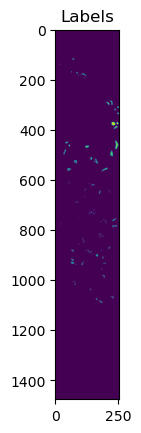

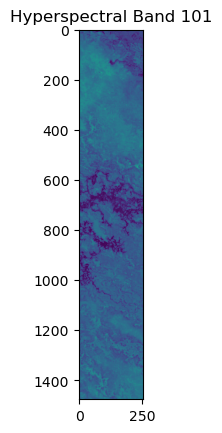

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Botswana_gt.mat'
data_files = 'Botswana.mat'
label_files = 'Botswana_gt'
hypercube_files = 'Botswana'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 3248
Extracted windows shape: (3248, 5, 5, 145)
Corresponding labels shape: (3248,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 20)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 270 samples
Shuffled class indices for class '1'
Selected 20 training samples and 5 validation samples for class '1'

Class: 2: Found 101 samples
Shuffled class indices for class '2'
Selected 20 training samples and 5 validation samples for class '2'

Class: 3: Found 251 samples
Shuffled class indices for class '3'
Selected 20 training samples and 5 validation samples for class '3'

Class: 4: Found 215 samples
Shuffled class indices for class '4'
Selected 20 training samples and 5 validation samples for class '4'

Class: 5: Found 269 samples
Shuffled class indices for class '5'
Selected 20 training samples and 5 validation samples for class '5'

Class: 6: Found 269 samples
Shuffled class indices for class '6'
Selected 20 training samples and 5 validation samples for class '6'

Class: 7: Found 259 samples
Shuffled class indices for class '7'
S

In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 280
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2598, 5, 5, 145)
Validation data shape: (650, 5, 5, 145)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

145


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/41], Loss: 0.2180, PSNR: -10.8726


Epoch [1/50] Training Loss: 0.2092, PSNR: -9.0340
	[Val]   Batch [1/11] Loss: 0.2008, PSNR: -6.0651
	[Val]   Batch [10/11] Loss: 0.2010, PSNR: -8.3038
Epoch [1/50] Validation Loss: 0.2008, PSNR: -7.9959

LOG: Epoch [2/50]
	 Training Batch [1/41], Loss: 0.1936, PSNR: -7.4908


Epoch [2/50] Training Loss: 0.1872, PSNR: -8.2245
	[Val]   Batch [1/11] Loss: 0.1750, PSNR: -5.4670
	[Val]   Batch [10/11] Loss: 0.1752, PSNR: -7.7084
Epoch [2/50] Validation Loss: 0.1750, PSNR: -7.3992

LOG: Epoch [3/50]
	 Training Batch [1/41], Loss: 0.1730, PSNR: -5.4180


Epoch [3/50] Training Loss: 0.1663, PSNR: -7.7073
	[Val]   Batch [1/11] Loss: 0.1504, PSNR: -4.8100
	[Val]   Batch [10/11] Loss: 0.1504, PSNR: -7.0467
Epoch [3/50] Validation Loss: 0.1504, PSNR: -6.7404

LOG: Epoch [4/50]
	 Training Batch [1/41], Loss: 0.1535, PSNR: -8.3206


Epoch [4/50] Training Loss: 0.1462, PSNR: -7.0238
	[Val]   Batch [1/11] Loss: 0.1314, PSNR: -4.2238
	[Val]   Batch [10/11] Loss: 0.1315, PSNR: -6.4614
Epoch [4/50] Validation Loss: 0.1313, PSNR: -6.1523

LOG: Epoch [5/50]
	 Training Batch [1/41], Loss: 0.1338, PSNR: -6.2355


Epoch [5/50] Training Loss: 0.1273, PSNR: -6.5344
	[Val]   Batch [1/11] Loss: 0.1123, PSNR: -3.5414
	[Val]   Batch [10/11] Loss: 0.1124, PSNR: -5.7798
Epoch [5/50] Validation Loss: 0.1123, PSNR: -5.4712

LOG: Epoch [6/50]
	 Training Batch [1/41], Loss: 0.1160, PSNR: -6.2699


Epoch [6/50] Training Loss: 0.1100, PSNR: -5.7589
	[Val]   Batch [1/11] Loss: 0.0974, PSNR: -2.9233
	[Val]   Batch [10/11] Loss: 0.0976, PSNR: -5.1659
Epoch [6/50] Validation Loss: 0.0975, PSNR: -4.8561

LOG: Epoch [7/50]
	 Training Batch [1/41], Loss: 0.1000, PSNR: -3.0349


Epoch [7/50] Training Loss: 0.0947, PSNR: -5.3138
	[Val]   Batch [1/11] Loss: 0.0839, PSNR: -2.2764
	[Val]   Batch [10/11] Loss: 0.0841, PSNR: -4.5185
Epoch [7/50] Validation Loss: 0.0840, PSNR: -4.2087

LOG: Epoch [8/50]
	 Training Batch [1/41], Loss: 0.0859, PSNR: -5.2270


Epoch [8/50] Training Loss: 0.0815, PSNR: -4.8328
	[Val]   Batch [1/11] Loss: 0.0724, PSNR: -1.6343
	[Val]   Batch [10/11] Loss: 0.0725, PSNR: -3.8767
Epoch [8/50] Validation Loss: 0.0724, PSNR: -3.5660

LOG: Epoch [9/50]
	 Training Batch [1/41], Loss: 0.0743, PSNR: -5.9731


Epoch [9/50] Training Loss: 0.0702, PSNR: -3.9115
	[Val]   Batch [1/11] Loss: 0.0638, PSNR: -1.0877
	[Val]   Batch [10/11] Loss: 0.0639, PSNR: -3.3292
Epoch [9/50] Validation Loss: 0.0638, PSNR: -3.0188

LOG: Epoch [10/50]
	 Training Batch [1/41], Loss: 0.0656, PSNR: -4.0080


Epoch [10/50] Training Loss: 0.0608, PSNR: -3.1434
	[Val]   Batch [1/11] Loss: 0.0545, PSNR: -0.4039
	[Val]   Batch [10/11] Loss: 0.0546, PSNR: -2.6441
Epoch [10/50] Validation Loss: 0.0545, PSNR: -2.3342

LOG: Epoch [11/50]
	 Training Batch [1/41], Loss: 0.0552, PSNR: -4.0433


Epoch [11/50] Training Loss: 0.0529, PSNR: -2.6920
	[Val]   Batch [1/11] Loss: 0.0493, PSNR: 0.0310
	[Val]   Batch [10/11] Loss: 0.0494, PSNR: -2.2071
Epoch [11/50] Validation Loss: 0.0493, PSNR: -1.8983

LOG: Epoch [12/50]
	 Training Batch [1/41], Loss: 0.0483, PSNR: -4.2038


Epoch [12/50] Training Loss: 0.0464, PSNR: -2.2213
	[Val]   Batch [1/11] Loss: 0.0430, PSNR: 0.6235
	[Val]   Batch [10/11] Loss: 0.0431, PSNR: -1.6138
Epoch [12/50] Validation Loss: 0.0430, PSNR: -1.3053

LOG: Epoch [13/50]
	 Training Batch [1/41], Loss: 0.0423, PSNR: -0.8810


Epoch [13/50] Training Loss: 0.0410, PSNR: -1.5187
	[Val]   Batch [1/11] Loss: 0.0391, PSNR: 1.0431
	[Val]   Batch [10/11] Loss: 0.0391, PSNR: -1.1938
Epoch [13/50] Validation Loss: 0.0390, PSNR: -0.8836

LOG: Epoch [14/50]
	 Training Batch [1/41], Loss: 0.0377, PSNR: 1.2036


Epoch [14/50] Training Loss: 0.0365, PSNR: -1.1037
	[Val]   Batch [1/11] Loss: 0.0347, PSNR: 1.5592
	[Val]   Batch [10/11] Loss: 0.0347, PSNR: -0.6783
Epoch [14/50] Validation Loss: 0.0347, PSNR: -0.3671

LOG: Epoch [15/50]
	 Training Batch [1/41], Loss: 0.0336, PSNR: -2.5620


Epoch [15/50] Training Loss: 0.0326, PSNR: -0.6378
	[Val]   Batch [1/11] Loss: 0.0310, PSNR: 2.0539
	[Val]   Batch [10/11] Loss: 0.0310, PSNR: -0.1837
Epoch [15/50] Validation Loss: 0.0309, PSNR: 0.1274

LOG: Epoch [16/50]
	 Training Batch [1/41], Loss: 0.0299, PSNR: 0.8889


Epoch [16/50] Training Loss: 0.0294, PSNR: -0.3541
	[Val]   Batch [1/11] Loss: 0.0284, PSNR: 2.4333
	[Val]   Batch [10/11] Loss: 0.0284, PSNR: 0.1960
Epoch [16/50] Validation Loss: 0.0283, PSNR: 0.5064

LOG: Epoch [17/50]
	 Training Batch [1/41], Loss: 0.0283, PSNR: -0.4075


Epoch [17/50] Training Loss: 0.0266, PSNR: 0.2260
	[Val]   Batch [1/11] Loss: 0.0258, PSNR: 2.8467
	[Val]   Batch [10/11] Loss: 0.0258, PSNR: 0.6101
Epoch [17/50] Validation Loss: 0.0258, PSNR: 0.9201

LOG: Epoch [18/50]
	 Training Batch [1/41], Loss: 0.0252, PSNR: 2.9482


Epoch [18/50] Training Loss: 0.0242, PSNR: 0.6502
	[Val]   Batch [1/11] Loss: 0.0234, PSNR: 3.2679
	[Val]   Batch [10/11] Loss: 0.0234, PSNR: 1.0328
Epoch [18/50] Validation Loss: 0.0234, PSNR: 1.3422

LOG: Epoch [19/50]
	 Training Batch [1/41], Loss: 0.0229, PSNR: 1.4253


Epoch [19/50] Training Loss: 0.0221, PSNR: 1.1869
	[Val]   Batch [1/11] Loss: 0.0216, PSNR: 3.6126
	[Val]   Batch [10/11] Loss: 0.0216, PSNR: 1.3781
Epoch [19/50] Validation Loss: 0.0216, PSNR: 1.6875

LOG: Epoch [20/50]
	 Training Batch [1/41], Loss: 0.0207, PSNR: 0.8702


Epoch [20/50] Training Loss: 0.0203, PSNR: 1.5084
	[Val]   Batch [1/11] Loss: 0.0198, PSNR: 4.0067
	[Val]   Batch [10/11] Loss: 0.0198, PSNR: 1.7711
Epoch [20/50] Validation Loss: 0.0197, PSNR: 2.0819

LOG: Epoch [21/50]
	 Training Batch [1/41], Loss: 0.0195, PSNR: -0.2789


Epoch [21/50] Training Loss: 0.0187, PSNR: 1.8186
	[Val]   Batch [1/11] Loss: 0.0183, PSNR: 4.3469
	[Val]   Batch [10/11] Loss: 0.0183, PSNR: 2.1098
Epoch [21/50] Validation Loss: 0.0182, PSNR: 2.4224

LOG: Epoch [22/50]
	 Training Batch [1/41], Loss: 0.0177, PSNR: 2.5443


Epoch [22/50] Training Loss: 0.0172, PSNR: 2.1798
	[Val]   Batch [1/11] Loss: 0.0170, PSNR: 4.6530
	[Val]   Batch [10/11] Loss: 0.0170, PSNR: 2.4172
Epoch [22/50] Validation Loss: 0.0170, PSNR: 2.7285

LOG: Epoch [23/50]
	 Training Batch [1/41], Loss: 0.0165, PSNR: 3.2072


Epoch [23/50] Training Loss: 0.0160, PSNR: 2.4105
	[Val]   Batch [1/11] Loss: 0.0157, PSNR: 4.9937
	[Val]   Batch [10/11] Loss: 0.0157, PSNR: 2.7598
Epoch [23/50] Validation Loss: 0.0157, PSNR: 3.0692

LOG: Epoch [24/50]
	 Training Batch [1/41], Loss: 0.0151, PSNR: 2.7417


Epoch [24/50] Training Loss: 0.0148, PSNR: 2.7889
	[Val]   Batch [1/11] Loss: 0.0147, PSNR: 5.3025
	[Val]   Batch [10/11] Loss: 0.0146, PSNR: 3.0687
Epoch [24/50] Validation Loss: 0.0146, PSNR: 3.3781

LOG: Epoch [25/50]
	 Training Batch [1/41], Loss: 0.0142, PSNR: 5.4481


Epoch [25/50] Training Loss: 0.0138, PSNR: 3.1120
	[Val]   Batch [1/11] Loss: 0.0137, PSNR: 5.6035
	[Val]   Batch [10/11] Loss: 0.0137, PSNR: 3.3686
Epoch [25/50] Validation Loss: 0.0137, PSNR: 3.6792

LOG: Epoch [26/50]
	 Training Batch [1/41], Loss: 0.0136, PSNR: 5.6207


Epoch [26/50] Training Loss: 0.0129, PSNR: 3.4167
	[Val]   Batch [1/11] Loss: 0.0128, PSNR: 5.8753
	[Val]   Batch [10/11] Loss: 0.0128, PSNR: 3.6405
Epoch [26/50] Validation Loss: 0.0128, PSNR: 3.9506

LOG: Epoch [27/50]
	 Training Batch [1/41], Loss: 0.0119, PSNR: 2.7771


Epoch [27/50] Training Loss: 0.0120, PSNR: 3.6644
	[Val]   Batch [1/11] Loss: 0.0119, PSNR: 6.1924
	[Val]   Batch [10/11] Loss: 0.0119, PSNR: 3.9576
Epoch [27/50] Validation Loss: 0.0119, PSNR: 4.2676

LOG: Epoch [28/50]
	 Training Batch [1/41], Loss: 0.0116, PSNR: 4.3892


Epoch [28/50] Training Loss: 0.0113, PSNR: 3.9232
	[Val]   Batch [1/11] Loss: 0.0112, PSNR: 6.4563
	[Val]   Batch [10/11] Loss: 0.0112, PSNR: 4.2229
Epoch [28/50] Validation Loss: 0.0112, PSNR: 4.5316

LOG: Epoch [29/50]
	 Training Batch [1/41], Loss: 0.0109, PSNR: 4.6538


Epoch [29/50] Training Loss: 0.0106, PSNR: 4.2072
	[Val]   Batch [1/11] Loss: 0.0106, PSNR: 6.7296
	[Val]   Batch [10/11] Loss: 0.0105, PSNR: 4.4965
Epoch [29/50] Validation Loss: 0.0105, PSNR: 4.8054

LOG: Epoch [30/50]
	 Training Batch [1/41], Loss: 0.0104, PSNR: 4.8740


Epoch [30/50] Training Loss: 0.0100, PSNR: 4.6512
	[Val]   Batch [1/11] Loss: 0.0099, PSNR: 7.0075
	[Val]   Batch [10/11] Loss: 0.0099, PSNR: 4.7744
Epoch [30/50] Validation Loss: 0.0099, PSNR: 5.0837

LOG: Epoch [31/50]
	 Training Batch [1/41], Loss: 0.0099, PSNR: 3.2772


Epoch [31/50] Training Loss: 0.0094, PSNR: 4.7942
	[Val]   Batch [1/11] Loss: 0.0093, PSNR: 7.2598
	[Val]   Batch [10/11] Loss: 0.0093, PSNR: 5.0264
Epoch [31/50] Validation Loss: 0.0093, PSNR: 5.3364

LOG: Epoch [32/50]
	 Training Batch [1/41], Loss: 0.0092, PSNR: 3.8905


Epoch [32/50] Training Loss: 0.0089, PSNR: 5.0094
	[Val]   Batch [1/11] Loss: 0.0089, PSNR: 7.4525
	[Val]   Batch [10/11] Loss: 0.0089, PSNR: 5.2202
Epoch [32/50] Validation Loss: 0.0089, PSNR: 5.5297

LOG: Epoch [33/50]
	 Training Batch [1/41], Loss: 0.0085, PSNR: 3.9353


Epoch [33/50] Training Loss: 0.0084, PSNR: 5.3634
	[Val]   Batch [1/11] Loss: 0.0084, PSNR: 7.7163
	[Val]   Batch [10/11] Loss: 0.0084, PSNR: 5.4844
Epoch [33/50] Validation Loss: 0.0084, PSNR: 5.7938

LOG: Epoch [34/50]
	 Training Batch [1/41], Loss: 0.0081, PSNR: 5.9388


Epoch [34/50] Training Loss: 0.0079, PSNR: 5.4131
	[Val]   Batch [1/11] Loss: 0.0079, PSNR: 7.9725
	[Val]   Batch [10/11] Loss: 0.0079, PSNR: 5.7403
Epoch [34/50] Validation Loss: 0.0079, PSNR: 6.0507

LOG: Epoch [35/50]
	 Training Batch [1/41], Loss: 0.0076, PSNR: 6.8271


Epoch [35/50] Training Loss: 0.0075, PSNR: 5.4678
	[Val]   Batch [1/11] Loss: 0.0076, PSNR: 8.1757
	[Val]   Batch [10/11] Loss: 0.0076, PSNR: 5.9433
Epoch [35/50] Validation Loss: 0.0075, PSNR: 6.2545

LOG: Epoch [36/50]
	 Training Batch [1/41], Loss: 0.0075, PSNR: 3.9841


Epoch [36/50] Training Loss: 0.0072, PSNR: 5.8676
	[Val]   Batch [1/11] Loss: 0.0072, PSNR: 8.3934
	[Val]   Batch [10/11] Loss: 0.0072, PSNR: 6.1609
Epoch [36/50] Validation Loss: 0.0072, PSNR: 6.4727

LOG: Epoch [37/50]
	 Training Batch [1/41], Loss: 0.0068, PSNR: 6.6941


Epoch [37/50] Training Loss: 0.0068, PSNR: 6.0350
	[Val]   Batch [1/11] Loss: 0.0068, PSNR: 8.6143
	[Val]   Batch [10/11] Loss: 0.0068, PSNR: 6.3816
Epoch [37/50] Validation Loss: 0.0068, PSNR: 6.6934

LOG: Epoch [38/50]
	 Training Batch [1/41], Loss: 0.0066, PSNR: 4.8620


Epoch [38/50] Training Loss: 0.0065, PSNR: 6.4653
	[Val]   Batch [1/11] Loss: 0.0065, PSNR: 8.8133
	[Val]   Batch [10/11] Loss: 0.0065, PSNR: 6.5804
Epoch [38/50] Validation Loss: 0.0065, PSNR: 6.8918

LOG: Epoch [39/50]
	 Training Batch [1/41], Loss: 0.0066, PSNR: 5.3448


Epoch [39/50] Training Loss: 0.0062, PSNR: 6.5628
	[Val]   Batch [1/11] Loss: 0.0062, PSNR: 9.0156
	[Val]   Batch [10/11] Loss: 0.0062, PSNR: 6.7822
Epoch [39/50] Validation Loss: 0.0062, PSNR: 7.0936

LOG: Epoch [40/50]
	 Training Batch [1/41], Loss: 0.0061, PSNR: 4.6487


Epoch [40/50] Training Loss: 0.0059, PSNR: 6.8453
	[Val]   Batch [1/11] Loss: 0.0059, PSNR: 9.2424
	[Val]   Batch [10/11] Loss: 0.0059, PSNR: 7.0084
Epoch [40/50] Validation Loss: 0.0059, PSNR: 7.3204

LOG: Epoch [41/50]
	 Training Batch [1/41], Loss: 0.0057, PSNR: 5.4350


Epoch [41/50] Training Loss: 0.0056, PSNR: 7.0781
	[Val]   Batch [1/11] Loss: 0.0057, PSNR: 9.4382
	[Val]   Batch [10/11] Loss: 0.0057, PSNR: 7.2039
Epoch [41/50] Validation Loss: 0.0056, PSNR: 7.5164

LOG: Epoch [42/50]
	 Training Batch [1/41], Loss: 0.0053, PSNR: 6.7019


Epoch [42/50] Training Loss: 0.0054, PSNR: 7.2830
	[Val]   Batch [1/11] Loss: 0.0055, PSNR: 9.5772
	[Val]   Batch [10/11] Loss: 0.0055, PSNR: 7.3436
Epoch [42/50] Validation Loss: 0.0055, PSNR: 7.6564

LOG: Epoch [43/50]
	 Training Batch [1/41], Loss: 0.0053, PSNR: 5.5340


Epoch [43/50] Training Loss: 0.0052, PSNR: 7.3659
	[Val]   Batch [1/11] Loss: 0.0052, PSNR: 9.7982
	[Val]   Batch [10/11] Loss: 0.0052, PSNR: 7.5649
Epoch [43/50] Validation Loss: 0.0052, PSNR: 7.8783

LOG: Epoch [44/50]
	 Training Batch [1/41], Loss: 0.0051, PSNR: 5.5234


Epoch [44/50] Training Loss: 0.0050, PSNR: 7.5553
	[Val]   Batch [1/11] Loss: 0.0050, PSNR: 9.9663
	[Val]   Batch [10/11] Loss: 0.0050, PSNR: 7.7320
Epoch [44/50] Validation Loss: 0.0050, PSNR: 8.0468

LOG: Epoch [45/50]
	 Training Batch [1/41], Loss: 0.0048, PSNR: 6.7568


Epoch [45/50] Training Loss: 0.0048, PSNR: 7.6793
	[Val]   Batch [1/11] Loss: 0.0048, PSNR: 10.1279
	[Val]   Batch [10/11] Loss: 0.0048, PSNR: 7.8953
Epoch [45/50] Validation Loss: 0.0048, PSNR: 8.2084

LOG: Epoch [46/50]
	 Training Batch [1/41], Loss: 0.0046, PSNR: 5.8113


Epoch [46/50] Training Loss: 0.0046, PSNR: 7.6028
	[Val]   Batch [1/11] Loss: 0.0046, PSNR: 10.3574
	[Val]   Batch [10/11] Loss: 0.0046, PSNR: 8.1260
Epoch [46/50] Validation Loss: 0.0046, PSNR: 8.4377

LOG: Epoch [47/50]
	 Training Batch [1/41], Loss: 0.0044, PSNR: 8.8957


Epoch [47/50] Training Loss: 0.0044, PSNR: 8.0274
	[Val]   Batch [1/11] Loss: 0.0044, PSNR: 10.5165
	[Val]   Batch [10/11] Loss: 0.0044, PSNR: 8.2860
Epoch [47/50] Validation Loss: 0.0044, PSNR: 8.5975

LOG: Epoch [48/50]
	 Training Batch [1/41], Loss: 0.0044, PSNR: 6.6148


Epoch [48/50] Training Loss: 0.0042, PSNR: 8.0616
	[Val]   Batch [1/11] Loss: 0.0043, PSNR: 10.6579
	[Val]   Batch [10/11] Loss: 0.0043, PSNR: 8.4270
Epoch [48/50] Validation Loss: 0.0043, PSNR: 8.7392

LOG: Epoch [49/50]
	 Training Batch [1/41], Loss: 0.0042, PSNR: 6.1596


Epoch [49/50] Training Loss: 0.0041, PSNR: 8.4364
	[Val]   Batch [1/11] Loss: 0.0041, PSNR: 10.8245
	[Val]   Batch [10/11] Loss: 0.0041, PSNR: 8.5927
Epoch [49/50] Validation Loss: 0.0041, PSNR: 8.9058

LOG: Epoch [50/50]
	 Training Batch [1/41], Loss: 0.0041, PSNR: 10.8680


Epoch [50/50] Training Loss: 0.0039, PSNR: 8.6468
	[Val]   Batch [1/11] Loss: 0.0039, PSNR: 10.9973
	[Val]   Batch [10/11] Loss: 0.0039, PSNR: 8.7658
Epoch [50/50] Validation Loss: 0.0039, PSNR: 9.0789


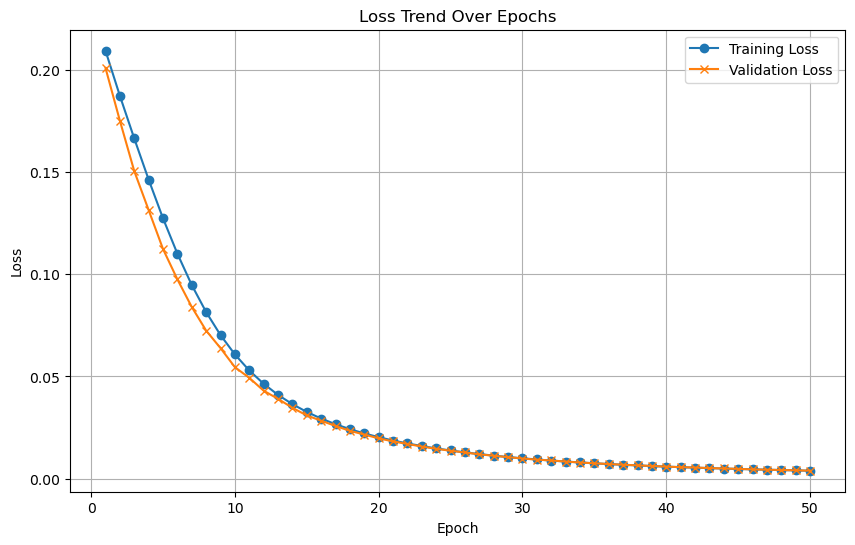

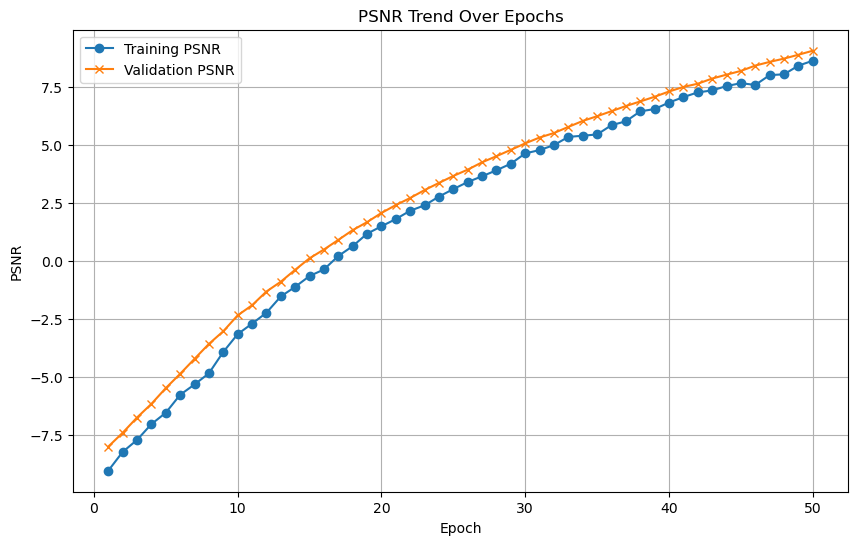

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/12 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6441
    Validation Batch [1/1], Loss: 2.6427
Validation Loss: 2.6427, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.6427. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5932
    Validation Batch [1/1], Loss: 2.6427
Validation Loss: 2.6427, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5641
    Validation Batch [1/1], Loss: 2.6427
Validation Loss: 2.6427, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5527
    Validation Batch [1/1], Loss: 2.6428
Validation Loss: 2.6428, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Training Loss: 2.5241
    Validati

Epoch [16/1000] completed, Average Training Loss: 2.3649
    Validation Batch [1/1], Loss: 2.6429
Validation Loss: 2.6429, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [17/1000] - Training
Epoch [17/1000] completed, Average Training Loss: 2.3514
    Validation Batch [1/1], Loss: 2.6429
Validation Loss: 2.6429, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [18/1000] - Training
Epoch [18/1000] completed, Average Training Loss: 2.3400
    Validation Batch [1/1], Loss: 2.6429
Validation Loss: 2.6429, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [19/1000] - Training
Epoch [19/1000] completed, Average Training Loss: 2.3220
    Validation Batch [1/1], Loss: 2.6429
Validation Loss: 2.6429, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [20/1000] - Training
Epoch [20/1000] completed, Average Training Loss: 2.3192
    Validat

    Validation Batch [1/1], Loss: 2.6428
Validation Loss: 2.6428, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.2970
    Validation Batch [1/1], Loss: 2.6428
Validation Loss: 2.6428, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.2908
    Validation Batch [1/1], Loss: 2.6428
Validation Loss: 2.6428, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.2704
    Validation Batch [1/1], Loss: 2.6428
Validation Loss: 2.6428, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.2746
    Validation Batch [1/1], Loss: 2.6428
Validation Loss: 2.6428, Va

Epoch [37/1000] completed, Average Training Loss: 2.1434
    Validation Batch [1/1], Loss: 2.6427
Validation Loss: 2.6427, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [38/1000] - Training
Epoch [38/1000] completed, Average Training Loss: 2.1306
    Validation Batch [1/1], Loss: 2.6426
Validation Loss: 2.6426, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 2.1224
    Validation Batch [1/1], Loss: 2.6426
Validation Loss: 2.6426, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.1164
    Validation Batch [1/1], Loss: 2.6426
Validation Loss: 2.6426, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.1006
    Validation 

    Validation Batch [1/1], Loss: 2.6418
Validation Loss: 2.6418, Validation Accuracy: 14.29%
Validation loss improved from 2.6422 to 2.6418. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [44/1000] completed, Average Training Loss: 2.0808
    Validation Batch [1/1], Loss: 2.6416
Validation Loss: 2.6416, Validation Accuracy: 14.29%
Validation loss improved from 2.6418 to 2.6416. Saving model...

LOG: Epoch [45/1000] - Training
Epoch [45/1000] completed, Average Training Loss: 2.0716
    Validation Batch [1/1], Loss: 2.6411
Validation Loss: 2.6411, Validation Accuracy: 10.00%
Validation loss improved from 2.6416 to 2.6411. Saving model...

LOG: Epoch [46/1000] - Training
Epoch [46/1000] completed, Average Training Loss: 2.0614
    Validation Batch [1/1], Loss: 2.6404
Validation Loss: 2.6404, Validation Accuracy: 8.57%
Validation loss improved from 2.6411 to 2.6404. Saving model...

LOG: Epoch [47/1000] - Training
Epoch [47/1000] completed, Average Training Loss: 2.0622
    Valid

Epoch [60/1000] completed, Average Training Loss: 1.9291
    Validation Batch [1/1], Loss: 2.5900
Validation Loss: 2.5900, Validation Accuracy: 12.86%
Validation loss improved from 2.5979 to 2.5900. Saving model...

LOG: Epoch [61/1000] - Training
Epoch [61/1000] completed, Average Training Loss: 1.9251
    Validation Batch [1/1], Loss: 2.5805
Validation Loss: 2.5805, Validation Accuracy: 14.29%
Validation loss improved from 2.5900 to 2.5805. Saving model...

LOG: Epoch [62/1000] - Training
Epoch [62/1000] completed, Average Training Loss: 1.9087
    Validation Batch [1/1], Loss: 2.5670
Validation Loss: 2.5670, Validation Accuracy: 20.00%
Validation loss improved from 2.5805 to 2.5670. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 1.9072
    Validation Batch [1/1], Loss: 2.5507
Validation Loss: 2.5507, Validation Accuracy: 21.43%
Validation loss improved from 2.5670 to 2.5507. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [6

Epoch [67/1000] completed, Average Training Loss: 1.8803
    Validation Batch [1/1], Loss: 2.5015
Validation Loss: 2.5015, Validation Accuracy: 21.43%
Validation loss improved from 2.5171 to 2.5015. Saving model...

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 1.8608
    Validation Batch [1/1], Loss: 2.4854
Validation Loss: 2.4854, Validation Accuracy: 21.43%
Validation loss improved from 2.5015 to 2.4854. Saving model...

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.8547
    Validation Batch [1/1], Loss: 2.4694
Validation Loss: 2.4694, Validation Accuracy: 22.86%
Validation loss improved from 2.4854 to 2.4694. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 1.8474
    Validation Batch [1/1], Loss: 2.4514
Validation Loss: 2.4514, Validation Accuracy: 22.86%
Validation loss improved from 2.4694 to 2.4514. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [7

    Validation Batch [1/1], Loss: 2.0957
Validation Loss: 2.0957, Validation Accuracy: 57.14%
Validation loss improved from 2.1383 to 2.0957. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 1.7363
    Validation Batch [1/1], Loss: 2.0589
Validation Loss: 2.0589, Validation Accuracy: 57.14%
Validation loss improved from 2.0957 to 2.0589. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 1.7259
    Validation Batch [1/1], Loss: 2.0389
Validation Loss: 2.0389, Validation Accuracy: 58.57%
Validation loss improved from 2.0589 to 2.0389. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 1.7166
    Validation Batch [1/1], Loss: 2.0274
Validation Loss: 2.0274, Validation Accuracy: 61.43%
Validation loss improved from 2.0389 to 2.0274. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.7099
    Vali

Epoch [92/1000] completed, Average Training Loss: 1.6776
    Validation Batch [1/1], Loss: 1.8632
Validation Loss: 1.8632, Validation Accuracy: 68.57%
Validation loss improved from 1.8884 to 1.8632. Saving model...

LOG: Epoch [93/1000] - Training
Epoch [93/1000] completed, Average Training Loss: 1.6648
    Validation Batch [1/1], Loss: 1.8384
Validation Loss: 1.8384, Validation Accuracy: 70.00%
Validation loss improved from 1.8632 to 1.8384. Saving model...

LOG: Epoch [94/1000] - Training
Epoch [94/1000] completed, Average Training Loss: 1.6714
    Validation Batch [1/1], Loss: 1.8108
Validation Loss: 1.8108, Validation Accuracy: 65.71%
Validation loss improved from 1.8384 to 1.8108. Saving model...

LOG: Epoch [95/1000] - Training
Epoch [95/1000] completed, Average Training Loss: 1.6628
    Validation Batch [1/1], Loss: 1.7957
Validation Loss: 1.7957, Validation Accuracy: 65.71%
Validation loss improved from 1.8108 to 1.7957. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [9

Epoch [104/1000] completed, Average Training Loss: 1.5719
    Validation Batch [1/1], Loss: 1.6633
Validation Loss: 1.6633, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [105/1000] - Training
Epoch [105/1000] completed, Average Training Loss: 1.5584
    Validation Batch [1/1], Loss: 1.6502
Validation Loss: 1.6502, Validation Accuracy: 70.00%
Validation loss improved from 1.6608 to 1.6502. Saving model...

LOG: Epoch [106/1000] - Training
Epoch [106/1000] completed, Average Training Loss: 1.5113
    Validation Batch [1/1], Loss: 1.6235
Validation Loss: 1.6235, Validation Accuracy: 70.00%
Validation loss improved from 1.6502 to 1.6235. Saving model...

LOG: Epoch [107/1000] - Training
Epoch [107/1000] completed, Average Training Loss: 1.5452
    Validation Batch [1/1], Loss: 1.5932
Validation Loss: 1.5932, Validation Accuracy: 74.29%
Validation loss improved from 1.6235 to 1.5932. Saving model...

LOG: Epoch [108/1000] - Training
Epoch [108/1000

Epoch [116/1000] completed, Average Training Loss: 1.4841
    Validation Batch [1/1], Loss: 1.5080
Validation Loss: 1.5080, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 1.4430
    Validation Batch [1/1], Loss: 1.4758
Validation Loss: 1.4758, Validation Accuracy: 78.57%
Validation loss improved from 1.5071 to 1.4758. Saving model...

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 1.4437
    Validation Batch [1/1], Loss: 1.4531
Validation Loss: 1.4531, Validation Accuracy: 75.71%
Validation loss improved from 1.4758 to 1.4531. Saving model...

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 1.4414
    Validation Batch [1/1], Loss: 1.4518
Validation Loss: 1.4518, Validation Accuracy: 78.57%
Validation loss improved from 1.4531 to 1.4518. Saving model...

LOG: Epoch [120/1000] - Training
Epoch [120/1000

Epoch [128/1000] completed, Average Training Loss: 1.3562
    Validation Batch [1/1], Loss: 1.3905
Validation Loss: 1.3905, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [129/1000] - Training
Epoch [129/1000] completed, Average Training Loss: 1.3716
    Validation Batch [1/1], Loss: 1.3760
Validation Loss: 1.3760, Validation Accuracy: 87.14%
Validation loss improved from 1.3890 to 1.3760. Saving model...

LOG: Epoch [130/1000] - Training
Epoch [130/1000] completed, Average Training Loss: 1.3510
    Validation Batch [1/1], Loss: 1.3681
Validation Loss: 1.3681, Validation Accuracy: 81.43%
Validation loss improved from 1.3760 to 1.3681. Saving model...

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 1.3230
    Validation Batch [1/1], Loss: 1.3494
Validation Loss: 1.3494, Validation Accuracy: 84.29%
Validation loss improved from 1.3681 to 1.3494. Saving model...

LOG: Epoch [132/1000] - Training
Epoch [132/1000

Epoch [140/1000] completed, Average Training Loss: 1.2583
    Validation Batch [1/1], Loss: 1.2657
Validation Loss: 1.2657, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.2502
    Validation Batch [1/1], Loss: 1.2606
Validation Loss: 1.2606, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 1.2763
    Validation Batch [1/1], Loss: 1.2395
Validation Loss: 1.2395, Validation Accuracy: 88.57%
Validation loss improved from 1.2536 to 1.2395. Saving model...

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 1.2520
    Validation Batch [1/1], Loss: 1.2239
Validation Loss: 1.2239, Validation Accuracy: 90.00%
Validation loss improved from 1.2395 to 1.2239. Saving model...

LOG: Epoch [144/1000] - Training
Epoch [144/1000] completed, Av

Epoch [152/1000] completed, Average Training Loss: 1.1573
    Validation Batch [1/1], Loss: 1.1560
Validation Loss: 1.1560, Validation Accuracy: 90.00%
Validation loss improved from 1.1693 to 1.1560. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000] completed, Average Training Loss: 1.1594
    Validation Batch [1/1], Loss: 1.1397
Validation Loss: 1.1397, Validation Accuracy: 90.00%
Validation loss improved from 1.1560 to 1.1397. Saving model...

LOG: Epoch [154/1000] - Training
Epoch [154/1000] completed, Average Training Loss: 1.1543
    Validation Batch [1/1], Loss: 1.1381
Validation Loss: 1.1381, Validation Accuracy: 90.00%
Validation loss improved from 1.1397 to 1.1381. Saving model...

LOG: Epoch [155/1000] - Training
Epoch [155/1000] completed, Average Training Loss: 1.1745
    Validation Batch [1/1], Loss: 1.1468
Validation Loss: 1.1468, Validation Accuracy: 90.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [156/1000] - Training
Epoch [156/1000

Epoch [164/1000] completed, Average Training Loss: 1.0729
    Validation Batch [1/1], Loss: 1.0783
Validation Loss: 1.0783, Validation Accuracy: 90.00%
Validation loss improved from 1.0852 to 1.0783. Saving model...

LOG: Epoch [165/1000] - Training
Epoch [165/1000] completed, Average Training Loss: 1.0915
    Validation Batch [1/1], Loss: 1.0544
Validation Loss: 1.0544, Validation Accuracy: 91.43%
Validation loss improved from 1.0783 to 1.0544. Saving model...

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 1.1020
    Validation Batch [1/1], Loss: 1.0486
Validation Loss: 1.0486, Validation Accuracy: 92.86%
Validation loss improved from 1.0544 to 1.0486. Saving model...

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 1.0693
    Validation Batch [1/1], Loss: 1.0584
Validation Loss: 1.0584, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000

    Validation Batch [1/1], Loss: 0.9905
Validation Loss: 0.9905, Validation Accuracy: 91.43%
Validation loss improved from 0.9997 to 0.9905. Saving model...

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 1.0042
    Validation Batch [1/1], Loss: 0.9908
Validation Loss: 0.9908, Validation Accuracy: 91.43%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 1.0052
    Validation Batch [1/1], Loss: 0.9754
Validation Loss: 0.9754, Validation Accuracy: 94.29%
Validation loss improved from 0.9905 to 0.9754. Saving model...

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 0.9674
    Validation Batch [1/1], Loss: 0.9742
Validation Loss: 0.9742, Validation Accuracy: 92.86%
Validation loss improved from 0.9754 to 0.9742. Saving model...

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 0.9913
    Validation 

Epoch [187/1000] completed, Average Training Loss: 0.9076
    Validation Batch [1/1], Loss: 0.9025
Validation Loss: 0.9025, Validation Accuracy: 92.86%
Validation loss improved from 0.9149 to 0.9025. Saving model...

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 0.8912
    Validation Batch [1/1], Loss: 0.8807
Validation Loss: 0.8807, Validation Accuracy: 91.43%
Validation loss improved from 0.9025 to 0.8807. Saving model...

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 0.9214
    Validation Batch [1/1], Loss: 0.8979
Validation Loss: 0.8979, Validation Accuracy: 94.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 0.9078
    Validation Batch [1/1], Loss: 0.8952
Validation Loss: 0.8952, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Av

Epoch [201/1000] completed, Average Training Loss: 0.8355
    Validation Batch [1/1], Loss: 0.8105
Validation Loss: 0.8105, Validation Accuracy: 95.71%
Validation loss improved from 0.8128 to 0.8105. Saving model...

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 0.8098
    Validation Batch [1/1], Loss: 0.8104
Validation Loss: 0.8104, Validation Accuracy: 97.14%
Validation loss improved from 0.8105 to 0.8104. Saving model...

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 0.8226
    Validation Batch [1/1], Loss: 0.8140
Validation Loss: 0.8140, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training Loss: 0.7955
    Validation Batch [1/1], Loss: 0.7928
Validation Loss: 0.7928, Validation Accuracy: 95.71%
Validation loss improved from 0.8104 to 0.7928. Saving model...

LOG: Epoch [205/1000] - Training
Epoch [205/1000

Epoch [209/1000] completed, Average Training Loss: 0.7773
    Validation Batch [1/1], Loss: 0.7690
Validation Loss: 0.7690, Validation Accuracy: 95.71%
Validation loss improved from 0.7885 to 0.7690. Saving model...

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.7970
    Validation Batch [1/1], Loss: 0.7618
Validation Loss: 0.7618, Validation Accuracy: 95.71%
Validation loss improved from 0.7690 to 0.7618. Saving model...

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.7772
    Validation Batch [1/1], Loss: 0.7616
Validation Loss: 0.7616, Validation Accuracy: 98.57%
Validation loss improved from 0.7618 to 0.7616. Saving model...

LOG: Epoch [212/1000] - Training
Epoch [212/1000] completed, Average Training Loss: 0.7658
    Validation Batch [1/1], Loss: 0.7633
Validation Loss: 0.7633, Validation Accuracy: 92.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [213/1000] - Training
Epoch [213/1000

Epoch [225/1000] completed, Average Training Loss: 0.6940
    Validation Batch [1/1], Loss: 0.6687
Validation Loss: 0.6687, Validation Accuracy: 98.57%
Validation loss improved from 0.6870 to 0.6687. Saving model...

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.6930
    Validation Batch [1/1], Loss: 0.6766
Validation Loss: 0.6766, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.6819
    Validation Batch [1/1], Loss: 0.6772
Validation Loss: 0.6772, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.6761
    Validation Batch [1/1], Loss: 0.6722
Validation Loss: 0.6722, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training 

Epoch [232/1000] completed, Average Training Loss: 0.6380
    Validation Batch [1/1], Loss: 0.6358
Validation Loss: 0.6358, Validation Accuracy: 95.71%
Validation loss improved from 0.6430 to 0.6358. Saving model...

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.6446
    Validation Batch [1/1], Loss: 0.6354
Validation Loss: 0.6354, Validation Accuracy: 97.14%
Validation loss improved from 0.6358 to 0.6354. Saving model...

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.6345
    Validation Batch [1/1], Loss: 0.6408
Validation Loss: 0.6408, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.6579
    Validation Batch [1/1], Loss: 0.6386
Validation Loss: 0.6386, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Av

Epoch [248/1000] completed, Average Training Loss: 0.5826
    Validation Batch [1/1], Loss: 0.5759
Validation Loss: 0.5759, Validation Accuracy: 97.14%
Validation loss improved from 0.5849 to 0.5759. Saving model...

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.6004
    Validation Batch [1/1], Loss: 0.5662
Validation Loss: 0.5662, Validation Accuracy: 97.14%
Validation loss improved from 0.5759 to 0.5662. Saving model...

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.5631
    Validation Batch [1/1], Loss: 0.5608
Validation Loss: 0.5608, Validation Accuracy: 97.14%
Validation loss improved from 0.5662 to 0.5608. Saving model...

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.5481
    Validation Batch [1/1], Loss: 0.5586
Validation Loss: 0.5586, Validation Accuracy: 97.14%
Validation loss improved from 0.5608 to 0.5586. Saving model...

LOG: Epoch [252/1000] - Training


Epoch [255/1000] completed, Average Training Loss: 0.5523
    Validation Batch [1/1], Loss: 0.5491
Validation Loss: 0.5491, Validation Accuracy: 97.14%
Validation loss improved from 0.5586 to 0.5491. Saving model...

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.5476
    Validation Batch [1/1], Loss: 0.5324
Validation Loss: 0.5324, Validation Accuracy: 98.57%
Validation loss improved from 0.5491 to 0.5324. Saving model...

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.5233
    Validation Batch [1/1], Loss: 0.5324
Validation Loss: 0.5324, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.5114
    Validation Batch [1/1], Loss: 0.5200
Validation Loss: 0.5200, Validation Accuracy: 97.14%
Validation loss improved from 0.5324 to 0.5200. Saving model...

LOG: Epoch [259/1000] - Training
Epoch [259/1000

    Validation Batch [1/1], Loss: 0.5099
Validation Loss: 0.5099, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.4864
    Validation Batch [1/1], Loss: 0.5021
Validation Loss: 0.5021, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [271/1000] - Training
Epoch [271/1000] completed, Average Training Loss: 0.4844
    Validation Batch [1/1], Loss: 0.4744
Validation Loss: 0.4744, Validation Accuracy: 98.57%
Validation loss improved from 0.4961 to 0.4744. Saving model...

LOG: Epoch [272/1000] - Training
Epoch [272/1000] completed, Average Training Loss: 0.4607
    Validation Batch [1/1], Loss: 0.4654
Validation Loss: 0.4654, Validation Accuracy: 97.14%
Validation loss improved from 0.4744 to 0.4654. Saving model...

LOG: Epoch [273/1000] - Training
Epoch [273/1000] completed, Average Training Loss: 0.4741
    Validation Batch [1/1], Lo

    Validation Batch [1/1], Loss: 0.4732
Validation Loss: 0.4732, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training Loss: 0.4605
    Validation Batch [1/1], Loss: 0.4928
Validation Loss: 0.4928, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.4486
    Validation Batch [1/1], Loss: 0.4765
Validation Loss: 0.4765, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.4487
    Validation Batch [1/1], Loss: 0.4757
Validation Loss: 0.4757, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.4536
    Validation Batch [1/1], Loss: 0.4784
Validation Loss: 0.

    Validation Batch [1/1], Loss: 0.4135
Validation Loss: 0.4135, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.4218
    Validation Batch [1/1], Loss: 0.4067
Validation Loss: 0.4067, Validation Accuracy: 98.57%
Validation loss improved from 0.4107 to 0.4067. Saving model...

LOG: Epoch [293/1000] - Training
Epoch [293/1000] completed, Average Training Loss: 0.4041
    Validation Batch [1/1], Loss: 0.4008
Validation Loss: 0.4008, Validation Accuracy: 100.00%
Validation loss improved from 0.4067 to 0.4008. Saving model...

LOG: Epoch [294/1000] - Training
Epoch [294/1000] completed, Average Training Loss: 0.3981
    Validation Batch [1/1], Loss: 0.3894
Validation Loss: 0.3894, Validation Accuracy: 98.57%
Validation loss improved from 0.4008 to 0.3894. Saving model...

LOG: Epoch [295/1000] - Training
Epoch [295/1000] completed, Average Training Loss: 0.3972
    Validation

Epoch [297/1000] completed, Average Training Loss: 0.3794
    Validation Batch [1/1], Loss: 0.3786
Validation Loss: 0.3786, Validation Accuracy: 98.57%
Validation loss improved from 0.3892 to 0.3786. Saving model...

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training Loss: 0.3801
    Validation Batch [1/1], Loss: 0.3834
Validation Loss: 0.3834, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [299/1000] - Training
Epoch [299/1000] completed, Average Training Loss: 0.3631
    Validation Batch [1/1], Loss: 0.3770
Validation Loss: 0.3770, Validation Accuracy: 98.57%
Validation loss improved from 0.3786 to 0.3770. Saving model...

LOG: Epoch [300/1000] - Training
Epoch [300/1000] completed, Average Training Loss: 0.3869
    Validation Batch [1/1], Loss: 0.3772
Validation Loss: 0.3772, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Av

Epoch [313/1000] completed, Average Training Loss: 0.3510
    Validation Batch [1/1], Loss: 0.3399
Validation Loss: 0.3399, Validation Accuracy: 98.57%
Validation loss improved from 0.3413 to 0.3399. Saving model...

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.3454
    Validation Batch [1/1], Loss: 0.3367
Validation Loss: 0.3367, Validation Accuracy: 100.00%
Validation loss improved from 0.3399 to 0.3367. Saving model...

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.3293
    Validation Batch [1/1], Loss: 0.3225
Validation Loss: 0.3225, Validation Accuracy: 98.57%
Validation loss improved from 0.3367 to 0.3225. Saving model...

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.3291
    Validation Batch [1/1], Loss: 0.3252
Validation Loss: 0.3252, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [317/1000] - Training
Epoch [317/100

Epoch [319/1000] completed, Average Training Loss: 0.3053
    Validation Batch [1/1], Loss: 0.3252
Validation Loss: 0.3252, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training Loss: 0.3293
    Validation Batch [1/1], Loss: 0.3116
Validation Loss: 0.3116, Validation Accuracy: 97.14%
Validation loss improved from 0.3219 to 0.3116. Saving model...

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.3195
    Validation Batch [1/1], Loss: 0.3150
Validation Loss: 0.3150, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.3164
    Validation Batch [1/1], Loss: 0.3109
Validation Loss: 0.3109, Validation Accuracy: 100.00%
Validation loss improved from 0.3116 to 0.3109. Saving model...

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, 

Epoch [338/1000] completed, Average Training Loss: 0.2786
    Validation Batch [1/1], Loss: 0.2616
Validation Loss: 0.2616, Validation Accuracy: 98.57%
Validation loss improved from 0.2634 to 0.2616. Saving model...

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.2365
    Validation Batch [1/1], Loss: 0.2633
Validation Loss: 0.2633, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [340/1000] - Training
Epoch [340/1000] completed, Average Training Loss: 0.2723
    Validation Batch [1/1], Loss: 0.2649
Validation Loss: 0.2649, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.2568
    Validation Batch [1/1], Loss: 0.2638
Validation Loss: 0.2638, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.2560
Validation Loss: 0.2560, Validation Accuracy: 98.57%
Validation loss improved from 0.2609 to 0.2560. Saving model...

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training Loss: 0.2484
    Validation Batch [1/1], Loss: 0.2501
Validation Loss: 0.2501, Validation Accuracy: 98.57%
Validation loss improved from 0.2560 to 0.2501. Saving model...

LOG: Epoch [345/1000] - Training
Epoch [345/1000] completed, Average Training Loss: 0.2458
    Validation Batch [1/1], Loss: 0.2613
Validation Loss: 0.2613, Validation Accuracy: 95.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.2335
    Validation Batch [1/1], Loss: 0.2453
Validation Loss: 0.2453, Validation Accuracy: 97.14%
Validation loss improved from 0.2501 to 0.2453. Saving model...

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.2331
    Validation 

Epoch [361/1000] completed, Average Training Loss: 0.2094
    Validation Batch [1/1], Loss: 0.2303
Validation Loss: 0.2303, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.2253
    Validation Batch [1/1], Loss: 0.2313
Validation Loss: 0.2313, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.2256
    Validation Batch [1/1], Loss: 0.2228
Validation Loss: 0.2228, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training Loss: 0.2016
    Validation Batch [1/1], Loss: 0.2197
Validation Loss: 0.2197, Validation Accuracy: 97.14%
Validation loss improved from 0.2223 to 0.2197. Saving model...

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training 

Epoch [366/1000] completed, Average Training Loss: 0.2220
    Validation Batch [1/1], Loss: 0.2156
Validation Loss: 0.2156, Validation Accuracy: 97.14%
Validation loss improved from 0.2197 to 0.2156. Saving model...

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.2162
    Validation Batch [1/1], Loss: 0.2105
Validation Loss: 0.2105, Validation Accuracy: 97.14%
Validation loss improved from 0.2156 to 0.2105. Saving model...

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.2022
    Validation Batch [1/1], Loss: 0.2156
Validation Loss: 0.2156, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.2109
    Validation Batch [1/1], Loss: 0.2267
Validation Loss: 0.2267, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [370/1000] - Training
Epoch [370/1000] completed, Av

Epoch [387/1000] completed, Average Training Loss: 0.1719
    Validation Batch [1/1], Loss: 0.1924
Validation Loss: 0.1924, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.1836
    Validation Batch [1/1], Loss: 0.1899
Validation Loss: 0.1899, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.1855
    Validation Batch [1/1], Loss: 0.1866
Validation Loss: 0.1866, Validation Accuracy: 98.57%
Validation loss improved from 0.1884 to 0.1866. Saving model...

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.1677
    Validation Batch [1/1], Loss: 0.2012
Validation Loss: 0.2012, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [391/1000] - Training
Epoch [391/1000] completed, Average Training 

Epoch [410/1000] completed, Average Training Loss: 0.1396
    Validation Batch [1/1], Loss: 0.1592
Validation Loss: 0.1592, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [411/1000] - Training
Epoch [411/1000] completed, Average Training Loss: 0.1465
    Validation Batch [1/1], Loss: 0.1582
Validation Loss: 0.1582, Validation Accuracy: 98.57%
Validation loss improved from 0.1587 to 0.1582. Saving model...

LOG: Epoch [412/1000] - Training
Epoch [412/1000] completed, Average Training Loss: 0.1438
    Validation Batch [1/1], Loss: 0.1590
Validation Loss: 0.1590, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [413/1000] - Training
Epoch [413/1000] completed, Average Training Loss: 0.1547
    Validation Batch [1/1], Loss: 0.1534
Validation Loss: 0.1534, Validation Accuracy: 98.57%
Validation loss improved from 0.1582 to 0.1534. Saving model...

LOG: Epoch [414/1000] - Training
Epoch [414/1000] completed, Av

    Validation Batch [1/1], Loss: 0.1579
Validation Loss: 0.1579, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.1472
    Validation Batch [1/1], Loss: 0.1449
Validation Loss: 0.1449, Validation Accuracy: 97.14%
Validation loss improved from 0.1534 to 0.1449. Saving model...

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.1584
    Validation Batch [1/1], Loss: 0.1462
Validation Loss: 0.1462, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.1368
    Validation Batch [1/1], Loss: 0.1465
Validation Loss: 0.1465, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.1342
    Validation Batch [1/1], Loss: 0.1564
Val

Epoch [446/1000] completed, Average Training Loss: 0.1156
    Validation Batch [1/1], Loss: 0.1592
Validation Loss: 0.1592, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [447/1000] - Training
Epoch [447/1000] completed, Average Training Loss: 0.1204
    Validation Batch [1/1], Loss: 0.1569
Validation Loss: 0.1569, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [448/1000] - Training
Epoch [448/1000] completed, Average Training Loss: 0.1025
    Validation Batch [1/1], Loss: 0.1559
Validation Loss: 0.1559, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [449/1000] - Training
Epoch [449/1000] completed, Average Training Loss: 0.1001
    Validation Batch [1/1], Loss: 0.1496
Validation Loss: 0.1496, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [450/1000] - Training
Epoch [450/1000] completed, Average Training Loss: 0.122

Epoch [470/1000] completed, Average Training Loss: 0.1115
    Validation Batch [1/1], Loss: 0.1221
Validation Loss: 0.1221, Validation Accuracy: 98.57%
Validation loss improved from 0.1290 to 0.1221. Saving model...

LOG: Epoch [471/1000] - Training
Epoch [471/1000] completed, Average Training Loss: 0.1089
    Validation Batch [1/1], Loss: 0.1277
Validation Loss: 0.1277, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [472/1000] - Training
Epoch [472/1000] completed, Average Training Loss: 0.0995
    Validation Batch [1/1], Loss: 0.1400
Validation Loss: 0.1400, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [473/1000] - Training
Epoch [473/1000] completed, Average Training Loss: 0.1063
    Validation Batch [1/1], Loss: 0.1360
Validation Loss: 0.1360, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, Average Training 

Epoch [495/1000] completed, Average Training Loss: 0.0994
    Validation Batch [1/1], Loss: 0.1231
Validation Loss: 0.1231, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.0828
    Validation Batch [1/1], Loss: 0.1167
Validation Loss: 0.1167, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [497/1000] - Training
Epoch [497/1000] completed, Average Training Loss: 0.0854
    Validation Batch [1/1], Loss: 0.1104
Validation Loss: 0.1104, Validation Accuracy: 97.14%
Validation loss improved from 0.1124 to 0.1104. Saving model...

LOG: Epoch [498/1000] - Training
Epoch [498/1000] completed, Average Training Loss: 0.0852
    Validation Batch [1/1], Loss: 0.1070
Validation Loss: 0.1070, Validation Accuracy: 97.14%
Validation loss improved from 0.1104 to 0.1070. Saving model...

LOG: Epoch [499/1000] - Training
Epoch [499/1000] completed, Av

Epoch [519/1000] completed, Average Training Loss: 0.0818
    Validation Batch [1/1], Loss: 0.1042
Validation Loss: 0.1042, Validation Accuracy: 97.14%
Validation loss improved from 0.1043 to 0.1042. Saving model...

LOG: Epoch [520/1000] - Training
Epoch [520/1000] completed, Average Training Loss: 0.0768
    Validation Batch [1/1], Loss: 0.1056
Validation Loss: 0.1056, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [521/1000] - Training
Epoch [521/1000] completed, Average Training Loss: 0.0856
    Validation Batch [1/1], Loss: 0.1083
Validation Loss: 0.1083, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [522/1000] - Training
Epoch [522/1000] completed, Average Training Loss: 0.0795
    Validation Batch [1/1], Loss: 0.1136
Validation Loss: 0.1136, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training 

Epoch [543/1000] completed, Average Training Loss: 0.0695
    Validation Batch [1/1], Loss: 0.1141
Validation Loss: 0.1141, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.0686
    Validation Batch [1/1], Loss: 0.1252
Validation Loss: 0.1252, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.0657
    Validation Batch [1/1], Loss: 0.1239
Validation Loss: 0.1239, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [546/1000] - Training
Epoch [546/1000] completed, Average Training Loss: 0.0773
    Validation Batch [1/1], Loss: 0.1116
Validation Loss: 0.1116, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [547/1000] - Training
Epoch [547/1000] completed, Average Training Loss: 0.065

Epoch [568/1000] completed, Average Training Loss: 0.0556
    Validation Batch [1/1], Loss: 0.0988
Validation Loss: 0.0988, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [569/1000] - Training
Epoch [569/1000] completed, Average Training Loss: 0.0632
    Validation Batch [1/1], Loss: 0.0983
Validation Loss: 0.0983, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [570/1000] - Training
Epoch [570/1000] completed, Average Training Loss: 0.0577
    Validation Batch [1/1], Loss: 0.0967
Validation Loss: 0.0967, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [571/1000] - Training
Epoch [571/1000] completed, Average Training Loss: 0.0592
    Validation Batch [1/1], Loss: 0.0950
Validation Loss: 0.0950, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [572/1000] - Training
Epoch [572/1000] completed, Average Training Loss: 0.056

Epoch [591/1000] completed, Average Training Loss: 0.0663
    Validation Batch [1/1], Loss: 0.0846
Validation Loss: 0.0846, Validation Accuracy: 98.57%
Validation loss improved from 0.0852 to 0.0846. Saving model...

LOG: Epoch [592/1000] - Training
Epoch [592/1000] completed, Average Training Loss: 0.0533
    Validation Batch [1/1], Loss: 0.0881
Validation Loss: 0.0881, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [593/1000] - Training
Epoch [593/1000] completed, Average Training Loss: 0.0517
    Validation Batch [1/1], Loss: 0.0865
Validation Loss: 0.0865, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [594/1000] - Training
Epoch [594/1000] completed, Average Training Loss: 0.0555
    Validation Batch [1/1], Loss: 0.0832
Validation Loss: 0.0832, Validation Accuracy: 98.57%
Validation loss improved from 0.0846 to 0.0832. Saving model...

LOG: Epoch [595/1000] - Training
Epoch [595/1000] completed, Av

Epoch [615/1000] completed, Average Training Loss: 0.0598
    Validation Batch [1/1], Loss: 0.0774
Validation Loss: 0.0774, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [616/1000] - Training
Epoch [616/1000] completed, Average Training Loss: 0.0527
    Validation Batch [1/1], Loss: 0.0782
Validation Loss: 0.0782, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [617/1000] - Training
Epoch [617/1000] completed, Average Training Loss: 0.0423
    Validation Batch [1/1], Loss: 0.0797
Validation Loss: 0.0797, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [618/1000] - Training
Epoch [618/1000] completed, Average Training Loss: 0.0489
    Validation Batch [1/1], Loss: 0.0827
Validation Loss: 0.0827, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [619/1000] - Training
Epoch [619/1000] completed, Average Training Loss: 0.0526
  

Epoch [638/1000] completed, Average Training Loss: 0.0497
    Validation Batch [1/1], Loss: 0.0914
Validation Loss: 0.0914, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [639/1000] - Training
Epoch [639/1000] completed, Average Training Loss: 0.0541
    Validation Batch [1/1], Loss: 0.0833
Validation Loss: 0.0833, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [640/1000] - Training
Epoch [640/1000] completed, Average Training Loss: 0.0466
    Validation Batch [1/1], Loss: 0.0751
Validation Loss: 0.0751, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [641/1000] - Training
Epoch [641/1000] completed, Average Training Loss: 0.0489
    Validation Batch [1/1], Loss: 0.0765
Validation Loss: 0.0765, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [642/1000] - Training
Epoch [642/1000] completed, Average Training Loss: 0.0442
  

Epoch [659/1000] completed, Average Training Loss: 0.0424
    Validation Batch [1/1], Loss: 0.0898
Validation Loss: 0.0898, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [660/1000] - Training
Epoch [660/1000] completed, Average Training Loss: 0.0462
    Validation Batch [1/1], Loss: 0.0889
Validation Loss: 0.0889, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [661/1000] - Training
Epoch [661/1000] completed, Average Training Loss: 0.0363
    Validation Batch [1/1], Loss: 0.0901
Validation Loss: 0.0901, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [662/1000] - Training
Epoch [662/1000] completed, Average Training Loss: 0.0422
    Validation Batch [1/1], Loss: 0.0907
Validation Loss: 0.0907, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [663/1000] - Training
Epoch [663/1000] completed, Average Training Loss: 0.047

Epoch [681/1000] completed, Average Training Loss: 0.0375
    Validation Batch [1/1], Loss: 0.0778
Validation Loss: 0.0778, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [682/1000] - Training
Epoch [682/1000] completed, Average Training Loss: 0.0371
    Validation Batch [1/1], Loss: 0.0770
Validation Loss: 0.0770, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [683/1000] - Training
Epoch [683/1000] completed, Average Training Loss: 0.0437
    Validation Batch [1/1], Loss: 0.0779
Validation Loss: 0.0779, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [684/1000] - Training
Epoch [684/1000] completed, Average Training Loss: 0.0361
    Validation Batch [1/1], Loss: 0.0765
Validation Loss: 0.0765, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [685/1000] - Training
Epoch [685/1000] completed, Average Training Loss: 0.036

Epoch [704/1000] completed, Average Training Loss: 0.0363
    Validation Batch [1/1], Loss: 0.0727
Validation Loss: 0.0727, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [705/1000] - Training
Epoch [705/1000] completed, Average Training Loss: 0.0402
    Validation Batch [1/1], Loss: 0.0793
Validation Loss: 0.0793, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [706/1000] - Training
Epoch [706/1000] completed, Average Training Loss: 0.0329
    Validation Batch [1/1], Loss: 0.0800
Validation Loss: 0.0800, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [707/1000] - Training
Epoch [707/1000] completed, Average Training Loss: 0.0464
    Validation Batch [1/1], Loss: 0.0804
Validation Loss: 0.0804, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [708/1000] - Training
Epoch [708/1000] completed, Average Training Loss: 0.030

Epoch [728/1000] completed, Average Training Loss: 0.0366
    Validation Batch [1/1], Loss: 0.0842
Validation Loss: 0.0842, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [729/1000] - Training
Epoch [729/1000] completed, Average Training Loss: 0.0321
    Validation Batch [1/1], Loss: 0.0870
Validation Loss: 0.0870, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [730/1000] - Training
Epoch [730/1000] completed, Average Training Loss: 0.0392
    Validation Batch [1/1], Loss: 0.0776
Validation Loss: 0.0776, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [731/1000] - Training
Epoch [731/1000] completed, Average Training Loss: 0.0411
    Validation Batch [1/1], Loss: 0.0753
Validation Loss: 0.0753, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [732/1000] - Training
Epoch [732/1000] completed, Average Training Loss: 0.038

Epoch [751/1000] completed, Average Training Loss: 0.0302
    Validation Batch [1/1], Loss: 0.0773
Validation Loss: 0.0773, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [752/1000] - Training
Epoch [752/1000] completed, Average Training Loss: 0.0295
    Validation Batch [1/1], Loss: 0.0749
Validation Loss: 0.0749, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [753/1000] - Training
Epoch [753/1000] completed, Average Training Loss: 0.0306
    Validation Batch [1/1], Loss: 0.0705
Validation Loss: 0.0705, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [754/1000] - Training
Epoch [754/1000] completed, Average Training Loss: 0.0292
    Validation Batch [1/1], Loss: 0.0664
Validation Loss: 0.0664, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [755/1000] - Training
Epoch [755/1000] completed, Average Training Loss: 0.035

Epoch [776/1000] completed, Average Training Loss: 0.0277
    Validation Batch [1/1], Loss: 0.0573
Validation Loss: 0.0573, Validation Accuracy: 98.57%
Validation loss improved from 0.0575 to 0.0573. Saving model...

LOG: Epoch [777/1000] - Training
Epoch [777/1000] completed, Average Training Loss: 0.0266
    Validation Batch [1/1], Loss: 0.0640
Validation Loss: 0.0640, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [778/1000] - Training
Epoch [778/1000] completed, Average Training Loss: 0.0306
    Validation Batch [1/1], Loss: 0.0660
Validation Loss: 0.0660, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [779/1000] - Training
Epoch [779/1000] completed, Average Training Loss: 0.0262
    Validation Batch [1/1], Loss: 0.0606
Validation Loss: 0.0606, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [780/1000] - Training
Epoch [780/1000] completed, Average Training 

Epoch [800/1000] completed, Average Training Loss: 0.0245
    Validation Batch [1/1], Loss: 0.0667
Validation Loss: 0.0667, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [801/1000] - Training
Epoch [801/1000] completed, Average Training Loss: 0.0313
    Validation Batch [1/1], Loss: 0.0633
Validation Loss: 0.0633, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [802/1000] - Training
Epoch [802/1000] completed, Average Training Loss: 0.0320
    Validation Batch [1/1], Loss: 0.0642
Validation Loss: 0.0642, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [803/1000] - Training
Epoch [803/1000] completed, Average Training Loss: 0.0223
    Validation Batch [1/1], Loss: 0.0720
Validation Loss: 0.0720, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [804/1000] - Training
Epoch [804/1000] completed, Average Training Loss: 0.025

Epoch [823/1000] completed, Average Training Loss: 0.0300
    Validation Batch [1/1], Loss: 0.0612
Validation Loss: 0.0612, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [824/1000] - Training
Epoch [824/1000] completed, Average Training Loss: 0.0235
    Validation Batch [1/1], Loss: 0.0589
Validation Loss: 0.0589, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [825/1000] - Training
Epoch [825/1000] completed, Average Training Loss: 0.0231
    Validation Batch [1/1], Loss: 0.0611
Validation Loss: 0.0611, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [826/1000] - Training
Epoch [826/1000] completed, Average Training Loss: 0.0315
    Validation Batch [1/1], Loss: 0.0593
Validation Loss: 0.0593, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [827/1000] - Training
Epoch [827/1000] completed, Average Training Loss: 0.030

Epoch [847/1000] completed, Average Training Loss: 0.0196
    Validation Batch [1/1], Loss: 0.0671
Validation Loss: 0.0671, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [848/1000] - Training
Epoch [848/1000] completed, Average Training Loss: 0.0191
    Validation Batch [1/1], Loss: 0.0620
Validation Loss: 0.0620, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [849/1000] - Training
Epoch [849/1000] completed, Average Training Loss: 0.0274
    Validation Batch [1/1], Loss: 0.0589
Validation Loss: 0.0589, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [850/1000] - Training
Epoch [850/1000] completed, Average Training Loss: 0.0213
    Validation Batch [1/1], Loss: 0.0577
Validation Loss: 0.0577, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [851/1000] - Training
Epoch [851/1000] completed, Average Training Loss: 0.024

    Validation Batch [1/1], Loss: 0.0524
Validation Loss: 0.0524, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [870/1000] - Training
Epoch [870/1000] completed, Average Training Loss: 0.0245
    Validation Batch [1/1], Loss: 0.0516
Validation Loss: 0.0516, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [871/1000] - Training
Epoch [871/1000] completed, Average Training Loss: 0.0250
    Validation Batch [1/1], Loss: 0.0581
Validation Loss: 0.0581, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [872/1000] - Training
Epoch [872/1000] completed, Average Training Loss: 0.0192
    Validation Batch [1/1], Loss: 0.0656
Validation Loss: 0.0656, Validation Accuracy: 100.00%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [873/1000] - Training
Epoch [873/1000] completed, Average Training Loss: 0.0205
    Validation Batch [1/1], Loss: 0.0654
Validation Lo

Epoch [892/1000] completed, Average Training Loss: 0.0195
    Validation Batch [1/1], Loss: 0.0485
Validation Loss: 0.0485, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [893/1000] - Training
Epoch [893/1000] completed, Average Training Loss: 0.0195
    Validation Batch [1/1], Loss: 0.0523
Validation Loss: 0.0523, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [894/1000] - Training
Epoch [894/1000] completed, Average Training Loss: 0.0261
    Validation Batch [1/1], Loss: 0.0565
Validation Loss: 0.0565, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [895/1000] - Training
Epoch [895/1000] completed, Average Training Loss: 0.0190
    Validation Batch [1/1], Loss: 0.0590
Validation Loss: 0.0590, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [896/1000] - Training
Epoch [896/1000] completed, Average Training Loss: 0.018

Epoch [915/1000] completed, Average Training Loss: 0.0151
    Validation Batch [1/1], Loss: 0.0552
Validation Loss: 0.0552, Validation Accuracy: 97.14%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [916/1000] - Training
Epoch [916/1000] completed, Average Training Loss: 0.0227
    Validation Batch [1/1], Loss: 0.0598
Validation Loss: 0.0598, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [917/1000] - Training
Epoch [917/1000] completed, Average Training Loss: 0.0186
    Validation Batch [1/1], Loss: 0.0605
Validation Loss: 0.0605, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [918/1000] - Training
Epoch [918/1000] completed, Average Training Loss: 0.0195
    Validation Batch [1/1], Loss: 0.0627
Validation Loss: 0.0627, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [919/1000] - Training
Epoch [919/1000] completed, Average Training Loss: 0.020

Epoch [940/1000] completed, Average Training Loss: 0.0220
    Validation Batch [1/1], Loss: 0.0794
Validation Loss: 0.0794, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 81/100

LOG: Epoch [941/1000] - Training
Epoch [941/1000] completed, Average Training Loss: 0.0201
    Validation Batch [1/1], Loss: 0.0690
Validation Loss: 0.0690, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [942/1000] - Training
Epoch [942/1000] completed, Average Training Loss: 0.0159
    Validation Batch [1/1], Loss: 0.0610
Validation Loss: 0.0610, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [943/1000] - Training
Epoch [943/1000] completed, Average Training Loss: 0.0142
    Validation Batch [1/1], Loss: 0.0572
Validation Loss: 0.0572, Validation Accuracy: 98.57%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [944/1000] - Training
Epoch [944/1000] completed, Average Training Loss: 0.027

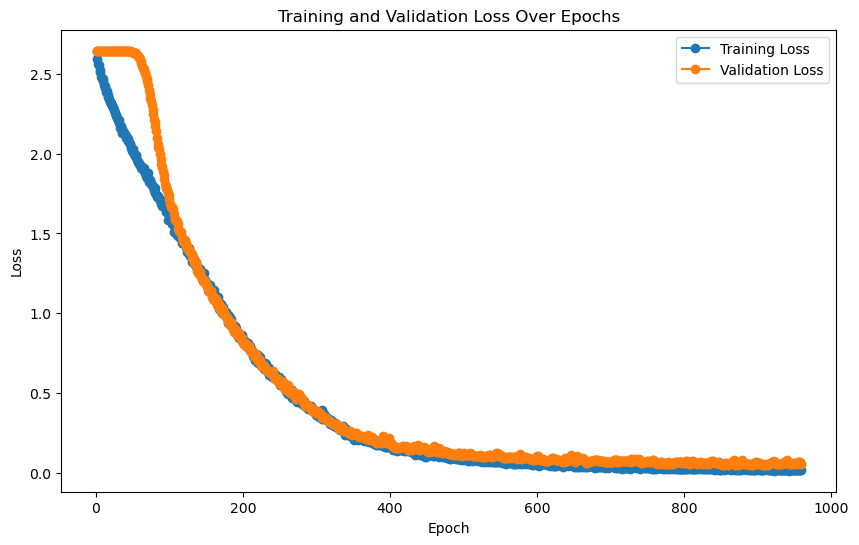

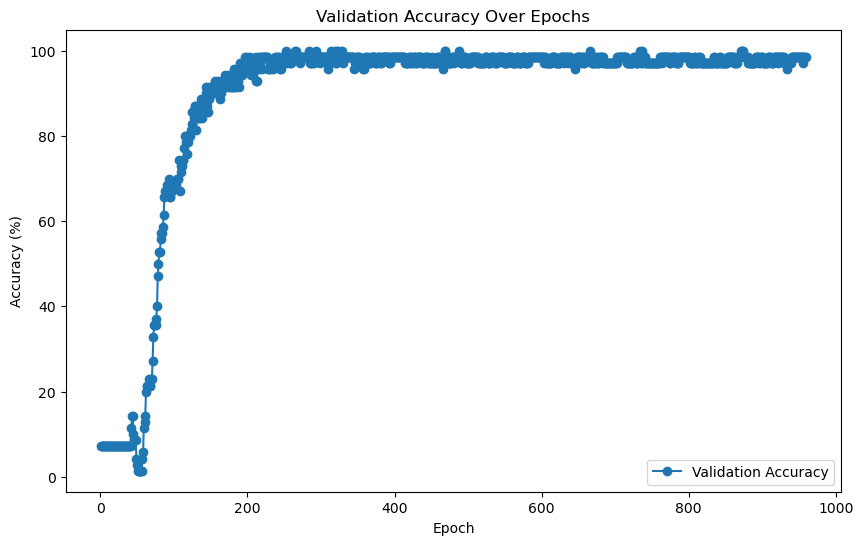


Evaluating on the test set...
    Test Batch [1/12], Loss: 0.0071

Final Test Loss: 0.0958, Test Accuracy: 97.65%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/12 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 280 samples with 64 features each
LOG: Labels shape: (280,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2898 samples with 64 features each
LOG: Labels shape: (2898,)

LOG: Training features shape: (280, 64), Training labels shape: (280,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (2898, 64), Test labels shape: (2898,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 80.00%

Validation Classification Report:
               precision    recall  f1

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 280 samples with 64 features each
LOG: Labels shape: (280,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2898 samples with 64 features each
LOG: Labels shape: (2898,)
Train reps shape: (280, 64)
Train labels shape: (280,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (2898, 64)
Test labels shape: (2898,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7264  |  Val Loss: 2.6499
Validation loss improved from inf to 2.6499.


[Epoch 2/1000] Train Loss: 2.6429  |  Val Loss: 2.6188
Validation loss improved from 2.6499 to 2.6188.
[Epoch 3/1000] Train Loss: 2.6083  |  Val Loss: 2.5957
Validation loss improved from 2.6188 to 2.5957.
[Epoch 4/1000] Train Loss: 2.5890  |  Val Loss: 2.5760
Validation loss improved from 2.5957 to 2.5760.
[Epoch 5/1000] Train Loss: 2.5677  |  Val Loss: 2.5589
Validation loss improved from 2.5760 to 2.5589.
[Epoch 6/1000] Train Loss: 2.5549  |  Val Loss: 2.5466
Validation loss improved from 2.5589 to 2.5466.
[Epoch 7/1000] Train Loss: 2.5381  |  Val Loss: 2.5286
Validation loss improved from 2.5466 to 2.5286.
[Epoch 8/1000] Train Loss: 2.5176  |  Val Loss: 2.5091
Validation loss improved from 2.5286 to 2.5091.
[Epoch 9/1000] Train Loss: 2.4928  |  Val Loss: 2.4855
Validation loss improved from 2.5091 to 2.4855.
[Epoch 10/1000] Train Loss: 2.4685  |  Val Loss: 2.4596
Validation loss improved from 2.4855 to 2.4596.
[Epoch 11/1000] Train Loss: 2.4439  |  Val Loss: 2.4336
Validation loss 

[Epoch 17/1000] Train Loss: 2.2310  |  Val Loss: 2.2212
Validation loss improved from 2.2623 to 2.2212.
[Epoch 18/1000] Train Loss: 2.1867  |  Val Loss: 2.1814
Validation loss improved from 2.2212 to 2.1814.
[Epoch 19/1000] Train Loss: 2.1462  |  Val Loss: 2.1410
Validation loss improved from 2.1814 to 2.1410.
[Epoch 20/1000] Train Loss: 2.1088  |  Val Loss: 2.1102
Validation loss improved from 2.1410 to 2.1102.
[Epoch 21/1000] Train Loss: 2.0670  |  Val Loss: 2.0582
Validation loss improved from 2.1102 to 2.0582.


[Epoch 22/1000] Train Loss: 2.0195  |  Val Loss: 2.0126
Validation loss improved from 2.0582 to 2.0126.
[Epoch 23/1000] Train Loss: 1.9786  |  Val Loss: 1.9692
Validation loss improved from 2.0126 to 1.9692.
[Epoch 24/1000] Train Loss: 1.9288  |  Val Loss: 1.9271
Validation loss improved from 1.9692 to 1.9271.
[Epoch 25/1000] Train Loss: 1.8871  |  Val Loss: 1.8848
Validation loss improved from 1.9271 to 1.8848.
[Epoch 26/1000] Train Loss: 1.8454  |  Val Loss: 1.8441
Validation loss improved from 1.8848 to 1.8441.
[Epoch 27/1000] Train Loss: 1.8060  |  Val Loss: 1.8113
Validation loss improved from 1.8441 to 1.8113.
[Epoch 28/1000] Train Loss: 1.7668  |  Val Loss: 1.7642
Validation loss improved from 1.8113 to 1.7642.
[Epoch 29/1000] Train Loss: 1.7211  |  Val Loss: 1.7264
Validation loss improved from 1.7642 to 1.7264.
[Epoch 30/1000] Train Loss: 1.6874  |  Val Loss: 1.7086
Validation loss improved from 1.7264 to 1.7086.
[Epoch 31/1000] Train Loss: 1.6663  |  Val Loss: 1.6568
Validati

[Epoch 34/1000] Train Loss: 1.5656  |  Val Loss: 1.5738
Validation loss improved from 1.6251 to 1.5738.
[Epoch 35/1000] Train Loss: 1.5313  |  Val Loss: 1.5613
Validation loss improved from 1.5738 to 1.5613.
[Epoch 36/1000] Train Loss: 1.5039  |  Val Loss: 1.5295
Validation loss improved from 1.5613 to 1.5295.
[Epoch 37/1000] Train Loss: 1.4905  |  Val Loss: 1.5064
Validation loss improved from 1.5295 to 1.5064.
[Epoch 38/1000] Train Loss: 1.4595  |  Val Loss: 1.4979
Validation loss improved from 1.5064 to 1.4979.
[Epoch 39/1000] Train Loss: 1.4368  |  Val Loss: 1.5001
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 40/1000] Train Loss: 1.4384  |  Val Loss: 1.4665
Validation loss improved from 1.4979 to 1.4665.
[Epoch 41/1000] Train Loss: 1.4091  |  Val Loss: 1.4471
Validation loss improved from 1.4665 to 1.4471.
[Epoch 42/1000] Train Loss: 1.3940  |  Val Loss: 1.4281
Validation loss improved from 1.4471 to 1.4281.
[Epoch 43/1000] Train Loss: 1.3794  |  Val Loss: 1.4313
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 44/1000] Train Loss: 1.4003  |  Val Loss: 1.4161
Validation loss improved from 1.4281 to 1.4161.
[Epoch 45/1000] Train Loss: 1.3631  |  Val Loss: 1.4025
Validation loss improved from 1.4161 to 1.4025.
[Epoch 46/1000] Train Loss: 1.3438  |  Val Loss: 1.3916
Validation loss improved from 1.4025 to 1.3916.
[Epoch 47/1000] Train Loss: 1.3333  |  Val Loss: 1.3816
Validation loss improved from 1.3916 to 1.3816.
[Epoch 48/1000] Train Loss: 1.3257  |  Val Loss: 1.3937
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 49/1000] Train Loss: 1.3163  |  Val Loss: 1.3

[Epoch 52/1000] Train Loss: 1.2964  |  Val Loss: 1.3560
Validation loss improved from 1.3676 to 1.3560.
[Epoch 53/1000] Train Loss: 1.2931  |  Val Loss: 1.3581
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 54/1000] Train Loss: 1.2918  |  Val Loss: 1.3539
Validation loss improved from 1.3560 to 1.3539.
[Epoch 55/1000] Train Loss: 1.2920  |  Val Loss: 1.3412
Validation loss improved from 1.3539 to 1.3412.
[Epoch 56/1000] Train Loss: 1.2866  |  Val Loss: 1.3827
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 57/1000] Train Loss: 1.2670  |  Val Loss: 1.3267
Validation loss improved from 1.3412 to 1.3267.
[Epoch 58/1000] Train Loss: 1.2832  |  Val Loss: 1.3432
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 59/1000] Train Loss: 1.2573  |  Val Loss: 1.3332
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 60/1000] Train Loss: 1.2525  |  Val Loss: 1.3134
Validation loss improved from 1.3267 to 1.3134.
[Epoch 61/1000] Train Loss: 1.2728  |  Val Loss: 1.3320
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 62/1000] Train Loss: 1.2697  |  Val Loss: 1.4492
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 63/1000] Train Loss: 1.3096  |  Val Loss: 1.3276
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 64/1000] Train Loss: 1.2605  |  Val Loss: 1.3121
Validation loss improved from 1.3134 to 1.3121.
[Epoch 65/1000] Train Loss: 1.2343  |  Val Loss: 1.3118
Validation loss improved from 1.3121 to 1.3118.
[Epoch 66/1000] Train Loss: 1.2354  |  Val Loss: 1.3018
Validation loss improved from 1.3118 to 1.3018.
[Epoch 67/1000] Train Loss: 1.2386  |  Val Loss: 1.3033
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 68/1000] Train Loss: 1.2244

[Epoch 71/1000] Train Loss: 1.2321  |  Val Loss: 1.3459
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 72/1000] Train Loss: 1.2403  |  Val Loss: 1.3212
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 73/1000] Train Loss: 1.2575  |  Val Loss: 1.2951
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 74/1000] Train Loss: 1.2345  |  Val Loss: 1.3548
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 75/1000] Train Loss: 1.2769  |  Val Loss: 1.3832
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 76/1000] Train Loss: 1.2701  |  Val Loss: 1.3557
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 77/1000] Train Loss: 1.2409  |  Val Loss: 1.2774
Validation loss improved from 1.2929 to 1.2774.
[Epoch 78/1000] Train Loss: 1.2437  |  Val Loss: 1.2810
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 79/1000] Train Loss: 1.2230  |  Val Loss: 1.3218
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 80/1000] Train Loss: 1.2175  |  Val Loss: 1.2808
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 81/1000] Train Loss: 1.1953  |  Val Loss: 1.2765
Validation loss improved from 1.2774 to 1.2765.
[Epoch 82/1000] Train Loss: 1.2055  |  Val Loss: 1.3515
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 83/1000] Train Loss: 1.2379  |  Val Loss: 1.2751
Validation loss improved from 1.2765 to 1.2751.
[Epoch 84/1000] Train Loss: 1.1941  |  Val Loss: 1.3069
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 85/1000] Train Loss: 1.1869  |  Val Loss: 1.2931
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 86/1000] Train Loss: 

[Epoch 91/1000] Train Loss: 1.2443  |  Val Loss: 1.3960
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 92/1000] Train Loss: 1.2438  |  Val Loss: 1.2727
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 93/1000] Train Loss: 1.2223  |  Val Loss: 1.2604
Validation loss improved from 1.2718 to 1.2604.
[Epoch 94/1000] Train Loss: 1.2260  |  Val Loss: 1.2932
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 95/1000] Train Loss: 1.2083  |  Val Loss: 1.2861
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 96/1000] Train Loss: 1.2117  |  Val Loss: 1.3423
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 97/1000] Train Loss: 1.2068  |  Val Loss: 1.2628
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 98/1000] Train Loss: 1.1972  |  Val Loss: 1.2707
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 99/1000] Train Loss: 1.1955  |  Val Loss: 1.2711
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 100/1000] Train Loss: 1.1989  |  Val Loss: 1.2519
Validation loss improved from 1.2604 to 1.2519.
[Epoch 101/1000] Train Loss: 1.1813  |  Val Loss: 1.2684
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 102/1000] Train Loss: 1.1712  |  Val Loss: 1.2536
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 103/1000] Train Loss: 1.1974  |  Val Loss: 1.3335
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 104/1

[Epoch 111/1000] Train Loss: 1.1657  |  Val Loss: 1.2511
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 112/1000] Train Loss: 1.1705  |  Val Loss: 1.2659
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 113/1000] Train Loss: 1.1851  |  Val Loss: 1.2621
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 114/1000] Train Loss: 1.2168  |  Val Loss: 1.2406
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 115/1000] Train Loss: 1.1923  |  Val Loss: 1.3036
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 116/1000] Train Loss: 1.2016  |  Val Loss: 1.2555
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 117/1000] Train Loss: 1.1944  |  Val Loss: 1.3294
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 118/1000] Train Loss: 1.2107  |  Val Loss: 1.2459
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 119/1000] Train Loss: 1.1986  |  Val Loss: 1.2515
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 130/1000] Train Loss: 1.1627  |  Val Loss: 1.2237
Validation loss improved from 1.2284 to 1.2237.
[Epoch 131/1000] Train Loss: 1.1638  |  Val Loss: 1.2714
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 132/1000] Train Loss: 1.1780  |  Val Loss: 1.2360
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 133/1000] Train Loss: 1.1543  |  Val Loss: 1.2718
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 134/1000] Train Loss: 1.1626  |  Val Loss: 1.2154
Validation loss improved from 1.2237 to 1.2154.
[Epoch 135/1000] Train Loss: 1.1528  |  Val Loss: 1.2760
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 136/1000] Train Loss: 1.1821  |  Val Loss: 1.2228
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 137/1000] Train Loss: 1.1566  |  Val Loss: 1.2437
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 138/1000] Train Loss: 1.1551  |  Val Loss: 1.2213
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 139/10

[Epoch 149/1000] Train Loss: 1.1453  |  Val Loss: 1.2608
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 150/1000] Train Loss: 1.1536  |  Val Loss: 1.2240
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 151/1000] Train Loss: 1.1403  |  Val Loss: 1.2556
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 152/1000] Train Loss: 1.1431  |  Val Loss: 1.2074
Validation loss improved from 1.2104 to 1.2074.
[Epoch 153/1000] Train Loss: 1.1497  |  Val Loss: 1.2803
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 154/1000] Train Loss: 1.1589  |  Val Loss: 1.2172
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 155/1000] Train Loss: 1.1411  |  Val Loss: 1.2058
Validation loss improved from 1.2074 to 1.2058.
[Epoch 156/1000] Train Loss: 1.1697  |  Val Loss: 1.2976
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 157/1000] Train Loss: 1.1679  |  Val Loss: 1.2817
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 158/10

[Epoch 169/1000] Train Loss: 1.1811  |  Val Loss: 1.2190
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 170/1000] Train Loss: 1.1549  |  Val Loss: 1.2399
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 171/1000] Train Loss: 1.1382  |  Val Loss: 1.2009
Validation loss improved from 1.2058 to 1.2009.
[Epoch 172/1000] Train Loss: 1.1516  |  Val Loss: 1.2031
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 173/1000] Train Loss: 1.1696  |  Val Loss: 1.2898
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 174/1000] Train Loss: 1.1918  |  Val Loss: 1.2133
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 175/1000] Train Loss: 1.1532  |  Val Loss: 1.2365
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 176/1000] Train Loss: 1.1490  |  Val Loss: 1.2159
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 177/1000] Train Loss: 1.1325  |  Val Loss: 1.2261
!! Validation loss did NOT improve !! Patience: 6/100
[Epoc

[Epoch 188/1000] Train Loss: 1.1387  |  Val Loss: 1.2784
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 189/1000] Train Loss: 1.1590  |  Val Loss: 1.1956
Validation loss improved from 1.1974 to 1.1956.
[Epoch 190/1000] Train Loss: 1.1680  |  Val Loss: 1.2094
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 191/1000] Train Loss: 1.1661  |  Val Loss: 1.2454
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 192/1000] Train Loss: 1.1542  |  Val Loss: 1.1887
Validation loss improved from 1.1956 to 1.1887.
[Epoch 193/1000] Train Loss: 1.1412  |  Val Loss: 1.2062
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 194/1000] Train Loss: 1.1321  |  Val Loss: 1.1988
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 195/1000] Train Loss: 1.1256  |  Val Loss: 1.1998
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 196/1000] Train Loss: 1.1221  |  Val Loss: 1.2104
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 197/10

[Epoch 206/1000] Train Loss: 1.1231  |  Val Loss: 1.1821
Validation loss improved from 1.1887 to 1.1821.
[Epoch 207/1000] Train Loss: 1.1256  |  Val Loss: 1.1891
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 208/1000] Train Loss: 1.1206  |  Val Loss: 1.1872
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 209/1000] Train Loss: 1.1257  |  Val Loss: 1.1960
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 210/1000] Train Loss: 1.1222  |  Val Loss: 1.2324
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 211/1000] Train Loss: 1.1397  |  Val Loss: 1.1761
Validation loss improved from 1.1821 to 1.1761.
[Epoch 212/1000] Train Loss: 1.1287  |  Val Loss: 1.1897
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 213/1000] Train Loss: 1.1317  |  Val Loss: 1.2517
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 214/1000] Train Loss: 1.1545  |  Val Loss: 1.2027
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 215/10

[Epoch 226/1000] Train Loss: 1.1190  |  Val Loss: 1.1952
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 227/1000] Train Loss: 1.1215  |  Val Loss: 1.2420
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 228/1000] Train Loss: 1.1390  |  Val Loss: 1.1910
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 229/1000] Train Loss: 1.1139  |  Val Loss: 1.2104
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 230/1000] Train Loss: 1.1102  |  Val Loss: 1.1760
Validation loss improved from 1.1761 to 1.1760.
[Epoch 231/1000] Train Loss: 1.1112  |  Val Loss: 1.1962
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 232/1000] Train Loss: 1.1076  |  Val Loss: 1.1833
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 233/1000] Train Loss: 1.1146  |  Val Loss: 1.1824
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 234/1000] Train Loss: 1.1164  |  Val Loss: 1.2407
!! Validation loss did NOT improve !! Patience: 4/100
[Ep

[Epoch 244/1000] Train Loss: 1.1201  |  Val Loss: 1.3159
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 245/1000] Train Loss: 1.1584  |  Val Loss: 1.2466
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 246/1000] Train Loss: 1.1899  |  Val Loss: 1.3033
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 247/1000] Train Loss: 1.1127  |  Val Loss: 1.2329
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 248/1000] Train Loss: 1.1616  |  Val Loss: 1.3442
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 249/1000] Train Loss: 1.1710  |  Val Loss: 1.1816
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 250/1000] Train Loss: 1.1330  |  Val Loss: 1.2376
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 251/1000] Train Loss: 1.1076  |  Val Loss: 1.1731
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 252/1000] Train Loss: 1.1134  |  Val Loss: 1.2552
!! Validation loss did NOT improve !! Patience: 

[Epoch 263/1000] Train Loss: 1.1007  |  Val Loss: 1.2204
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 264/1000] Train Loss: 1.1049  |  Val Loss: 1.1862
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 265/1000] Train Loss: 1.0993  |  Val Loss: 1.2338
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 266/1000] Train Loss: 1.1102  |  Val Loss: 1.1855
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 267/1000] Train Loss: 1.1044  |  Val Loss: 1.2088
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 268/1000] Train Loss: 1.0979  |  Val Loss: 1.1819
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 269/1000] Train Loss: 1.1072  |  Val Loss: 1.1875
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 270/1000] Train Loss: 1.1064  |  Val Loss: 1.1685
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 271/1000] Train Loss: 1.0977  |  Val Loss: 1.2047
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 282/1000] Train Loss: 1.1238  |  Val Loss: 1.2097
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 283/1000] Train Loss: 1.1305  |  Val Loss: 1.1766
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 284/1000] Train Loss: 1.1312  |  Val Loss: 1.2952
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 285/1000] Train Loss: 1.1292  |  Val Loss: 1.1916
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 286/1000] Train Loss: 1.1650  |  Val Loss: 1.2685
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 287/1000] Train Loss: 1.1125  |  Val Loss: 1.1977
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 288/1000] Train Loss: 1.1653  |  Val Loss: 1.3346
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 289/1000] Train Loss: 1.1410  |  Val Loss: 1.1918
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 290/1000] Train Loss: 1.1330  |  Val Loss: 1.2541
!! Validation loss did NOT improve !! Patience:

[Epoch 302/1000] Train Loss: 1.1131  |  Val Loss: 1.1743
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 303/1000] Train Loss: 1.0941  |  Val Loss: 1.1758
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 304/1000] Train Loss: 1.1075  |  Val Loss: 1.1656
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 305/1000] Train Loss: 1.1134  |  Val Loss: 1.1729
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 306/1000] Train Loss: 1.1286  |  Val Loss: 1.2531
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 307/1000] Train Loss: 1.1060  |  Val Loss: 1.1743
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 308/1000] Train Loss: 1.1332  |  Val Loss: 1.3250
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 309/1000] Train Loss: 1.1308  |  Val Loss: 1.1948
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 310/1000] Train Loss: 1.1218  |  Val Loss: 1.3232
!! Validation loss did NOT improve !! Patience:

[Epoch 321/1000] Train Loss: 1.0745  |  Val Loss: 1.2735
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 322/1000] Train Loss: 1.1213  |  Val Loss: 1.1682
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 323/1000] Train Loss: 1.0977  |  Val Loss: 1.2047
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 324/1000] Train Loss: 1.1050  |  Val Loss: 1.1987
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 325/1000] Train Loss: 1.1085  |  Val Loss: 1.1765
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 326/1000] Train Loss: 1.0857  |  Val Loss: 1.1839
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 327/1000] Train Loss: 1.0964  |  Val Loss: 1.1710
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 328/1000] Train Loss: 1.1085  |  Val Loss: 1.2022
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 329/1000] Train Loss: 1.0975  |  Val Loss: 1.1649
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 339/1000] Train Loss: 1.1017  |  Val Loss: 1.1822
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 340/1000] Train Loss: 1.0892  |  Val Loss: 1.2095
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 341/1000] Train Loss: 1.0890  |  Val Loss: 1.1772
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 342/1000] Train Loss: 1.0994  |  Val Loss: 1.2138
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 343/1000] Train Loss: 1.0834  |  Val Loss: 1.1639
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 344/1000] Train Loss: 1.0985  |  Val Loss: 1.1889
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 345/1000] Train Loss: 1.0882  |  Val Loss: 1.1721
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 346/1000] Train Loss: 1.0887  |  Val Loss: 1.2167
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 347/1000] Train Loss: 1.1021  |  Val Loss: 1.2173
!! Validation loss did NOT improve !! Patience:

[Epoch 359/1000] Train Loss: 1.0988  |  Val Loss: 1.1725
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 360/1000] Train Loss: 1.0986  |  Val Loss: 1.1876
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 361/1000] Train Loss: 1.0868  |  Val Loss: 1.1568
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 362/1000] Train Loss: 1.0889  |  Val Loss: 1.2046
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 363/1000] Train Loss: 1.1157  |  Val Loss: 1.1615
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 364/1000] Train Loss: 1.0956  |  Val Loss: 1.1851
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 365/1000] Train Loss: 1.1207  |  Val Loss: 1.2046
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 366/1000] Train Loss: 1.1161  |  Val Loss: 1.1711
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 367/1000] Train Loss: 1.0904  |  Val Loss: 1.2140
!! Validation loss did NOT improve !! Patience:

[Epoch 378/1000] Train Loss: 1.0892  |  Val Loss: 1.1894
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 379/1000] Train Loss: 1.0887  |  Val Loss: 1.1773
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 380/1000] Train Loss: 1.0869  |  Val Loss: 1.1480
Validation loss improved from 1.1484 to 1.1480.
[Epoch 381/1000] Train Loss: 1.0837  |  Val Loss: 1.1894
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 382/1000] Train Loss: 1.0881  |  Val Loss: 1.1541
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 383/1000] Train Loss: 1.0861  |  Val Loss: 1.1521
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 384/1000] Train Loss: 1.1163  |  Val Loss: 1.2329
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 385/1000] Train Loss: 1.1072  |  Val Loss: 1.1740
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 386/1000] Train Loss: 1.1099  |  Val Loss: 1.3192
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 396/1000] Train Loss: 1.1173  |  Val Loss: 1.1433
Validation loss improved from 1.1444 to 1.1433.
[Epoch 397/1000] Train Loss: 1.0742  |  Val Loss: 1.2150
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 398/1000] Train Loss: 1.0978  |  Val Loss: 1.1704
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 399/1000] Train Loss: 1.0941  |  Val Loss: 1.1586
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 400/1000] Train Loss: 1.0748  |  Val Loss: 1.1588
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 401/1000] Train Loss: 1.0807  |  Val Loss: 1.1401
Validation loss improved from 1.1433 to 1.1401.
[Epoch 402/1000] Train Loss: 1.1009  |  Val Loss: 1.2533
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 403/1000] Train Loss: 1.1026  |  Val Loss: 1.1474
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 404/1000] Train Loss: 1.1052  |  Val Loss: 1.2760
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 405/10

[Epoch 414/1000] Train Loss: 1.0887  |  Val Loss: 1.2239
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 415/1000] Train Loss: 1.0824  |  Val Loss: 1.1493
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 416/1000] Train Loss: 1.0804  |  Val Loss: 1.1792
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 417/1000] Train Loss: 1.0924  |  Val Loss: 1.2005
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 418/1000] Train Loss: 1.1219  |  Val Loss: 1.1538
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 419/1000] Train Loss: 1.0762  |  Val Loss: 1.2269
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 420/1000] Train Loss: 1.0826  |  Val Loss: 1.1479
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 421/1000] Train Loss: 1.0966  |  Val Loss: 1.2605
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 422/1000] Train Loss: 1.0790  |  Val Loss: 1.1609
!! Validation loss did NOT improve !! Patience:

[Epoch 432/1000] Train Loss: 1.0865  |  Val Loss: 1.1763
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 433/1000] Train Loss: 1.0595  |  Val Loss: 1.1410
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 434/1000] Train Loss: 1.0760  |  Val Loss: 1.2121
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 435/1000] Train Loss: 1.0942  |  Val Loss: 1.1604
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 436/1000] Train Loss: 1.0655  |  Val Loss: 1.2065
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 437/1000] Train Loss: 1.0893  |  Val Loss: 1.1353
Validation loss improved from 1.1401 to 1.1353.
[Epoch 438/1000] Train Loss: 1.0621  |  Val Loss: 1.2003
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 439/1000] Train Loss: 1.0849  |  Val Loss: 1.1669
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 440/1000] Train Loss: 1.1015  |  Val Loss: 1.1535
!! Validation loss did NOT improve !! Patience: 3/100
[E

[Epoch 450/1000] Train Loss: 1.1033  |  Val Loss: 1.2391
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 451/1000] Train Loss: 1.1006  |  Val Loss: 1.1459
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 452/1000] Train Loss: 1.0865  |  Val Loss: 1.1807
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 453/1000] Train Loss: 1.0626  |  Val Loss: 1.1518
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 454/1000] Train Loss: 1.0810  |  Val Loss: 1.1495
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 455/1000] Train Loss: 1.0579  |  Val Loss: 1.1561
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 456/1000] Train Loss: 1.0821  |  Val Loss: 1.1861
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 457/1000] Train Loss: 1.0602  |  Val Loss: 1.1318
Validation loss improved from 1.1353 to 1.1318.
[Epoch 458/1000] Train Loss: 1.0650  |  Val Loss: 1.1875
!! Validation loss did NOT improve !! Patience: 1/100
[E

[Epoch 470/1000] Train Loss: 1.1001  |  Val Loss: 1.1281
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 471/1000] Train Loss: 1.0628  |  Val Loss: 1.1428
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 472/1000] Train Loss: 1.0479  |  Val Loss: 1.1483
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 473/1000] Train Loss: 1.0577  |  Val Loss: 1.1514
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 474/1000] Train Loss: 1.0486  |  Val Loss: 1.1404
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 475/1000] Train Loss: 1.0542  |  Val Loss: 1.1440
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 476/1000] Train Loss: 1.0552  |  Val Loss: 1.1805
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 477/1000] Train Loss: 1.0553  |  Val Loss: 1.1225
Validation loss improved from 1.1233 to 1.1225.
[Epoch 478/1000] Train Loss: 1.0656  |  Val Loss: 1.1887
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch

[Epoch 490/1000] Train Loss: 1.0474  |  Val Loss: 1.2027
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 491/1000] Train Loss: 1.0786  |  Val Loss: 1.1159
Validation loss improved from 1.1209 to 1.1159.
[Epoch 492/1000] Train Loss: 1.0474  |  Val Loss: 1.1867
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 493/1000] Train Loss: 1.0582  |  Val Loss: 1.1180
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 494/1000] Train Loss: 1.0500  |  Val Loss: 1.1593
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 495/1000] Train Loss: 1.0484  |  Val Loss: 1.1351
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 496/1000] Train Loss: 1.0444  |  Val Loss: 1.1095
Validation loss improved from 1.1159 to 1.1095.
[Epoch 497/1000] Train Loss: 1.0660  |  Val Loss: 1.1704
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 498/1000] Train Loss: 1.0680  |  Val Loss: 1.1225
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 499/10

[Epoch 509/1000] Train Loss: 1.0567  |  Val Loss: 1.1749
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 510/1000] Train Loss: 1.0927  |  Val Loss: 1.1332
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 511/1000] Train Loss: 1.0897  |  Val Loss: 1.2567
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 512/1000] Train Loss: 1.0915  |  Val Loss: 1.1252
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 513/1000] Train Loss: 1.0472  |  Val Loss: 1.1594
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 514/1000] Train Loss: 1.0321  |  Val Loss: 1.1211
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 515/1000] Train Loss: 1.0478  |  Val Loss: 1.1646
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 516/1000] Train Loss: 1.0405  |  Val Loss: 1.1192
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 517/1000] Train Loss: 1.0293  |  Val Loss: 1.1616
!! Validation loss did NOT improve !! Patience: 1

[Epoch 528/1000] Train Loss: 1.0855  |  Val Loss: 1.1046
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 529/1000] Train Loss: 1.0304  |  Val Loss: 1.1913
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 530/1000] Train Loss: 1.0565  |  Val Loss: 1.1037
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 531/1000] Train Loss: 1.0611  |  Val Loss: 1.1208
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 532/1000] Train Loss: 1.0618  |  Val Loss: 1.1625
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 533/1000] Train Loss: 1.0748  |  Val Loss: 1.1032
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 534/1000] Train Loss: 1.0868  |  Val Loss: 1.1773
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 535/1000] Train Loss: 1.1144  |  Val Loss: 1.0940
Validation loss improved from 1.1023 to 1.0940.
[Epoch 536/1000] Train Loss: 1.1264  |  Val Loss: 1.1831
!! Validation loss did NOT improve !! Patience: 1/100
[Epo

[Epoch 547/1000] Train Loss: 1.0274  |  Val Loss: 1.1285
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 548/1000] Train Loss: 1.0215  |  Val Loss: 1.0829
Validation loss improved from 1.0940 to 1.0829.
[Epoch 549/1000] Train Loss: 1.0244  |  Val Loss: 1.1490
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 550/1000] Train Loss: 1.0230  |  Val Loss: 1.0967
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 551/1000] Train Loss: 1.0175  |  Val Loss: 1.1147
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 552/1000] Train Loss: 1.0115  |  Val Loss: 1.1312
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 553/1000] Train Loss: 1.0212  |  Val Loss: 1.0870
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 554/1000] Train Loss: 1.0334  |  Val Loss: 1.1340
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 555/1000] Train Loss: 1.0379  |  Val Loss: 1.0972
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch

[Epoch 566/1000] Train Loss: 0.9982  |  Val Loss: 1.1040
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 567/1000] Train Loss: 1.0068  |  Val Loss: 1.1023
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 568/1000] Train Loss: 1.0034  |  Val Loss: 1.0702
Validation loss improved from 1.0829 to 1.0702.
[Epoch 569/1000] Train Loss: 1.0081  |  Val Loss: 1.1175
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 570/1000] Train Loss: 0.9995  |  Val Loss: 1.0905
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 571/1000] Train Loss: 0.9990  |  Val Loss: 1.1088
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 572/1000] Train Loss: 1.0037  |  Val Loss: 1.1033
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 573/1000] Train Loss: 1.0129  |  Val Loss: 1.0783
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 574/1000] Train Loss: 1.0376  |  Val Loss: 1.1701
!! Validation loss did NOT improve !! Patience: 6/100
[Epoc

[Epoch 585/1000] Train Loss: 0.9913  |  Val Loss: 1.1091
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 586/1000] Train Loss: 1.0634  |  Val Loss: 1.0794
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 587/1000] Train Loss: 0.9912  |  Val Loss: 1.0588
Validation loss improved from 1.0701 to 1.0588.
[Epoch 588/1000] Train Loss: 1.0058  |  Val Loss: 1.0510
Validation loss improved from 1.0588 to 1.0510.
[Epoch 589/1000] Train Loss: 1.0376  |  Val Loss: 1.1426
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 590/1000] Train Loss: 1.0523  |  Val Loss: 1.0696
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 591/1000] Train Loss: 0.9919  |  Val Loss: 1.1091
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 592/1000] Train Loss: 0.9811  |  Val Loss: 1.0690
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 593/1000] Train Loss: 0.9908  |  Val Loss: 1.0708
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 594/10

[Epoch 606/1000] Train Loss: 1.0172  |  Val Loss: 1.0542
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 607/1000] Train Loss: 1.0338  |  Val Loss: 1.1203
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 608/1000] Train Loss: 1.0044  |  Val Loss: 1.0495
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 609/1000] Train Loss: 1.0181  |  Val Loss: 1.2228
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 610/1000] Train Loss: 1.0072  |  Val Loss: 1.0640
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 611/1000] Train Loss: 0.9906  |  Val Loss: 1.1201
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 612/1000] Train Loss: 0.9889  |  Val Loss: 1.0560
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 613/1000] Train Loss: 0.9726  |  Val Loss: 1.0584
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 614/1000] Train Loss: 0.9623  |  Val Loss: 1.0529
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 624/1000] Train Loss: 0.9731  |  Val Loss: 1.0422
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 625/1000] Train Loss: 0.9489  |  Val Loss: 1.0741
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 626/1000] Train Loss: 0.9526  |  Val Loss: 1.0487
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 627/1000] Train Loss: 0.9604  |  Val Loss: 1.0259
Validation loss improved from 1.0305 to 1.0259.
[Epoch 628/1000] Train Loss: 0.9541  |  Val Loss: 1.0427
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 629/1000] Train Loss: 0.9492  |  Val Loss: 1.0635
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 630/1000] Train Loss: 0.9461  |  Val Loss: 1.0192
Validation loss improved from 1.0259 to 1.0192.
[Epoch 631/1000] Train Loss: 0.9607  |  Val Loss: 1.0913
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 632/1000] Train Loss: 0.9406  |  Val Loss: 1.0230
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 633/10

[Epoch 644/1000] Train Loss: 0.9814  |  Val Loss: 1.0095
Validation loss improved from 1.0098 to 1.0095.
[Epoch 645/1000] Train Loss: 0.9724  |  Val Loss: 1.0748
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 646/1000] Train Loss: 0.9378  |  Val Loss: 1.0485
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 647/1000] Train Loss: 0.9667  |  Val Loss: 1.1613
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 648/1000] Train Loss: 0.9626  |  Val Loss: 1.0407
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 649/1000] Train Loss: 0.9731  |  Val Loss: 1.0386
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 650/1000] Train Loss: 0.9637  |  Val Loss: 1.0179
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 651/1000] Train Loss: 0.9511  |  Val Loss: 0.9868
Validation loss improved from 1.0095 to 0.9868.
[Epoch 652/1000] Train Loss: 0.9581  |  Val Loss: 1.0652
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 653/10

[Epoch 664/1000] Train Loss: 0.8934  |  Val Loss: 0.9653
Validation loss improved from 0.9682 to 0.9653.
[Epoch 665/1000] Train Loss: 0.9030  |  Val Loss: 1.0264
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 666/1000] Train Loss: 0.9072  |  Val Loss: 0.9979
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 667/1000] Train Loss: 0.9114  |  Val Loss: 0.9737
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 668/1000] Train Loss: 0.9206  |  Val Loss: 0.9698
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 669/1000] Train Loss: 0.9389  |  Val Loss: 1.1183
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 670/1000] Train Loss: 0.9536  |  Val Loss: 1.0071
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 671/1000] Train Loss: 0.9482  |  Val Loss: 1.0006
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 672/1000] Train Loss: 0.8914  |  Val Loss: 0.9693
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 684/1000] Train Loss: 0.9572  |  Val Loss: 1.0596
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 685/1000] Train Loss: 0.9273  |  Val Loss: 1.1919
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 686/1000] Train Loss: 0.9868  |  Val Loss: 1.0074
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 687/1000] Train Loss: 0.8885  |  Val Loss: 1.0276
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 688/1000] Train Loss: 0.8757  |  Val Loss: 0.9686
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 689/1000] Train Loss: 0.8691  |  Val Loss: 0.9812
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 690/1000] Train Loss: 0.8574  |  Val Loss: 0.9587
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 691/1000] Train Loss: 0.8723  |  Val Loss: 0.9599
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 692/1000] Train Loss: 0.8514  |  Val Loss: 0.9460
!! Validation loss did NOT improve !! Patience:

[Epoch 703/1000] Train Loss: 0.8712  |  Val Loss: 0.9250
Validation loss improved from 0.9260 to 0.9250.
[Epoch 704/1000] Train Loss: 0.8847  |  Val Loss: 0.9351
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 705/1000] Train Loss: 0.8269  |  Val Loss: 1.0206
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 706/1000] Train Loss: 0.8937  |  Val Loss: 0.9195
Validation loss improved from 0.9250 to 0.9195.
[Epoch 707/1000] Train Loss: 0.8810  |  Val Loss: 1.0084
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 708/1000] Train Loss: 0.9433  |  Val Loss: 1.1551
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 709/1000] Train Loss: 0.9606  |  Val Loss: 0.9696
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 710/1000] Train Loss: 0.8557  |  Val Loss: 0.9248
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 711/1000] Train Loss: 0.8525  |  Val Loss: 0.9777
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 712/10

[Epoch 722/1000] Train Loss: 0.8142  |  Val Loss: 0.8952
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 723/1000] Train Loss: 0.8191  |  Val Loss: 0.8907
Validation loss improved from 0.8942 to 0.8907.
[Epoch 724/1000] Train Loss: 0.8086  |  Val Loss: 0.9103
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 725/1000] Train Loss: 0.8049  |  Val Loss: 0.8939
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 726/1000] Train Loss: 0.8322  |  Val Loss: 0.9143
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 727/1000] Train Loss: 0.8131  |  Val Loss: 0.9051
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 728/1000] Train Loss: 0.8161  |  Val Loss: 0.9048
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 729/1000] Train Loss: 0.7972  |  Val Loss: 0.9281
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 730/1000] Train Loss: 0.8125  |  Val Loss: 0.8850
Validation loss improved from 0.8907 to 0.8850.
[Epoch 731/10

[Epoch 739/1000] Train Loss: 0.7970  |  Val Loss: 0.8842
Validation loss improved from 0.8850 to 0.8842.
[Epoch 740/1000] Train Loss: 0.8063  |  Val Loss: 0.9235
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 741/1000] Train Loss: 0.8186  |  Val Loss: 0.9137
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 742/1000] Train Loss: 0.7941  |  Val Loss: 0.9037
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 743/1000] Train Loss: 0.7887  |  Val Loss: 0.9601
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 744/1000] Train Loss: 0.8187  |  Val Loss: 0.9668
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 745/1000] Train Loss: 0.8144  |  Val Loss: 0.8811
Validation loss improved from 0.8842 to 0.8811.
[Epoch 746/1000] Train Loss: 0.7736  |  Val Loss: 0.8719
Validation loss improved from 0.8811 to 0.8719.
[Epoch 747/1000] Train Loss: 0.7855  |  Val Loss: 0.9028
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 748/1000] Tr

[Epoch 758/1000] Train Loss: 0.8345  |  Val Loss: 0.9113
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 759/1000] Train Loss: 0.7915  |  Val Loss: 0.8710
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 760/1000] Train Loss: 0.7784  |  Val Loss: 0.8830
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 761/1000] Train Loss: 0.7783  |  Val Loss: 0.8719
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 762/1000] Train Loss: 0.7626  |  Val Loss: 0.8682
Validation loss improved from 0.8691 to 0.8682.
[Epoch 763/1000] Train Loss: 0.7587  |  Val Loss: 0.8816
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 764/1000] Train Loss: 0.7645  |  Val Loss: 0.8562
Validation loss improved from 0.8682 to 0.8562.
[Epoch 765/1000] Train Loss: 0.7809  |  Val Loss: 0.8880
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 766/1000] Train Loss: 0.7590  |  Val Loss: 0.8733
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 767/

[Epoch 777/1000] Train Loss: 0.7757  |  Val Loss: 0.9419
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 778/1000] Train Loss: 0.7665  |  Val Loss: 0.8947
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 779/1000] Train Loss: 0.7992  |  Val Loss: 0.8665
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 780/1000] Train Loss: 0.7759  |  Val Loss: 0.8712
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 781/1000] Train Loss: 0.7375  |  Val Loss: 0.8620
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 782/1000] Train Loss: 0.7351  |  Val Loss: 0.8585
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 783/1000] Train Loss: 0.7413  |  Val Loss: 0.8573
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 784/1000] Train Loss: 0.7508  |  Val Loss: 0.8481
Validation loss improved from 0.8519 to 0.8481.
[Epoch 785/1000] Train Loss: 0.7690  |  Val Loss: 0.8517
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch

[Epoch 797/1000] Train Loss: 0.7208  |  Val Loss: 0.9620
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 798/1000] Train Loss: 0.7788  |  Val Loss: 0.8307
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 799/1000] Train Loss: 0.7367  |  Val Loss: 0.8374
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 800/1000] Train Loss: 0.7438  |  Val Loss: 0.8558
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 801/1000] Train Loss: 0.7871  |  Val Loss: 0.8527
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 802/1000] Train Loss: 0.7816  |  Val Loss: 0.8805
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 803/1000] Train Loss: 0.7571  |  Val Loss: 0.8216
Validation loss improved from 0.8235 to 0.8216.
[Epoch 804/1000] Train Loss: 0.7456  |  Val Loss: 0.8664
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 805/1000] Train Loss: 0.7308  |  Val Loss: 0.8196
Validation loss improved from 0.8216 to 0.8196.
[Epoch 806/10

[Epoch 816/1000] Train Loss: 0.7081  |  Val Loss: 0.8319
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 817/1000] Train Loss: 0.7177  |  Val Loss: 0.8641
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 818/1000] Train Loss: 0.7109  |  Val Loss: 0.8941
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 819/1000] Train Loss: 0.7389  |  Val Loss: 0.8744
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 820/1000] Train Loss: 0.7268  |  Val Loss: 0.8947
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 821/1000] Train Loss: 0.7359  |  Val Loss: 0.8288
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 822/1000] Train Loss: 0.7461  |  Val Loss: 0.8466
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 823/1000] Train Loss: 0.7271  |  Val Loss: 0.8994
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 824/1000] Train Loss: 0.7513  |  Val Loss: 0.8449
!! Validation loss did NOT improve !! Patience:

[Epoch 836/1000] Train Loss: 0.7024  |  Val Loss: 0.8264
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 837/1000] Train Loss: 0.7027  |  Val Loss: 0.8447
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 838/1000] Train Loss: 0.7741  |  Val Loss: 0.8298
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 839/1000] Train Loss: 0.7925  |  Val Loss: 0.9916
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 840/1000] Train Loss: 0.7786  |  Val Loss: 0.8575
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 841/1000] Train Loss: 0.7352  |  Val Loss: 0.8329
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 842/1000] Train Loss: 0.7392  |  Val Loss: 0.8389
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 843/1000] Train Loss: 0.6885  |  Val Loss: 0.8585
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 844/1000] Train Loss: 0.7660  |  Val Loss: 0.9436
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 855/1000] Train Loss: 0.6608  |  Val Loss: 0.8273
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 856/1000] Train Loss: 0.6631  |  Val Loss: 0.8505
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 857/1000] Train Loss: 0.7003  |  Val Loss: 0.8171
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 858/1000] Train Loss: 0.7039  |  Val Loss: 0.8132
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 859/1000] Train Loss: 0.6749  |  Val Loss: 0.7903
Validation loss improved from 0.7986 to 0.7903.
[Epoch 860/1000] Train Loss: 0.6627  |  Val Loss: 0.8182
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 861/1000] Train Loss: 0.6884  |  Val Loss: 0.8287
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 862/1000] Train Loss: 0.6947  |  Val Loss: 0.8316
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 863/1000] Train Loss: 0.6595  |  Val Loss: 0.7950
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch

[Epoch 873/1000] Train Loss: 0.7032  |  Val Loss: 0.8161
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 874/1000] Train Loss: 0.6726  |  Val Loss: 0.8383
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 875/1000] Train Loss: 0.6810  |  Val Loss: 0.7627
Validation loss improved from 0.7834 to 0.7627.
[Epoch 876/1000] Train Loss: 0.6406  |  Val Loss: 0.8414
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 877/1000] Train Loss: 0.6658  |  Val Loss: 0.7717
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 878/1000] Train Loss: 0.6507  |  Val Loss: 0.8047
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 879/1000] Train Loss: 0.6985  |  Val Loss: 0.8181
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 880/1000] Train Loss: 0.7029  |  Val Loss: 0.8098
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 881/1000] Train Loss: 0.6718  |  Val Loss: 0.7879
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 893/1000] Train Loss: 0.6270  |  Val Loss: 0.7580
Validation loss improved from 0.7597 to 0.7580.
[Epoch 894/1000] Train Loss: 0.6440  |  Val Loss: 0.9195
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 895/1000] Train Loss: 0.7051  |  Val Loss: 0.7528
Validation loss improved from 0.7580 to 0.7528.
[Epoch 896/1000] Train Loss: 0.6433  |  Val Loss: 0.7575
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 897/1000] Train Loss: 0.6468  |  Val Loss: 0.9208
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 898/1000] Train Loss: 0.7043  |  Val Loss: 0.7862
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 899/1000] Train Loss: 0.6496  |  Val Loss: 0.8026
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 900/1000] Train Loss: 0.6506  |  Val Loss: 0.8172
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 901/1000] Train Loss: 0.6539  |  Val Loss: 0.7904
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 902/10

[Epoch 912/1000] Train Loss: 0.6420  |  Val Loss: 0.7638
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 913/1000] Train Loss: 0.6789  |  Val Loss: 0.7518
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 914/1000] Train Loss: 0.6347  |  Val Loss: 0.7846
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 915/1000] Train Loss: 0.6507  |  Val Loss: 0.8087
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 916/1000] Train Loss: 0.6418  |  Val Loss: 0.7762
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 917/1000] Train Loss: 0.6175  |  Val Loss: 0.7676
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 918/1000] Train Loss: 0.6172  |  Val Loss: 0.7450
Validation loss improved from 0.7454 to 0.7450.
[Epoch 919/1000] Train Loss: 0.6437  |  Val Loss: 0.7594
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 920/1000] Train Loss: 0.6113  |  Val Loss: 0.7857
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 

[Epoch 931/1000] Train Loss: 0.6744  |  Val Loss: 0.8607
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 932/1000] Train Loss: 0.6695  |  Val Loss: 0.9028
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 933/1000] Train Loss: 0.6698  |  Val Loss: 0.7458
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 934/1000] Train Loss: 0.5988  |  Val Loss: 0.7605
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 935/1000] Train Loss: 0.6013  |  Val Loss: 0.7399
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 936/1000] Train Loss: 0.6000  |  Val Loss: 0.7581
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 937/1000] Train Loss: 0.6090  |  Val Loss: 0.7441
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 938/1000] Train Loss: 0.6014  |  Val Loss: 0.7510
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 939/1000] Train Loss: 0.6007  |  Val Loss: 0.7234
Validation loss improved from 0.7369 to 0.7234.


[Epoch 950/1000] Train Loss: 0.6109  |  Val Loss: 0.8281
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 951/1000] Train Loss: 0.6571  |  Val Loss: 0.7464
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 952/1000] Train Loss: 0.6077  |  Val Loss: 0.7309
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 953/1000] Train Loss: 0.6289  |  Val Loss: 0.7208
Validation loss improved from 0.7234 to 0.7208.
[Epoch 954/1000] Train Loss: 0.6249  |  Val Loss: 0.7462
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 955/1000] Train Loss: 0.6167  |  Val Loss: 0.7628
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 956/1000] Train Loss: 0.6068  |  Val Loss: 0.7199
Validation loss improved from 0.7208 to 0.7199.
[Epoch 957/1000] Train Loss: 0.5781  |  Val Loss: 0.7190
Validation loss improved from 0.7199 to 0.7190.
[Epoch 958/1000] Train Loss: 0.5788  |  Val Loss: 0.7431
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 959/1000]

[Epoch 968/1000] Train Loss: 0.5901  |  Val Loss: 0.7282
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 969/1000] Train Loss: 0.6036  |  Val Loss: 0.7363
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 970/1000] Train Loss: 0.6032  |  Val Loss: 0.9551
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 971/1000] Train Loss: 0.7007  |  Val Loss: 0.8529
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 972/1000] Train Loss: 0.6962  |  Val Loss: 0.7400
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 973/1000] Train Loss: 0.6687  |  Val Loss: 0.7401
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 974/1000] Train Loss: 0.6019  |  Val Loss: 0.7157
Validation loss improved from 0.7186 to 0.7157.
[Epoch 975/1000] Train Loss: 0.5720  |  Val Loss: 0.7364
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 976/1000] Train Loss: 0.5726  |  Val Loss: 0.7061
Validation loss improved from 0.7157 to 0.7061.
[Epoch 977/10

[Epoch 986/1000] Train Loss: 0.5749  |  Val Loss: 0.7139
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 987/1000] Train Loss: 0.5878  |  Val Loss: 0.7839
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 988/1000] Train Loss: 0.6235  |  Val Loss: 0.7789
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 989/1000] Train Loss: 0.6647  |  Val Loss: 0.7454
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 990/1000] Train Loss: 0.6037  |  Val Loss: 0.7740
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 991/1000] Train Loss: 0.6211  |  Val Loss: 0.7655
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 992/1000] Train Loss: 0.5866  |  Val Loss: 0.8817
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 993/1000] Train Loss: 0.6587  |  Val Loss: 0.7546
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 994/1000] Train Loss: 0.6079  |  Val Loss: 0.8091
!! Validation loss did NOT improve !! Patience:

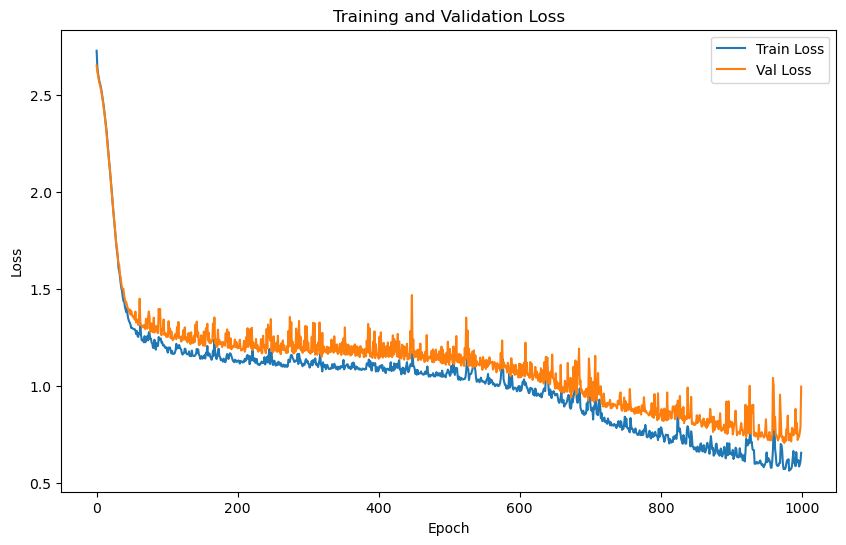

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.0847 | Test Accuracy: 51.55%


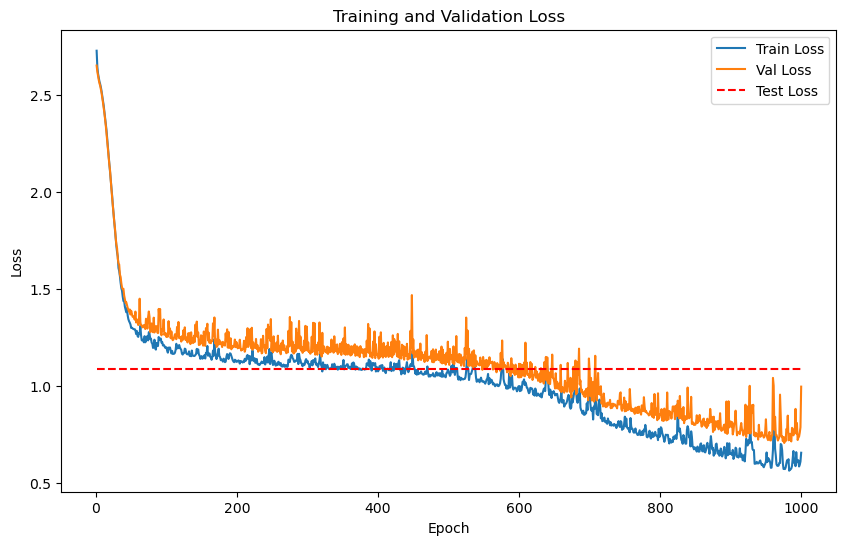

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 280 samples with 64 features each
LOG: Labels shape: (280,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2898 samples with 64 features each
LOG: Labels shape: (2898,)


Train embeddings shape: (280, 64), 
Train labels shape: (280,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (2898, 64), 
Test labels shape: (2898,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}
Training batch size: 280


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 7.8957
Epoch [1/2000], Avg Train Loss: 7.8957
Epoch [1/2000], Avg Val Loss: 3.5429
Validation loss improved from inf to 3.5429. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 7.8991
Epoch [2/2000], Avg Train Loss: 7.8991
Epoch [2/2000], Avg Val Loss: 3.5241
Validation loss improved from 3.5429 to 3.5241. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.7766
Epoch [3/2000], Avg Train Loss: 7.7766
Epoch [3/2000], Avg Val Loss: 3.5064
Validation loss improved from 3.5241 to 3.5064. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.7232
Epoch [4/2000], Avg Train Loss: 7.7232
Epoch [4/2000], Avg Val Loss: 3.4897
Validation loss improved from 3.5064 to 3.4897. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.6407
Epoch [5/2000], Avg Train Loss: 7.6407
Epoch [5/2000], Avg Val Loss: 3.4737
Validation loss improved from 3.4897 to 3.4737. Saving mode

    Batch [1/1], Train Loss: 6.7492
Epoch [15/2000], Avg Train Loss: 6.7492
Epoch [15/2000], Avg Val Loss: 3.3547
Validation loss improved from 3.3637 to 3.3547. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 6.8512
Epoch [16/2000], Avg Train Loss: 6.8512
Epoch [16/2000], Avg Val Loss: 3.3462
Validation loss improved from 3.3547 to 3.3462. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 6.8116
Epoch [17/2000], Avg Train Loss: 6.8116
Epoch [17/2000], Avg Val Loss: 3.3382
Validation loss improved from 3.3462 to 3.3382. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/1], Train Loss: 6.8136
Epoch [18/2000], Avg Train Loss: 6.8136
Epoch [18/2000], Avg Val Loss: 3.3307
Validation loss improved from 3.3382 to 3.3307. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/1], Train Loss: 6.6651
Epoch [19/2000], Avg Train Loss: 6.6651
Epoch [19/2000], Avg Val Loss: 3.3237
Validation loss improved from 3.3307 to 3.

    Batch [1/1], Train Loss: 6.5512
Epoch [23/2000], Avg Train Loss: 6.5512
Epoch [23/2000], Avg Val Loss: 3.3001
Validation loss improved from 3.3054 to 3.3001. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.4327
Epoch [24/2000], Avg Train Loss: 6.4327
Epoch [24/2000], Avg Val Loss: 3.2951
Validation loss improved from 3.3001 to 3.2951. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.3152
Epoch [25/2000], Avg Train Loss: 6.3152
Epoch [25/2000], Avg Val Loss: 3.2904
Validation loss improved from 3.2951 to 3.2904. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/1], Train Loss: 6.1603
Epoch [26/2000], Avg Train Loss: 6.1603
Epoch [26/2000], Avg Val Loss: 3.2859
Validation loss improved from 3.2904 to 3.2859. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 6.1787
Epoch [27/2000], Avg Train Loss: 6.1787
Epoch [27/2000], Avg Val Loss: 3.2818
Validation loss improved from 3.2859 to 3.

    Batch [1/1], Train Loss: 6.0226
Epoch [35/2000], Avg Train Loss: 6.0226
Epoch [35/2000], Avg Val Loss: 3.2572
Validation loss improved from 3.2596 to 3.2572. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/1], Train Loss: 5.8717
Epoch [36/2000], Avg Train Loss: 5.8717
Epoch [36/2000], Avg Val Loss: 3.2551
Validation loss improved from 3.2572 to 3.2551. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 5.8391
Epoch [37/2000], Avg Train Loss: 5.8391
Epoch [37/2000], Avg Val Loss: 3.2530
Validation loss improved from 3.2551 to 3.2530. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 5.7873
Epoch [38/2000], Avg Train Loss: 5.7873
Epoch [38/2000], Avg Val Loss: 3.2512
Validation loss improved from 3.2530 to 3.2512. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 5.8741
Epoch [39/2000], Avg Train Loss: 5.8741
Epoch [39/2000], Avg Val Loss: 3.2495
Validation loss improved from 3.2512 to 3.

    Batch [1/1], Train Loss: 5.5172
Epoch [50/2000], Avg Train Loss: 5.5172
Epoch [50/2000], Avg Val Loss: 3.2357
Validation loss improved from 3.2367 to 3.2357. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 5.5500
Epoch [51/2000], Avg Train Loss: 5.5500
Epoch [51/2000], Avg Val Loss: 3.2348
Validation loss improved from 3.2357 to 3.2348. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 5.5944
Epoch [52/2000], Avg Train Loss: 5.5944
Epoch [52/2000], Avg Val Loss: 3.2339
Validation loss improved from 3.2348 to 3.2339. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 5.5261
Epoch [53/2000], Avg Train Loss: 5.5261
Epoch [53/2000], Avg Val Loss: 3.2329
Validation loss improved from 3.2339 to 3.2329. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 5.5109
Epoch [54/2000], Avg Train Loss: 5.5109
Epoch [54/2000], Avg Val Loss: 3.2321
Validation loss improved from 3.2329 to 3.

    Batch [1/1], Train Loss: 5.4713
Epoch [55/2000], Avg Train Loss: 5.4713
Epoch [55/2000], Avg Val Loss: 3.2312
Validation loss improved from 3.2321 to 3.2312. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 5.4563
Epoch [56/2000], Avg Train Loss: 5.4563
Epoch [56/2000], Avg Val Loss: 3.2303
Validation loss improved from 3.2312 to 3.2303. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 5.3732
Epoch [57/2000], Avg Train Loss: 5.3732
Epoch [57/2000], Avg Val Loss: 3.2293
Validation loss improved from 3.2303 to 3.2293. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 5.4272
Epoch [58/2000], Avg Train Loss: 5.4272
Epoch [58/2000], Avg Val Loss: 3.2284
Validation loss improved from 3.2293 to 3.2284. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/1], Train Loss: 5.3383
Epoch [59/2000], Avg Train Loss: 5.3383
Epoch [59/2000], Avg Val Loss: 3.2275
Validation loss improved from 3.2284 to 3.

Epoch [70/2000], Avg Val Loss: 3.2168
Validation loss improved from 3.2177 to 3.2168. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.2029
Epoch [71/2000], Avg Train Loss: 5.2029
Epoch [71/2000], Avg Val Loss: 3.2157
Validation loss improved from 3.2168 to 3.2157. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.2639
Epoch [72/2000], Avg Train Loss: 5.2639
Epoch [72/2000], Avg Val Loss: 3.2147
Validation loss improved from 3.2157 to 3.2147. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.2040
Epoch [73/2000], Avg Train Loss: 5.2040
Epoch [73/2000], Avg Val Loss: 3.2137
Validation loss improved from 3.2147 to 3.2137. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 5.2035
Epoch [74/2000], Avg Train Loss: 5.2035
Epoch [74/2000], Avg Val Loss: 3.2126
Validation loss improved from 3.2137 to 3.2126. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.0895
Epoch [86/2000], Avg Train Loss: 5.0895
Epoch [86/2000], Avg Val Loss: 3.1992
Validation loss improved from 3.2004 to 3.1992. Saving model...

LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 5.1328
Epoch [87/2000], Avg Train Loss: 5.1328
Epoch [87/2000], Avg Val Loss: 3.1980
Validation loss improved from 3.1992 to 3.1980. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 5.1493
Epoch [88/2000], Avg Train Loss: 5.1493
Epoch [88/2000], Avg Val Loss: 3.1968
Validation loss improved from 3.1980 to 3.1968. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 5.1241
Epoch [89/2000], Avg Train Loss: 5.1241
Epoch [89/2000], Avg Val Loss: 3.1956
Validation loss improved from 3.1968 to 3.1956. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 5.0958
Epoch [90/2000], Avg Train Loss: 5.0958
Epoch [90/2000], Avg Val Loss: 3.1944
Validation loss improved from 3.1956 to 3.

Epoch [93/2000], Avg Val Loss: 3.1908
Validation loss improved from 3.1920 to 3.1908. Saving model...

LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 5.0900
Epoch [94/2000], Avg Train Loss: 5.0900
Epoch [94/2000], Avg Val Loss: 3.1897
Validation loss improved from 3.1908 to 3.1897. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 5.0676
Epoch [95/2000], Avg Train Loss: 5.0676
Epoch [95/2000], Avg Val Loss: 3.1885
Validation loss improved from 3.1897 to 3.1885. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 5.1352
Epoch [96/2000], Avg Train Loss: 5.1352
Epoch [96/2000], Avg Val Loss: 3.1873
Validation loss improved from 3.1885 to 3.1873. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 5.0670
Epoch [97/2000], Avg Train Loss: 5.0670
Epoch [97/2000], Avg Val Loss: 3.1861
Validation loss improved from 3.1873 to 3.1861. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Trai

Epoch [103/2000], Avg Val Loss: 3.1785
Validation loss improved from 3.1797 to 3.1785. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 5.0304
Epoch [104/2000], Avg Train Loss: 5.0304
Epoch [104/2000], Avg Val Loss: 3.1772
Validation loss improved from 3.1785 to 3.1772. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 5.0542
Epoch [105/2000], Avg Train Loss: 5.0542
Epoch [105/2000], Avg Val Loss: 3.1760
Validation loss improved from 3.1772 to 3.1760. Saving model...

LOG: Epoch [106/2000] - Training
    Batch [1/1], Train Loss: 5.0352
Epoch [106/2000], Avg Train Loss: 5.0352
Epoch [106/2000], Avg Val Loss: 3.1747
Validation loss improved from 3.1760 to 3.1747. Saving model...

LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 5.0499
Epoch [107/2000], Avg Train Loss: 5.0499
Epoch [107/2000], Avg Val Loss: 3.1734
Validation loss improved from 3.1747 to 3.1734. Saving model...

LOG: Epoch [108/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.9766
Epoch [120/2000], Avg Train Loss: 4.9766
Epoch [120/2000], Avg Val Loss: 3.1553
Validation loss improved from 3.1567 to 3.1553. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 4.9599
Epoch [121/2000], Avg Train Loss: 4.9599
Epoch [121/2000], Avg Val Loss: 3.1538
Validation loss improved from 3.1553 to 3.1538. Saving model...

LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 4.9620
Epoch [122/2000], Avg Train Loss: 4.9620
Epoch [122/2000], Avg Val Loss: 3.1524
Validation loss improved from 3.1538 to 3.1524. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 4.9370
Epoch [123/2000], Avg Train Loss: 4.9370
Epoch [123/2000], Avg Val Loss: 3.1509
Validation loss improved from 3.1524 to 3.1509. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 4.9604
Epoch [124/2000], Avg Train Loss: 4.9604
Epoch [124/2000], Avg Val Loss: 3.1494
Validation loss improved fro

Epoch [127/2000], Avg Val Loss: 3.1450
Validation loss improved from 3.1465 to 3.1450. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 4.8964
Epoch [128/2000], Avg Train Loss: 4.8964
Epoch [128/2000], Avg Val Loss: 3.1435
Validation loss improved from 3.1450 to 3.1435. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/1], Train Loss: 4.9123
Epoch [129/2000], Avg Train Loss: 4.9123
Epoch [129/2000], Avg Val Loss: 3.1420
Validation loss improved from 3.1435 to 3.1420. Saving model...

LOG: Epoch [130/2000] - Training
    Batch [1/1], Train Loss: 4.9317
Epoch [130/2000], Avg Train Loss: 4.9317
Epoch [130/2000], Avg Val Loss: 3.1405
Validation loss improved from 3.1420 to 3.1405. Saving model...

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 4.9343
Epoch [131/2000], Avg Train Loss: 4.9343
Epoch [131/2000], Avg Val Loss: 3.1391
Validation loss improved from 3.1405 to 3.1391. Saving model...

LOG: Epoch [132/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.8497
Epoch [138/2000], Avg Train Loss: 4.8497
Epoch [138/2000], Avg Val Loss: 3.1290
Validation loss improved from 3.1305 to 3.1290. Saving model...

LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 4.9307
Epoch [139/2000], Avg Train Loss: 4.9307
Epoch [139/2000], Avg Val Loss: 3.1276
Validation loss improved from 3.1290 to 3.1276. Saving model...

LOG: Epoch [140/2000] - Training
    Batch [1/1], Train Loss: 4.8709
Epoch [140/2000], Avg Train Loss: 4.8709
Epoch [140/2000], Avg Val Loss: 3.1261
Validation loss improved from 3.1276 to 3.1261. Saving model...

LOG: Epoch [141/2000] - Training
    Batch [1/1], Train Loss: 4.8583
Epoch [141/2000], Avg Train Loss: 4.8583
Epoch [141/2000], Avg Val Loss: 3.1246
Validation loss improved from 3.1261 to 3.1246. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 4.8859
Epoch [142/2000], Avg Train Loss: 4.8859
Epoch [142/2000], Avg Val Loss: 3.1231
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8440
Epoch [155/2000], Avg Train Loss: 4.8440
Epoch [155/2000], Avg Val Loss: 3.1032
Validation loss improved from 3.1047 to 3.1032. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 4.8033
Epoch [156/2000], Avg Train Loss: 4.8033
Epoch [156/2000], Avg Val Loss: 3.1016
Validation loss improved from 3.1032 to 3.1016. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 4.7836
Epoch [157/2000], Avg Train Loss: 4.7836
Epoch [157/2000], Avg Val Loss: 3.1000
Validation loss improved from 3.1016 to 3.1000. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 4.8433
Epoch [158/2000], Avg Train Loss: 4.8433
Epoch [158/2000], Avg Val Loss: 3.0985
Validation loss improved from 3.1000 to 3.0985. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/1], Train Loss: 4.8390
Epoch [159/2000], Avg Train Loss: 4.8390
Epoch [159/2000], Avg Val Loss: 3.0970
Validation loss improved fro

    Batch [1/1], Train Loss: 4.8161
Epoch [162/2000], Avg Train Loss: 4.8161
Epoch [162/2000], Avg Val Loss: 3.0924
Validation loss improved from 3.0939 to 3.0924. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 4.8118
Epoch [163/2000], Avg Train Loss: 4.8118
Epoch [163/2000], Avg Val Loss: 3.0909
Validation loss improved from 3.0924 to 3.0909. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 4.7751
Epoch [164/2000], Avg Train Loss: 4.7751
Epoch [164/2000], Avg Val Loss: 3.0894
Validation loss improved from 3.0909 to 3.0894. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 4.7918
Epoch [165/2000], Avg Train Loss: 4.7918
Epoch [165/2000], Avg Val Loss: 3.0878
Validation loss improved from 3.0894 to 3.0878. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/1], Train Loss: 4.7964
Epoch [166/2000], Avg Train Loss: 4.7964
Epoch [166/2000], Avg Val Loss: 3.0863
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7822
Epoch [171/2000], Avg Train Loss: 4.7822
Epoch [171/2000], Avg Val Loss: 3.0788
Validation loss improved from 3.0803 to 3.0788. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 4.7578
Epoch [172/2000], Avg Train Loss: 4.7578
Epoch [172/2000], Avg Val Loss: 3.0773
Validation loss improved from 3.0788 to 3.0773. Saving model...

LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 4.7438
Epoch [173/2000], Avg Train Loss: 4.7438
Epoch [173/2000], Avg Val Loss: 3.0759
Validation loss improved from 3.0773 to 3.0759. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 4.7509
Epoch [174/2000], Avg Train Loss: 4.7509
Epoch [174/2000], Avg Val Loss: 3.0744
Validation loss improved from 3.0759 to 3.0744. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 4.7976
Epoch [175/2000], Avg Train Loss: 4.7976
Epoch [175/2000], Avg Val Loss: 3.0729
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7528
Epoch [190/2000], Avg Train Loss: 4.7528
Epoch [190/2000], Avg Val Loss: 3.0509
Validation loss improved from 3.0524 to 3.0509. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 4.7481
Epoch [191/2000], Avg Train Loss: 4.7481
Epoch [191/2000], Avg Val Loss: 3.0495
Validation loss improved from 3.0509 to 3.0495. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 4.7070
Epoch [192/2000], Avg Train Loss: 4.7070
Epoch [192/2000], Avg Val Loss: 3.0480
Validation loss improved from 3.0495 to 3.0480. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 4.7274
Epoch [193/2000], Avg Train Loss: 4.7274
Epoch [193/2000], Avg Val Loss: 3.0465
Validation loss improved from 3.0480 to 3.0465. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 4.7176
Epoch [194/2000], Avg Train Loss: 4.7176
Epoch [194/2000], Avg Val Loss: 3.0450
Validation loss improved fro

    Batch [1/1], Train Loss: 4.7211
Epoch [197/2000], Avg Train Loss: 4.7211
Epoch [197/2000], Avg Val Loss: 3.0405
Validation loss improved from 3.0420 to 3.0405. Saving model...

LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 4.7387
Epoch [198/2000], Avg Train Loss: 4.7387
Epoch [198/2000], Avg Val Loss: 3.0390
Validation loss improved from 3.0405 to 3.0390. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 4.7091
Epoch [199/2000], Avg Train Loss: 4.7091
Epoch [199/2000], Avg Val Loss: 3.0375
Validation loss improved from 3.0390 to 3.0375. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 4.7153
Epoch [200/2000], Avg Train Loss: 4.7153
Epoch [200/2000], Avg Val Loss: 3.0360
Validation loss improved from 3.0375 to 3.0360. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 4.7058
Epoch [201/2000], Avg Train Loss: 4.7058
Epoch [201/2000], Avg Val Loss: 3.0345
Validation loss improved fro

Epoch [203/2000], Avg Val Loss: 3.0316
Validation loss improved from 3.0331 to 3.0316. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/1], Train Loss: 4.6812
Epoch [204/2000], Avg Train Loss: 4.6812
Epoch [204/2000], Avg Val Loss: 3.0302
Validation loss improved from 3.0316 to 3.0302. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 4.6858
Epoch [205/2000], Avg Train Loss: 4.6858
Epoch [205/2000], Avg Val Loss: 3.0287
Validation loss improved from 3.0302 to 3.0287. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 4.7318
Epoch [206/2000], Avg Train Loss: 4.7318
Epoch [206/2000], Avg Val Loss: 3.0273
Validation loss improved from 3.0287 to 3.0273. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 4.6965
Epoch [207/2000], Avg Train Loss: 4.6965
Epoch [207/2000], Avg Val Loss: 3.0259
Validation loss improved from 3.0273 to 3.0259. Saving model...

LOG: Epoch [208/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6508
Epoch [227/2000], Avg Train Loss: 4.6508
Epoch [227/2000], Avg Val Loss: 2.9978
Validation loss improved from 2.9991 to 2.9978. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 4.6606
Epoch [228/2000], Avg Train Loss: 4.6606
Epoch [228/2000], Avg Val Loss: 2.9965
Validation loss improved from 2.9978 to 2.9965. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 4.6511
Epoch [229/2000], Avg Train Loss: 4.6511
Epoch [229/2000], Avg Val Loss: 2.9951
Validation loss improved from 2.9965 to 2.9951. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 4.7107
Epoch [230/2000], Avg Train Loss: 4.7107
Epoch [230/2000], Avg Val Loss: 2.9938
Validation loss improved from 2.9951 to 2.9938. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 4.6675
Epoch [231/2000], Avg Train Loss: 4.6675
Epoch [231/2000], Avg Val Loss: 2.9925
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6435
Epoch [235/2000], Avg Train Loss: 4.6435
Epoch [235/2000], Avg Val Loss: 2.9869
Validation loss improved from 2.9883 to 2.9869. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 4.6484
Epoch [236/2000], Avg Train Loss: 4.6484
Epoch [236/2000], Avg Val Loss: 2.9855
Validation loss improved from 2.9869 to 2.9855. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 4.6758
Epoch [237/2000], Avg Train Loss: 4.6758
Epoch [237/2000], Avg Val Loss: 2.9842
Validation loss improved from 2.9855 to 2.9842. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 4.6262
Epoch [238/2000], Avg Train Loss: 4.6262
Epoch [238/2000], Avg Val Loss: 2.9828
Validation loss improved from 2.9842 to 2.9828. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 4.6157
Epoch [239/2000], Avg Train Loss: 4.6157
Epoch [239/2000], Avg Val Loss: 2.9814
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5937
Epoch [264/2000], Avg Train Loss: 4.5937
Epoch [264/2000], Avg Val Loss: 2.9484
Validation loss improved from 2.9498 to 2.9484. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 4.5539
Epoch [265/2000], Avg Train Loss: 4.5539
Epoch [265/2000], Avg Val Loss: 2.9471
Validation loss improved from 2.9484 to 2.9471. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 4.5858
Epoch [266/2000], Avg Train Loss: 4.5858
Epoch [266/2000], Avg Val Loss: 2.9458
Validation loss improved from 2.9471 to 2.9458. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 4.6034
Epoch [267/2000], Avg Train Loss: 4.6034
Epoch [267/2000], Avg Val Loss: 2.9445
Validation loss improved from 2.9458 to 2.9445. Saving model...

LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 4.5955
Epoch [268/2000], Avg Train Loss: 4.5955
Epoch [268/2000], Avg Val Loss: 2.9433
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6305
Epoch [272/2000], Avg Train Loss: 4.6305
Epoch [272/2000], Avg Val Loss: 2.9384
Validation loss improved from 2.9396 to 2.9384. Saving model...

LOG: Epoch [273/2000] - Training
    Batch [1/1], Train Loss: 4.5510
Epoch [273/2000], Avg Train Loss: 4.5510
Epoch [273/2000], Avg Val Loss: 2.9371
Validation loss improved from 2.9384 to 2.9371. Saving model...

LOG: Epoch [274/2000] - Training
    Batch [1/1], Train Loss: 4.5713
Epoch [274/2000], Avg Train Loss: 4.5713
Epoch [274/2000], Avg Val Loss: 2.9359
Validation loss improved from 2.9371 to 2.9359. Saving model...

LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 4.5824
Epoch [275/2000], Avg Train Loss: 4.5824
Epoch [275/2000], Avg Val Loss: 2.9347
Validation loss improved from 2.9359 to 2.9347. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 4.5294
Epoch [276/2000], Avg Train Loss: 4.5294
Epoch [276/2000], Avg Val Loss: 2.9334
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5477
Epoch [300/2000], Avg Train Loss: 4.5477
Epoch [300/2000], Avg Val Loss: 2.9024
Validation loss improved from 2.9037 to 2.9024. Saving model...

LOG: Epoch [301/2000] - Training
    Batch [1/1], Train Loss: 4.5083
Epoch [301/2000], Avg Train Loss: 4.5083
Epoch [301/2000], Avg Val Loss: 2.9011
Validation loss improved from 2.9024 to 2.9011. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 4.5035
Epoch [302/2000], Avg Train Loss: 4.5035
Epoch [302/2000], Avg Val Loss: 2.8999
Validation loss improved from 2.9011 to 2.8999. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 4.5106
Epoch [303/2000], Avg Train Loss: 4.5106
Epoch [303/2000], Avg Val Loss: 2.8986
Validation loss improved from 2.8999 to 2.8986. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 4.5108
Epoch [304/2000], Avg Train Loss: 4.5108
Epoch [304/2000], Avg Val Loss: 2.8973
Validation loss improved fro

Epoch [310/2000], Avg Val Loss: 2.8895
Validation loss improved from 2.8908 to 2.8895. Saving model...

LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 4.4907
Epoch [311/2000], Avg Train Loss: 4.4907
Epoch [311/2000], Avg Val Loss: 2.8883
Validation loss improved from 2.8895 to 2.8883. Saving model...

LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 4.5254
Epoch [312/2000], Avg Train Loss: 4.5254
Epoch [312/2000], Avg Val Loss: 2.8870
Validation loss improved from 2.8883 to 2.8870. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/1], Train Loss: 4.5047
Epoch [313/2000], Avg Train Loss: 4.5047
Epoch [313/2000], Avg Val Loss: 2.8857
Validation loss improved from 2.8870 to 2.8857. Saving model...

LOG: Epoch [314/2000] - Training
    Batch [1/1], Train Loss: 4.5239
Epoch [314/2000], Avg Train Loss: 4.5239
Epoch [314/2000], Avg Val Loss: 2.8845
Validation loss improved from 2.8857 to 2.8845. Saving model...

LOG: Epoch [315/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4878
Epoch [336/2000], Avg Train Loss: 4.4878
Epoch [336/2000], Avg Val Loss: 2.8575
Validation loss improved from 2.8587 to 2.8575. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 4.4662
Epoch [337/2000], Avg Train Loss: 4.4662
Epoch [337/2000], Avg Val Loss: 2.8563
Validation loss improved from 2.8575 to 2.8563. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 4.4576
Epoch [338/2000], Avg Train Loss: 4.4576
Epoch [338/2000], Avg Val Loss: 2.8551
Validation loss improved from 2.8563 to 2.8551. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 4.4983
Epoch [339/2000], Avg Train Loss: 4.4983
Epoch [339/2000], Avg Val Loss: 2.8540
Validation loss improved from 2.8551 to 2.8540. Saving model...

LOG: Epoch [340/2000] - Training
    Batch [1/1], Train Loss: 4.4473
Epoch [340/2000], Avg Train Loss: 4.4473
Epoch [340/2000], Avg Val Loss: 2.8528
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4537
Epoch [347/2000], Avg Train Loss: 4.4537
Epoch [347/2000], Avg Val Loss: 2.8443
Validation loss improved from 2.8455 to 2.8443. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 4.4609
Epoch [348/2000], Avg Train Loss: 4.4609
Epoch [348/2000], Avg Val Loss: 2.8431
Validation loss improved from 2.8443 to 2.8431. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 4.4490
Epoch [349/2000], Avg Train Loss: 4.4490
Epoch [349/2000], Avg Val Loss: 2.8420
Validation loss improved from 2.8431 to 2.8420. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 4.4273
Epoch [350/2000], Avg Train Loss: 4.4273
Epoch [350/2000], Avg Val Loss: 2.8408
Validation loss improved from 2.8420 to 2.8408. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 4.4063
Epoch [351/2000], Avg Train Loss: 4.4063
Epoch [351/2000], Avg Val Loss: 2.8395
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3856
Epoch [373/2000], Avg Train Loss: 4.3856
Epoch [373/2000], Avg Val Loss: 2.8137
Validation loss improved from 2.8148 to 2.8137. Saving model...

LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 4.4207
Epoch [374/2000], Avg Train Loss: 4.4207
Epoch [374/2000], Avg Val Loss: 2.8125
Validation loss improved from 2.8137 to 2.8125. Saving model...

LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 4.3734
Epoch [375/2000], Avg Train Loss: 4.3734
Epoch [375/2000], Avg Val Loss: 2.8114
Validation loss improved from 2.8125 to 2.8114. Saving model...

LOG: Epoch [376/2000] - Training
    Batch [1/1], Train Loss: 4.3904
Epoch [376/2000], Avg Train Loss: 4.3904
Epoch [376/2000], Avg Val Loss: 2.8102
Validation loss improved from 2.8114 to 2.8102. Saving model...

LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 4.4130
Epoch [377/2000], Avg Train Loss: 4.4130
Epoch [377/2000], Avg Val Loss: 2.8091
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4080
Epoch [384/2000], Avg Train Loss: 4.4080
Epoch [384/2000], Avg Val Loss: 2.8014
Validation loss improved from 2.8025 to 2.8014. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 4.3834
Epoch [385/2000], Avg Train Loss: 4.3834
Epoch [385/2000], Avg Val Loss: 2.8003
Validation loss improved from 2.8014 to 2.8003. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 4.3683
Epoch [386/2000], Avg Train Loss: 4.3683
Epoch [386/2000], Avg Val Loss: 2.7991
Validation loss improved from 2.8003 to 2.7991. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 4.4214
Epoch [387/2000], Avg Train Loss: 4.4214
Epoch [387/2000], Avg Val Loss: 2.7980
Validation loss improved from 2.7991 to 2.7980. Saving model...

LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 4.4157
Epoch [388/2000], Avg Train Loss: 4.4157
Epoch [388/2000], Avg Val Loss: 2.7969
Validation loss improved fro

Epoch [410/2000], Avg Val Loss: 2.7715
Validation loss improved from 2.7726 to 2.7715. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 4.3648
Epoch [411/2000], Avg Train Loss: 4.3648
Epoch [411/2000], Avg Val Loss: 2.7704
Validation loss improved from 2.7715 to 2.7704. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/1], Train Loss: 4.3670
Epoch [412/2000], Avg Train Loss: 4.3670
Epoch [412/2000], Avg Val Loss: 2.7693
Validation loss improved from 2.7704 to 2.7693. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/1], Train Loss: 4.3255
Epoch [413/2000], Avg Train Loss: 4.3255
Epoch [413/2000], Avg Val Loss: 2.7682
Validation loss improved from 2.7693 to 2.7682. Saving model...

LOG: Epoch [414/2000] - Training
    Batch [1/1], Train Loss: 4.3473
Epoch [414/2000], Avg Train Loss: 4.3473
Epoch [414/2000], Avg Val Loss: 2.7670
Validation loss improved from 2.7682 to 2.7670. Saving model...

LOG: Epoch [415/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3461
Epoch [424/2000], Avg Train Loss: 4.3461
Epoch [424/2000], Avg Val Loss: 2.7561
Validation loss improved from 2.7571 to 2.7561. Saving model...

LOG: Epoch [425/2000] - Training
    Batch [1/1], Train Loss: 4.3368
Epoch [425/2000], Avg Train Loss: 4.3368
Epoch [425/2000], Avg Val Loss: 2.7551
Validation loss improved from 2.7561 to 2.7551. Saving model...

LOG: Epoch [426/2000] - Training
    Batch [1/1], Train Loss: 4.3613
Epoch [426/2000], Avg Train Loss: 4.3613
Epoch [426/2000], Avg Val Loss: 2.7540
Validation loss improved from 2.7551 to 2.7540. Saving model...

LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 4.3041
Epoch [427/2000], Avg Train Loss: 4.3041
Epoch [427/2000], Avg Val Loss: 2.7530
Validation loss improved from 2.7540 to 2.7530. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 4.3450
Epoch [428/2000], Avg Train Loss: 4.3450
Epoch [428/2000], Avg Val Loss: 2.7520
Validation loss improved fro

Epoch [447/2000], Avg Val Loss: 2.7328
Validation loss improved from 2.7338 to 2.7328. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 4.3195
Epoch [448/2000], Avg Train Loss: 4.3195
Epoch [448/2000], Avg Val Loss: 2.7318
Validation loss improved from 2.7328 to 2.7318. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 4.3029
Epoch [449/2000], Avg Train Loss: 4.3029
Epoch [449/2000], Avg Val Loss: 2.7308
Validation loss improved from 2.7318 to 2.7308. Saving model...

LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 4.2746
Epoch [450/2000], Avg Train Loss: 4.2746
Epoch [450/2000], Avg Val Loss: 2.7299
Validation loss improved from 2.7308 to 2.7299. Saving model...

LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 4.3417
Epoch [451/2000], Avg Train Loss: 4.3417
Epoch [451/2000], Avg Val Loss: 2.7289
Validation loss improved from 2.7299 to 2.7289. Saving model...

LOG: Epoch [452/2000] - Training
    Bat

Epoch [459/2000], Avg Val Loss: 2.7214
Validation loss improved from 2.7223 to 2.7214. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/1], Train Loss: 4.3103
Epoch [460/2000], Avg Train Loss: 4.3103
Epoch [460/2000], Avg Val Loss: 2.7204
Validation loss improved from 2.7214 to 2.7204. Saving model...

LOG: Epoch [461/2000] - Training
    Batch [1/1], Train Loss: 4.2830
Epoch [461/2000], Avg Train Loss: 4.2830
Epoch [461/2000], Avg Val Loss: 2.7194
Validation loss improved from 2.7204 to 2.7194. Saving model...

LOG: Epoch [462/2000] - Training
    Batch [1/1], Train Loss: 4.3100
Epoch [462/2000], Avg Train Loss: 4.3100
Epoch [462/2000], Avg Val Loss: 2.7184
Validation loss improved from 2.7194 to 2.7184. Saving model...

LOG: Epoch [463/2000] - Training
    Batch [1/1], Train Loss: 4.2932
Epoch [463/2000], Avg Train Loss: 4.2932
Epoch [463/2000], Avg Val Loss: 2.7174
Validation loss improved from 2.7184 to 2.7174. Saving model...

LOG: Epoch [464/2000] - Training
    Bat

Epoch [484/2000], Avg Val Loss: 2.6958
Validation loss improved from 2.6967 to 2.6958. Saving model...

LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 4.2841
Epoch [485/2000], Avg Train Loss: 4.2841
Epoch [485/2000], Avg Val Loss: 2.6949
Validation loss improved from 2.6958 to 2.6949. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 4.2350
Epoch [486/2000], Avg Train Loss: 4.2350
Epoch [486/2000], Avg Val Loss: 2.6939
Validation loss improved from 2.6949 to 2.6939. Saving model...

LOG: Epoch [487/2000] - Training
    Batch [1/1], Train Loss: 4.2983
Epoch [487/2000], Avg Train Loss: 4.2983
Epoch [487/2000], Avg Val Loss: 2.6930
Validation loss improved from 2.6939 to 2.6930. Saving model...

LOG: Epoch [488/2000] - Training
    Batch [1/1], Train Loss: 4.2875
Epoch [488/2000], Avg Train Loss: 4.2875
Epoch [488/2000], Avg Val Loss: 2.6921
Validation loss improved from 2.6930 to 2.6921. Saving model...

LOG: Epoch [489/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.2171
Epoch [496/2000], Avg Train Loss: 4.2171
Epoch [496/2000], Avg Val Loss: 2.6849
Validation loss improved from 2.6858 to 2.6849. Saving model...

LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 4.2036
Epoch [497/2000], Avg Train Loss: 4.2036
Epoch [497/2000], Avg Val Loss: 2.6840
Validation loss improved from 2.6849 to 2.6840. Saving model...

LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 4.2498
Epoch [498/2000], Avg Train Loss: 4.2498
Epoch [498/2000], Avg Val Loss: 2.6831
Validation loss improved from 2.6840 to 2.6831. Saving model...

LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 4.2618
Epoch [499/2000], Avg Train Loss: 4.2618
Epoch [499/2000], Avg Val Loss: 2.6822
Validation loss improved from 2.6831 to 2.6822. Saving model...

LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 4.2388
Epoch [500/2000], Avg Train Loss: 4.2388
Epoch [500/2000], Avg Val Loss: 2.6813
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2426
Epoch [516/2000], Avg Train Loss: 4.2426
Epoch [516/2000], Avg Val Loss: 2.6680
Validation loss improved from 2.6688 to 2.6680. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 4.2355
Epoch [517/2000], Avg Train Loss: 4.2355
Epoch [517/2000], Avg Val Loss: 2.6672
Validation loss improved from 2.6680 to 2.6672. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 4.2190
Epoch [518/2000], Avg Train Loss: 4.2190
Epoch [518/2000], Avg Val Loss: 2.6663
Validation loss improved from 2.6672 to 2.6663. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 4.2108
Epoch [519/2000], Avg Train Loss: 4.2108
Epoch [519/2000], Avg Val Loss: 2.6655
Validation loss improved from 2.6663 to 2.6655. Saving model...

LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 4.2132
Epoch [520/2000], Avg Train Loss: 4.2132
Epoch [520/2000], Avg Val Loss: 2.6646
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2311
Epoch [529/2000], Avg Train Loss: 4.2311
Epoch [529/2000], Avg Val Loss: 2.6568
Validation loss improved from 2.6577 to 2.6568. Saving model...

LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 4.2034
Epoch [530/2000], Avg Train Loss: 4.2034
Epoch [530/2000], Avg Val Loss: 2.6560
Validation loss improved from 2.6568 to 2.6560. Saving model...

LOG: Epoch [531/2000] - Training
    Batch [1/1], Train Loss: 4.2135
Epoch [531/2000], Avg Train Loss: 4.2135
Epoch [531/2000], Avg Val Loss: 2.6551
Validation loss improved from 2.6560 to 2.6551. Saving model...

LOG: Epoch [532/2000] - Training
    Batch [1/1], Train Loss: 4.1773
Epoch [532/2000], Avg Train Loss: 4.1773
Epoch [532/2000], Avg Val Loss: 2.6543
Validation loss improved from 2.6551 to 2.6543. Saving model...

LOG: Epoch [533/2000] - Training
    Batch [1/1], Train Loss: 4.2330
Epoch [533/2000], Avg Train Loss: 4.2330
Epoch [533/2000], Avg Val Loss: 2.6534
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2005
Epoch [548/2000], Avg Train Loss: 4.2005
Epoch [548/2000], Avg Val Loss: 2.6410
Validation loss improved from 2.6417 to 2.6410. Saving model...

LOG: Epoch [549/2000] - Training
    Batch [1/1], Train Loss: 4.1956
Epoch [549/2000], Avg Train Loss: 4.1956
Epoch [549/2000], Avg Val Loss: 2.6402
Validation loss improved from 2.6410 to 2.6402. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/1], Train Loss: 4.2028
Epoch [550/2000], Avg Train Loss: 4.2028
Epoch [550/2000], Avg Val Loss: 2.6394
Validation loss improved from 2.6402 to 2.6394. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/1], Train Loss: 4.1414
Epoch [551/2000], Avg Train Loss: 4.1414
Epoch [551/2000], Avg Val Loss: 2.6386
Validation loss improved from 2.6394 to 2.6386. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/1], Train Loss: 4.1910
Epoch [552/2000], Avg Train Loss: 4.1910
Epoch [552/2000], Avg Val Loss: 2.6378
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1275
Epoch [564/2000], Avg Train Loss: 4.1275
Epoch [564/2000], Avg Val Loss: 2.6280
Validation loss improved from 2.6288 to 2.6280. Saving model...

LOG: Epoch [565/2000] - Training
    Batch [1/1], Train Loss: 4.1795
Epoch [565/2000], Avg Train Loss: 4.1795
Epoch [565/2000], Avg Val Loss: 2.6272
Validation loss improved from 2.6280 to 2.6272. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/1], Train Loss: 4.1951
Epoch [566/2000], Avg Train Loss: 4.1951
Epoch [566/2000], Avg Val Loss: 2.6264
Validation loss improved from 2.6272 to 2.6264. Saving model...

LOG: Epoch [567/2000] - Training
    Batch [1/1], Train Loss: 4.1181
Epoch [567/2000], Avg Train Loss: 4.1181
Epoch [567/2000], Avg Val Loss: 2.6256
Validation loss improved from 2.6264 to 2.6256. Saving model...

LOG: Epoch [568/2000] - Training
    Batch [1/1], Train Loss: 4.1598
Epoch [568/2000], Avg Train Loss: 4.1598
Epoch [568/2000], Avg Val Loss: 2.6248
Validation loss improved fro

Epoch [579/2000], Avg Val Loss: 2.6167
Validation loss improved from 2.6174 to 2.6167. Saving model...

LOG: Epoch [580/2000] - Training
    Batch [1/1], Train Loss: 4.0832
Epoch [580/2000], Avg Train Loss: 4.0832
Epoch [580/2000], Avg Val Loss: 2.6160
Validation loss improved from 2.6167 to 2.6160. Saving model...

LOG: Epoch [581/2000] - Training
    Batch [1/1], Train Loss: 4.1210
Epoch [581/2000], Avg Train Loss: 4.1210
Epoch [581/2000], Avg Val Loss: 2.6153
Validation loss improved from 2.6160 to 2.6153. Saving model...

LOG: Epoch [582/2000] - Training
    Batch [1/1], Train Loss: 4.1231
Epoch [582/2000], Avg Train Loss: 4.1231
Epoch [582/2000], Avg Val Loss: 2.6146
Validation loss improved from 2.6153 to 2.6146. Saving model...

LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 4.0908
Epoch [583/2000], Avg Train Loss: 4.0908
Epoch [583/2000], Avg Val Loss: 2.6139
Validation loss improved from 2.6146 to 2.6139. Saving model...

LOG: Epoch [584/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1446
Epoch [594/2000], Avg Train Loss: 4.1446
Epoch [594/2000], Avg Val Loss: 2.6064
Validation loss improved from 2.6071 to 2.6064. Saving model...

LOG: Epoch [595/2000] - Training
    Batch [1/1], Train Loss: 4.0903
Epoch [595/2000], Avg Train Loss: 4.0903
Epoch [595/2000], Avg Val Loss: 2.6058
Validation loss improved from 2.6064 to 2.6058. Saving model...

LOG: Epoch [596/2000] - Training
    Batch [1/1], Train Loss: 4.1311
Epoch [596/2000], Avg Train Loss: 4.1311
Epoch [596/2000], Avg Val Loss: 2.6051
Validation loss improved from 2.6058 to 2.6051. Saving model...

LOG: Epoch [597/2000] - Training
    Batch [1/1], Train Loss: 4.0920
Epoch [597/2000], Avg Train Loss: 4.0920
Epoch [597/2000], Avg Val Loss: 2.6044
Validation loss improved from 2.6051 to 2.6044. Saving model...

LOG: Epoch [598/2000] - Training
    Batch [1/1], Train Loss: 4.1159
Epoch [598/2000], Avg Train Loss: 4.1159
Epoch [598/2000], Avg Val Loss: 2.6038
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0749
Epoch [614/2000], Avg Train Loss: 4.0749
Epoch [614/2000], Avg Val Loss: 2.5926
Validation loss improved from 2.5933 to 2.5926. Saving model...

LOG: Epoch [615/2000] - Training
    Batch [1/1], Train Loss: 4.1087
Epoch [615/2000], Avg Train Loss: 4.1087
Epoch [615/2000], Avg Val Loss: 2.5918
Validation loss improved from 2.5926 to 2.5918. Saving model...

LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 4.1037
Epoch [616/2000], Avg Train Loss: 4.1037
Epoch [616/2000], Avg Val Loss: 2.5912
Validation loss improved from 2.5918 to 2.5912. Saving model...

LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 4.1188
Epoch [617/2000], Avg Train Loss: 4.1188
Epoch [617/2000], Avg Val Loss: 2.5905
Validation loss improved from 2.5912 to 2.5905. Saving model...

LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 4.1011
Epoch [618/2000], Avg Train Loss: 4.1011
Epoch [618/2000], Avg Val Loss: 2.5898
Validation loss improved from 2.5905 to 2.5898. Saving model...

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 4.1050
Epoch [619/2000], Avg Train Loss: 4.1050
Epoch [619/2000], Avg Val Loss: 2.5892
Validation loss improved from 2.5898 to 2.5892. Saving model...

LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 4.0684
Epoch [620/2000], Avg Train Loss: 4.0684
Epoch [620/2000], Avg Val Loss: 2.5885
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0754
Epoch [633/2000], Avg Train Loss: 4.0754
Epoch [633/2000], Avg Val Loss: 2.5792
Validation loss improved from 2.5799 to 2.5792. Saving model...

LOG: Epoch [634/2000] - Training
    Batch [1/1], Train Loss: 4.1243
Epoch [634/2000], Avg Train Loss: 4.1243
Epoch [634/2000], Avg Val Loss: 2.5785
Validation loss improved from 2.5792 to 2.5785. Saving model...

LOG: Epoch [635/2000] - Training
    Batch [1/1], Train Loss: 4.0663
Epoch [635/2000], Avg Train Loss: 4.0663
Epoch [635/2000], Avg Val Loss: 2.5779
Validation loss improved from 2.5785 to 2.5779. Saving model...

LOG: Epoch [636/2000] - Training
    Batch [1/1], Train Loss: 4.0618
Epoch [636/2000], Avg Train Loss: 4.0618
Epoch [636/2000], Avg Val Loss: 2.5772
Validation loss improved from 2.5779 to 2.5772. Saving model...

LOG: Epoch [637/2000] - Training
    Batch [1/1], Train Loss: 4.0751
Epoch [637/2000], Avg Train Loss: 4.0751
Epoch [637/2000], Avg Val Loss: 2.5765
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0481
Epoch [652/2000], Avg Train Loss: 4.0481
Epoch [652/2000], Avg Val Loss: 2.5672
Validation loss improved from 2.5678 to 2.5672. Saving model...

LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 4.0293
Epoch [653/2000], Avg Train Loss: 4.0293
Epoch [653/2000], Avg Val Loss: 2.5667
Validation loss improved from 2.5672 to 2.5667. Saving model...

LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 4.0502
Epoch [654/2000], Avg Train Loss: 4.0502
Epoch [654/2000], Avg Val Loss: 2.5661
Validation loss improved from 2.5667 to 2.5661. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 4.0321
Epoch [655/2000], Avg Train Loss: 4.0321
Epoch [655/2000], Avg Val Loss: 2.5656
Validation loss improved from 2.5661 to 2.5656. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 4.0502
Epoch [656/2000], Avg Train Loss: 4.0502
Epoch [656/2000], Avg Val Loss: 2.5650
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0122
Epoch [671/2000], Avg Train Loss: 4.0122
Epoch [671/2000], Avg Val Loss: 2.5570
Validation loss improved from 2.5577 to 2.5570. Saving model...

LOG: Epoch [672/2000] - Training
    Batch [1/1], Train Loss: 4.0043
Epoch [672/2000], Avg Train Loss: 4.0043
Epoch [672/2000], Avg Val Loss: 2.5564
Validation loss improved from 2.5570 to 2.5564. Saving model...

LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 4.0400
Epoch [673/2000], Avg Train Loss: 4.0400
Epoch [673/2000], Avg Val Loss: 2.5557
Validation loss improved from 2.5564 to 2.5557. Saving model...

LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 4.0058
Epoch [674/2000], Avg Train Loss: 4.0058
Epoch [674/2000], Avg Val Loss: 2.5551
Validation loss improved from 2.5557 to 2.5551. Saving model...

LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 4.0225
Epoch [675/2000], Avg Train Loss: 4.0225
Epoch [675/2000], Avg Val Loss: 2.5545
Validation loss improved fro

Epoch [690/2000], Avg Val Loss: 2.5459
Validation loss improved from 2.5464 to 2.5459. Saving model...

LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 4.0371
Epoch [691/2000], Avg Train Loss: 4.0371
Epoch [691/2000], Avg Val Loss: 2.5453
Validation loss improved from 2.5459 to 2.5453. Saving model...

LOG: Epoch [692/2000] - Training
    Batch [1/1], Train Loss: 4.0317
Epoch [692/2000], Avg Train Loss: 4.0317
Epoch [692/2000], Avg Val Loss: 2.5448
Validation loss improved from 2.5453 to 2.5448. Saving model...

LOG: Epoch [693/2000] - Training
    Batch [1/1], Train Loss: 3.9916
Epoch [693/2000], Avg Train Loss: 3.9916
Epoch [693/2000], Avg Val Loss: 2.5442
Validation loss improved from 2.5448 to 2.5442. Saving model...

LOG: Epoch [694/2000] - Training
    Batch [1/1], Train Loss: 4.0500
Epoch [694/2000], Avg Train Loss: 4.0500
Epoch [694/2000], Avg Val Loss: 2.5437
Validation loss improved from 2.5442 to 2.5437. Saving model...

LOG: Epoch [695/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9784
Epoch [709/2000], Avg Train Loss: 3.9784
Epoch [709/2000], Avg Val Loss: 2.5348
Validation loss improved from 2.5355 to 2.5348. Saving model...

LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 4.0058
Epoch [710/2000], Avg Train Loss: 4.0058
Epoch [710/2000], Avg Val Loss: 2.5342
Validation loss improved from 2.5348 to 2.5342. Saving model...

LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 4.0400
Epoch [711/2000], Avg Train Loss: 4.0400
Epoch [711/2000], Avg Val Loss: 2.5335
Validation loss improved from 2.5342 to 2.5335. Saving model...

LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 4.0151
Epoch [712/2000], Avg Train Loss: 4.0151
Epoch [712/2000], Avg Val Loss: 2.5330
Validation loss improved from 2.5335 to 2.5330. Saving model...

LOG: Epoch [713/2000] - Training
    Batch [1/1], Train Loss: 3.9687
Epoch [713/2000], Avg Train Loss: 3.9687
Epoch [713/2000], Avg Val Loss: 2.5324
Validation loss improved fro

Epoch [727/2000], Avg Val Loss: 2.5244
Validation loss improved from 2.5251 to 2.5244. Saving model...

LOG: Epoch [728/2000] - Training
    Batch [1/1], Train Loss: 3.9759
Epoch [728/2000], Avg Train Loss: 3.9759
Epoch [728/2000], Avg Val Loss: 2.5238
Validation loss improved from 2.5244 to 2.5238. Saving model...

LOG: Epoch [729/2000] - Training
    Batch [1/1], Train Loss: 3.9760
Epoch [729/2000], Avg Train Loss: 3.9760
Epoch [729/2000], Avg Val Loss: 2.5231
Validation loss improved from 2.5238 to 2.5231. Saving model...

LOG: Epoch [730/2000] - Training
    Batch [1/1], Train Loss: 4.0046
Epoch [730/2000], Avg Train Loss: 4.0046
Epoch [730/2000], Avg Val Loss: 2.5225
Validation loss improved from 2.5231 to 2.5225. Saving model...

LOG: Epoch [731/2000] - Training
    Batch [1/1], Train Loss: 4.0019
Epoch [731/2000], Avg Train Loss: 4.0019
Epoch [731/2000], Avg Val Loss: 2.5218
Validation loss improved from 2.5225 to 2.5218. Saving model...

LOG: Epoch [732/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9722
Epoch [744/2000], Avg Train Loss: 3.9722
Epoch [744/2000], Avg Val Loss: 2.5140
Validation loss improved from 2.5145 to 2.5140. Saving model...

LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 3.9600
Epoch [745/2000], Avg Train Loss: 3.9600
Epoch [745/2000], Avg Val Loss: 2.5134
Validation loss improved from 2.5140 to 2.5134. Saving model...

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 3.9675
Epoch [746/2000], Avg Train Loss: 3.9675
Epoch [746/2000], Avg Val Loss: 2.5128
Validation loss improved from 2.5134 to 2.5128. Saving model...

LOG: Epoch [747/2000] - Training
    Batch [1/1], Train Loss: 3.9284
Epoch [747/2000], Avg Train Loss: 3.9284
Epoch [747/2000], Avg Val Loss: 2.5122
Validation loss improved from 2.5128 to 2.5122. Saving model...

LOG: Epoch [748/2000] - Training
    Batch [1/1], Train Loss: 3.9839
Epoch [748/2000], Avg Train Loss: 3.9839
Epoch [748/2000], Avg Val Loss: 2.5117
Validation loss improved fro

Epoch [758/2000], Avg Val Loss: 2.5068
Validation loss improved from 2.5074 to 2.5068. Saving model...

LOG: Epoch [759/2000] - Training
    Batch [1/1], Train Loss: 3.9524
Epoch [759/2000], Avg Train Loss: 3.9524
Epoch [759/2000], Avg Val Loss: 2.5063
Validation loss improved from 2.5068 to 2.5063. Saving model...

LOG: Epoch [760/2000] - Training
    Batch [1/1], Train Loss: 3.9718
Epoch [760/2000], Avg Train Loss: 3.9718
Epoch [760/2000], Avg Val Loss: 2.5059
Validation loss improved from 2.5063 to 2.5059. Saving model...

LOG: Epoch [761/2000] - Training
    Batch [1/1], Train Loss: 3.9699
Epoch [761/2000], Avg Train Loss: 3.9699
Epoch [761/2000], Avg Val Loss: 2.5054
Validation loss improved from 2.5059 to 2.5054. Saving model...

LOG: Epoch [762/2000] - Training
    Batch [1/1], Train Loss: 3.9547
Epoch [762/2000], Avg Train Loss: 3.9547
Epoch [762/2000], Avg Val Loss: 2.5050
Validation loss improved from 2.5054 to 2.5050. Saving model...

LOG: Epoch [763/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.9219
Epoch [777/2000], Avg Train Loss: 3.9219
Epoch [777/2000], Avg Val Loss: 2.4977
Validation loss improved from 2.4983 to 2.4977. Saving model...

LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 3.9140
Epoch [778/2000], Avg Train Loss: 3.9140
Epoch [778/2000], Avg Val Loss: 2.4971
Validation loss improved from 2.4977 to 2.4971. Saving model...

LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 3.9149
Epoch [779/2000], Avg Train Loss: 3.9149
Epoch [779/2000], Avg Val Loss: 2.4966
Validation loss improved from 2.4971 to 2.4966. Saving model...

LOG: Epoch [780/2000] - Training
    Batch [1/1], Train Loss: 3.8804
Epoch [780/2000], Avg Train Loss: 3.8804
Epoch [780/2000], Avg Val Loss: 2.4961
Validation loss improved from 2.4966 to 2.4961. Saving model...

LOG: Epoch [781/2000] - Training
    Batch [1/1], Train Loss: 3.9311
Epoch [781/2000], Avg Train Loss: 3.9311
Epoch [781/2000], Avg Val Loss: 2.4956
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9120
Epoch [795/2000], Avg Train Loss: 3.9120
Epoch [795/2000], Avg Val Loss: 2.4893
Validation loss improved from 2.4898 to 2.4893. Saving model...

LOG: Epoch [796/2000] - Training
    Batch [1/1], Train Loss: 3.9209
Epoch [796/2000], Avg Train Loss: 3.9209
Epoch [796/2000], Avg Val Loss: 2.4890
Validation loss improved from 2.4893 to 2.4890. Saving model...

LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 3.9293
Epoch [797/2000], Avg Train Loss: 3.9293
Epoch [797/2000], Avg Val Loss: 2.4887
Validation loss improved from 2.4890 to 2.4887. Saving model...

LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 3.8748
Epoch [798/2000], Avg Train Loss: 3.8748
Epoch [798/2000], Avg Val Loss: 2.4883
Validation loss improved from 2.4887 to 2.4883. Saving model...

LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 3.9309
Epoch [799/2000], Avg Train Loss: 3.9309
Epoch [799/2000], Avg Val Loss: 2.4879
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8750
Epoch [813/2000], Avg Train Loss: 3.8750
Epoch [813/2000], Avg Val Loss: 2.4815
Validation loss improved from 2.4820 to 2.4815. Saving model...

LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 3.8540
Epoch [814/2000], Avg Train Loss: 3.8540
Epoch [814/2000], Avg Val Loss: 2.4809
Validation loss improved from 2.4815 to 2.4809. Saving model...

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 3.8757
Epoch [815/2000], Avg Train Loss: 3.8757
Epoch [815/2000], Avg Val Loss: 2.4803
Validation loss improved from 2.4809 to 2.4803. Saving model...

LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 3.8837
Epoch [816/2000], Avg Train Loss: 3.8837
Epoch [816/2000], Avg Val Loss: 2.4797
Validation loss improved from 2.4803 to 2.4797. Saving model...

LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 3.8787
Epoch [817/2000], Avg Train Loss: 3.8787
Epoch [817/2000], Avg Val Loss: 2.4791
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8984
Epoch [830/2000], Avg Train Loss: 3.8984
Epoch [830/2000], Avg Val Loss: 2.4723
Validation loss improved from 2.4728 to 2.4723. Saving model...

LOG: Epoch [831/2000] - Training
    Batch [1/1], Train Loss: 3.9188
Epoch [831/2000], Avg Train Loss: 3.9188
Epoch [831/2000], Avg Val Loss: 2.4719
Validation loss improved from 2.4723 to 2.4719. Saving model...

LOG: Epoch [832/2000] - Training
    Batch [1/1], Train Loss: 3.8813
Epoch [832/2000], Avg Train Loss: 3.8813
Epoch [832/2000], Avg Val Loss: 2.4714
Validation loss improved from 2.4719 to 2.4714. Saving model...

LOG: Epoch [833/2000] - Training
    Batch [1/1], Train Loss: 3.8563
Epoch [833/2000], Avg Train Loss: 3.8563
Epoch [833/2000], Avg Val Loss: 2.4711
Validation loss improved from 2.4714 to 2.4711. Saving model...

LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 3.8589
Epoch [834/2000], Avg Train Loss: 3.8589
Epoch [834/2000], Avg Val Loss: 2.4706
Validation loss improved fro

Epoch [852/2000], Avg Val Loss: 2.4643
Validation loss improved from 2.4647 to 2.4643. Saving model...

LOG: Epoch [853/2000] - Training
    Batch [1/1], Train Loss: 3.8818
Epoch [853/2000], Avg Train Loss: 3.8818
Epoch [853/2000], Avg Val Loss: 2.4640
Validation loss improved from 2.4643 to 2.4640. Saving model...

LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 3.8865
Epoch [854/2000], Avg Train Loss: 3.8865
Epoch [854/2000], Avg Val Loss: 2.4636
Validation loss improved from 2.4640 to 2.4636. Saving model...

LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 3.8387
Epoch [855/2000], Avg Train Loss: 3.8387
Epoch [855/2000], Avg Val Loss: 2.4632
Validation loss improved from 2.4636 to 2.4632. Saving model...

LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 3.8558
Epoch [856/2000], Avg Train Loss: 3.8558
Epoch [856/2000], Avg Val Loss: 2.4629
Validation loss improved from 2.4632 to 2.4629. Saving model...

LOG: Epoch [857/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.8412
Epoch [866/2000], Avg Train Loss: 3.8412
Epoch [866/2000], Avg Val Loss: 2.4595
Validation loss improved from 2.4598 to 2.4595. Saving model...

LOG: Epoch [867/2000] - Training
    Batch [1/1], Train Loss: 3.8299
Epoch [867/2000], Avg Train Loss: 3.8299
Epoch [867/2000], Avg Val Loss: 2.4592
Validation loss improved from 2.4595 to 2.4592. Saving model...

LOG: Epoch [868/2000] - Training
    Batch [1/1], Train Loss: 3.8442
Epoch [868/2000], Avg Train Loss: 3.8442
Epoch [868/2000], Avg Val Loss: 2.4590
Validation loss improved from 2.4592 to 2.4590. Saving model...

LOG: Epoch [869/2000] - Training
    Batch [1/1], Train Loss: 3.8440
Epoch [869/2000], Avg Train Loss: 3.8440
Epoch [869/2000], Avg Val Loss: 2.4587
Validation loss improved from 2.4590 to 2.4587. Saving model...

LOG: Epoch [870/2000] - Training
    Batch [1/1], Train Loss: 3.8313
Epoch [870/2000], Avg Train Loss: 3.8313
Epoch [870/2000], Avg Val Loss: 2.4585
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8389
Epoch [890/2000], Avg Train Loss: 3.8389
Epoch [890/2000], Avg Val Loss: 2.4507
Validation loss improved from 2.4512 to 2.4507. Saving model...

LOG: Epoch [891/2000] - Training
    Batch [1/1], Train Loss: 3.8080
Epoch [891/2000], Avg Train Loss: 3.8080
Epoch [891/2000], Avg Val Loss: 2.4501
Validation loss improved from 2.4507 to 2.4501. Saving model...

LOG: Epoch [892/2000] - Training
    Batch [1/1], Train Loss: 3.8255
Epoch [892/2000], Avg Train Loss: 3.8255
Epoch [892/2000], Avg Val Loss: 2.4497
Validation loss improved from 2.4501 to 2.4497. Saving model...

LOG: Epoch [893/2000] - Training
    Batch [1/1], Train Loss: 3.8276
Epoch [893/2000], Avg Train Loss: 3.8276
Epoch [893/2000], Avg Val Loss: 2.4493
Validation loss improved from 2.4497 to 2.4493. Saving model...

LOG: Epoch [894/2000] - Training
    Batch [1/1], Train Loss: 3.8243
Epoch [894/2000], Avg Train Loss: 3.8243
Epoch [894/2000], Avg Val Loss: 2.4489
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8228
Epoch [903/2000], Avg Train Loss: 3.8228
Epoch [903/2000], Avg Val Loss: 2.4461
Validation loss improved from 2.4464 to 2.4461. Saving model...

LOG: Epoch [904/2000] - Training
    Batch [1/1], Train Loss: 3.7829
Epoch [904/2000], Avg Train Loss: 3.7829
Epoch [904/2000], Avg Val Loss: 2.4457
Validation loss improved from 2.4461 to 2.4457. Saving model...

LOG: Epoch [905/2000] - Training
    Batch [1/1], Train Loss: 3.8481
Epoch [905/2000], Avg Train Loss: 3.8481
Epoch [905/2000], Avg Val Loss: 2.4453
Validation loss improved from 2.4457 to 2.4453. Saving model...

LOG: Epoch [906/2000] - Training
    Batch [1/1], Train Loss: 3.8262
Epoch [906/2000], Avg Train Loss: 3.8262
Epoch [906/2000], Avg Val Loss: 2.4450
Validation loss improved from 2.4453 to 2.4450. Saving model...

LOG: Epoch [907/2000] - Training
    Batch [1/1], Train Loss: 3.7839
Epoch [907/2000], Avg Train Loss: 3.7839
Epoch [907/2000], Avg Val Loss: 2.4446
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8024
Epoch [926/2000], Avg Train Loss: 3.8024
Epoch [926/2000], Avg Val Loss: 2.4405
Validation loss improved from 2.4406 to 2.4405. Saving model...

LOG: Epoch [927/2000] - Training
    Batch [1/1], Train Loss: 3.7658
Epoch [927/2000], Avg Train Loss: 3.7658
Epoch [927/2000], Avg Val Loss: 2.4403
Validation loss improved from 2.4405 to 2.4403. Saving model...

LOG: Epoch [928/2000] - Training
    Batch [1/1], Train Loss: 3.7608
Epoch [928/2000], Avg Train Loss: 3.7608
Epoch [928/2000], Avg Val Loss: 2.4401
Validation loss improved from 2.4403 to 2.4401. Saving model...

LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 3.7620
Epoch [929/2000], Avg Train Loss: 3.7620
Epoch [929/2000], Avg Val Loss: 2.4400
Validation loss improved from 2.4401 to 2.4400. Saving model...

LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 3.8351
Epoch [930/2000], Avg Train Loss: 3.8351
Epoch [930/2000], Avg Val Loss: 2.4398
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7956
Epoch [939/2000], Avg Train Loss: 3.7956
Epoch [939/2000], Avg Val Loss: 2.4389
Validation loss improved from 2.4390 to 2.4389. Saving model...

LOG: Epoch [940/2000] - Training
    Batch [1/1], Train Loss: 3.8064
Epoch [940/2000], Avg Train Loss: 3.8064
Epoch [940/2000], Avg Val Loss: 2.4387
Validation loss improved from 2.4389 to 2.4387. Saving model...

LOG: Epoch [941/2000] - Training
    Batch [1/1], Train Loss: 3.8078
Epoch [941/2000], Avg Train Loss: 3.8078
Epoch [941/2000], Avg Val Loss: 2.4386
Validation loss improved from 2.4387 to 2.4386. Saving model...

LOG: Epoch [942/2000] - Training
    Batch [1/1], Train Loss: 3.7687
Epoch [942/2000], Avg Train Loss: 3.7687
Epoch [942/2000], Avg Val Loss: 2.4384
Validation loss improved from 2.4386 to 2.4384. Saving model...

LOG: Epoch [943/2000] - Training
    Batch [1/1], Train Loss: 3.7993
Epoch [943/2000], Avg Train Loss: 3.7993
Epoch [943/2000], Avg Val Loss: 2.4381
Validation loss improved fro

Epoch [962/2000], Avg Val Loss: 2.4332
Validation loss improved from 2.4333 to 2.4332. Saving model...

LOG: Epoch [963/2000] - Training
    Batch [1/1], Train Loss: 3.7530
Epoch [963/2000], Avg Train Loss: 3.7530
Epoch [963/2000], Avg Val Loss: 2.4330
Validation loss improved from 2.4332 to 2.4330. Saving model...

LOG: Epoch [964/2000] - Training
    Batch [1/1], Train Loss: 3.7651
Epoch [964/2000], Avg Train Loss: 3.7651
Epoch [964/2000], Avg Val Loss: 2.4329
Validation loss improved from 2.4330 to 2.4329. Saving model...

LOG: Epoch [965/2000] - Training
    Batch [1/1], Train Loss: 3.7392
Epoch [965/2000], Avg Train Loss: 3.7392
Epoch [965/2000], Avg Val Loss: 2.4328
Validation loss improved from 2.4329 to 2.4328. Saving model...

LOG: Epoch [966/2000] - Training
    Batch [1/1], Train Loss: 3.7713
Epoch [966/2000], Avg Train Loss: 3.7713
Epoch [966/2000], Avg Val Loss: 2.4326
Validation loss improved from 2.4328 to 2.4326. Saving model...

LOG: Epoch [967/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.7645
Epoch [975/2000], Avg Train Loss: 3.7645
Epoch [975/2000], Avg Val Loss: 2.4305
Validation loss improved from 2.4308 to 2.4305. Saving model...

LOG: Epoch [976/2000] - Training
    Batch [1/1], Train Loss: 3.7531
Epoch [976/2000], Avg Train Loss: 3.7531
Epoch [976/2000], Avg Val Loss: 2.4302
Validation loss improved from 2.4305 to 2.4302. Saving model...

LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 3.7696
Epoch [977/2000], Avg Train Loss: 3.7696
Epoch [977/2000], Avg Val Loss: 2.4300
Validation loss improved from 2.4302 to 2.4300. Saving model...

LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 3.7518
Epoch [978/2000], Avg Train Loss: 3.7518
Epoch [978/2000], Avg Val Loss: 2.4298
Validation loss improved from 2.4300 to 2.4298. Saving model...

LOG: Epoch [979/2000] - Training
    Batch [1/1], Train Loss: 3.7265
Epoch [979/2000], Avg Train Loss: 3.7265
Epoch [979/2000], Avg Val Loss: 2.4295
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7471
Epoch [993/2000], Avg Train Loss: 3.7471
Epoch [993/2000], Avg Val Loss: 2.4256
Validation loss improved from 2.4256 to 2.4256. Saving model...

LOG: Epoch [994/2000] - Training
    Batch [1/1], Train Loss: 3.7506
Epoch [994/2000], Avg Train Loss: 3.7506
Epoch [994/2000], Avg Val Loss: 2.4255
Validation loss improved from 2.4256 to 2.4255. Saving model...

LOG: Epoch [995/2000] - Training
    Batch [1/1], Train Loss: 3.7206
Epoch [995/2000], Avg Train Loss: 3.7206
Epoch [995/2000], Avg Val Loss: 2.4255
Validation loss improved from 2.4255 to 2.4255. Saving model...

LOG: Epoch [996/2000] - Training
    Batch [1/1], Train Loss: 3.7802
Epoch [996/2000], Avg Train Loss: 3.7802
Epoch [996/2000], Avg Val Loss: 2.4255
Validation loss improved from 2.4255 to 2.4255. Saving model...

LOG: Epoch [997/2000] - Training
    Batch [1/1], Train Loss: 3.7442
Epoch [997/2000], Avg Train Loss: 3.7442
Epoch [997/2000], Avg Val Loss: 2.4255
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7310
Epoch [1011/2000], Avg Train Loss: 3.7310
Epoch [1011/2000], Avg Val Loss: 2.4239
Validation loss improved from 2.4241 to 2.4239. Saving model...

LOG: Epoch [1012/2000] - Training
    Batch [1/1], Train Loss: 3.7476
Epoch [1012/2000], Avg Train Loss: 3.7476
Epoch [1012/2000], Avg Val Loss: 2.4237
Validation loss improved from 2.4239 to 2.4237. Saving model...

LOG: Epoch [1013/2000] - Training
    Batch [1/1], Train Loss: 3.7254
Epoch [1013/2000], Avg Train Loss: 3.7254
Epoch [1013/2000], Avg Val Loss: 2.4234
Validation loss improved from 2.4237 to 2.4234. Saving model...

LOG: Epoch [1014/2000] - Training
    Batch [1/1], Train Loss: 3.7471
Epoch [1014/2000], Avg Train Loss: 3.7471
Epoch [1014/2000], Avg Val Loss: 2.4230
Validation loss improved from 2.4234 to 2.4230. Saving model...

LOG: Epoch [1015/2000] - Training
    Batch [1/1], Train Loss: 3.7447
Epoch [1015/2000], Avg Train Loss: 3.7447
Epoch [1015/2000], Avg Val Loss: 2.4227
Validation los

    Batch [1/1], Train Loss: 3.7002
Epoch [1030/2000], Avg Train Loss: 3.7002
Epoch [1030/2000], Avg Val Loss: 2.4184
Validation loss improved from 2.4185 to 2.4184. Saving model...

LOG: Epoch [1031/2000] - Training
    Batch [1/1], Train Loss: 3.7202
Epoch [1031/2000], Avg Train Loss: 3.7202
Epoch [1031/2000], Avg Val Loss: 2.4182
Validation loss improved from 2.4184 to 2.4182. Saving model...

LOG: Epoch [1032/2000] - Training
    Batch [1/1], Train Loss: 3.7550
Epoch [1032/2000], Avg Train Loss: 3.7550
Epoch [1032/2000], Avg Val Loss: 2.4181
Validation loss improved from 2.4182 to 2.4181. Saving model...

LOG: Epoch [1033/2000] - Training
    Batch [1/1], Train Loss: 3.7196
Epoch [1033/2000], Avg Train Loss: 3.7196
Epoch [1033/2000], Avg Val Loss: 2.4180
Validation loss improved from 2.4181 to 2.4180. Saving model...

LOG: Epoch [1034/2000] - Training
    Batch [1/1], Train Loss: 3.6995
Epoch [1034/2000], Avg Train Loss: 3.6995
Epoch [1034/2000], Avg Val Loss: 2.4178
Validation los

    Batch [1/1], Train Loss: 3.7566
Epoch [1049/2000], Avg Train Loss: 3.7566
Epoch [1049/2000], Avg Val Loss: 2.4148
Validation loss improved from 2.4149 to 2.4148. Saving model...

LOG: Epoch [1050/2000] - Training
    Batch [1/1], Train Loss: 3.7033
Epoch [1050/2000], Avg Train Loss: 3.7033
Epoch [1050/2000], Avg Val Loss: 2.4148
Validation loss improved from 2.4148 to 2.4148. Saving model...

LOG: Epoch [1051/2000] - Training
    Batch [1/1], Train Loss: 3.6802
Epoch [1051/2000], Avg Train Loss: 3.6802
Epoch [1051/2000], Avg Val Loss: 2.4146
Validation loss improved from 2.4148 to 2.4146. Saving model...

LOG: Epoch [1052/2000] - Training
    Batch [1/1], Train Loss: 3.7012
Epoch [1052/2000], Avg Train Loss: 3.7012
Epoch [1052/2000], Avg Val Loss: 2.4145
Validation loss improved from 2.4146 to 2.4145. Saving model...

LOG: Epoch [1053/2000] - Training
    Batch [1/1], Train Loss: 3.6975
Epoch [1053/2000], Avg Train Loss: 3.6975
Epoch [1053/2000], Avg Val Loss: 2.4143
Validation los

    Batch [1/1], Train Loss: 3.6544
Epoch [1066/2000], Avg Train Loss: 3.6544
Epoch [1066/2000], Avg Val Loss: 2.4117
Validation loss improved from 2.4118 to 2.4117. Saving model...

LOG: Epoch [1067/2000] - Training
    Batch [1/1], Train Loss: 3.6597
Epoch [1067/2000], Avg Train Loss: 3.6597
Epoch [1067/2000], Avg Val Loss: 2.4115
Validation loss improved from 2.4117 to 2.4115. Saving model...

LOG: Epoch [1068/2000] - Training
    Batch [1/1], Train Loss: 3.6984
Epoch [1068/2000], Avg Train Loss: 3.6984
Epoch [1068/2000], Avg Val Loss: 2.4112
Validation loss improved from 2.4115 to 2.4112. Saving model...

LOG: Epoch [1069/2000] - Training
    Batch [1/1], Train Loss: 3.6622
Epoch [1069/2000], Avg Train Loss: 3.6622
Epoch [1069/2000], Avg Val Loss: 2.4110
Validation loss improved from 2.4112 to 2.4110. Saving model...

LOG: Epoch [1070/2000] - Training
    Batch [1/1], Train Loss: 3.6995
Epoch [1070/2000], Avg Train Loss: 3.6995
Epoch [1070/2000], Avg Val Loss: 2.4109
Validation los

    Batch [1/1], Train Loss: 3.7088
Epoch [1087/2000], Avg Train Loss: 3.7088
Epoch [1087/2000], Avg Val Loss: 2.4085
Validation loss improved from 2.4085 to 2.4085. Saving model...

LOG: Epoch [1088/2000] - Training
    Batch [1/1], Train Loss: 3.6925
Epoch [1088/2000], Avg Train Loss: 3.6925
Epoch [1088/2000], Avg Val Loss: 2.4084
Validation loss improved from 2.4085 to 2.4084. Saving model...

LOG: Epoch [1089/2000] - Training
    Batch [1/1], Train Loss: 3.7010
Epoch [1089/2000], Avg Train Loss: 3.7010
Epoch [1089/2000], Avg Val Loss: 2.4083
Validation loss improved from 2.4084 to 2.4083. Saving model...

LOG: Epoch [1090/2000] - Training
    Batch [1/1], Train Loss: 3.6672
Epoch [1090/2000], Avg Train Loss: 3.6672
Epoch [1090/2000], Avg Val Loss: 2.4082
Validation loss improved from 2.4083 to 2.4082. Saving model...

LOG: Epoch [1091/2000] - Training
    Batch [1/1], Train Loss: 3.6743
Epoch [1091/2000], Avg Train Loss: 3.6743
Epoch [1091/2000], Avg Val Loss: 2.4081
Validation los

    Batch [1/1], Train Loss: 3.6628
Epoch [1102/2000], Avg Train Loss: 3.6628
Epoch [1102/2000], Avg Val Loss: 2.4089
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1103/2000] - Training
    Batch [1/1], Train Loss: 3.6967
Epoch [1103/2000], Avg Train Loss: 3.6967
Epoch [1103/2000], Avg Val Loss: 2.4091
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1104/2000] - Training
    Batch [1/1], Train Loss: 3.6968
Epoch [1104/2000], Avg Train Loss: 3.6968
Epoch [1104/2000], Avg Val Loss: 2.4090
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1105/2000] - Training
    Batch [1/1], Train Loss: 3.7041
Epoch [1105/2000], Avg Train Loss: 3.7041
Epoch [1105/2000], Avg Val Loss: 2.4090
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1106/2000] - Training
    Batch [1/1], Train Loss: 3.6429
Epoch [1106/2000], Avg Train Loss: 3.6429
Epoch [1106/2000], Avg Val Loss: 2.4091
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1107/200

    Batch [1/1], Train Loss: 3.6593
Epoch [1123/2000], Avg Train Loss: 3.6593
Epoch [1123/2000], Avg Val Loss: 2.4074
Validation loss improved from 2.4076 to 2.4074. Saving model...

LOG: Epoch [1124/2000] - Training
    Batch [1/1], Train Loss: 3.6581
Epoch [1124/2000], Avg Train Loss: 3.6581
Epoch [1124/2000], Avg Val Loss: 2.4073
Validation loss improved from 2.4074 to 2.4073. Saving model...

LOG: Epoch [1125/2000] - Training
    Batch [1/1], Train Loss: 3.7196
Epoch [1125/2000], Avg Train Loss: 3.7196
Epoch [1125/2000], Avg Val Loss: 2.4072
Validation loss improved from 2.4073 to 2.4072. Saving model...

LOG: Epoch [1126/2000] - Training
    Batch [1/1], Train Loss: 3.6574
Epoch [1126/2000], Avg Train Loss: 3.6574
Epoch [1126/2000], Avg Val Loss: 2.4071
Validation loss improved from 2.4072 to 2.4071. Saving model...

LOG: Epoch [1127/2000] - Training
    Batch [1/1], Train Loss: 3.7030
Epoch [1127/2000], Avg Train Loss: 3.7030
Epoch [1127/2000], Avg Val Loss: 2.4071
Validation los

Epoch [1138/2000], Avg Val Loss: 2.4066
Validation loss improved from 2.4067 to 2.4066. Saving model...

LOG: Epoch [1139/2000] - Training
    Batch [1/1], Train Loss: 3.6754
Epoch [1139/2000], Avg Train Loss: 3.6754
Epoch [1139/2000], Avg Val Loss: 2.4066
Validation loss improved from 2.4066 to 2.4066. Saving model...

LOG: Epoch [1140/2000] - Training
    Batch [1/1], Train Loss: 3.6807
Epoch [1140/2000], Avg Train Loss: 3.6807
Epoch [1140/2000], Avg Val Loss: 2.4065
Validation loss improved from 2.4066 to 2.4065. Saving model...

LOG: Epoch [1141/2000] - Training
    Batch [1/1], Train Loss: 3.6329
Epoch [1141/2000], Avg Train Loss: 3.6329
Epoch [1141/2000], Avg Val Loss: 2.4064
Validation loss improved from 2.4065 to 2.4064. Saving model...

LOG: Epoch [1142/2000] - Training
    Batch [1/1], Train Loss: 3.6761
Epoch [1142/2000], Avg Train Loss: 3.6761
Epoch [1142/2000], Avg Val Loss: 2.4063
Validation loss improved from 2.4064 to 2.4063. Saving model...

LOG: Epoch [1143/2000] - Tr

    Batch [1/1], Train Loss: 3.6237
Epoch [1162/2000], Avg Train Loss: 3.6237
Epoch [1162/2000], Avg Val Loss: 2.4048
Validation loss improved from 2.4050 to 2.4048. Saving model...

LOG: Epoch [1163/2000] - Training
    Batch [1/1], Train Loss: 3.6500
Epoch [1163/2000], Avg Train Loss: 3.6500
Epoch [1163/2000], Avg Val Loss: 2.4047
Validation loss improved from 2.4048 to 2.4047. Saving model...

LOG: Epoch [1164/2000] - Training
    Batch [1/1], Train Loss: 3.6416
Epoch [1164/2000], Avg Train Loss: 3.6416
Epoch [1164/2000], Avg Val Loss: 2.4045
Validation loss improved from 2.4047 to 2.4045. Saving model...

LOG: Epoch [1165/2000] - Training
    Batch [1/1], Train Loss: 3.6532
Epoch [1165/2000], Avg Train Loss: 3.6532
Epoch [1165/2000], Avg Val Loss: 2.4044
Validation loss improved from 2.4045 to 2.4044. Saving model...

LOG: Epoch [1166/2000] - Training
    Batch [1/1], Train Loss: 3.6281
Epoch [1166/2000], Avg Train Loss: 3.6281
Epoch [1166/2000], Avg Val Loss: 2.4042
Validation los

Epoch [1175/2000], Avg Val Loss: 2.4028
Validation loss improved from 2.4029 to 2.4028. Saving model...

LOG: Epoch [1176/2000] - Training
    Batch [1/1], Train Loss: 3.6343
Epoch [1176/2000], Avg Train Loss: 3.6343
Epoch [1176/2000], Avg Val Loss: 2.4027
Validation loss improved from 2.4028 to 2.4027. Saving model...

LOG: Epoch [1177/2000] - Training
    Batch [1/1], Train Loss: 3.6523
Epoch [1177/2000], Avg Train Loss: 3.6523
Epoch [1177/2000], Avg Val Loss: 2.4028
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1178/2000] - Training
    Batch [1/1], Train Loss: 3.6900
Epoch [1178/2000], Avg Train Loss: 3.6900
Epoch [1178/2000], Avg Val Loss: 2.4028
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1179/2000] - Training
    Batch [1/1], Train Loss: 3.6360
Epoch [1179/2000], Avg Train Loss: 3.6360
Epoch [1179/2000], Avg Val Loss: 2.4027
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1180/2000] - Training
    Batch [1/1], Train Loss: 3.6202
Ep

    Batch [1/1], Train Loss: 3.6034
Epoch [1200/2000], Avg Train Loss: 3.6034
Epoch [1200/2000], Avg Val Loss: 2.4010
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1201/2000] - Training
    Batch [1/1], Train Loss: 3.6247
Epoch [1201/2000], Avg Train Loss: 3.6247
Epoch [1201/2000], Avg Val Loss: 2.4010
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1202/2000] - Training
    Batch [1/1], Train Loss: 3.6048
Epoch [1202/2000], Avg Train Loss: 3.6048
Epoch [1202/2000], Avg Val Loss: 2.4009
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1203/2000] - Training
    Batch [1/1], Train Loss: 3.5340
Epoch [1203/2000], Avg Train Loss: 3.5340
Epoch [1203/2000], Avg Val Loss: 2.4008
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1204/2000] - Training
    Batch [1/1], Train Loss: 3.6139
Epoch [1204/2000], Avg Train Loss: 3.6139
Epoch [1204/2000], Avg Val Loss: 2.4008
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1205/2000]

    Batch [1/1], Train Loss: 3.6084
Epoch [1213/2000], Avg Train Loss: 3.6084
Epoch [1213/2000], Avg Val Loss: 2.3992
Validation loss improved from 2.3993 to 2.3992. Saving model...

LOG: Epoch [1214/2000] - Training
    Batch [1/1], Train Loss: 3.6297
Epoch [1214/2000], Avg Train Loss: 3.6297
Epoch [1214/2000], Avg Val Loss: 2.3991
Validation loss improved from 2.3992 to 2.3991. Saving model...

LOG: Epoch [1215/2000] - Training
    Batch [1/1], Train Loss: 3.6427
Epoch [1215/2000], Avg Train Loss: 3.6427
Epoch [1215/2000], Avg Val Loss: 2.3990
Validation loss improved from 2.3991 to 2.3990. Saving model...

LOG: Epoch [1216/2000] - Training
    Batch [1/1], Train Loss: 3.6094
Epoch [1216/2000], Avg Train Loss: 3.6094
Epoch [1216/2000], Avg Val Loss: 2.3990
Validation loss improved from 2.3990 to 2.3990. Saving model...

LOG: Epoch [1217/2000] - Training
    Batch [1/1], Train Loss: 3.6060
Epoch [1217/2000], Avg Train Loss: 3.6060
Epoch [1217/2000], Avg Val Loss: 2.3989
Validation los

Epoch [1235/2000], Avg Val Loss: 2.3988
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1236/2000] - Training
    Batch [1/1], Train Loss: 3.6526
Epoch [1236/2000], Avg Train Loss: 3.6526
Epoch [1236/2000], Avg Val Loss: 2.3988
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1237/2000] - Training
    Batch [1/1], Train Loss: 3.6073
Epoch [1237/2000], Avg Train Loss: 3.6073
Epoch [1237/2000], Avg Val Loss: 2.3988
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1238/2000] - Training
    Batch [1/1], Train Loss: 3.6351
Epoch [1238/2000], Avg Train Loss: 3.6351
Epoch [1238/2000], Avg Val Loss: 2.3987
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1239/2000] - Training
    Batch [1/1], Train Loss: 3.5882
Epoch [1239/2000], Avg Train Loss: 3.5882
Epoch [1239/2000], Avg Val Loss: 2.3988
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1240/2000] - Training
    Batch [1/1], Train Loss: 3.6165
Epoch [1240/2000], Avg Trai

    Batch [1/1], Train Loss: 3.5884
Epoch [1248/2000], Avg Train Loss: 3.5884
Epoch [1248/2000], Avg Val Loss: 2.3992
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1249/2000] - Training
    Batch [1/1], Train Loss: 3.6095
Epoch [1249/2000], Avg Train Loss: 3.6095
Epoch [1249/2000], Avg Val Loss: 2.3993
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1250/2000] - Training
    Batch [1/1], Train Loss: 3.6019
Epoch [1250/2000], Avg Train Loss: 3.6019
Epoch [1250/2000], Avg Val Loss: 2.3993
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1251/2000] - Training
    Batch [1/1], Train Loss: 3.6107
Epoch [1251/2000], Avg Train Loss: 3.6107
Epoch [1251/2000], Avg Val Loss: 2.3993
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1252/2000] - Training
    Batch [1/1], Train Loss: 3.6449
Epoch [1252/2000], Avg Train Loss: 3.6449
Epoch [1252/2000], Avg Val Loss: 2.3994
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1253/20

    Batch [1/1], Train Loss: 3.5679
Epoch [1271/2000], Avg Train Loss: 3.5679
Epoch [1271/2000], Avg Val Loss: 2.3997
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1272/2000] - Training
    Batch [1/1], Train Loss: 3.5551
Epoch [1272/2000], Avg Train Loss: 3.5551
Epoch [1272/2000], Avg Val Loss: 2.3995
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1273/2000] - Training
    Batch [1/1], Train Loss: 3.6151
Epoch [1273/2000], Avg Train Loss: 3.6151
Epoch [1273/2000], Avg Val Loss: 2.3995
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1274/2000] - Training
    Batch [1/1], Train Loss: 3.5975
Epoch [1274/2000], Avg Train Loss: 3.5975
Epoch [1274/2000], Avg Val Loss: 2.3993
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1275/2000] - Training
    Batch [1/1], Train Loss: 3.6005
Epoch [1275/2000], Avg Train Loss: 3.6005
Epoch [1275/2000], Avg Val Loss: 2.3993
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1276/20

Epoch [1287/2000], Avg Val Loss: 2.4005
Validation loss did not improve. Patience: 63/100

LOG: Epoch [1288/2000] - Training
    Batch [1/1], Train Loss: 3.5919
Epoch [1288/2000], Avg Train Loss: 3.5919
Epoch [1288/2000], Avg Val Loss: 2.4004
Validation loss did not improve. Patience: 64/100

LOG: Epoch [1289/2000] - Training
    Batch [1/1], Train Loss: 3.5573
Epoch [1289/2000], Avg Train Loss: 3.5573
Epoch [1289/2000], Avg Val Loss: 2.4004
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1290/2000] - Training
    Batch [1/1], Train Loss: 3.6101
Epoch [1290/2000], Avg Train Loss: 3.6101
Epoch [1290/2000], Avg Val Loss: 2.4001
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1291/2000] - Training
    Batch [1/1], Train Loss: 3.5682
Epoch [1291/2000], Avg Train Loss: 3.5682
Epoch [1291/2000], Avg Val Loss: 2.3998
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1292/2000] - Training
    Batch [1/1], Train Loss: 3.5957
Epoch [1292/2000], Avg Trai

    Batch [1/1], Train Loss: 3.5624
Epoch [1308/2000], Avg Train Loss: 3.5624
Epoch [1308/2000], Avg Val Loss: 2.3964
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1309/2000] - Training
    Batch [1/1], Train Loss: 3.5810
Epoch [1309/2000], Avg Train Loss: 3.5810
Epoch [1309/2000], Avg Val Loss: 2.3964
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1310/2000] - Training
    Batch [1/1], Train Loss: 3.5824
Epoch [1310/2000], Avg Train Loss: 3.5824
Epoch [1310/2000], Avg Val Loss: 2.3965
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1311/2000] - Training
    Batch [1/1], Train Loss: 3.5693
Epoch [1311/2000], Avg Train Loss: 3.5693
Epoch [1311/2000], Avg Val Loss: 2.3966
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1312/2000] - Training
    Batch [1/1], Train Loss: 3.5953
Epoch [1312/2000], Avg Train Loss: 3.5953
Epoch [1312/2000], Avg Val Loss: 2.3966
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1313/2000] -

    Batch [1/1], Train Loss: 3.5502
Epoch [1324/2000], Avg Train Loss: 3.5502
Epoch [1324/2000], Avg Val Loss: 2.3968
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1325/2000] - Training
    Batch [1/1], Train Loss: 3.5526
Epoch [1325/2000], Avg Train Loss: 3.5526
Epoch [1325/2000], Avg Val Loss: 2.3966
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1326/2000] - Training
    Batch [1/1], Train Loss: 3.5979
Epoch [1326/2000], Avg Train Loss: 3.5979
Epoch [1326/2000], Avg Val Loss: 2.3964
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1327/2000] - Training
    Batch [1/1], Train Loss: 3.5779
Epoch [1327/2000], Avg Train Loss: 3.5779
Epoch [1327/2000], Avg Val Loss: 2.3964
Validation loss did not improve. Patience: 22/100

LOG: Epoch [1328/2000] - Training
    Batch [1/1], Train Loss: 3.5808
Epoch [1328/2000], Avg Train Loss: 3.5808
Epoch [1328/2000], Avg Val Loss: 2.3962
Validation loss did not improve. Patience: 23/100

LOG: Epoch [1329/20

Epoch [1344/2000], Avg Val Loss: 2.3957
Validation loss improved from 2.3958 to 2.3957. Saving model...

LOG: Epoch [1345/2000] - Training
    Batch [1/1], Train Loss: 3.5274
Epoch [1345/2000], Avg Train Loss: 3.5274
Epoch [1345/2000], Avg Val Loss: 2.3955
Validation loss improved from 2.3957 to 2.3955. Saving model...

LOG: Epoch [1346/2000] - Training
    Batch [1/1], Train Loss: 3.5234
Epoch [1346/2000], Avg Train Loss: 3.5234
Epoch [1346/2000], Avg Val Loss: 2.3953
Validation loss improved from 2.3955 to 2.3953. Saving model...

LOG: Epoch [1347/2000] - Training
    Batch [1/1], Train Loss: 3.5470
Epoch [1347/2000], Avg Train Loss: 3.5470
Epoch [1347/2000], Avg Val Loss: 2.3952
Validation loss improved from 2.3953 to 2.3952. Saving model...

LOG: Epoch [1348/2000] - Training
    Batch [1/1], Train Loss: 3.5861
Epoch [1348/2000], Avg Train Loss: 3.5861
Epoch [1348/2000], Avg Val Loss: 2.3951
Validation loss improved from 2.3952 to 2.3951. Saving model...

LOG: Epoch [1349/2000] - Tr

    Batch [1/1], Train Loss: 3.5379
Epoch [1361/2000], Avg Train Loss: 3.5379
Epoch [1361/2000], Avg Val Loss: 2.3952
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1362/2000] - Training
    Batch [1/1], Train Loss: 3.5205
Epoch [1362/2000], Avg Train Loss: 3.5205
Epoch [1362/2000], Avg Val Loss: 2.3950
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1363/2000] - Training
    Batch [1/1], Train Loss: 3.5362
Epoch [1363/2000], Avg Train Loss: 3.5362
Epoch [1363/2000], Avg Val Loss: 2.3947
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1364/2000] - Training
    Batch [1/1], Train Loss: 3.5546
Epoch [1364/2000], Avg Train Loss: 3.5546
Epoch [1364/2000], Avg Val Loss: 2.3944
Validation loss improved from 2.3946 to 2.3944. Saving model...

LOG: Epoch [1365/2000] - Training
    Batch [1/1], Train Loss: 3.5496
Epoch [1365/2000], Avg Train Loss: 3.5496
Epoch [1365/2000], Avg Val Loss: 2.3940
Validation loss improved from 2.3944 to 2.3940. Saving m

    Batch [1/1], Train Loss: 3.5111
Epoch [1381/2000], Avg Train Loss: 3.5111
Epoch [1381/2000], Avg Val Loss: 2.3909
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1382/2000] - Training
    Batch [1/1], Train Loss: 3.5449
Epoch [1382/2000], Avg Train Loss: 3.5449
Epoch [1382/2000], Avg Val Loss: 2.3911
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1383/2000] - Training
    Batch [1/1], Train Loss: 3.5641
Epoch [1383/2000], Avg Train Loss: 3.5641
Epoch [1383/2000], Avg Val Loss: 2.3913
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1384/2000] - Training
    Batch [1/1], Train Loss: 3.5564
Epoch [1384/2000], Avg Train Loss: 3.5564
Epoch [1384/2000], Avg Val Loss: 2.3915
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1385/2000] - Training
    Batch [1/1], Train Loss: 3.5155
Epoch [1385/2000], Avg Train Loss: 3.5155
Epoch [1385/2000], Avg Val Loss: 2.3919
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1386/2000] 

    Batch [1/1], Train Loss: 3.5419
Epoch [1401/2000], Avg Train Loss: 3.5419
Epoch [1401/2000], Avg Val Loss: 2.3939
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1402/2000] - Training
    Batch [1/1], Train Loss: 3.5339
Epoch [1402/2000], Avg Train Loss: 3.5339
Epoch [1402/2000], Avg Val Loss: 2.3938
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1403/2000] - Training
    Batch [1/1], Train Loss: 3.5321
Epoch [1403/2000], Avg Train Loss: 3.5321
Epoch [1403/2000], Avg Val Loss: 2.3936
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1404/2000] - Training
    Batch [1/1], Train Loss: 3.5618
Epoch [1404/2000], Avg Train Loss: 3.5618
Epoch [1404/2000], Avg Val Loss: 2.3936
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1405/2000] - Training
    Batch [1/1], Train Loss: 3.5294
Epoch [1405/2000], Avg Train Loss: 3.5294
Epoch [1405/2000], Avg Val Loss: 2.3936
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1406/20

    Batch [1/1], Train Loss: 3.5746
Epoch [1419/2000], Avg Train Loss: 3.5746
Epoch [1419/2000], Avg Val Loss: 2.3917
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1420/2000] - Training
    Batch [1/1], Train Loss: 3.5351
Epoch [1420/2000], Avg Train Loss: 3.5351
Epoch [1420/2000], Avg Val Loss: 2.3915
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1421/2000] - Training
    Batch [1/1], Train Loss: 3.5169
Epoch [1421/2000], Avg Train Loss: 3.5169
Epoch [1421/2000], Avg Val Loss: 2.3913
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1422/2000] - Training
    Batch [1/1], Train Loss: 3.5327
Epoch [1422/2000], Avg Train Loss: 3.5327
Epoch [1422/2000], Avg Val Loss: 2.3911
Validation loss did not improve. Patience: 47/100

LOG: Epoch [1423/2000] - Training
    Batch [1/1], Train Loss: 3.5150
Epoch [1423/2000], Avg Train Loss: 3.5150
Epoch [1423/2000], Avg Val Loss: 2.3909
Validation loss did not improve. Patience: 48/100

LOG: Epoch [1424/20

Epoch [1437/2000], Avg Val Loss: 2.3926
Validation loss did not improve. Patience: 62/100

LOG: Epoch [1438/2000] - Training
    Batch [1/1], Train Loss: 3.5682
Epoch [1438/2000], Avg Train Loss: 3.5682
Epoch [1438/2000], Avg Val Loss: 2.3927
Validation loss did not improve. Patience: 63/100

LOG: Epoch [1439/2000] - Training
    Batch [1/1], Train Loss: 3.5549
Epoch [1439/2000], Avg Train Loss: 3.5549
Epoch [1439/2000], Avg Val Loss: 2.3928
Validation loss did not improve. Patience: 64/100

LOG: Epoch [1440/2000] - Training
    Batch [1/1], Train Loss: 3.5325
Epoch [1440/2000], Avg Train Loss: 3.5325
Epoch [1440/2000], Avg Val Loss: 2.3929
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1441/2000] - Training
    Batch [1/1], Train Loss: 3.5305
Epoch [1441/2000], Avg Train Loss: 3.5305
Epoch [1441/2000], Avg Val Loss: 2.3931
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1442/2000] - Training
    Batch [1/1], Train Loss: 3.5226
Epoch [1442/2000], Avg Trai

    Batch [1/1], Train Loss: 3.5301
Epoch [1449/2000], Avg Train Loss: 3.5301
Epoch [1449/2000], Avg Val Loss: 2.3941
Validation loss did not improve. Patience: 74/100

LOG: Epoch [1450/2000] - Training
    Batch [1/1], Train Loss: 3.5180
Epoch [1450/2000], Avg Train Loss: 3.5180
Epoch [1450/2000], Avg Val Loss: 2.3941
Validation loss did not improve. Patience: 75/100

LOG: Epoch [1451/2000] - Training
    Batch [1/1], Train Loss: 3.5593
Epoch [1451/2000], Avg Train Loss: 3.5593
Epoch [1451/2000], Avg Val Loss: 2.3939
Validation loss did not improve. Patience: 76/100

LOG: Epoch [1452/2000] - Training
    Batch [1/1], Train Loss: 3.5342
Epoch [1452/2000], Avg Train Loss: 3.5342
Epoch [1452/2000], Avg Val Loss: 2.3939
Validation loss did not improve. Patience: 77/100

LOG: Epoch [1453/2000] - Training
    Batch [1/1], Train Loss: 3.5521
Epoch [1453/2000], Avg Train Loss: 3.5521
Epoch [1453/2000], Avg Val Loss: 2.3939
Validation loss did not improve. Patience: 78/100

LOG: Epoch [1454/20

    Batch [1/1], Train Loss: 3.5239
Epoch [1473/2000], Avg Train Loss: 3.5239
Epoch [1473/2000], Avg Val Loss: 2.3922
Validation loss did not improve. Patience: 98/100

LOG: Epoch [1474/2000] - Training
    Batch [1/1], Train Loss: 3.5241
Epoch [1474/2000], Avg Train Loss: 3.5241
Epoch [1474/2000], Avg Val Loss: 2.3922
Validation loss did not improve. Patience: 99/100

LOG: Epoch [1475/2000] - Training
    Batch [1/1], Train Loss: 3.5130
Epoch [1475/2000], Avg Train Loss: 3.5130
Epoch [1475/2000], Avg Val Loss: 2.3922
Validation loss did not improve. Patience: 100/100
Early stopping triggered at epoch 1475. No improvement for 100 epochs.


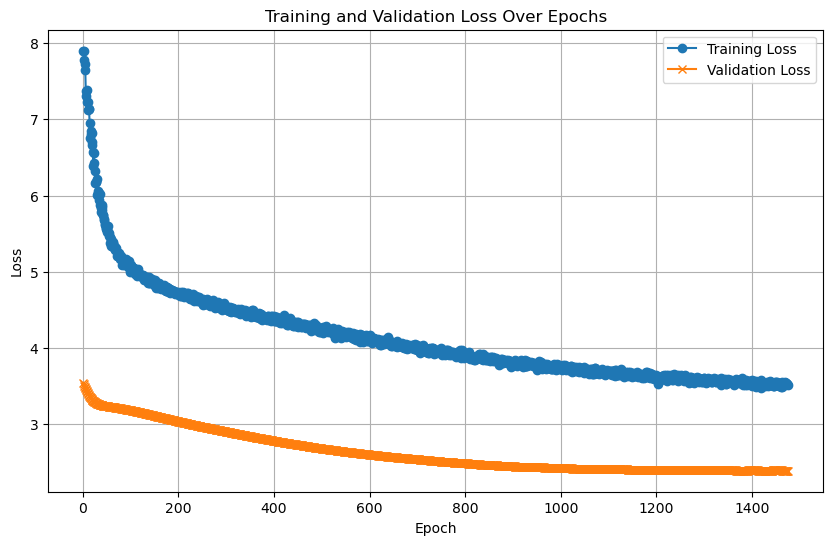

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/12], Loss: 5.2896

Test Loss: 5.0315


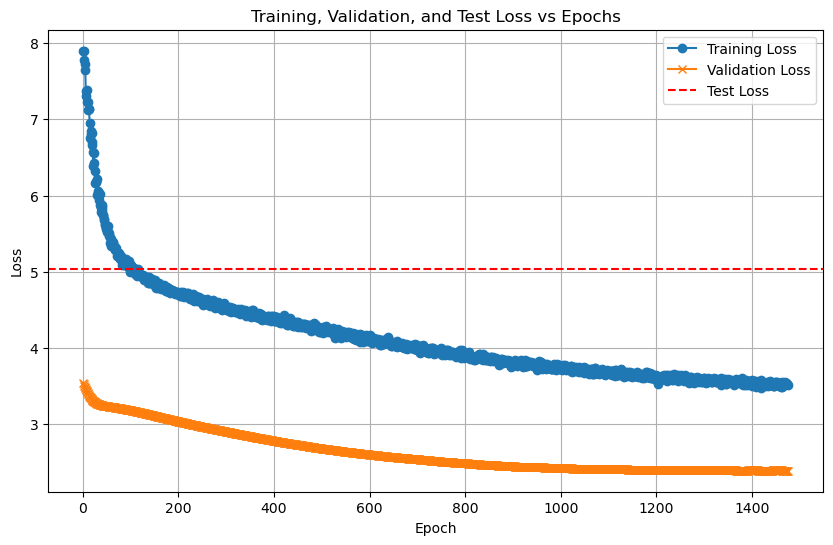

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/12 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (280, 128)
Train labels shape: (280,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2898, 128)
Test labels shape: (2898,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 87.14%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.83      1.00      0.91         5
           3       1.00      0.80      0.89         5
           4       0.75      0.60      0.67         5
           5       0.75      0.60      0.67         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       0.80      0.80      0.80         5
           9       0.71      1.00      0.83         5
          10       0.83      1.00      0.91         5
          11       1.00      1.00      1.00         5
          12       0.60      0.60      0.60         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (280, 128)
Train labels shape: (280,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2898, 128)
Test labels shape: (2898,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6925  |  Val Loss: 2.6720
Validation loss improved from inf to 2.6720.
[Epoch 2/1000] Train Loss: 2.6631  |  Val Loss: 2.6454
Validation loss improved from 2.6720 to 2.6454.
[Epoch 3/1000] Train Loss: 2.6342  |  Val Loss: 2.6179
Validation loss improved from 2.6454 to 2.6179.
[Epoch 4/1000] Train Loss: 2.6055  |  Val Loss: 2.5905
Validation loss improved from 2.6179 to 2.5905.
[Epoch 5/1000] Train Loss: 2.5755  |  Val Loss: 2.5619
Validation loss improved from 2.5905 to 2.5619.
[Epoch 6/1000] Train Loss: 2.5455  |  Val Loss: 2.5355
Validation loss improved from 2.5619 to 2.5355.
[Epoch 7/1000] Train Loss: 2.5195  |  Val Loss: 2.5099
Validation loss improved from 2.5355 to 2.5099.
[Epoch 8/1000] Train Loss: 2.4942  |  Val Loss: 2.4847
Validation loss improved from 2.5099 to 2.4847.
[Epoch 9/1000] Train Loss: 2.4676  |  Val Loss: 2.4613
Validation loss improved from 2.4847 to 2.4613.
[Epoch 10/1000] Train Loss: 2.4432  |  Val Loss: 2.4381
Validation loss impr

[Epoch 12/1000] Train Loss: 2.3949  |  Val Loss: 2.3921
Validation loss improved from 2.4150 to 2.3921.
[Epoch 13/1000] Train Loss: 2.3709  |  Val Loss: 2.3705
Validation loss improved from 2.3921 to 2.3705.
[Epoch 14/1000] Train Loss: 2.3494  |  Val Loss: 2.3495
Validation loss improved from 2.3705 to 2.3495.
[Epoch 15/1000] Train Loss: 2.3279  |  Val Loss: 2.3297
Validation loss improved from 2.3495 to 2.3297.
[Epoch 16/1000] Train Loss: 2.3067  |  Val Loss: 2.3106
Validation loss improved from 2.3297 to 2.3106.


[Epoch 17/1000] Train Loss: 2.2868  |  Val Loss: 2.2918
Validation loss improved from 2.3106 to 2.2918.
[Epoch 18/1000] Train Loss: 2.2670  |  Val Loss: 2.2739
Validation loss improved from 2.2918 to 2.2739.
[Epoch 19/1000] Train Loss: 2.2483  |  Val Loss: 2.2566
Validation loss improved from 2.2739 to 2.2566.
[Epoch 20/1000] Train Loss: 2.2289  |  Val Loss: 2.2398
Validation loss improved from 2.2566 to 2.2398.
[Epoch 21/1000] Train Loss: 2.2111  |  Val Loss: 2.2228
Validation loss improved from 2.2398 to 2.2228.
[Epoch 22/1000] Train Loss: 2.1927  |  Val Loss: 2.2060
Validation loss improved from 2.2228 to 2.2060.
[Epoch 23/1000] Train Loss: 2.1745  |  Val Loss: 2.1889
Validation loss improved from 2.2060 to 2.1889.
[Epoch 24/1000] Train Loss: 2.1564  |  Val Loss: 2.1719
Validation loss improved from 2.1889 to 2.1719.
[Epoch 25/1000] Train Loss: 2.1381  |  Val Loss: 2.1549
Validation loss improved from 2.1719 to 2.1549.
[Epoch 26/1000] Train Loss: 2.1198  |  Val Loss: 2.1376
Validati

[Epoch 32/1000] Train Loss: 2.0029  |  Val Loss: 2.0274
Validation loss improved from 2.0472 to 2.0274.
[Epoch 33/1000] Train Loss: 1.9818  |  Val Loss: 2.0077
Validation loss improved from 2.0274 to 2.0077.
[Epoch 34/1000] Train Loss: 1.9601  |  Val Loss: 1.9882
Validation loss improved from 2.0077 to 1.9882.
[Epoch 35/1000] Train Loss: 1.9383  |  Val Loss: 1.9685
Validation loss improved from 1.9882 to 1.9685.
[Epoch 36/1000] Train Loss: 1.9168  |  Val Loss: 1.9490
Validation loss improved from 1.9685 to 1.9490.


[Epoch 37/1000] Train Loss: 1.8944  |  Val Loss: 1.9298
Validation loss improved from 1.9490 to 1.9298.
[Epoch 38/1000] Train Loss: 1.8728  |  Val Loss: 1.9098
Validation loss improved from 1.9298 to 1.9098.
[Epoch 39/1000] Train Loss: 1.8507  |  Val Loss: 1.8905
Validation loss improved from 1.9098 to 1.8905.
[Epoch 40/1000] Train Loss: 1.8290  |  Val Loss: 1.8710
Validation loss improved from 1.8905 to 1.8710.
[Epoch 41/1000] Train Loss: 1.8073  |  Val Loss: 1.8513
Validation loss improved from 1.8710 to 1.8513.
[Epoch 42/1000] Train Loss: 1.7857  |  Val Loss: 1.8320
Validation loss improved from 1.8513 to 1.8320.
[Epoch 43/1000] Train Loss: 1.7642  |  Val Loss: 1.8127
Validation loss improved from 1.8320 to 1.8127.
[Epoch 44/1000] Train Loss: 1.7426  |  Val Loss: 1.7932
Validation loss improved from 1.8127 to 1.7932.
[Epoch 45/1000] Train Loss: 1.7214  |  Val Loss: 1.7737
Validation loss improved from 1.7932 to 1.7737.
[Epoch 46/1000] Train Loss: 1.6998  |  Val Loss: 1.7549
Validati

[Epoch 51/1000] Train Loss: 1.5930  |  Val Loss: 1.6585
Validation loss improved from 1.6769 to 1.6585.
[Epoch 52/1000] Train Loss: 1.5718  |  Val Loss: 1.6394
Validation loss improved from 1.6585 to 1.6394.
[Epoch 53/1000] Train Loss: 1.5504  |  Val Loss: 1.6204
Validation loss improved from 1.6394 to 1.6204.
[Epoch 54/1000] Train Loss: 1.5292  |  Val Loss: 1.6015
Validation loss improved from 1.6204 to 1.6015.
[Epoch 55/1000] Train Loss: 1.5090  |  Val Loss: 1.5822
Validation loss improved from 1.6015 to 1.5822.
[Epoch 56/1000] Train Loss: 1.4879  |  Val Loss: 1.5632
Validation loss improved from 1.5822 to 1.5632.


[Epoch 57/1000] Train Loss: 1.4676  |  Val Loss: 1.5445
Validation loss improved from 1.5632 to 1.5445.
[Epoch 58/1000] Train Loss: 1.4473  |  Val Loss: 1.5263
Validation loss improved from 1.5445 to 1.5263.
[Epoch 59/1000] Train Loss: 1.4270  |  Val Loss: 1.5082
Validation loss improved from 1.5263 to 1.5082.
[Epoch 60/1000] Train Loss: 1.4072  |  Val Loss: 1.4908
Validation loss improved from 1.5082 to 1.4908.
[Epoch 61/1000] Train Loss: 1.3869  |  Val Loss: 1.4735
Validation loss improved from 1.4908 to 1.4735.
[Epoch 62/1000] Train Loss: 1.3669  |  Val Loss: 1.4567
Validation loss improved from 1.4735 to 1.4567.
[Epoch 63/1000] Train Loss: 1.3474  |  Val Loss: 1.4391
Validation loss improved from 1.4567 to 1.4391.
[Epoch 64/1000] Train Loss: 1.3282  |  Val Loss: 1.4220
Validation loss improved from 1.4391 to 1.4220.
[Epoch 65/1000] Train Loss: 1.3092  |  Val Loss: 1.4050
Validation loss improved from 1.4220 to 1.4050.
[Epoch 66/1000] Train Loss: 1.2898  |  Val Loss: 1.3879
Validati

[Epoch 70/1000] Train Loss: 1.2153  |  Val Loss: 1.3231
Validation loss improved from 1.3391 to 1.3231.
[Epoch 71/1000] Train Loss: 1.1968  |  Val Loss: 1.3070
Validation loss improved from 1.3231 to 1.3070.
[Epoch 72/1000] Train Loss: 1.1785  |  Val Loss: 1.2909
Validation loss improved from 1.3070 to 1.2909.
[Epoch 73/1000] Train Loss: 1.1607  |  Val Loss: 1.2756
Validation loss improved from 1.2909 to 1.2756.
[Epoch 74/1000] Train Loss: 1.1431  |  Val Loss: 1.2604
Validation loss improved from 1.2756 to 1.2604.
[Epoch 75/1000] Train Loss: 1.1256  |  Val Loss: 1.2456
Validation loss improved from 1.2604 to 1.2456.
[Epoch 76/1000] Train Loss: 1.1083  |  Val Loss: 1.2304
Validation loss improved from 1.2456 to 1.2304.


[Epoch 77/1000] Train Loss: 1.0917  |  Val Loss: 1.2154
Validation loss improved from 1.2304 to 1.2154.
[Epoch 78/1000] Train Loss: 1.0752  |  Val Loss: 1.2013
Validation loss improved from 1.2154 to 1.2013.
[Epoch 79/1000] Train Loss: 1.0590  |  Val Loss: 1.1874
Validation loss improved from 1.2013 to 1.1874.
[Epoch 80/1000] Train Loss: 1.0432  |  Val Loss: 1.1735
Validation loss improved from 1.1874 to 1.1735.
[Epoch 81/1000] Train Loss: 1.0274  |  Val Loss: 1.1597
Validation loss improved from 1.1735 to 1.1597.
[Epoch 82/1000] Train Loss: 1.0121  |  Val Loss: 1.1458
Validation loss improved from 1.1597 to 1.1458.
[Epoch 83/1000] Train Loss: 0.9967  |  Val Loss: 1.1334
Validation loss improved from 1.1458 to 1.1334.
[Epoch 84/1000] Train Loss: 0.9818  |  Val Loss: 1.1205
Validation loss improved from 1.1334 to 1.1205.
[Epoch 85/1000] Train Loss: 0.9673  |  Val Loss: 1.1080
Validation loss improved from 1.1205 to 1.1080.
[Epoch 86/1000] Train Loss: 0.9523  |  Val Loss: 1.0958
Validati

[Epoch 89/1000] Train Loss: 0.9097  |  Val Loss: 1.0601
Validation loss improved from 1.0721 to 1.0601.
[Epoch 90/1000] Train Loss: 0.8958  |  Val Loss: 1.0486
Validation loss improved from 1.0601 to 1.0486.
[Epoch 91/1000] Train Loss: 0.8821  |  Val Loss: 1.0372
Validation loss improved from 1.0486 to 1.0372.
[Epoch 92/1000] Train Loss: 0.8684  |  Val Loss: 1.0266
Validation loss improved from 1.0372 to 1.0266.
[Epoch 93/1000] Train Loss: 0.8549  |  Val Loss: 1.0154
Validation loss improved from 1.0266 to 1.0154.
[Epoch 94/1000] Train Loss: 0.8415  |  Val Loss: 1.0041
Validation loss improved from 1.0154 to 1.0041.
[Epoch 95/1000] Train Loss: 0.8285  |  Val Loss: 0.9921
Validation loss improved from 1.0041 to 0.9921.


[Epoch 96/1000] Train Loss: 0.8150  |  Val Loss: 0.9808
Validation loss improved from 0.9921 to 0.9808.
[Epoch 97/1000] Train Loss: 0.8022  |  Val Loss: 0.9698
Validation loss improved from 0.9808 to 0.9698.
[Epoch 98/1000] Train Loss: 0.7894  |  Val Loss: 0.9592
Validation loss improved from 0.9698 to 0.9592.
[Epoch 99/1000] Train Loss: 0.7769  |  Val Loss: 0.9490
Validation loss improved from 0.9592 to 0.9490.
[Epoch 100/1000] Train Loss: 0.7642  |  Val Loss: 0.9383
Validation loss improved from 0.9490 to 0.9383.
[Epoch 101/1000] Train Loss: 0.7520  |  Val Loss: 0.9279
Validation loss improved from 0.9383 to 0.9279.
[Epoch 102/1000] Train Loss: 0.7396  |  Val Loss: 0.9181
Validation loss improved from 0.9279 to 0.9181.
[Epoch 103/1000] Train Loss: 0.7274  |  Val Loss: 0.9080
Validation loss improved from 0.9181 to 0.9080.
[Epoch 104/1000] Train Loss: 0.7153  |  Val Loss: 0.8980
Validation loss improved from 0.9080 to 0.8980.
[Epoch 105/1000] Train Loss: 0.7037  |  Val Loss: 0.8882
Va

[Epoch 108/1000] Train Loss: 0.6686  |  Val Loss: 0.8597
Validation loss improved from 0.8684 to 0.8597.
[Epoch 109/1000] Train Loss: 0.6571  |  Val Loss: 0.8506
Validation loss improved from 0.8597 to 0.8506.
[Epoch 110/1000] Train Loss: 0.6457  |  Val Loss: 0.8410
Validation loss improved from 0.8506 to 0.8410.
[Epoch 111/1000] Train Loss: 0.6344  |  Val Loss: 0.8321
Validation loss improved from 0.8410 to 0.8321.
[Epoch 112/1000] Train Loss: 0.6234  |  Val Loss: 0.8236
Validation loss improved from 0.8321 to 0.8236.
[Epoch 113/1000] Train Loss: 0.6127  |  Val Loss: 0.8152
Validation loss improved from 0.8236 to 0.8152.
[Epoch 114/1000] Train Loss: 0.6018  |  Val Loss: 0.8059
Validation loss improved from 0.8152 to 0.8059.
[Epoch 115/1000] Train Loss: 0.5914  |  Val Loss: 0.7967
Validation loss improved from 0.8059 to 0.7967.


[Epoch 116/1000] Train Loss: 0.5810  |  Val Loss: 0.7880
Validation loss improved from 0.7967 to 0.7880.
[Epoch 117/1000] Train Loss: 0.5708  |  Val Loss: 0.7806
Validation loss improved from 0.7880 to 0.7806.
[Epoch 118/1000] Train Loss: 0.5606  |  Val Loss: 0.7723
Validation loss improved from 0.7806 to 0.7723.
[Epoch 119/1000] Train Loss: 0.5508  |  Val Loss: 0.7637
Validation loss improved from 0.7723 to 0.7637.
[Epoch 120/1000] Train Loss: 0.5409  |  Val Loss: 0.7558
Validation loss improved from 0.7637 to 0.7558.
[Epoch 121/1000] Train Loss: 0.5315  |  Val Loss: 0.7478
Validation loss improved from 0.7558 to 0.7478.
[Epoch 122/1000] Train Loss: 0.5216  |  Val Loss: 0.7400
Validation loss improved from 0.7478 to 0.7400.
[Epoch 123/1000] Train Loss: 0.5121  |  Val Loss: 0.7318
Validation loss improved from 0.7400 to 0.7318.
[Epoch 124/1000] Train Loss: 0.5026  |  Val Loss: 0.7243
Validation loss improved from 0.7318 to 0.7243.
[Epoch 125/1000] Train Loss: 0.4940  |  Val Loss: 0.715

[Epoch 127/1000] Train Loss: 0.4760  |  Val Loss: 0.7020
Validation loss improved from 0.7080 to 0.7020.
[Epoch 128/1000] Train Loss: 0.4671  |  Val Loss: 0.6959
Validation loss improved from 0.7020 to 0.6959.
[Epoch 129/1000] Train Loss: 0.4588  |  Val Loss: 0.6896
Validation loss improved from 0.6959 to 0.6896.
[Epoch 130/1000] Train Loss: 0.4506  |  Val Loss: 0.6837
Validation loss improved from 0.6896 to 0.6837.
[Epoch 131/1000] Train Loss: 0.4424  |  Val Loss: 0.6786
Validation loss improved from 0.6837 to 0.6786.
[Epoch 132/1000] Train Loss: 0.4347  |  Val Loss: 0.6732
Validation loss improved from 0.6786 to 0.6732.
[Epoch 133/1000] Train Loss: 0.4266  |  Val Loss: 0.6669
Validation loss improved from 0.6732 to 0.6669.
[Epoch 134/1000] Train Loss: 0.4189  |  Val Loss: 0.6593
Validation loss improved from 0.6669 to 0.6593.


[Epoch 135/1000] Train Loss: 0.4113  |  Val Loss: 0.6525
Validation loss improved from 0.6593 to 0.6525.
[Epoch 136/1000] Train Loss: 0.4039  |  Val Loss: 0.6470
Validation loss improved from 0.6525 to 0.6470.
[Epoch 137/1000] Train Loss: 0.3966  |  Val Loss: 0.6424
Validation loss improved from 0.6470 to 0.6424.
[Epoch 138/1000] Train Loss: 0.3894  |  Val Loss: 0.6367
Validation loss improved from 0.6424 to 0.6367.
[Epoch 139/1000] Train Loss: 0.3824  |  Val Loss: 0.6327
Validation loss improved from 0.6367 to 0.6327.
[Epoch 140/1000] Train Loss: 0.3755  |  Val Loss: 0.6287
Validation loss improved from 0.6327 to 0.6287.
[Epoch 141/1000] Train Loss: 0.3687  |  Val Loss: 0.6234
Validation loss improved from 0.6287 to 0.6234.
[Epoch 142/1000] Train Loss: 0.3622  |  Val Loss: 0.6163
Validation loss improved from 0.6234 to 0.6163.
[Epoch 143/1000] Train Loss: 0.3556  |  Val Loss: 0.6113
Validation loss improved from 0.6163 to 0.6113.
[Epoch 144/1000] Train Loss: 0.3493  |  Val Loss: 0.606

[Epoch 146/1000] Train Loss: 0.3372  |  Val Loss: 0.6016
Validation loss improved from 0.6042 to 0.6016.
[Epoch 147/1000] Train Loss: 0.3311  |  Val Loss: 0.5979
Validation loss improved from 0.6016 to 0.5979.
[Epoch 148/1000] Train Loss: 0.3254  |  Val Loss: 0.5933
Validation loss improved from 0.5979 to 0.5933.
[Epoch 149/1000] Train Loss: 0.3197  |  Val Loss: 0.5875
Validation loss improved from 0.5933 to 0.5875.
[Epoch 150/1000] Train Loss: 0.3147  |  Val Loss: 0.5821
Validation loss improved from 0.5875 to 0.5821.
[Epoch 151/1000] Train Loss: 0.3091  |  Val Loss: 0.5779
Validation loss improved from 0.5821 to 0.5779.
[Epoch 152/1000] Train Loss: 0.3039  |  Val Loss: 0.5742
Validation loss improved from 0.5779 to 0.5742.
[Epoch 153/1000] Train Loss: 0.2986  |  Val Loss: 0.5707
Validation loss improved from 0.5742 to 0.5707.


[Epoch 154/1000] Train Loss: 0.2937  |  Val Loss: 0.5669
Validation loss improved from 0.5707 to 0.5669.
[Epoch 155/1000] Train Loss: 0.2892  |  Val Loss: 0.5647
Validation loss improved from 0.5669 to 0.5647.
[Epoch 156/1000] Train Loss: 0.2841  |  Val Loss: 0.5609
Validation loss improved from 0.5647 to 0.5609.
[Epoch 157/1000] Train Loss: 0.2794  |  Val Loss: 0.5564
Validation loss improved from 0.5609 to 0.5564.
[Epoch 158/1000] Train Loss: 0.2748  |  Val Loss: 0.5527
Validation loss improved from 0.5564 to 0.5527.
[Epoch 159/1000] Train Loss: 0.2701  |  Val Loss: 0.5516
Validation loss improved from 0.5527 to 0.5516.
[Epoch 160/1000] Train Loss: 0.2656  |  Val Loss: 0.5503
Validation loss improved from 0.5516 to 0.5503.
[Epoch 161/1000] Train Loss: 0.2617  |  Val Loss: 0.5484
Validation loss improved from 0.5503 to 0.5484.
[Epoch 162/1000] Train Loss: 0.2573  |  Val Loss: 0.5442
Validation loss improved from 0.5484 to 0.5442.
[Epoch 163/1000] Train Loss: 0.2530  |  Val Loss: 0.538

[Epoch 166/1000] Train Loss: 0.2413  |  Val Loss: 0.5280
Validation loss improved from 0.5296 to 0.5280.
[Epoch 167/1000] Train Loss: 0.2374  |  Val Loss: 0.5266
Validation loss improved from 0.5280 to 0.5266.
[Epoch 168/1000] Train Loss: 0.2338  |  Val Loss: 0.5252
Validation loss improved from 0.5266 to 0.5252.
[Epoch 169/1000] Train Loss: 0.2300  |  Val Loss: 0.5245
Validation loss improved from 0.5252 to 0.5245.
[Epoch 170/1000] Train Loss: 0.2262  |  Val Loss: 0.5218
Validation loss improved from 0.5245 to 0.5218.
[Epoch 171/1000] Train Loss: 0.2231  |  Val Loss: 0.5195
Validation loss improved from 0.5218 to 0.5195.
[Epoch 172/1000] Train Loss: 0.2199  |  Val Loss: 0.5180
Validation loss improved from 0.5195 to 0.5180.


[Epoch 173/1000] Train Loss: 0.2161  |  Val Loss: 0.5160
Validation loss improved from 0.5180 to 0.5160.
[Epoch 174/1000] Train Loss: 0.2130  |  Val Loss: 0.5134
Validation loss improved from 0.5160 to 0.5134.
[Epoch 175/1000] Train Loss: 0.2099  |  Val Loss: 0.5110
Validation loss improved from 0.5134 to 0.5110.
[Epoch 176/1000] Train Loss: 0.2067  |  Val Loss: 0.5102
Validation loss improved from 0.5110 to 0.5102.
[Epoch 177/1000] Train Loss: 0.2036  |  Val Loss: 0.5093
Validation loss improved from 0.5102 to 0.5093.
[Epoch 178/1000] Train Loss: 0.2007  |  Val Loss: 0.5077
Validation loss improved from 0.5093 to 0.5077.
[Epoch 179/1000] Train Loss: 0.1978  |  Val Loss: 0.5056
Validation loss improved from 0.5077 to 0.5056.
[Epoch 180/1000] Train Loss: 0.1949  |  Val Loss: 0.5054
Validation loss improved from 0.5056 to 0.5054.
[Epoch 181/1000] Train Loss: 0.1921  |  Val Loss: 0.5043
Validation loss improved from 0.5054 to 0.5043.
[Epoch 182/1000] Train Loss: 0.1895  |  Val Loss: 0.502

[Epoch 185/1000] Train Loss: 0.1819  |  Val Loss: 0.4996
Validation loss improved from 0.5003 to 0.4996.
[Epoch 186/1000] Train Loss: 0.1791  |  Val Loss: 0.4978
Validation loss improved from 0.4996 to 0.4978.
[Epoch 187/1000] Train Loss: 0.1767  |  Val Loss: 0.4945
Validation loss improved from 0.4978 to 0.4945.
[Epoch 188/1000] Train Loss: 0.1741  |  Val Loss: 0.4925
Validation loss improved from 0.4945 to 0.4925.
[Epoch 189/1000] Train Loss: 0.1717  |  Val Loss: 0.4915
Validation loss improved from 0.4925 to 0.4915.
[Epoch 190/1000] Train Loss: 0.1694  |  Val Loss: 0.4905
Validation loss improved from 0.4915 to 0.4905.
[Epoch 191/1000] Train Loss: 0.1671  |  Val Loss: 0.4906
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 192/1000] Train Loss: 0.1649  |  Val Loss: 0.4913
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 193/1000] Train Loss: 0.1630  |  Val Loss: 0.4896
Validation loss improved from 0.4905 to 0.4896.
[Epoch 194/1000] Train Loss: 0.1608  |  Val Loss: 0.4876
Validation loss improved from 0.4896 to 0.4876.
[Epoch 195/1000] Train Loss: 0.1588  |  Val Loss: 0.4865
Validation loss improved from 0.4876 to 0.4865.
[Epoch 196/1000] Train Loss: 0.1565  |  Val Loss: 0.4842
Validation loss improved from 0.4865 to 0.4842.
[Epoch 197/1000] Train Loss: 0.1543  |  Val Loss: 0.4816
Validation loss improved from 0.4842 to 0.4816.
[Epoch 198/1000] Train Loss: 0.1523  |  Val Loss: 0.4806
Validation loss improved from 0.4816 to 0.4806.
[Epoch 199/1000] Train Loss: 0.1505  |  Val Loss: 0.4811
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 200/1000] Train Loss: 0.1486  |  Val Loss: 0.4808
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 201/1000] Train Loss: 0.1467  

[Epoch 205/1000] Train Loss: 0.1401  |  Val Loss: 0.4763
Validation loss improved from 0.4776 to 0.4763.
[Epoch 206/1000] Train Loss: 0.1383  |  Val Loss: 0.4771
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 207/1000] Train Loss: 0.1369  |  Val Loss: 0.4774
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 208/1000] Train Loss: 0.1352  |  Val Loss: 0.4750
Validation loss improved from 0.4763 to 0.4750.
[Epoch 209/1000] Train Loss: 0.1333  |  Val Loss: 0.4723
Validation loss improved from 0.4750 to 0.4723.
[Epoch 210/1000] Train Loss: 0.1319  |  Val Loss: 0.4702
Validation loss improved from 0.4723 to 0.4702.


[Epoch 211/1000] Train Loss: 0.1305  |  Val Loss: 0.4688
Validation loss improved from 0.4702 to 0.4688.
[Epoch 212/1000] Train Loss: 0.1290  |  Val Loss: 0.4695
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 213/1000] Train Loss: 0.1276  |  Val Loss: 0.4702
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 214/1000] Train Loss: 0.1261  |  Val Loss: 0.4701
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 215/1000] Train Loss: 0.1247  |  Val Loss: 0.4711
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 216/1000] Train Loss: 0.1234  |  Val Loss: 0.4716
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 217/1000] Train Loss: 0.1219  |  Val Loss: 0.4718
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 218/1000] Train Loss: 0.1207  |  Val Loss: 0.4718
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 219/1000] Train Loss: 0.1197  |  Val Loss: 0.4714
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 223/1000] Train Loss: 0.1146  |  Val Loss: 0.4680
Validation loss improved from 0.4688 to 0.4680.
[Epoch 224/1000] Train Loss: 0.1135  |  Val Loss: 0.4691
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 225/1000] Train Loss: 0.1123  |  Val Loss: 0.4697
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 226/1000] Train Loss: 0.1111  |  Val Loss: 0.4682
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 227/1000] Train Loss: 0.1101  |  Val Loss: 0.4673
Validation loss improved from 0.4680 to 0.4673.
[Epoch 228/1000] Train Loss: 0.1090  |  Val Loss: 0.4640
Validation loss improved from 0.4673 to 0.4640.
[Epoch 229/1000] Train Loss: 0.1079  |  Val Loss: 0.4631
Validation loss improved from 0.4640 to 0.4631.


[Epoch 230/1000] Train Loss: 0.1070  |  Val Loss: 0.4631
Validation loss improved from 0.4631 to 0.4631.
[Epoch 231/1000] Train Loss: 0.1059  |  Val Loss: 0.4637
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 232/1000] Train Loss: 0.1049  |  Val Loss: 0.4644
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 233/1000] Train Loss: 0.1039  |  Val Loss: 0.4654
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 234/1000] Train Loss: 0.1028  |  Val Loss: 0.4653
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 235/1000] Train Loss: 0.1018  |  Val Loss: 0.4668
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 236/1000] Train Loss: 0.1011  |  Val Loss: 0.4671
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 237/1000] Train Loss: 0.1001  |  Val Loss: 0.4672
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 238/1000] Train Loss: 0.0993  |  Val Loss: 0.4671
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 243/1000] Train Loss: 0.0951  |  Val Loss: 0.4610
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 244/1000] Train Loss: 0.0941  |  Val Loss: 0.4619
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 245/1000] Train Loss: 0.0932  |  Val Loss: 0.4618
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 246/1000] Train Loss: 0.0925  |  Val Loss: 0.4624
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 247/1000] Train Loss: 0.0915  |  Val Loss: 0.4639
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 248/1000] Train Loss: 0.0908  |  Val Loss: 0.4646
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 249/1000] Train Loss: 0.0900  |  Val Loss: 0.4639
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 250/1000] Train Loss: 0.0892  |  Val Loss: 0.4631
!! Validation loss did NOT improve !! Patience: 8/100


[Epoch 251/1000] Train Loss: 0.0885  |  Val Loss: 0.4619
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 252/1000] Train Loss: 0.0879  |  Val Loss: 0.4617
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 253/1000] Train Loss: 0.0869  |  Val Loss: 0.4612
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 254/1000] Train Loss: 0.0863  |  Val Loss: 0.4624
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 255/1000] Train Loss: 0.0858  |  Val Loss: 0.4623
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 256/1000] Train Loss: 0.0850  |  Val Loss: 0.4631
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 257/1000] Train Loss: 0.0846  |  Val Loss: 0.4654
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 258/1000] Train Loss: 0.0837  |  Val Loss: 0.4651
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 259/1000] Train Loss: 0.0830  |  Val Loss: 0.4639
!! Validation loss did NOT improve !! Patience: 

[Epoch 262/1000] Train Loss: 0.0811  |  Val Loss: 0.4615
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 263/1000] Train Loss: 0.0805  |  Val Loss: 0.4600
Validation loss improved from 0.4607 to 0.4600.
[Epoch 264/1000] Train Loss: 0.0799  |  Val Loss: 0.4605
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 265/1000] Train Loss: 0.0794  |  Val Loss: 0.4624
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 266/1000] Train Loss: 0.0788  |  Val Loss: 0.4635
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 267/1000] Train Loss: 0.0781  |  Val Loss: 0.4633
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 268/1000] Train Loss: 0.0776  |  Val Loss: 0.4628
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 269/1000] Train Loss: 0.0769  |  Val Loss: 0.4642
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 270/1000] Train Loss: 0.0762  |  Val Loss: 0.4646
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 271/1000] Train Loss: 0.0757  |  Val Loss: 0.4653
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 272/1000] Train Loss: 0.0753  |  Val Loss: 0.4658
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 273/1000] Train Loss: 0.0748  |  Val Loss: 0.4652
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 274/1000] Train Loss: 0.0743  |  Val Loss: 0.4642
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 275/1000] Train Loss: 0.0736  |  Val Loss: 0.4649
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 276/1000] Train Loss: 0.0731  |  Val Loss: 0.4657
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 277/1000] Train Loss: 0.0726  |  Val Loss: 0.4663
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 278/1000] Train Loss: 0.0722  |  Val Loss: 0.4644
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 279/1000] Train Loss: 0.0715  |  Val Loss: 0.4621
!! Validation loss did NOT improve !! Patience: 1

[Epoch 281/1000] Train Loss: 0.0706  |  Val Loss: 0.4616
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 282/1000] Train Loss: 0.0702  |  Val Loss: 0.4609
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 283/1000] Train Loss: 0.0697  |  Val Loss: 0.4624
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 284/1000] Train Loss: 0.0690  |  Val Loss: 0.4631
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 285/1000] Train Loss: 0.0684  |  Val Loss: 0.4639
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 286/1000] Train Loss: 0.0682  |  Val Loss: 0.4655
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 287/1000] Train Loss: 0.0676  |  Val Loss: 0.4650
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 288/1000] Train Loss: 0.0671  |  Val Loss: 0.4655
!! Validation loss did NOT improve !! Patience: 25/100


[Epoch 289/1000] Train Loss: 0.0667  |  Val Loss: 0.4663
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 290/1000] Train Loss: 0.0662  |  Val Loss: 0.4656
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 291/1000] Train Loss: 0.0657  |  Val Loss: 0.4653
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 292/1000] Train Loss: 0.0654  |  Val Loss: 0.4660
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 293/1000] Train Loss: 0.0649  |  Val Loss: 0.4670
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 294/1000] Train Loss: 0.0643  |  Val Loss: 0.4685
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 295/1000] Train Loss: 0.0643  |  Val Loss: 0.4682
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 296/1000] Train Loss: 0.0636  |  Val Loss: 0.4665
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 297/1000] Train Loss: 0.0634  |  Val Loss: 0.4637
!! Validation loss did NOT improve !! Patience:

[Epoch 299/1000] Train Loss: 0.0626  |  Val Loss: 0.4654
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 300/1000] Train Loss: 0.0621  |  Val Loss: 0.4665
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 301/1000] Train Loss: 0.0618  |  Val Loss: 0.4683
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 302/1000] Train Loss: 0.0613  |  Val Loss: 0.4686
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 303/1000] Train Loss: 0.0609  |  Val Loss: 0.4692
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 304/1000] Train Loss: 0.0606  |  Val Loss: 0.4702
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 305/1000] Train Loss: 0.0601  |  Val Loss: 0.4705
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 306/1000] Train Loss: 0.0597  |  Val Loss: 0.4719
!! Validation loss did NOT improve !! Patience: 43/100


[Epoch 307/1000] Train Loss: 0.0594  |  Val Loss: 0.4736
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 308/1000] Train Loss: 0.0592  |  Val Loss: 0.4741
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 309/1000] Train Loss: 0.0587  |  Val Loss: 0.4750
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 310/1000] Train Loss: 0.0586  |  Val Loss: 0.4762
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 311/1000] Train Loss: 0.0582  |  Val Loss: 0.4746
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 312/1000] Train Loss: 0.0577  |  Val Loss: 0.4732
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 313/1000] Train Loss: 0.0575  |  Val Loss: 0.4701
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 314/1000] Train Loss: 0.0571  |  Val Loss: 0.4701
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 315/1000] Train Loss: 0.0568  |  Val Loss: 0.4716
!! Validation loss did NOT improve !! Patience:

[Epoch 318/1000] Train Loss: 0.0558  |  Val Loss: 0.4729
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 319/1000] Train Loss: 0.0553  |  Val Loss: 0.4723
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 320/1000] Train Loss: 0.0550  |  Val Loss: 0.4732
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 321/1000] Train Loss: 0.0549  |  Val Loss: 0.4724
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 322/1000] Train Loss: 0.0546  |  Val Loss: 0.4735
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 323/1000] Train Loss: 0.0543  |  Val Loss: 0.4721
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 324/1000] Train Loss: 0.0539  |  Val Loss: 0.4717
!! Validation loss did NOT improve !! Patience: 61/100


[Epoch 325/1000] Train Loss: 0.0536  |  Val Loss: 0.4732
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 326/1000] Train Loss: 0.0533  |  Val Loss: 0.4732
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 327/1000] Train Loss: 0.0529  |  Val Loss: 0.4726
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 328/1000] Train Loss: 0.0528  |  Val Loss: 0.4740
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 329/1000] Train Loss: 0.0524  |  Val Loss: 0.4777
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 330/1000] Train Loss: 0.0521  |  Val Loss: 0.4795
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 331/1000] Train Loss: 0.0518  |  Val Loss: 0.4797
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 332/1000] Train Loss: 0.0515  |  Val Loss: 0.4781
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 333/1000] Train Loss: 0.0512  |  Val Loss: 0.4769
!! Validation loss did NOT improve !! Patience:

[Epoch 339/1000] Train Loss: 0.0496  |  Val Loss: 0.4761
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 340/1000] Train Loss: 0.0493  |  Val Loss: 0.4769
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 341/1000] Train Loss: 0.0491  |  Val Loss: 0.4776
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 342/1000] Train Loss: 0.0488  |  Val Loss: 0.4799
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 343/1000] Train Loss: 0.0487  |  Val Loss: 0.4805
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 344/1000] Train Loss: 0.0483  |  Val Loss: 0.4795
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 345/1000] Train Loss: 0.0482  |  Val Loss: 0.4790
!! Validation loss did NOT improve !! Patience: 82/100


[Epoch 346/1000] Train Loss: 0.0480  |  Val Loss: 0.4808
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 347/1000] Train Loss: 0.0477  |  Val Loss: 0.4804
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 348/1000] Train Loss: 0.0474  |  Val Loss: 0.4824
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 349/1000] Train Loss: 0.0471  |  Val Loss: 0.4821
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 350/1000] Train Loss: 0.0469  |  Val Loss: 0.4824
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 351/1000] Train Loss: 0.0467  |  Val Loss: 0.4824
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 352/1000] Train Loss: 0.0464  |  Val Loss: 0.4813
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 353/1000] Train Loss: 0.0462  |  Val Loss: 0.4806
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 354/1000] Train Loss: 0.0462  |  Val Loss: 0.4809
!! Validation loss did NOT improve !! Patience:

[Epoch 358/1000] Train Loss: 0.0452  |  Val Loss: 0.4877
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 359/1000] Train Loss: 0.0449  |  Val Loss: 0.4874
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 360/1000] Train Loss: 0.0447  |  Val Loss: 0.4876
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 361/1000] Train Loss: 0.0445  |  Val Loss: 0.4876
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 362/1000] Train Loss: 0.0442  |  Val Loss: 0.4855
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 363/1000] Train Loss: 0.0442  |  Val Loss: 0.4843
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 363 !!
No improvement for 100 epochs.


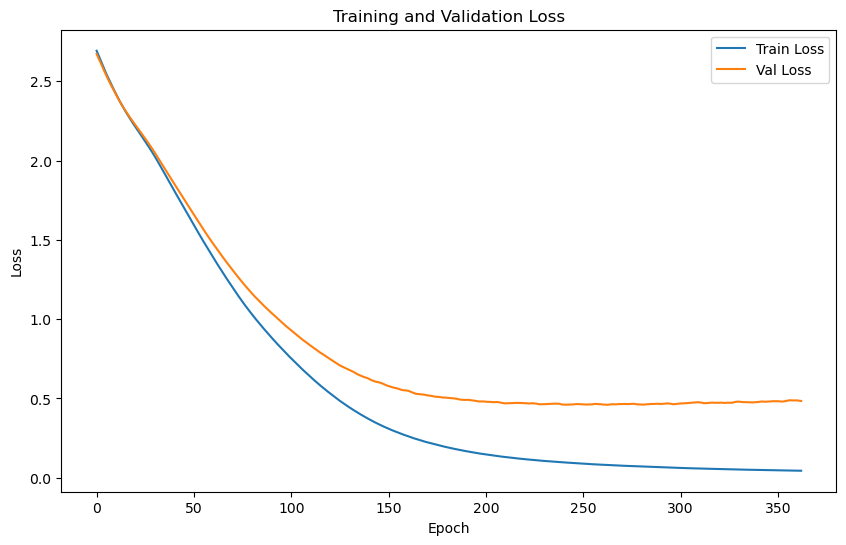

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.5375 | Test Accuracy: 85.89%


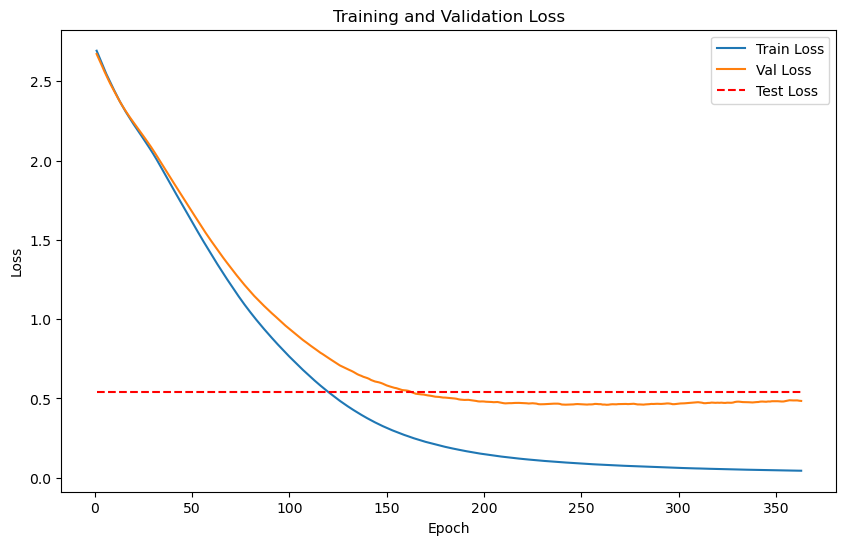

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 280 samples with 64 features each
LOG: Labels shape: (280,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 2898 samples with 64 features each
LOG: Labels shape: (2898,)


Train embeddings shape: (280, 64), 
Train labels shape: (280,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (2898, 64), 
Test labels shape: (2898,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20, 13: 20}
Training batch size: 280


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4805
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.4714
    Batch [2/2], Val Loss: 0.2470
Epoch [1/2000], Avg Train Loss: 0.4805, Avg Val Loss: 0.3592

Validation loss improved from inf to 0.3592. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4711
    Batch [2/2], Val Loss: 0.2488
Epoch [2/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4819
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.2507
Epoch [3/2000], Avg Train Loss: 0.4819, Avg Val Loss: 0.3608

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4807
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4712
    Batch [2/2], Val Loss: 0.2527
Epoch [4/2000], Avg Train Loss: 0.4807, Avg Val Loss: 0.3620

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4845
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.2542
Epoch [5/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.3626

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4788
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4709
    Batch [2/2], Val Loss: 0.2560
Epoch [6/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.3635

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.2578
Epoch [7/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.3642

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4759
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4700
    Batch [2/2], Val Loss: 0.2593
Epoch [8/2000], Avg Train Loss: 0.4759, Avg Val Loss: 0.3647

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4696
    Batch [2/2], Val Loss: 0.2612
Epoch [9/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.3654

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4747
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.2615
Epoch [10/2000], Avg Train Loss: 0.4747, Avg Val Loss: 0.3651

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4734
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.2605
Epoch [11/2000], Avg Train Loss: 0.4734, Avg Val Loss: 0.3640

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4740
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4664
    Batch [2/2], Val Loss: 0.2608
Epoch [12/2000], Avg Train Loss: 0.4740, Avg Val Loss: 0.3636

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4719
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4655
    Batch [2/2], Val Loss: 0.2611
Epoch [13/2000], Avg Train Loss: 0.4719, Avg Val Loss: 0.3633

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4766
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4648
    Batch [2/2], Val Loss: 0.2609
Epoch [14/2000], Avg Train Loss: 0.4766, Avg Val Loss: 0.3628

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.2586
Epoch [15/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.3611

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4716
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4629
    Batch [2/2], Val Loss: 0.2557
Epoch [16/2000], Avg Train Loss: 0.4716, Avg Val Loss: 0.3593

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4715
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.2528
Epoch [17/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.3571

Validation loss improved from 0.3592 to 0.3571. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4597
    Batch [2/2], Val Loss: 0.2506
Epoch [18/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.3552

Validation loss improved from 0.3571 to 0.3552. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4577
    Batch [2/2], Val Loss: 0.2477
Epoch [19/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.3527

Validation loss improved from 0.3552 to 0.3527. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4661
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4564
    Batch [2/2], Val Loss: 0.2429
Epoch [20/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.3497

Validation loss improved from 0.3527 to 0.3497. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4555
    Batch [2/2], Val Loss: 0.2378
Epoch [21/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.3467

Validation loss improved from 0.3497 to 0.3467. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4549
    Batch [2/2], Val Loss: 0.2334
Epoch [22/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.3441

Validation loss improved from 0.3467 to 0.3441. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4535
    Batch [2/2], Val Loss: 0.2291
Epoch [23/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.3413

Validation loss improved from 0.3441 to 0.3413. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4522
    Batch [2/2], Val Loss: 0.2244
Epoch [24/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.3383

Validation loss improved from 0.3413 to 0.3383. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4675
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4512
    Batch [2/2], Val Loss: 0.2191
Epoch [25/2000], Avg Train Loss: 0.4675, Avg Val Loss: 0.3352

Validation loss improved from 0.3383 to 0.3352. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4502
    Batch [2/2], Val Loss: 0.2128
Epoch [26/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.3315

Validation loss improved from 0.3352 to 0.3315. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4599
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4493
    Batch [2/2], Val Loss: 0.2056
Epoch [27/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.3275

Validation loss improved from 0.3315 to 0.3275. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4480
    Batch [2/2], Val Loss: 0.1995
Epoch [28/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.3237

Validation loss improved from 0.3275 to 0.3237. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4639
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4466
    Batch [2/2], Val Loss: 0.1932
Epoch [29/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.3199

Validation loss improved from 0.3237 to 0.3199. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4455
    Batch [2/2], Val Loss: 0.1863
Epoch [30/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.3159

Validation loss improved from 0.3199 to 0.3159. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4448
    Batch [2/2], Val Loss: 0.1799
Epoch [31/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.3124

Validation loss improved from 0.3159 to 0.3124. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4441
    Batch [2/2], Val Loss: 0.1744
Epoch [32/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.3093

Validation loss improved from 0.3124 to 0.3093. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4432
    Batch [2/2], Val Loss: 0.1701
Epoch [33/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.3066

Validation loss improved from 0.3093 to 0.3066. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4592
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4421
    Batch [2/2], Val Loss: 0.1667
Epoch [34/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.3044

Validation loss improved from 0.3066 to 0.3044. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4594
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4407
    Batch [2/2], Val Loss: 0.1640
Epoch [35/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.3024

Validation loss improved from 0.3044 to 0.3024. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4396
    Batch [2/2], Val Loss: 0.1624
Epoch [36/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.3010

Validation loss improved from 0.3024 to 0.3010. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4546
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4385
    Batch [2/2], Val Loss: 0.1614
Epoch [37/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.2999

Validation loss improved from 0.3010 to 0.2999. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4557
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4376
    Batch [2/2], Val Loss: 0.1607
Epoch [38/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.2991

Validation loss improved from 0.2999 to 0.2991. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4591
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4368
    Batch [2/2], Val Loss: 0.1605
Epoch [39/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.2986

Validation loss improved from 0.2991 to 0.2986. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4360
    Batch [2/2], Val Loss: 0.1605
Epoch [40/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.2983

Validation loss improved from 0.2986 to 0.2983. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4547
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4352
    Batch [2/2], Val Loss: 0.1608
Epoch [41/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.2980

Validation loss improved from 0.2983 to 0.2980. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4344
    Batch [2/2], Val Loss: 0.1614
Epoch [42/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.2979

Validation loss improved from 0.2980 to 0.2979. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4335
    Batch [2/2], Val Loss: 0.1620
Epoch [43/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.2977

Validation loss improved from 0.2979 to 0.2977. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4325
    Batch [2/2], Val Loss: 0.1630
Epoch [44/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.2977

Validation loss improved from 0.2977 to 0.2977. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4533
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4315
    Batch [2/2], Val Loss: 0.1641
Epoch [45/2000], Avg Train Loss: 0.4533, Avg Val Loss: 0.2978

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4522
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4305
    Batch [2/2], Val Loss: 0.1653
Epoch [46/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.2979

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4296
    Batch [2/2], Val Loss: 0.1664
Epoch [47/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.2980

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4287
    Batch [2/2], Val Loss: 0.1676
Epoch [48/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.2982

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4277
    Batch [2/2], Val Loss: 0.1687
Epoch [49/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.2982

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4510
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4266
    Batch [2/2], Val Loss: 0.1698
Epoch [50/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.2982

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.1711
Epoch [51/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.2984

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4246
    Batch [2/2], Val Loss: 0.1721
Epoch [52/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.2984

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4236
    Batch [2/2], Val Loss: 0.1734
Epoch [53/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.2985

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4455
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4227
    Batch [2/2], Val Loss: 0.1746
Epoch [54/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.2986

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4528
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4217
    Batch [2/2], Val Loss: 0.1759
Epoch [55/2000], Avg Train Loss: 0.4528, Avg Val Loss: 0.2988

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4209
    Batch [2/2], Val Loss: 0.1770
Epoch [56/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.2990

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4204
    Batch [2/2], Val Loss: 0.1781
Epoch [57/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.2992

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4197
    Batch [2/2], Val Loss: 0.1790
Epoch [58/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.2993

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4190
    Batch [2/2], Val Loss: 0.1799
Epoch [59/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.2995

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4444
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4184
    Batch [2/2], Val Loss: 0.1809
Epoch [60/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.2996

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4177
    Batch [2/2], Val Loss: 0.1817
Epoch [61/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.2997

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4170
    Batch [2/2], Val Loss: 0.1824
Epoch [62/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.2997

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4426
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4163
    Batch [2/2], Val Loss: 0.1832
Epoch [63/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.2997

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4157
    Batch [2/2], Val Loss: 0.1840
Epoch [64/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.2998

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4150
    Batch [2/2], Val Loss: 0.1847
Epoch [65/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.2999

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4142
    Batch [2/2], Val Loss: 0.1855
Epoch [66/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.2999

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4134
    Batch [2/2], Val Loss: 0.1862
Epoch [67/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.2998

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4406
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4128
    Batch [2/2], Val Loss: 0.1868
Epoch [68/2000], Avg Train Loss: 0.4406, Avg Val Loss: 0.2998

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4121
    Batch [2/2], Val Loss: 0.1875
Epoch [69/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.2998

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4377
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4114
    Batch [2/2], Val Loss: 0.1867
Epoch [70/2000], Avg Train Loss: 0.4377, Avg Val Loss: 0.2990

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4106
    Batch [2/2], Val Loss: 0.1860
Epoch [71/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.2983

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4100
    Batch [2/2], Val Loss: 0.1853
Epoch [72/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.2976

Validation loss improved from 0.2977 to 0.2976. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4094
    Batch [2/2], Val Loss: 0.1850
Epoch [73/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.2972

Validation loss improved from 0.2976 to 0.2972. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4089
    Batch [2/2], Val Loss: 0.1847
Epoch [74/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.2968

Validation loss improved from 0.2972 to 0.2968. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4085
    Batch [2/2], Val Loss: 0.1845
Epoch [75/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.2965

Validation loss improved from 0.2968 to 0.2965. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4080
    Batch [2/2], Val Loss: 0.1843
Epoch [76/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.2962

Validation loss improved from 0.2965 to 0.2962. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4076
    Batch [2/2], Val Loss: 0.1841
Epoch [77/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.2959

Validation loss improved from 0.2962 to 0.2959. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4386
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4074
    Batch [2/2], Val Loss: 0.1841
Epoch [78/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.2957

Validation loss improved from 0.2959 to 0.2957. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4070
    Batch [2/2], Val Loss: 0.1840
Epoch [79/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.2955

Validation loss improved from 0.2957 to 0.2955. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4067
    Batch [2/2], Val Loss: 0.1841
Epoch [80/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.2954

Validation loss improved from 0.2955 to 0.2954. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4065
    Batch [2/2], Val Loss: 0.1842
Epoch [81/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.2953

Validation loss improved from 0.2954 to 0.2953. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4062
    Batch [2/2], Val Loss: 0.1844
Epoch [82/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.2953

Validation loss improved from 0.2953 to 0.2953. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4060
    Batch [2/2], Val Loss: 0.1846
Epoch [83/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.2953

Validation loss improved from 0.2953 to 0.2953. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4058
    Batch [2/2], Val Loss: 0.1848
Epoch [84/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4397
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4056
    Batch [2/2], Val Loss: 0.1850
Epoch [85/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4406
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4055
    Batch [2/2], Val Loss: 0.1851
Epoch [86/2000], Avg Train Loss: 0.4406, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4053
    Batch [2/2], Val Loss: 0.1852
Epoch [87/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4339
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1854
Epoch [88/2000], Avg Train Loss: 0.4339, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4346
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4052
    Batch [2/2], Val Loss: 0.1855
Epoch [89/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1856
Epoch [90/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4051
    Batch [2/2], Val Loss: 0.1856
Epoch [91/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4050
    Batch [2/2], Val Loss: 0.1857
Epoch [92/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4361
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1857
Epoch [93/2000], Avg Train Loss: 0.4361, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1858
Epoch [94/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1858
Epoch [95/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.2954

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4370
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1858
Epoch [96/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4049
    Batch [2/2], Val Loss: 0.1858
Epoch [97/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1858
Epoch [98/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4398
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4048
    Batch [2/2], Val Loss: 0.1859
Epoch [99/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4047
    Batch [2/2], Val Loss: 0.1859
Epoch [100/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4346
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4047
    Batch [2/2], Val Loss: 0.1859
Epoch [101/2000], Avg Train Loss: 0.4346, Avg Val Loss: 0.2953

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4046
    Batch [2/2], Val Loss: 0.1859
Epoch [102/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.2953

Validation loss improved from 0.2953 to 0.2953. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4357
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4046
    Batch [2/2], Val Loss: 0.1859
Epoch [103/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.2952

Validation loss improved from 0.2953 to 0.2952. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4045
    Batch [2/2], Val Loss: 0.1859
Epoch [104/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.2952

Validation loss improved from 0.2952 to 0.2952. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4356
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4045
    Batch [2/2], Val Loss: 0.1858
Epoch [105/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.2952

Validation loss improved from 0.2952 to 0.2952. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4361
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4045
    Batch [2/2], Val Loss: 0.1858
Epoch [106/2000], Avg Train Loss: 0.4361, Avg Val Loss: 0.2951

Validation loss improved from 0.2952 to 0.2951. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4044
    Batch [2/2], Val Loss: 0.1857
Epoch [107/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.2951

Validation loss improved from 0.2951 to 0.2951. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4044
    Batch [2/2], Val Loss: 0.1856
Epoch [108/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.2950

Validation loss improved from 0.2951 to 0.2950. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4360
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4043
    Batch [2/2], Val Loss: 0.1856
Epoch [109/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.2949

Validation loss improved from 0.2950 to 0.2949. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4043
    Batch [2/2], Val Loss: 0.1855
Epoch [110/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.2949

Validation loss improved from 0.2949 to 0.2949. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4042
    Batch [2/2], Val Loss: 0.1855
Epoch [111/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.2948

Validation loss improved from 0.2949 to 0.2948. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4041
    Batch [2/2], Val Loss: 0.1854
Epoch [112/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.2948

Validation loss improved from 0.2948 to 0.2948. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4041
    Batch [2/2], Val Loss: 0.1853
Epoch [113/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.2947

Validation loss improved from 0.2948 to 0.2947. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4040
    Batch [2/2], Val Loss: 0.1853
Epoch [114/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.2946

Validation loss improved from 0.2947 to 0.2946. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4375
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4039
    Batch [2/2], Val Loss: 0.1853
Epoch [115/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.2946

Validation loss improved from 0.2946 to 0.2946. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4038
    Batch [2/2], Val Loss: 0.1853
Epoch [116/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.2945

Validation loss improved from 0.2946 to 0.2945. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4326
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4037
    Batch [2/2], Val Loss: 0.1852
Epoch [117/2000], Avg Train Loss: 0.4326, Avg Val Loss: 0.2945

Validation loss improved from 0.2945 to 0.2945. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4036
    Batch [2/2], Val Loss: 0.1852
Epoch [118/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.2944

Validation loss improved from 0.2945 to 0.2944. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4035
    Batch [2/2], Val Loss: 0.1852
Epoch [119/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.2944

Validation loss improved from 0.2944 to 0.2944. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4035
    Batch [2/2], Val Loss: 0.1852
Epoch [120/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.2943

Validation loss improved from 0.2944 to 0.2943. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4034
    Batch [2/2], Val Loss: 0.1852
Epoch [121/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.2943

Validation loss improved from 0.2943 to 0.2943. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4034
    Batch [2/2], Val Loss: 0.1852
Epoch [122/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.2943

Validation loss improved from 0.2943 to 0.2943. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4033
    Batch [2/2], Val Loss: 0.1851
Epoch [123/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.2942

Validation loss improved from 0.2943 to 0.2942. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4373
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4032
    Batch [2/2], Val Loss: 0.1851
Epoch [124/2000], Avg Train Loss: 0.4373, Avg Val Loss: 0.2942

Validation loss improved from 0.2942 to 0.2942. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4032
    Batch [2/2], Val Loss: 0.1851
Epoch [125/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.2941

Validation loss improved from 0.2942 to 0.2941. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4031
    Batch [2/2], Val Loss: 0.1850
Epoch [126/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.2941

Validation loss improved from 0.2941 to 0.2941. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4398
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4031
    Batch [2/2], Val Loss: 0.1850
Epoch [127/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.2940

Validation loss improved from 0.2941 to 0.2940. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4030
    Batch [2/2], Val Loss: 0.1850
Epoch [128/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.2940

Validation loss improved from 0.2940 to 0.2940. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4030
    Batch [2/2], Val Loss: 0.1850
Epoch [129/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.2940

Validation loss improved from 0.2940 to 0.2940. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4030
    Batch [2/2], Val Loss: 0.1849
Epoch [130/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.2940

Validation loss improved from 0.2940 to 0.2940. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4379
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4029
    Batch [2/2], Val Loss: 0.1849
Epoch [131/2000], Avg Train Loss: 0.4379, Avg Val Loss: 0.2939

Validation loss improved from 0.2940 to 0.2939. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4029
    Batch [2/2], Val Loss: 0.1849
Epoch [132/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.2939

Validation loss improved from 0.2939 to 0.2939. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4028
    Batch [2/2], Val Loss: 0.1848
Epoch [133/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.2938

Validation loss improved from 0.2939 to 0.2938. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4028
    Batch [2/2], Val Loss: 0.1848
Epoch [134/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.2938

Validation loss improved from 0.2938 to 0.2938. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4027
    Batch [2/2], Val Loss: 0.1847
Epoch [135/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.2937

Validation loss improved from 0.2938 to 0.2937. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4027
    Batch [2/2], Val Loss: 0.1846
Epoch [136/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.2937

Validation loss improved from 0.2937 to 0.2937. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4026
    Batch [2/2], Val Loss: 0.1845
Epoch [137/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.2936

Validation loss improved from 0.2937 to 0.2936. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4026
    Batch [2/2], Val Loss: 0.1844
Epoch [138/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.2935

Validation loss improved from 0.2936 to 0.2935. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4025
    Batch [2/2], Val Loss: 0.1843
Epoch [139/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.2934

Validation loss improved from 0.2935 to 0.2934. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4025
    Batch [2/2], Val Loss: 0.1843
Epoch [140/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.2934

Validation loss improved from 0.2934 to 0.2934. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4343
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4024
    Batch [2/2], Val Loss: 0.1842
Epoch [141/2000], Avg Train Loss: 0.4343, Avg Val Loss: 0.2933

Validation loss improved from 0.2934 to 0.2933. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4024
    Batch [2/2], Val Loss: 0.1842
Epoch [142/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.2933

Validation loss improved from 0.2933 to 0.2933. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4351
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4023
    Batch [2/2], Val Loss: 0.1841
Epoch [143/2000], Avg Train Loss: 0.4351, Avg Val Loss: 0.2932

Validation loss improved from 0.2933 to 0.2932. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4022
    Batch [2/2], Val Loss: 0.1841
Epoch [144/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.2931

Validation loss improved from 0.2932 to 0.2931. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4350
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4021
    Batch [2/2], Val Loss: 0.1840
Epoch [145/2000], Avg Train Loss: 0.4350, Avg Val Loss: 0.2931

Validation loss improved from 0.2931 to 0.2931. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4021
    Batch [2/2], Val Loss: 0.1840
Epoch [146/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.2931

Validation loss improved from 0.2931 to 0.2931. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4343
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4020
    Batch [2/2], Val Loss: 0.1840
Epoch [147/2000], Avg Train Loss: 0.4343, Avg Val Loss: 0.2930

Validation loss improved from 0.2931 to 0.2930. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4334
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4020
    Batch [2/2], Val Loss: 0.1839
Epoch [148/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.2929

Validation loss improved from 0.2930 to 0.2929. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4019
    Batch [2/2], Val Loss: 0.1838
Epoch [149/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.2929

Validation loss improved from 0.2929 to 0.2929. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4358
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4018
    Batch [2/2], Val Loss: 0.1838
Epoch [150/2000], Avg Train Loss: 0.4358, Avg Val Loss: 0.2928

Validation loss improved from 0.2929 to 0.2928. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4018
    Batch [2/2], Val Loss: 0.1837
Epoch [151/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.2928

Validation loss improved from 0.2928 to 0.2928. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4018
    Batch [2/2], Val Loss: 0.1837
Epoch [152/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.2927

Validation loss improved from 0.2928 to 0.2927. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4017
    Batch [2/2], Val Loss: 0.1836
Epoch [153/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.2927

Validation loss improved from 0.2927 to 0.2927. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4332
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4017
    Batch [2/2], Val Loss: 0.1836
Epoch [154/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.2926

Validation loss improved from 0.2927 to 0.2926. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4332
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4016
    Batch [2/2], Val Loss: 0.1835
Epoch [155/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.2926

Validation loss improved from 0.2926 to 0.2926. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4359
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4016
    Batch [2/2], Val Loss: 0.1835
Epoch [156/2000], Avg Train Loss: 0.4359, Avg Val Loss: 0.2925

Validation loss improved from 0.2926 to 0.2925. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4016
    Batch [2/2], Val Loss: 0.1834
Epoch [157/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.2925

Validation loss improved from 0.2925 to 0.2925. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4016
    Batch [2/2], Val Loss: 0.1834
Epoch [158/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.2925

Validation loss improved from 0.2925 to 0.2925. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4347
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4016
    Batch [2/2], Val Loss: 0.1833
Epoch [159/2000], Avg Train Loss: 0.4347, Avg Val Loss: 0.2924

Validation loss improved from 0.2925 to 0.2924. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4015
    Batch [2/2], Val Loss: 0.1833
Epoch [160/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.2924

Validation loss improved from 0.2924 to 0.2924. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4015
    Batch [2/2], Val Loss: 0.1833
Epoch [161/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.2924

Validation loss improved from 0.2924 to 0.2924. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4329
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4014
    Batch [2/2], Val Loss: 0.1832
Epoch [162/2000], Avg Train Loss: 0.4329, Avg Val Loss: 0.2923

Validation loss improved from 0.2924 to 0.2923. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4014
    Batch [2/2], Val Loss: 0.1832
Epoch [163/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.2923

Validation loss improved from 0.2923 to 0.2923. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4013
    Batch [2/2], Val Loss: 0.1831
Epoch [164/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.2922

Validation loss improved from 0.2923 to 0.2922. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4013
    Batch [2/2], Val Loss: 0.1831
Epoch [165/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.2922

Validation loss improved from 0.2922 to 0.2922. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4308
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4013
    Batch [2/2], Val Loss: 0.1831
Epoch [166/2000], Avg Train Loss: 0.4308, Avg Val Loss: 0.2922

Validation loss improved from 0.2922 to 0.2922. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4012
    Batch [2/2], Val Loss: 0.1830
Epoch [167/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.2921

Validation loss improved from 0.2922 to 0.2921. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4332
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4012
    Batch [2/2], Val Loss: 0.1830
Epoch [168/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.2921

Validation loss improved from 0.2921 to 0.2921. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4334
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4012
    Batch [2/2], Val Loss: 0.1829
Epoch [169/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.2920

Validation loss improved from 0.2921 to 0.2920. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4011
    Batch [2/2], Val Loss: 0.1828
Epoch [170/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.2920

Validation loss improved from 0.2920 to 0.2920. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4307
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4011
    Batch [2/2], Val Loss: 0.1828
Epoch [171/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.2919

Validation loss improved from 0.2920 to 0.2919. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4010
    Batch [2/2], Val Loss: 0.1828
Epoch [172/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.2919

Validation loss improved from 0.2919 to 0.2919. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4334
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4009
    Batch [2/2], Val Loss: 0.1828
Epoch [173/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.2918

Validation loss improved from 0.2919 to 0.2918. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4367
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4008
    Batch [2/2], Val Loss: 0.1827
Epoch [174/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.2918

Validation loss improved from 0.2918 to 0.2918. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4008
    Batch [2/2], Val Loss: 0.1827
Epoch [175/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.2917

Validation loss improved from 0.2918 to 0.2917. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4334
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4007
    Batch [2/2], Val Loss: 0.1827
Epoch [176/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.2917

Validation loss improved from 0.2917 to 0.2917. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4006
    Batch [2/2], Val Loss: 0.1827
Epoch [177/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.2916

Validation loss improved from 0.2917 to 0.2916. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4005
    Batch [2/2], Val Loss: 0.1826
Epoch [178/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.2916

Validation loss improved from 0.2916 to 0.2916. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4004
    Batch [2/2], Val Loss: 0.1826
Epoch [179/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.2915

Validation loss improved from 0.2916 to 0.2915. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4003
    Batch [2/2], Val Loss: 0.1825
Epoch [180/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.2914

Validation loss improved from 0.2915 to 0.2914. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4296
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4002
    Batch [2/2], Val Loss: 0.1825
Epoch [181/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.2914

Validation loss improved from 0.2914 to 0.2914. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4002
    Batch [2/2], Val Loss: 0.1825
Epoch [182/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.2913

Validation loss improved from 0.2914 to 0.2913. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4285
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4001
    Batch [2/2], Val Loss: 0.1824
Epoch [183/2000], Avg Train Loss: 0.4285, Avg Val Loss: 0.2912

Validation loss improved from 0.2913 to 0.2912. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4318
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4000
    Batch [2/2], Val Loss: 0.1824
Epoch [184/2000], Avg Train Loss: 0.4318, Avg Val Loss: 0.2912

Validation loss improved from 0.2912 to 0.2912. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.3999
    Batch [2/2], Val Loss: 0.1822
Epoch [185/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.2911

Validation loss improved from 0.2912 to 0.2911. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4333
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.3999
    Batch [2/2], Val Loss: 0.1821
Epoch [186/2000], Avg Train Loss: 0.4333, Avg Val Loss: 0.2910

Validation loss improved from 0.2911 to 0.2910. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4301
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.3998
    Batch [2/2], Val Loss: 0.1820
Epoch [187/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.2909

Validation loss improved from 0.2910 to 0.2909. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4326
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.3998
    Batch [2/2], Val Loss: 0.1819
Epoch [188/2000], Avg Train Loss: 0.4326, Avg Val Loss: 0.2908

Validation loss improved from 0.2909 to 0.2908. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.3998
    Batch [2/2], Val Loss: 0.1818
Epoch [189/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.2908

Validation loss improved from 0.2908 to 0.2908. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4342
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.3997
    Batch [2/2], Val Loss: 0.1817
Epoch [190/2000], Avg Train Loss: 0.4342, Avg Val Loss: 0.2907

Validation loss improved from 0.2908 to 0.2907. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4323
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.3996
    Batch [2/2], Val Loss: 0.1816
Epoch [191/2000], Avg Train Loss: 0.4323, Avg Val Loss: 0.2906

Validation loss improved from 0.2907 to 0.2906. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.3996
    Batch [2/2], Val Loss: 0.1815
Epoch [192/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.2905

Validation loss improved from 0.2906 to 0.2905. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4332
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.3995
    Batch [2/2], Val Loss: 0.1814
Epoch [193/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.2904

Validation loss improved from 0.2905 to 0.2904. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.3995
    Batch [2/2], Val Loss: 0.1812
Epoch [194/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.2904

Validation loss improved from 0.2904 to 0.2904. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.3995
    Batch [2/2], Val Loss: 0.1811
Epoch [195/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.2903

Validation loss improved from 0.2904 to 0.2903. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4300
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.3994
    Batch [2/2], Val Loss: 0.1810
Epoch [196/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.2902

Validation loss improved from 0.2903 to 0.2902. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4315
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.3994
    Batch [2/2], Val Loss: 0.1809
Epoch [197/2000], Avg Train Loss: 0.4315, Avg Val Loss: 0.2902

Validation loss improved from 0.2902 to 0.2902. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4309
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.3994
    Batch [2/2], Val Loss: 0.1809
Epoch [198/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.2901

Validation loss improved from 0.2902 to 0.2901. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.3993
    Batch [2/2], Val Loss: 0.1808
Epoch [199/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.2901

Validation loss improved from 0.2901 to 0.2901. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.3993
    Batch [2/2], Val Loss: 0.1807
Epoch [200/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.2900

Validation loss improved from 0.2901 to 0.2900. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4307
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.3993
    Batch [2/2], Val Loss: 0.1807
Epoch [201/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.2900

Validation loss improved from 0.2900 to 0.2900. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4266
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.3992
    Batch [2/2], Val Loss: 0.1806
Epoch [202/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.2899

Validation loss improved from 0.2900 to 0.2899. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.3992
    Batch [2/2], Val Loss: 0.1806
Epoch [203/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.2899

Validation loss improved from 0.2899 to 0.2899. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4296
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.3992
    Batch [2/2], Val Loss: 0.1806
Epoch [204/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.2899

Validation loss improved from 0.2899 to 0.2899. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4307
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.3992
    Batch [2/2], Val Loss: 0.1805
Epoch [205/2000], Avg Train Loss: 0.4307, Avg Val Loss: 0.2898

Validation loss improved from 0.2899 to 0.2898. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4272
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.3991
    Batch [2/2], Val Loss: 0.1805
Epoch [206/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.2898

Validation loss improved from 0.2898 to 0.2898. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4300
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.3991
    Batch [2/2], Val Loss: 0.1804
Epoch [207/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.2897

Validation loss improved from 0.2898 to 0.2897. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4321
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.3990
    Batch [2/2], Val Loss: 0.1804
Epoch [208/2000], Avg Train Loss: 0.4321, Avg Val Loss: 0.2897

Validation loss improved from 0.2897 to 0.2897. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.3989
    Batch [2/2], Val Loss: 0.1803
Epoch [209/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.2896

Validation loss improved from 0.2897 to 0.2896. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.3989
    Batch [2/2], Val Loss: 0.1803
Epoch [210/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.2896

Validation loss improved from 0.2896 to 0.2896. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4267
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.3989
    Batch [2/2], Val Loss: 0.1802
Epoch [211/2000], Avg Train Loss: 0.4267, Avg Val Loss: 0.2896

Validation loss improved from 0.2896 to 0.2896. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4303
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.3988
    Batch [2/2], Val Loss: 0.1802
Epoch [212/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.2895

Validation loss improved from 0.2896 to 0.2895. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.3987
    Batch [2/2], Val Loss: 0.1802
Epoch [213/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.2894

Validation loss improved from 0.2895 to 0.2894. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4338
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.3987
    Batch [2/2], Val Loss: 0.1801
Epoch [214/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.2894

Validation loss improved from 0.2894 to 0.2894. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.3986
    Batch [2/2], Val Loss: 0.1801
Epoch [215/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.2894

Validation loss improved from 0.2894 to 0.2894. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4310
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.3985
    Batch [2/2], Val Loss: 0.1801
Epoch [216/2000], Avg Train Loss: 0.4310, Avg Val Loss: 0.2893

Validation loss improved from 0.2894 to 0.2893. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.3985
    Batch [2/2], Val Loss: 0.1801
Epoch [217/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.2893

Validation loss improved from 0.2893 to 0.2893. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.3985
    Batch [2/2], Val Loss: 0.1800
Epoch [218/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.2893

Validation loss improved from 0.2893 to 0.2893. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.3985
    Batch [2/2], Val Loss: 0.1800
Epoch [219/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.2892

Validation loss improved from 0.2893 to 0.2892. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.3984
    Batch [2/2], Val Loss: 0.1800
Epoch [220/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.2892

Validation loss improved from 0.2892 to 0.2892. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4313
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.3984
    Batch [2/2], Val Loss: 0.1800
Epoch [221/2000], Avg Train Loss: 0.4313, Avg Val Loss: 0.2892

Validation loss improved from 0.2892 to 0.2892. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.3983
    Batch [2/2], Val Loss: 0.1800
Epoch [222/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.2892

Validation loss improved from 0.2892 to 0.2892. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.4306
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.3982
    Batch [2/2], Val Loss: 0.1800
Epoch [223/2000], Avg Train Loss: 0.4306, Avg Val Loss: 0.2891

Validation loss improved from 0.2892 to 0.2891. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4300
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.3982
    Batch [2/2], Val Loss: 0.1800
Epoch [224/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.2891

Validation loss improved from 0.2891 to 0.2891. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4300
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.3981
    Batch [2/2], Val Loss: 0.1799
Epoch [225/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.2890

Validation loss improved from 0.2891 to 0.2890. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.3981
    Batch [2/2], Val Loss: 0.1798
Epoch [226/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.2889

Validation loss improved from 0.2890 to 0.2889. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4336
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.3980
    Batch [2/2], Val Loss: 0.1797
Epoch [227/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.2889

Validation loss improved from 0.2889 to 0.2889. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4255
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.3980
    Batch [2/2], Val Loss: 0.1797
Epoch [228/2000], Avg Train Loss: 0.4255, Avg Val Loss: 0.2889

Validation loss improved from 0.2889 to 0.2889. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.3979
    Batch [2/2], Val Loss: 0.1797
Epoch [229/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.2888

Validation loss improved from 0.2889 to 0.2888. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.3979
    Batch [2/2], Val Loss: 0.1797
Epoch [230/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.2888

Validation loss improved from 0.2888 to 0.2888. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4301
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.3978
    Batch [2/2], Val Loss: 0.1797
Epoch [231/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.2887

Validation loss improved from 0.2888 to 0.2887. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.3977
    Batch [2/2], Val Loss: 0.1797
Epoch [232/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.2887

Validation loss improved from 0.2887 to 0.2887. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.3976
    Batch [2/2], Val Loss: 0.1796
Epoch [233/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.2886

Validation loss improved from 0.2887 to 0.2886. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4232
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.3975
    Batch [2/2], Val Loss: 0.1796
Epoch [234/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.2886

Validation loss improved from 0.2886 to 0.2886. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.3974
    Batch [2/2], Val Loss: 0.1796
Epoch [235/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.2885

Validation loss improved from 0.2886 to 0.2885. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.3974
    Batch [2/2], Val Loss: 0.1795
Epoch [236/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.2884

Validation loss improved from 0.2885 to 0.2884. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.3973
    Batch [2/2], Val Loss: 0.1794
Epoch [237/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.2884

Validation loss improved from 0.2884 to 0.2884. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.3972
    Batch [2/2], Val Loss: 0.1794
Epoch [238/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.2883

Validation loss improved from 0.2884 to 0.2883. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.3972
    Batch [2/2], Val Loss: 0.1793
Epoch [239/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.2883

Validation loss improved from 0.2883 to 0.2883. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4278
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.3972
    Batch [2/2], Val Loss: 0.1793
Epoch [240/2000], Avg Train Loss: 0.4278, Avg Val Loss: 0.2882

Validation loss improved from 0.2883 to 0.2882. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4310
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.3972
    Batch [2/2], Val Loss: 0.1792
Epoch [241/2000], Avg Train Loss: 0.4310, Avg Val Loss: 0.2882

Validation loss improved from 0.2882 to 0.2882. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.3972
    Batch [2/2], Val Loss: 0.1792
Epoch [242/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.2882

Validation loss improved from 0.2882 to 0.2882. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.3971
    Batch [2/2], Val Loss: 0.1791
Epoch [243/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.2881

Validation loss improved from 0.2882 to 0.2881. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.3971
    Batch [2/2], Val Loss: 0.1790
Epoch [244/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.2881

Validation loss improved from 0.2881 to 0.2881. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.3971
    Batch [2/2], Val Loss: 0.1789
Epoch [245/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.2880

Validation loss improved from 0.2881 to 0.2880. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.3970
    Batch [2/2], Val Loss: 0.1788
Epoch [246/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.2879

Validation loss improved from 0.2880 to 0.2879. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.3970
    Batch [2/2], Val Loss: 0.1788
Epoch [247/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.2879

Validation loss improved from 0.2879 to 0.2879. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4296
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.3969
    Batch [2/2], Val Loss: 0.1787
Epoch [248/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.2878

Validation loss improved from 0.2879 to 0.2878. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.3969
    Batch [2/2], Val Loss: 0.1786
Epoch [249/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.2877

Validation loss improved from 0.2878 to 0.2877. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4296
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.3969
    Batch [2/2], Val Loss: 0.1785
Epoch [250/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.2877

Validation loss improved from 0.2877 to 0.2877. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.3969
    Batch [2/2], Val Loss: 0.1783
Epoch [251/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.2876

Validation loss improved from 0.2877 to 0.2876. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4322
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.3968
    Batch [2/2], Val Loss: 0.1782
Epoch [252/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.2875

Validation loss improved from 0.2876 to 0.2875. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4309
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.3968
    Batch [2/2], Val Loss: 0.1781
Epoch [253/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.2874

Validation loss improved from 0.2875 to 0.2874. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.3967
    Batch [2/2], Val Loss: 0.1780
Epoch [254/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.2873

Validation loss improved from 0.2874 to 0.2873. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.3967
    Batch [2/2], Val Loss: 0.1779
Epoch [255/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.2873

Validation loss improved from 0.2873 to 0.2873. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.3966
    Batch [2/2], Val Loss: 0.1778
Epoch [256/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.2872

Validation loss improved from 0.2873 to 0.2872. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4285
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.3966
    Batch [2/2], Val Loss: 0.1778
Epoch [257/2000], Avg Train Loss: 0.4285, Avg Val Loss: 0.2872

Validation loss improved from 0.2872 to 0.2872. Saving model...
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.3965
    Batch [2/2], Val Loss: 0.1777
Epoch [258/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.2871

Validation loss improved from 0.2872 to 0.2871. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4282
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.3965
    Batch [2/2], Val Loss: 0.1777
Epoch [259/2000], Avg Train Loss: 0.4282, Avg Val Loss: 0.2871

Validation loss improved from 0.2871 to 0.2871. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.3964
    Batch [2/2], Val Loss: 0.1777
Epoch [260/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.2870

Validation loss improved from 0.2871 to 0.2870. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4263
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.3964
    Batch [2/2], Val Loss: 0.1776
Epoch [261/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.2870

Validation loss improved from 0.2870 to 0.2870. Saving model...
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4299
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.3963
    Batch [2/2], Val Loss: 0.1776
Epoch [262/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.2870

Validation loss improved from 0.2870 to 0.2870. Saving model...
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.3962
    Batch [2/2], Val Loss: 0.1776
Epoch [263/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.2869

Validation loss improved from 0.2870 to 0.2869. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.3962
    Batch [2/2], Val Loss: 0.1775
Epoch [264/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.2869

Validation loss improved from 0.2869 to 0.2869. Saving model...
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.3961
    Batch [2/2], Val Loss: 0.1775
Epoch [265/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.2868

Validation loss improved from 0.2869 to 0.2868. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.4272
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.3960
    Batch [2/2], Val Loss: 0.1775
Epoch [266/2000], Avg Train Loss: 0.4272, Avg Val Loss: 0.2868

Validation loss improved from 0.2868 to 0.2868. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4255
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.3959
    Batch [2/2], Val Loss: 0.1775
Epoch [267/2000], Avg Train Loss: 0.4255, Avg Val Loss: 0.2867

Validation loss improved from 0.2868 to 0.2867. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.3959
    Batch [2/2], Val Loss: 0.1775
Epoch [268/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.2867

Validation loss improved from 0.2867 to 0.2867. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.3959
    Batch [2/2], Val Loss: 0.1775
Epoch [269/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.2867

Validation loss improved from 0.2867 to 0.2867. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.4275
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.3958
    Batch [2/2], Val Loss: 0.1775
Epoch [270/2000], Avg Train Loss: 0.4275, Avg Val Loss: 0.2866

Validation loss improved from 0.2867 to 0.2866. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.3957
    Batch [2/2], Val Loss: 0.1775
Epoch [271/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.2866

Validation loss improved from 0.2866 to 0.2866. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.3957
    Batch [2/2], Val Loss: 0.1775
Epoch [272/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.2866

Validation loss improved from 0.2866 to 0.2866. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4293
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.3956
    Batch [2/2], Val Loss: 0.1774
Epoch [273/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.2865

Validation loss improved from 0.2866 to 0.2865. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.3955
    Batch [2/2], Val Loss: 0.1774
Epoch [274/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.2865

Validation loss improved from 0.2865 to 0.2865. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4281
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.3955
    Batch [2/2], Val Loss: 0.1774
Epoch [275/2000], Avg Train Loss: 0.4281, Avg Val Loss: 0.2865

Validation loss improved from 0.2865 to 0.2865. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4261
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.3954
    Batch [2/2], Val Loss: 0.1774
Epoch [276/2000], Avg Train Loss: 0.4261, Avg Val Loss: 0.2864

Validation loss improved from 0.2865 to 0.2864. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4269
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.3954
    Batch [2/2], Val Loss: 0.1774
Epoch [277/2000], Avg Train Loss: 0.4269, Avg Val Loss: 0.2864

Validation loss improved from 0.2864 to 0.2864. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.3953
    Batch [2/2], Val Loss: 0.1774
Epoch [278/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.2863

Validation loss improved from 0.2864 to 0.2863. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.3952
    Batch [2/2], Val Loss: 0.1774
Epoch [279/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.2863

Validation loss improved from 0.2863 to 0.2863. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4292
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.3952
    Batch [2/2], Val Loss: 0.1774
Epoch [280/2000], Avg Train Loss: 0.4292, Avg Val Loss: 0.2863

Validation loss improved from 0.2863 to 0.2863. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.3951
    Batch [2/2], Val Loss: 0.1773
Epoch [281/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.2862

Validation loss improved from 0.2863 to 0.2862. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.3950
    Batch [2/2], Val Loss: 0.1773
Epoch [282/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2862

Validation loss improved from 0.2862 to 0.2862. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.3949
    Batch [2/2], Val Loss: 0.1773
Epoch [283/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.2861

Validation loss improved from 0.2862 to 0.2861. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4300
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.3949
    Batch [2/2], Val Loss: 0.1772
Epoch [284/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.2861

Validation loss improved from 0.2861 to 0.2861. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.3948
    Batch [2/2], Val Loss: 0.1772
Epoch [285/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.2860

Validation loss improved from 0.2861 to 0.2860. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.3947
    Batch [2/2], Val Loss: 0.1772
Epoch [286/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.2860

Validation loss improved from 0.2860 to 0.2860. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4229
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.3947
    Batch [2/2], Val Loss: 0.1772
Epoch [287/2000], Avg Train Loss: 0.4229, Avg Val Loss: 0.2859

Validation loss improved from 0.2860 to 0.2859. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4247
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.3946
    Batch [2/2], Val Loss: 0.1772
Epoch [288/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.2859

Validation loss improved from 0.2859 to 0.2859. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.3945
    Batch [2/2], Val Loss: 0.1772
Epoch [289/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.2858

Validation loss improved from 0.2859 to 0.2858. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.3945
    Batch [2/2], Val Loss: 0.1771
Epoch [290/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.2858

Validation loss improved from 0.2858 to 0.2858. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4266
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.3944
    Batch [2/2], Val Loss: 0.1771
Epoch [291/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.2858

Validation loss improved from 0.2858 to 0.2858. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.3944
    Batch [2/2], Val Loss: 0.1770
Epoch [292/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.2857

Validation loss improved from 0.2858 to 0.2857. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4251
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.3944
    Batch [2/2], Val Loss: 0.1768
Epoch [293/2000], Avg Train Loss: 0.4251, Avg Val Loss: 0.2856

Validation loss improved from 0.2857 to 0.2856. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4250
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.3943
    Batch [2/2], Val Loss: 0.1767
Epoch [294/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.2855

Validation loss improved from 0.2856 to 0.2855. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.3943
    Batch [2/2], Val Loss: 0.1766
Epoch [295/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.2855

Validation loss improved from 0.2855 to 0.2855. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4284
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.3943
    Batch [2/2], Val Loss: 0.1766
Epoch [296/2000], Avg Train Loss: 0.4284, Avg Val Loss: 0.2854

Validation loss improved from 0.2855 to 0.2854. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.3943
    Batch [2/2], Val Loss: 0.1765
Epoch [297/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.2854

Validation loss improved from 0.2854 to 0.2854. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.3942
    Batch [2/2], Val Loss: 0.1764
Epoch [298/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.2853

Validation loss improved from 0.2854 to 0.2853. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4279
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.3942
    Batch [2/2], Val Loss: 0.1763
Epoch [299/2000], Avg Train Loss: 0.4279, Avg Val Loss: 0.2852

Validation loss improved from 0.2853 to 0.2852. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.3942
    Batch [2/2], Val Loss: 0.1762
Epoch [300/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.2852

Validation loss improved from 0.2852 to 0.2852. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.3942
    Batch [2/2], Val Loss: 0.1762
Epoch [301/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.2852

Validation loss improved from 0.2852 to 0.2852. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.3942
    Batch [2/2], Val Loss: 0.1761
Epoch [302/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.2852

Validation loss improved from 0.2852 to 0.2852. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.3942
    Batch [2/2], Val Loss: 0.1760
Epoch [303/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.2851

Validation loss improved from 0.2852 to 0.2851. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.3941
    Batch [2/2], Val Loss: 0.1760
Epoch [304/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.2850

Validation loss improved from 0.2851 to 0.2850. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.3941
    Batch [2/2], Val Loss: 0.1759
Epoch [305/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.2850

Validation loss improved from 0.2850 to 0.2850. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.3940
    Batch [2/2], Val Loss: 0.1759
Epoch [306/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.2849

Validation loss improved from 0.2850 to 0.2849. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4221
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.3940
    Batch [2/2], Val Loss: 0.1758
Epoch [307/2000], Avg Train Loss: 0.4221, Avg Val Loss: 0.2849

Validation loss improved from 0.2849 to 0.2849. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4282
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.3940
    Batch [2/2], Val Loss: 0.1757
Epoch [308/2000], Avg Train Loss: 0.4282, Avg Val Loss: 0.2848

Validation loss improved from 0.2849 to 0.2848. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4247
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.3939
    Batch [2/2], Val Loss: 0.1757
Epoch [309/2000], Avg Train Loss: 0.4247, Avg Val Loss: 0.2848

Validation loss improved from 0.2848 to 0.2848. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.3939
    Batch [2/2], Val Loss: 0.1756
Epoch [310/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.2847

Validation loss improved from 0.2848 to 0.2847. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.4263
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.3938
    Batch [2/2], Val Loss: 0.1755
Epoch [311/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.2847

Validation loss improved from 0.2847 to 0.2847. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.3938
    Batch [2/2], Val Loss: 0.1755
Epoch [312/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.2846

Validation loss improved from 0.2847 to 0.2846. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.3937
    Batch [2/2], Val Loss: 0.1754
Epoch [313/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.2846

Validation loss improved from 0.2846 to 0.2846. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4267
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.3937
    Batch [2/2], Val Loss: 0.1754
Epoch [314/2000], Avg Train Loss: 0.4267, Avg Val Loss: 0.2845

Validation loss improved from 0.2846 to 0.2845. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4276
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.3937
    Batch [2/2], Val Loss: 0.1753
Epoch [315/2000], Avg Train Loss: 0.4276, Avg Val Loss: 0.2845

Validation loss improved from 0.2845 to 0.2845. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4285
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.3937
    Batch [2/2], Val Loss: 0.1753
Epoch [316/2000], Avg Train Loss: 0.4285, Avg Val Loss: 0.2845

Validation loss improved from 0.2845 to 0.2845. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4244
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.3937
    Batch [2/2], Val Loss: 0.1753
Epoch [317/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.2845

Validation loss improved from 0.2845 to 0.2845. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4250
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.3937
    Batch [2/2], Val Loss: 0.1753
Epoch [318/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.2845

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.3936
    Batch [2/2], Val Loss: 0.1753
Epoch [319/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.2844

Validation loss improved from 0.2845 to 0.2844. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.3936
    Batch [2/2], Val Loss: 0.1753
Epoch [320/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2844

Validation loss improved from 0.2844 to 0.2844. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.4283
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.3935
    Batch [2/2], Val Loss: 0.1752
Epoch [321/2000], Avg Train Loss: 0.4283, Avg Val Loss: 0.2844

Validation loss improved from 0.2844 to 0.2844. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.4270
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.3934
    Batch [2/2], Val Loss: 0.1752
Epoch [322/2000], Avg Train Loss: 0.4270, Avg Val Loss: 0.2843

Validation loss improved from 0.2844 to 0.2843. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.4274
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.3933
    Batch [2/2], Val Loss: 0.1753
Epoch [323/2000], Avg Train Loss: 0.4274, Avg Val Loss: 0.2843

Validation loss improved from 0.2843 to 0.2843. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.3932
    Batch [2/2], Val Loss: 0.1753
Epoch [324/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.2842

Validation loss improved from 0.2843 to 0.2842. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.3932
    Batch [2/2], Val Loss: 0.1753
Epoch [325/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.2842

Validation loss improved from 0.2842 to 0.2842. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4263
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.3931
    Batch [2/2], Val Loss: 0.1753
Epoch [326/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.2842

Validation loss improved from 0.2842 to 0.2842. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.4256
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.3930
    Batch [2/2], Val Loss: 0.1753
Epoch [327/2000], Avg Train Loss: 0.4256, Avg Val Loss: 0.2841

Validation loss improved from 0.2842 to 0.2841. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.3929
    Batch [2/2], Val Loss: 0.1753
Epoch [328/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.2841

Validation loss improved from 0.2841 to 0.2841. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4238
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.3928
    Batch [2/2], Val Loss: 0.1752
Epoch [329/2000], Avg Train Loss: 0.4238, Avg Val Loss: 0.2840

Validation loss improved from 0.2841 to 0.2840. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4249
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.3927
    Batch [2/2], Val Loss: 0.1752
Epoch [330/2000], Avg Train Loss: 0.4249, Avg Val Loss: 0.2840

Validation loss improved from 0.2840 to 0.2840. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4289
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.3927
    Batch [2/2], Val Loss: 0.1751
Epoch [331/2000], Avg Train Loss: 0.4289, Avg Val Loss: 0.2839

Validation loss improved from 0.2840 to 0.2839. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.3927
    Batch [2/2], Val Loss: 0.1750
Epoch [332/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.2839

Validation loss improved from 0.2839 to 0.2839. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4225
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.3927
    Batch [2/2], Val Loss: 0.1750
Epoch [333/2000], Avg Train Loss: 0.4225, Avg Val Loss: 0.2838

Validation loss improved from 0.2839 to 0.2838. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4232
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.3926
    Batch [2/2], Val Loss: 0.1749
Epoch [334/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.2837

Validation loss improved from 0.2838 to 0.2837. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4236
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.3926
    Batch [2/2], Val Loss: 0.1748
Epoch [335/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.2837

Validation loss improved from 0.2837 to 0.2837. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.4215
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.3925
    Batch [2/2], Val Loss: 0.1747
Epoch [336/2000], Avg Train Loss: 0.4215, Avg Val Loss: 0.2836

Validation loss improved from 0.2837 to 0.2836. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4285
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.3924
    Batch [2/2], Val Loss: 0.1746
Epoch [337/2000], Avg Train Loss: 0.4285, Avg Val Loss: 0.2835

Validation loss improved from 0.2836 to 0.2835. Saving model...
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.3923
    Batch [2/2], Val Loss: 0.1744
Epoch [338/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.2834

Validation loss improved from 0.2835 to 0.2834. Saving model...
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.3923
    Batch [2/2], Val Loss: 0.1744
Epoch [339/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.2833

Validation loss improved from 0.2834 to 0.2833. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4257
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.3921
    Batch [2/2], Val Loss: 0.1742
Epoch [340/2000], Avg Train Loss: 0.4257, Avg Val Loss: 0.2832

Validation loss improved from 0.2833 to 0.2832. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4255
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.3921
    Batch [2/2], Val Loss: 0.1741
Epoch [341/2000], Avg Train Loss: 0.4255, Avg Val Loss: 0.2831

Validation loss improved from 0.2832 to 0.2831. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.4229
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.3920
    Batch [2/2], Val Loss: 0.1740
Epoch [342/2000], Avg Train Loss: 0.4229, Avg Val Loss: 0.2830

Validation loss improved from 0.2831 to 0.2830. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.4256
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.3919
    Batch [2/2], Val Loss: 0.1739
Epoch [343/2000], Avg Train Loss: 0.4256, Avg Val Loss: 0.2829

Validation loss improved from 0.2830 to 0.2829. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.3918
    Batch [2/2], Val Loss: 0.1739
Epoch [344/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.2828

Validation loss improved from 0.2829 to 0.2828. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.3917
    Batch [2/2], Val Loss: 0.1738
Epoch [345/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.2828

Validation loss improved from 0.2828 to 0.2828. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4243
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.3916
    Batch [2/2], Val Loss: 0.1738
Epoch [346/2000], Avg Train Loss: 0.4243, Avg Val Loss: 0.2827

Validation loss improved from 0.2828 to 0.2827. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.3915
    Batch [2/2], Val Loss: 0.1737
Epoch [347/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.2826

Validation loss improved from 0.2827 to 0.2826. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.4262
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.3914
    Batch [2/2], Val Loss: 0.1737
Epoch [348/2000], Avg Train Loss: 0.4262, Avg Val Loss: 0.2825

Validation loss improved from 0.2826 to 0.2825. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.4266
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.3913
    Batch [2/2], Val Loss: 0.1736
Epoch [349/2000], Avg Train Loss: 0.4266, Avg Val Loss: 0.2825

Validation loss improved from 0.2825 to 0.2825. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.3912
    Batch [2/2], Val Loss: 0.1736
Epoch [350/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.2824

Validation loss improved from 0.2825 to 0.2824. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.4241
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.3912
    Batch [2/2], Val Loss: 0.1736
Epoch [351/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.2824

Validation loss improved from 0.2824 to 0.2824. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.4229
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.3911
    Batch [2/2], Val Loss: 0.1736
Epoch [352/2000], Avg Train Loss: 0.4229, Avg Val Loss: 0.2823

Validation loss improved from 0.2824 to 0.2823. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.3910
    Batch [2/2], Val Loss: 0.1735
Epoch [353/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.2823

Validation loss improved from 0.2823 to 0.2823. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.3910
    Batch [2/2], Val Loss: 0.1735
Epoch [354/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.2822

Validation loss improved from 0.2823 to 0.2822. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.1735
Epoch [355/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.2822

Validation loss improved from 0.2822 to 0.2822. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.1734
Epoch [356/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.2822

Validation loss improved from 0.2822 to 0.2822. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.4241
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.1734
Epoch [357/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.2822

Validation loss improved from 0.2822 to 0.2822. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.1734
Epoch [358/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.2821

Validation loss improved from 0.2822 to 0.2821. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.4230
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.3909
    Batch [2/2], Val Loss: 0.1734
Epoch [359/2000], Avg Train Loss: 0.4230, Avg Val Loss: 0.2821

Validation loss improved from 0.2821 to 0.2821. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.4244
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1734
Epoch [360/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.2821

Validation loss improved from 0.2821 to 0.2821. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1733
Epoch [361/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.2821

Validation loss improved from 0.2821 to 0.2821. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.4209
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.3908
    Batch [2/2], Val Loss: 0.1733
Epoch [362/2000], Avg Train Loss: 0.4209, Avg Val Loss: 0.2821

Validation loss improved from 0.2821 to 0.2821. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.4220
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.3907
    Batch [2/2], Val Loss: 0.1733
Epoch [363/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.2820

Validation loss improved from 0.2821 to 0.2820. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.4255
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.3907
    Batch [2/2], Val Loss: 0.1733
Epoch [364/2000], Avg Train Loss: 0.4255, Avg Val Loss: 0.2820

Validation loss improved from 0.2820 to 0.2820. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.4253
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.3907
    Batch [2/2], Val Loss: 0.1733
Epoch [365/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.2820

Validation loss improved from 0.2820 to 0.2820. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.4196
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1733
Epoch [366/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.2820

Validation loss improved from 0.2820 to 0.2820. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.4216
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1733
Epoch [367/2000], Avg Train Loss: 0.4216, Avg Val Loss: 0.2819

Validation loss improved from 0.2820 to 0.2819. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.3906
    Batch [2/2], Val Loss: 0.1732
Epoch [368/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.2819

Validation loss improved from 0.2819 to 0.2819. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.4241
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.3905
    Batch [2/2], Val Loss: 0.1732
Epoch [369/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.2819

Validation loss improved from 0.2819 to 0.2819. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.3905
    Batch [2/2], Val Loss: 0.1731
Epoch [370/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.2818

Validation loss improved from 0.2819 to 0.2818. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.4223
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.3904
    Batch [2/2], Val Loss: 0.1731
Epoch [371/2000], Avg Train Loss: 0.4223, Avg Val Loss: 0.2818

Validation loss improved from 0.2818 to 0.2818. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.3903
    Batch [2/2], Val Loss: 0.1731
Epoch [372/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.2817

Validation loss improved from 0.2818 to 0.2817. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.4216
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.3903
    Batch [2/2], Val Loss: 0.1730
Epoch [373/2000], Avg Train Loss: 0.4216, Avg Val Loss: 0.2816

Validation loss improved from 0.2817 to 0.2816. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.4199
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.3902
    Batch [2/2], Val Loss: 0.1729
Epoch [374/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.2815

Validation loss improved from 0.2816 to 0.2815. Saving model...
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.4210
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.3901
    Batch [2/2], Val Loss: 0.1728
Epoch [375/2000], Avg Train Loss: 0.4210, Avg Val Loss: 0.2815

Validation loss improved from 0.2815 to 0.2815. Saving model...
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.4258
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.3901
    Batch [2/2], Val Loss: 0.1727
Epoch [376/2000], Avg Train Loss: 0.4258, Avg Val Loss: 0.2814

Validation loss improved from 0.2815 to 0.2814. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.4244
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.3900
    Batch [2/2], Val Loss: 0.1727
Epoch [377/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.2813

Validation loss improved from 0.2814 to 0.2813. Saving model...
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.3899
    Batch [2/2], Val Loss: 0.1726
Epoch [378/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.2813

Validation loss improved from 0.2813 to 0.2813. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.4246
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.3899
    Batch [2/2], Val Loss: 0.1726
Epoch [379/2000], Avg Train Loss: 0.4246, Avg Val Loss: 0.2813

Validation loss improved from 0.2813 to 0.2813. Saving model...
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.4233
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.3899
    Batch [2/2], Val Loss: 0.1726
Epoch [380/2000], Avg Train Loss: 0.4233, Avg Val Loss: 0.2812

Validation loss improved from 0.2813 to 0.2812. Saving model...
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.3898
    Batch [2/2], Val Loss: 0.1725
Epoch [381/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.2812

Validation loss improved from 0.2812 to 0.2812. Saving model...
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.4215
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.3898
    Batch [2/2], Val Loss: 0.1725
Epoch [382/2000], Avg Train Loss: 0.4215, Avg Val Loss: 0.2811

Validation loss improved from 0.2812 to 0.2811. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.3898
    Batch [2/2], Val Loss: 0.1724
Epoch [383/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.2811

Validation loss improved from 0.2811 to 0.2811. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.3897
    Batch [2/2], Val Loss: 0.1724
Epoch [384/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.2811

Validation loss improved from 0.2811 to 0.2811. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.3897
    Batch [2/2], Val Loss: 0.1724
Epoch [385/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.2810

Validation loss improved from 0.2811 to 0.2810. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.4248
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.3897
    Batch [2/2], Val Loss: 0.1724
Epoch [386/2000], Avg Train Loss: 0.4248, Avg Val Loss: 0.2810

Validation loss improved from 0.2810 to 0.2810. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.4231
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.3896
    Batch [2/2], Val Loss: 0.1723
Epoch [387/2000], Avg Train Loss: 0.4231, Avg Val Loss: 0.2810

Validation loss improved from 0.2810 to 0.2810. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.3896
    Batch [2/2], Val Loss: 0.1723
Epoch [388/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.2810

Validation loss improved from 0.2810 to 0.2810. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.4191
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.3895
    Batch [2/2], Val Loss: 0.1723
Epoch [389/2000], Avg Train Loss: 0.4191, Avg Val Loss: 0.2809

Validation loss improved from 0.2810 to 0.2809. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.4263
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.3895
    Batch [2/2], Val Loss: 0.1723
Epoch [390/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.2809

Validation loss improved from 0.2809 to 0.2809. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.3894
    Batch [2/2], Val Loss: 0.1723
Epoch [391/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.2809

Validation loss improved from 0.2809 to 0.2809. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.4155
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.3894
    Batch [2/2], Val Loss: 0.1723
Epoch [392/2000], Avg Train Loss: 0.4155, Avg Val Loss: 0.2809

Validation loss improved from 0.2809 to 0.2809. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.3894
    Batch [2/2], Val Loss: 0.1722
Epoch [393/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.2808

Validation loss improved from 0.2809 to 0.2808. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.3894
    Batch [2/2], Val Loss: 0.1722
Epoch [394/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.2808

Validation loss improved from 0.2808 to 0.2808. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.4184
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.3894
    Batch [2/2], Val Loss: 0.1721
Epoch [395/2000], Avg Train Loss: 0.4184, Avg Val Loss: 0.2808

Validation loss improved from 0.2808 to 0.2808. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.4207
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.3894
    Batch [2/2], Val Loss: 0.1721
Epoch [396/2000], Avg Train Loss: 0.4207, Avg Val Loss: 0.2807

Validation loss improved from 0.2808 to 0.2807. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.4198
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.3894
    Batch [2/2], Val Loss: 0.1720
Epoch [397/2000], Avg Train Loss: 0.4198, Avg Val Loss: 0.2807

Validation loss improved from 0.2807 to 0.2807. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.4222
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.3893
    Batch [2/2], Val Loss: 0.1719
Epoch [398/2000], Avg Train Loss: 0.4222, Avg Val Loss: 0.2806

Validation loss improved from 0.2807 to 0.2806. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.3893
    Batch [2/2], Val Loss: 0.1719
Epoch [399/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.2806

Validation loss improved from 0.2806 to 0.2806. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.4196
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.3892
    Batch [2/2], Val Loss: 0.1718
Epoch [400/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.2805

Validation loss improved from 0.2806 to 0.2805. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.4218
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.3892
    Batch [2/2], Val Loss: 0.1717
Epoch [401/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.2805

Validation loss improved from 0.2805 to 0.2805. Saving model...
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.3891
    Batch [2/2], Val Loss: 0.1717
Epoch [402/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.2804

Validation loss improved from 0.2805 to 0.2804. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.3891
    Batch [2/2], Val Loss: 0.1716
Epoch [403/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.2803

Validation loss improved from 0.2804 to 0.2803. Saving model...
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.3890
    Batch [2/2], Val Loss: 0.1715
Epoch [404/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.2803

Validation loss improved from 0.2803 to 0.2803. Saving model...
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.3890
    Batch [2/2], Val Loss: 0.1715
Epoch [405/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.2802

Validation loss improved from 0.2803 to 0.2802. Saving model...
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.4192
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.3889
    Batch [2/2], Val Loss: 0.1714
Epoch [406/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.2802

Validation loss improved from 0.2802 to 0.2802. Saving model...
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.4236
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.3888
    Batch [2/2], Val Loss: 0.1714
Epoch [407/2000], Avg Train Loss: 0.4236, Avg Val Loss: 0.2801

Validation loss improved from 0.2802 to 0.2801. Saving model...
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.4215
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.3888
    Batch [2/2], Val Loss: 0.1714
Epoch [408/2000], Avg Train Loss: 0.4215, Avg Val Loss: 0.2801

Validation loss improved from 0.2801 to 0.2801. Saving model...
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.4162
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.3887
    Batch [2/2], Val Loss: 0.1713
Epoch [409/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.2800

Validation loss improved from 0.2801 to 0.2800. Saving model...
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.3886
    Batch [2/2], Val Loss: 0.1713
Epoch [410/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2800

Validation loss improved from 0.2800 to 0.2800. Saving model...
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.4197
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.3886
    Batch [2/2], Val Loss: 0.1712
Epoch [411/2000], Avg Train Loss: 0.4197, Avg Val Loss: 0.2799

Validation loss improved from 0.2800 to 0.2799. Saving model...
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.3885
    Batch [2/2], Val Loss: 0.1712
Epoch [412/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.2799

Validation loss improved from 0.2799 to 0.2799. Saving model...
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.4158
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.3885
    Batch [2/2], Val Loss: 0.1712
Epoch [413/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.2798

Validation loss improved from 0.2799 to 0.2798. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.3884
    Batch [2/2], Val Loss: 0.1711
Epoch [414/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.2798

Validation loss improved from 0.2798 to 0.2798. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.3884
    Batch [2/2], Val Loss: 0.1711
Epoch [415/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.2797

Validation loss improved from 0.2798 to 0.2797. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.3883
    Batch [2/2], Val Loss: 0.1711
Epoch [416/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.2797

Validation loss improved from 0.2797 to 0.2797. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.3882
    Batch [2/2], Val Loss: 0.1711
Epoch [417/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2797

Validation loss improved from 0.2797 to 0.2797. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.4217
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.3882
    Batch [2/2], Val Loss: 0.1710
Epoch [418/2000], Avg Train Loss: 0.4217, Avg Val Loss: 0.2796

Validation loss improved from 0.2797 to 0.2796. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.4200
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.3881
    Batch [2/2], Val Loss: 0.1710
Epoch [419/2000], Avg Train Loss: 0.4200, Avg Val Loss: 0.2796

Validation loss improved from 0.2796 to 0.2796. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.3881
    Batch [2/2], Val Loss: 0.1710
Epoch [420/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.2795

Validation loss improved from 0.2796 to 0.2795. Saving model...
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.3880
    Batch [2/2], Val Loss: 0.1710
Epoch [421/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.2795

Validation loss improved from 0.2795 to 0.2795. Saving model...
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.4224
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.3880
    Batch [2/2], Val Loss: 0.1709
Epoch [422/2000], Avg Train Loss: 0.4224, Avg Val Loss: 0.2794

Validation loss improved from 0.2795 to 0.2794. Saving model...
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.3879
    Batch [2/2], Val Loss: 0.1709
Epoch [423/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.2794

Validation loss improved from 0.2794 to 0.2794. Saving model...
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.4191
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.3878
    Batch [2/2], Val Loss: 0.1709
Epoch [424/2000], Avg Train Loss: 0.4191, Avg Val Loss: 0.2794

Validation loss improved from 0.2794 to 0.2794. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.3878
    Batch [2/2], Val Loss: 0.1709
Epoch [425/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.2794

Validation loss improved from 0.2794 to 0.2794. Saving model...
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.3877
    Batch [2/2], Val Loss: 0.1710
Epoch [426/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.2793

Validation loss improved from 0.2794 to 0.2793. Saving model...
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.4219
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.3877
    Batch [2/2], Val Loss: 0.1710
Epoch [427/2000], Avg Train Loss: 0.4219, Avg Val Loss: 0.2793

Validation loss improved from 0.2793 to 0.2793. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.3876
    Batch [2/2], Val Loss: 0.1710
Epoch [428/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.2793

Validation loss improved from 0.2793 to 0.2793. Saving model...
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.4183
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.3875
    Batch [2/2], Val Loss: 0.1710
Epoch [429/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.2793

Validation loss improved from 0.2793 to 0.2793. Saving model...
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.3874
    Batch [2/2], Val Loss: 0.1710
Epoch [430/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.2792

Validation loss improved from 0.2793 to 0.2792. Saving model...
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.3873
    Batch [2/2], Val Loss: 0.1710
Epoch [431/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.2792

Validation loss improved from 0.2792 to 0.2792. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.4211
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.3872
    Batch [2/2], Val Loss: 0.1710
Epoch [432/2000], Avg Train Loss: 0.4211, Avg Val Loss: 0.2791

Validation loss improved from 0.2792 to 0.2791. Saving model...
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.4214
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.3871
    Batch [2/2], Val Loss: 0.1710
Epoch [433/2000], Avg Train Loss: 0.4214, Avg Val Loss: 0.2791

Validation loss improved from 0.2791 to 0.2791. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.3871
    Batch [2/2], Val Loss: 0.1710
Epoch [434/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.2790

Validation loss improved from 0.2791 to 0.2790. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.4214
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.3870
    Batch [2/2], Val Loss: 0.1709
Epoch [435/2000], Avg Train Loss: 0.4214, Avg Val Loss: 0.2790

Validation loss improved from 0.2790 to 0.2790. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.4237
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.3869
    Batch [2/2], Val Loss: 0.1709
Epoch [436/2000], Avg Train Loss: 0.4237, Avg Val Loss: 0.2789

Validation loss improved from 0.2790 to 0.2789. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.3868
    Batch [2/2], Val Loss: 0.1709
Epoch [437/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.2789

Validation loss improved from 0.2789 to 0.2789. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.4228
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.3867
    Batch [2/2], Val Loss: 0.1708
Epoch [438/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.2788

Validation loss improved from 0.2789 to 0.2788. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.4205
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.3867
    Batch [2/2], Val Loss: 0.1707
Epoch [439/2000], Avg Train Loss: 0.4205, Avg Val Loss: 0.2787

Validation loss improved from 0.2788 to 0.2787. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.3866
    Batch [2/2], Val Loss: 0.1707
Epoch [440/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2786

Validation loss improved from 0.2787 to 0.2786. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.4208
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.3866
    Batch [2/2], Val Loss: 0.1706
Epoch [441/2000], Avg Train Loss: 0.4208, Avg Val Loss: 0.2786

Validation loss improved from 0.2786 to 0.2786. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.4180
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.3865
    Batch [2/2], Val Loss: 0.1704
Epoch [442/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.2785

Validation loss improved from 0.2786 to 0.2785. Saving model...
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.3865
    Batch [2/2], Val Loss: 0.1703
Epoch [443/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.2784

Validation loss improved from 0.2785 to 0.2784. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.4227
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.1702
Epoch [444/2000], Avg Train Loss: 0.4227, Avg Val Loss: 0.2783

Validation loss improved from 0.2784 to 0.2783. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.4206
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.1701
Epoch [445/2000], Avg Train Loss: 0.4206, Avg Val Loss: 0.2782

Validation loss improved from 0.2783 to 0.2782. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.3864
    Batch [2/2], Val Loss: 0.1699
Epoch [446/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2781

Validation loss improved from 0.2782 to 0.2781. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.4184
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.1698
Epoch [447/2000], Avg Train Loss: 0.4184, Avg Val Loss: 0.2781

Validation loss improved from 0.2781 to 0.2781. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.3863
    Batch [2/2], Val Loss: 0.1697
Epoch [448/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.2780

Validation loss improved from 0.2781 to 0.2780. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.4183
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.3862
    Batch [2/2], Val Loss: 0.1696
Epoch [449/2000], Avg Train Loss: 0.4183, Avg Val Loss: 0.2779

Validation loss improved from 0.2780 to 0.2779. Saving model...
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.4141
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.3862
    Batch [2/2], Val Loss: 0.1696
Epoch [450/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.2779

Validation loss improved from 0.2779 to 0.2779. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.4180
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.3862
    Batch [2/2], Val Loss: 0.1695
Epoch [451/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.2779

Validation loss improved from 0.2779 to 0.2779. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.4170
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.3862
    Batch [2/2], Val Loss: 0.1695
Epoch [452/2000], Avg Train Loss: 0.4170, Avg Val Loss: 0.2778

Validation loss improved from 0.2779 to 0.2778. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.4212
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.3862
    Batch [2/2], Val Loss: 0.1695
Epoch [453/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.2778

Validation loss improved from 0.2778 to 0.2778. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.4159
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.3862
    Batch [2/2], Val Loss: 0.1694
Epoch [454/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.2778

Validation loss improved from 0.2778 to 0.2778. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.1694
Epoch [455/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.2778

Validation loss improved from 0.2778 to 0.2778. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.4245
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.3861
    Batch [2/2], Val Loss: 0.1693
Epoch [456/2000], Avg Train Loss: 0.4245, Avg Val Loss: 0.2777

Validation loss improved from 0.2778 to 0.2777. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.4151
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.3860
    Batch [2/2], Val Loss: 0.1693
Epoch [457/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.2777

Validation loss improved from 0.2777 to 0.2777. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.3860
    Batch [2/2], Val Loss: 0.1693
Epoch [458/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.2776

Validation loss improved from 0.2777 to 0.2776. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.4213
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.3859
    Batch [2/2], Val Loss: 0.1693
Epoch [459/2000], Avg Train Loss: 0.4213, Avg Val Loss: 0.2776

Validation loss improved from 0.2776 to 0.2776. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.4194
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.3859
    Batch [2/2], Val Loss: 0.1692
Epoch [460/2000], Avg Train Loss: 0.4194, Avg Val Loss: 0.2776

Validation loss improved from 0.2776 to 0.2776. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.4196
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.3858
    Batch [2/2], Val Loss: 0.1692
Epoch [461/2000], Avg Train Loss: 0.4196, Avg Val Loss: 0.2775

Validation loss improved from 0.2776 to 0.2775. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.4216
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.3858
    Batch [2/2], Val Loss: 0.1692
Epoch [462/2000], Avg Train Loss: 0.4216, Avg Val Loss: 0.2775

Validation loss improved from 0.2775 to 0.2775. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.3857
    Batch [2/2], Val Loss: 0.1691
Epoch [463/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.2774

Validation loss improved from 0.2775 to 0.2774. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.3857
    Batch [2/2], Val Loss: 0.1691
Epoch [464/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.2774

Validation loss improved from 0.2774 to 0.2774. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.3856
    Batch [2/2], Val Loss: 0.1690
Epoch [465/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.2773

Validation loss improved from 0.2774 to 0.2773. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.4154
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.3856
    Batch [2/2], Val Loss: 0.1690
Epoch [466/2000], Avg Train Loss: 0.4154, Avg Val Loss: 0.2773

Validation loss improved from 0.2773 to 0.2773. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.4144
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.3856
    Batch [2/2], Val Loss: 0.1691
Epoch [467/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.2773

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.4244
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.3855
    Batch [2/2], Val Loss: 0.1691
Epoch [468/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.2773

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.3855
    Batch [2/2], Val Loss: 0.1691
Epoch [469/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.2773

Validation loss improved from 0.2773 to 0.2773. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.4176
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.3855
    Batch [2/2], Val Loss: 0.1691
Epoch [470/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.2773

Validation loss improved from 0.2773 to 0.2773. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.4155
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.3854
    Batch [2/2], Val Loss: 0.1691
Epoch [471/2000], Avg Train Loss: 0.4155, Avg Val Loss: 0.2772

Validation loss improved from 0.2773 to 0.2772. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.3854
    Batch [2/2], Val Loss: 0.1690
Epoch [472/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2772

Validation loss improved from 0.2772 to 0.2772. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.4141
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.3853
    Batch [2/2], Val Loss: 0.1690
Epoch [473/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.2772

Validation loss improved from 0.2772 to 0.2772. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.4199
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.3853
    Batch [2/2], Val Loss: 0.1690
Epoch [474/2000], Avg Train Loss: 0.4199, Avg Val Loss: 0.2771

Validation loss improved from 0.2772 to 0.2771. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.4116
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.3853
    Batch [2/2], Val Loss: 0.1690
Epoch [475/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.2771

Validation loss improved from 0.2771 to 0.2771. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.3852
    Batch [2/2], Val Loss: 0.1689
Epoch [476/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.2771

Validation loss improved from 0.2771 to 0.2771. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.3852
    Batch [2/2], Val Loss: 0.1688
Epoch [477/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.2770

Validation loss improved from 0.2771 to 0.2770. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.4145
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.3852
    Batch [2/2], Val Loss: 0.1687
Epoch [478/2000], Avg Train Loss: 0.4145, Avg Val Loss: 0.2769

Validation loss improved from 0.2770 to 0.2769. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.3851
    Batch [2/2], Val Loss: 0.1686
Epoch [479/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.2768

Validation loss improved from 0.2769 to 0.2768. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.4164
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.3850
    Batch [2/2], Val Loss: 0.1685
Epoch [480/2000], Avg Train Loss: 0.4164, Avg Val Loss: 0.2768

Validation loss improved from 0.2768 to 0.2768. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.4142
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.3850
    Batch [2/2], Val Loss: 0.1685
Epoch [481/2000], Avg Train Loss: 0.4142, Avg Val Loss: 0.2767

Validation loss improved from 0.2768 to 0.2767. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.3850
    Batch [2/2], Val Loss: 0.1684
Epoch [482/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.2767

Validation loss improved from 0.2767 to 0.2767. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.3850
    Batch [2/2], Val Loss: 0.1683
Epoch [483/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.2767

Validation loss improved from 0.2767 to 0.2767. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.3850
    Batch [2/2], Val Loss: 0.1683
Epoch [484/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.2766

Validation loss improved from 0.2767 to 0.2766. Saving model...
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.3850
    Batch [2/2], Val Loss: 0.1682
Epoch [485/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.2766

Validation loss improved from 0.2766 to 0.2766. Saving model...
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.3850
    Batch [2/2], Val Loss: 0.1681
Epoch [486/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.2766

Validation loss improved from 0.2766 to 0.2766. Saving model...
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.3850
    Batch [2/2], Val Loss: 0.1681
Epoch [487/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.2765

Validation loss improved from 0.2766 to 0.2765. Saving model...
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.3849
    Batch [2/2], Val Loss: 0.1681
Epoch [488/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.2765

Validation loss improved from 0.2765 to 0.2765. Saving model...
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.3849
    Batch [2/2], Val Loss: 0.1681
Epoch [489/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.2765

Validation loss improved from 0.2765 to 0.2765. Saving model...
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.3849
    Batch [2/2], Val Loss: 0.1682
Epoch [490/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.2765

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.3849
    Batch [2/2], Val Loss: 0.1681
Epoch [491/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.2765

Validation loss improved from 0.2765 to 0.2765. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.3848
    Batch [2/2], Val Loss: 0.1682
Epoch [492/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.2765

Validation loss improved from 0.2765 to 0.2765. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.4197
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.3848
    Batch [2/2], Val Loss: 0.1681
Epoch [493/2000], Avg Train Loss: 0.4197, Avg Val Loss: 0.2765

Validation loss improved from 0.2765 to 0.2765. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.4151
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.3848
    Batch [2/2], Val Loss: 0.1681
Epoch [494/2000], Avg Train Loss: 0.4151, Avg Val Loss: 0.2764

Validation loss improved from 0.2765 to 0.2764. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.3847
    Batch [2/2], Val Loss: 0.1680
Epoch [495/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.2764

Validation loss improved from 0.2764 to 0.2764. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.3847
    Batch [2/2], Val Loss: 0.1679
Epoch [496/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.2763

Validation loss improved from 0.2764 to 0.2763. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.4153
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.3846
    Batch [2/2], Val Loss: 0.1679
Epoch [497/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.2763

Validation loss improved from 0.2763 to 0.2763. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.3846
    Batch [2/2], Val Loss: 0.1678
Epoch [498/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.2762

Validation loss improved from 0.2763 to 0.2762. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.3845
    Batch [2/2], Val Loss: 0.1678
Epoch [499/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.2761

Validation loss improved from 0.2762 to 0.2761. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.3844
    Batch [2/2], Val Loss: 0.1677
Epoch [500/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.2761

Validation loss improved from 0.2761 to 0.2761. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.3843
    Batch [2/2], Val Loss: 0.1677
Epoch [501/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.2760

Validation loss improved from 0.2761 to 0.2760. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.4201
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.3842
    Batch [2/2], Val Loss: 0.1677
Epoch [502/2000], Avg Train Loss: 0.4201, Avg Val Loss: 0.2760

Validation loss improved from 0.2760 to 0.2760. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.3842
    Batch [2/2], Val Loss: 0.1676
Epoch [503/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.2759

Validation loss improved from 0.2760 to 0.2759. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.3841
    Batch [2/2], Val Loss: 0.1676
Epoch [504/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.2759

Validation loss improved from 0.2759 to 0.2759. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.3841
    Batch [2/2], Val Loss: 0.1676
Epoch [505/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.2758

Validation loss improved from 0.2759 to 0.2758. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.4135
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.3841
    Batch [2/2], Val Loss: 0.1675
Epoch [506/2000], Avg Train Loss: 0.4135, Avg Val Loss: 0.2758

Validation loss improved from 0.2758 to 0.2758. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.4169
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.3840
    Batch [2/2], Val Loss: 0.1674
Epoch [507/2000], Avg Train Loss: 0.4169, Avg Val Loss: 0.2757

Validation loss improved from 0.2758 to 0.2757. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.4189
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.3840
    Batch [2/2], Val Loss: 0.1673
Epoch [508/2000], Avg Train Loss: 0.4189, Avg Val Loss: 0.2756

Validation loss improved from 0.2757 to 0.2756. Saving model...
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.3839
    Batch [2/2], Val Loss: 0.1673
Epoch [509/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.2756

Validation loss improved from 0.2756 to 0.2756. Saving model...
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.3839
    Batch [2/2], Val Loss: 0.1672
Epoch [510/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.2755

Validation loss improved from 0.2756 to 0.2755. Saving model...
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.3838
    Batch [2/2], Val Loss: 0.1671
Epoch [511/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.2755

Validation loss improved from 0.2755 to 0.2755. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.4174
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.3838
    Batch [2/2], Val Loss: 0.1670
Epoch [512/2000], Avg Train Loss: 0.4174, Avg Val Loss: 0.2754

Validation loss improved from 0.2755 to 0.2754. Saving model...
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.4145
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.3838
    Batch [2/2], Val Loss: 0.1670
Epoch [513/2000], Avg Train Loss: 0.4145, Avg Val Loss: 0.2754

Validation loss improved from 0.2754 to 0.2754. Saving model...
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.3838
    Batch [2/2], Val Loss: 0.1670
Epoch [514/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.2754

Validation loss improved from 0.2754 to 0.2754. Saving model...
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.4137
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.3837
    Batch [2/2], Val Loss: 0.1669
Epoch [515/2000], Avg Train Loss: 0.4137, Avg Val Loss: 0.2753

Validation loss improved from 0.2754 to 0.2753. Saving model...
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.4178
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.3837
    Batch [2/2], Val Loss: 0.1669
Epoch [516/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.2753

Validation loss improved from 0.2753 to 0.2753. Saving model...
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.4142
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.3837
    Batch [2/2], Val Loss: 0.1668
Epoch [517/2000], Avg Train Loss: 0.4142, Avg Val Loss: 0.2753

Validation loss improved from 0.2753 to 0.2753. Saving model...
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.3837
    Batch [2/2], Val Loss: 0.1668
Epoch [518/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.2752

Validation loss improved from 0.2753 to 0.2752. Saving model...
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.3837
    Batch [2/2], Val Loss: 0.1667
Epoch [519/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.2752

Validation loss improved from 0.2752 to 0.2752. Saving model...
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.3837
    Batch [2/2], Val Loss: 0.1667
Epoch [520/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.2752

Validation loss improved from 0.2752 to 0.2752. Saving model...
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.3838
    Batch [2/2], Val Loss: 0.1666
Epoch [521/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.2752

Validation loss improved from 0.2752 to 0.2752. Saving model...
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.4162
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.3838
    Batch [2/2], Val Loss: 0.1665
Epoch [522/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.2752

Validation loss improved from 0.2752 to 0.2752. Saving model...
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.3839
    Batch [2/2], Val Loss: 0.1664
Epoch [523/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.2751

Validation loss improved from 0.2752 to 0.2751. Saving model...
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.4132
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.3839
    Batch [2/2], Val Loss: 0.1663
Epoch [524/2000], Avg Train Loss: 0.4132, Avg Val Loss: 0.2751

Validation loss improved from 0.2751 to 0.2751. Saving model...
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.3839
    Batch [2/2], Val Loss: 0.1662
Epoch [525/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.2750

Validation loss improved from 0.2751 to 0.2750. Saving model...
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.3839
    Batch [2/2], Val Loss: 0.1662
Epoch [526/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.2750

Validation loss improved from 0.2750 to 0.2750. Saving model...
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.3839
    Batch [2/2], Val Loss: 0.1661
Epoch [527/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.2750

Validation loss improved from 0.2750 to 0.2750. Saving model...
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.4117
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.3838
    Batch [2/2], Val Loss: 0.1661
Epoch [528/2000], Avg Train Loss: 0.4117, Avg Val Loss: 0.2749

Validation loss improved from 0.2750 to 0.2749. Saving model...
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.3837
    Batch [2/2], Val Loss: 0.1660
Epoch [529/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.2749

Validation loss improved from 0.2749 to 0.2749. Saving model...
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.3837
    Batch [2/2], Val Loss: 0.1659
Epoch [530/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.2748

Validation loss improved from 0.2749 to 0.2748. Saving model...
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.4187
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.3837
    Batch [2/2], Val Loss: 0.1658
Epoch [531/2000], Avg Train Loss: 0.4187, Avg Val Loss: 0.2747

Validation loss improved from 0.2748 to 0.2747. Saving model...
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.3836
    Batch [2/2], Val Loss: 0.1657
Epoch [532/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.2747

Validation loss improved from 0.2747 to 0.2747. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.3836
    Batch [2/2], Val Loss: 0.1656
Epoch [533/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.2746

Validation loss improved from 0.2747 to 0.2746. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.3836
    Batch [2/2], Val Loss: 0.1656
Epoch [534/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.2746

Validation loss improved from 0.2746 to 0.2746. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.3835
    Batch [2/2], Val Loss: 0.1655
Epoch [535/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2745

Validation loss improved from 0.2746 to 0.2745. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.3834
    Batch [2/2], Val Loss: 0.1655
Epoch [536/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.2744

Validation loss improved from 0.2745 to 0.2744. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.3833
    Batch [2/2], Val Loss: 0.1654
Epoch [537/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.2744

Validation loss improved from 0.2744 to 0.2744. Saving model...
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.4185
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.3831
    Batch [2/2], Val Loss: 0.1654
Epoch [538/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.2743

Validation loss improved from 0.2744 to 0.2743. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.4155
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.3830
    Batch [2/2], Val Loss: 0.1654
Epoch [539/2000], Avg Train Loss: 0.4155, Avg Val Loss: 0.2742

Validation loss improved from 0.2743 to 0.2742. Saving model...
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.4117
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.3829
    Batch [2/2], Val Loss: 0.1654
Epoch [540/2000], Avg Train Loss: 0.4117, Avg Val Loss: 0.2742

Validation loss improved from 0.2742 to 0.2742. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.3828
    Batch [2/2], Val Loss: 0.1654
Epoch [541/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.2741

Validation loss improved from 0.2742 to 0.2741. Saving model...
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.4121
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.3827
    Batch [2/2], Val Loss: 0.1655
Epoch [542/2000], Avg Train Loss: 0.4121, Avg Val Loss: 0.2741

Validation loss improved from 0.2741 to 0.2741. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.4166
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.3826
    Batch [2/2], Val Loss: 0.1655
Epoch [543/2000], Avg Train Loss: 0.4166, Avg Val Loss: 0.2740

Validation loss improved from 0.2741 to 0.2740. Saving model...
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.4173
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.3825
    Batch [2/2], Val Loss: 0.1655
Epoch [544/2000], Avg Train Loss: 0.4173, Avg Val Loss: 0.2740

Validation loss improved from 0.2740 to 0.2740. Saving model...
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.3824
    Batch [2/2], Val Loss: 0.1655
Epoch [545/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.2740

Validation loss improved from 0.2740 to 0.2740. Saving model...
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.3823
    Batch [2/2], Val Loss: 0.1656
Epoch [546/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.2739

Validation loss improved from 0.2740 to 0.2739. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.4161
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.3823
    Batch [2/2], Val Loss: 0.1656
Epoch [547/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.2739

Validation loss improved from 0.2739 to 0.2739. Saving model...
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.4130
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.3822
    Batch [2/2], Val Loss: 0.1656
Epoch [548/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.2739

Validation loss improved from 0.2739 to 0.2739. Saving model...
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.4115
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.3821
    Batch [2/2], Val Loss: 0.1656
Epoch [549/2000], Avg Train Loss: 0.4115, Avg Val Loss: 0.2738

Validation loss improved from 0.2739 to 0.2738. Saving model...
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.4117
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.3820
    Batch [2/2], Val Loss: 0.1656
Epoch [550/2000], Avg Train Loss: 0.4117, Avg Val Loss: 0.2738

Validation loss improved from 0.2738 to 0.2738. Saving model...
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.3819
    Batch [2/2], Val Loss: 0.1656
Epoch [551/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.2738

Validation loss improved from 0.2738 to 0.2738. Saving model...
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.3818
    Batch [2/2], Val Loss: 0.1657
Epoch [552/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.2738

Validation loss improved from 0.2738 to 0.2738. Saving model...
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.3818
    Batch [2/2], Val Loss: 0.1657
Epoch [553/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.2737

Validation loss improved from 0.2738 to 0.2737. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.3817
    Batch [2/2], Val Loss: 0.1657
Epoch [554/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.2737

Validation loss improved from 0.2737 to 0.2737. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.3816
    Batch [2/2], Val Loss: 0.1657
Epoch [555/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.2737

Validation loss improved from 0.2737 to 0.2737. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.3816
    Batch [2/2], Val Loss: 0.1657
Epoch [556/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.2736

Validation loss improved from 0.2737 to 0.2736. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.3815
    Batch [2/2], Val Loss: 0.1657
Epoch [557/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.2736

Validation loss improved from 0.2736 to 0.2736. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.4113
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1656
Epoch [558/2000], Avg Train Loss: 0.4113, Avg Val Loss: 0.2735

Validation loss improved from 0.2736 to 0.2735. Saving model...
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.4148
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1656
Epoch [559/2000], Avg Train Loss: 0.4148, Avg Val Loss: 0.2735

Validation loss improved from 0.2735 to 0.2735. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.3814
    Batch [2/2], Val Loss: 0.1656
Epoch [560/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.2735

Validation loss improved from 0.2735 to 0.2735. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.3813
    Batch [2/2], Val Loss: 0.1656
Epoch [561/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.2735

Validation loss improved from 0.2735 to 0.2735. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.3813
    Batch [2/2], Val Loss: 0.1655
Epoch [562/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.2734

Validation loss improved from 0.2735 to 0.2734. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.4118
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.3813
    Batch [2/2], Val Loss: 0.1654
Epoch [563/2000], Avg Train Loss: 0.4118, Avg Val Loss: 0.2733

Validation loss improved from 0.2734 to 0.2733. Saving model...
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.4134
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.3813
    Batch [2/2], Val Loss: 0.1653
Epoch [564/2000], Avg Train Loss: 0.4134, Avg Val Loss: 0.2733

Validation loss improved from 0.2733 to 0.2733. Saving model...
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.4135
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.3813
    Batch [2/2], Val Loss: 0.1652
Epoch [565/2000], Avg Train Loss: 0.4135, Avg Val Loss: 0.2733

Validation loss improved from 0.2733 to 0.2733. Saving model...
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.3813
    Batch [2/2], Val Loss: 0.1652
Epoch [566/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.2732

Validation loss improved from 0.2733 to 0.2732. Saving model...
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.4131
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.3813
    Batch [2/2], Val Loss: 0.1652
Epoch [567/2000], Avg Train Loss: 0.4131, Avg Val Loss: 0.2732

Validation loss improved from 0.2732 to 0.2732. Saving model...
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.3812
    Batch [2/2], Val Loss: 0.1651
Epoch [568/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.2732

Validation loss improved from 0.2732 to 0.2732. Saving model...
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.4101
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.3812
    Batch [2/2], Val Loss: 0.1651
Epoch [569/2000], Avg Train Loss: 0.4101, Avg Val Loss: 0.2732

Validation loss improved from 0.2732 to 0.2732. Saving model...
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.3811
    Batch [2/2], Val Loss: 0.1652
Epoch [570/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2731

Validation loss improved from 0.2732 to 0.2731. Saving model...
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.4123
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.3811
    Batch [2/2], Val Loss: 0.1652
Epoch [571/2000], Avg Train Loss: 0.4123, Avg Val Loss: 0.2731

Validation loss improved from 0.2731 to 0.2731. Saving model...
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.3810
    Batch [2/2], Val Loss: 0.1652
Epoch [572/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.2731

Validation loss improved from 0.2731 to 0.2731. Saving model...
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.4143
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.3810
    Batch [2/2], Val Loss: 0.1652
Epoch [573/2000], Avg Train Loss: 0.4143, Avg Val Loss: 0.2731

Validation loss improved from 0.2731 to 0.2731. Saving model...
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.4147
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.3809
    Batch [2/2], Val Loss: 0.1652
Epoch [574/2000], Avg Train Loss: 0.4147, Avg Val Loss: 0.2731

Validation loss improved from 0.2731 to 0.2731. Saving model...
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.3809
    Batch [2/2], Val Loss: 0.1652
Epoch [575/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.2730

Validation loss improved from 0.2731 to 0.2730. Saving model...
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.4154
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.3808
    Batch [2/2], Val Loss: 0.1652
Epoch [576/2000], Avg Train Loss: 0.4154, Avg Val Loss: 0.2730

Validation loss improved from 0.2730 to 0.2730. Saving model...
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.3808
    Batch [2/2], Val Loss: 0.1651
Epoch [577/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.2730

Validation loss improved from 0.2730 to 0.2730. Saving model...
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.4156
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.3808
    Batch [2/2], Val Loss: 0.1650
Epoch [578/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.2729

Validation loss improved from 0.2730 to 0.2729. Saving model...
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.1649
Epoch [579/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.2728

Validation loss improved from 0.2729 to 0.2728. Saving model...
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.3806
    Batch [2/2], Val Loss: 0.1648
Epoch [580/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.2727

Validation loss improved from 0.2728 to 0.2727. Saving model...
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.3806
    Batch [2/2], Val Loss: 0.1648
Epoch [581/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.2727

Validation loss improved from 0.2727 to 0.2727. Saving model...
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.3806
    Batch [2/2], Val Loss: 0.1647
Epoch [582/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2726

Validation loss improved from 0.2727 to 0.2726. Saving model...
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.3806
    Batch [2/2], Val Loss: 0.1646
Epoch [583/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2726

Validation loss improved from 0.2726 to 0.2726. Saving model...
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.3806
    Batch [2/2], Val Loss: 0.1646
Epoch [584/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.2726

Validation loss improved from 0.2726 to 0.2726. Saving model...
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.4125
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.3806
    Batch [2/2], Val Loss: 0.1645
Epoch [585/2000], Avg Train Loss: 0.4125, Avg Val Loss: 0.2725

Validation loss improved from 0.2726 to 0.2725. Saving model...
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.4163
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.3806
    Batch [2/2], Val Loss: 0.1644
Epoch [586/2000], Avg Train Loss: 0.4163, Avg Val Loss: 0.2725

Validation loss improved from 0.2725 to 0.2725. Saving model...
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.4127
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.1643
Epoch [587/2000], Avg Train Loss: 0.4127, Avg Val Loss: 0.2725

Validation loss improved from 0.2725 to 0.2725. Saving model...
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.1642
Epoch [588/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.2724

Validation loss improved from 0.2725 to 0.2724. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.4122
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.1641
Epoch [589/2000], Avg Train Loss: 0.4122, Avg Val Loss: 0.2724

Validation loss improved from 0.2724 to 0.2724. Saving model...
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.3808
    Batch [2/2], Val Loss: 0.1640
Epoch [590/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.2724

Validation loss improved from 0.2724 to 0.2724. Saving model...
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.3808
    Batch [2/2], Val Loss: 0.1639
Epoch [591/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.2724

Validation loss improved from 0.2724 to 0.2724. Saving model...
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.3808
    Batch [2/2], Val Loss: 0.1638
Epoch [592/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.2723

Validation loss improved from 0.2724 to 0.2723. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.3808
    Batch [2/2], Val Loss: 0.1637
Epoch [593/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.2723

Validation loss improved from 0.2723 to 0.2723. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.4139
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.3808
    Batch [2/2], Val Loss: 0.1637
Epoch [594/2000], Avg Train Loss: 0.4139, Avg Val Loss: 0.2722

Validation loss improved from 0.2723 to 0.2722. Saving model...
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.4103
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.3808
    Batch [2/2], Val Loss: 0.1636
Epoch [595/2000], Avg Train Loss: 0.4103, Avg Val Loss: 0.2722

Validation loss improved from 0.2722 to 0.2722. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.4180
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.1636
Epoch [596/2000], Avg Train Loss: 0.4180, Avg Val Loss: 0.2721

Validation loss improved from 0.2722 to 0.2721. Saving model...
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.3807
    Batch [2/2], Val Loss: 0.1635
Epoch [597/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.2721

Validation loss improved from 0.2721 to 0.2721. Saving model...
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.3806
    Batch [2/2], Val Loss: 0.1635
Epoch [598/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2721

Validation loss improved from 0.2721 to 0.2721. Saving model...
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.4119
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.3805
    Batch [2/2], Val Loss: 0.1635
Epoch [599/2000], Avg Train Loss: 0.4119, Avg Val Loss: 0.2720

Validation loss improved from 0.2721 to 0.2720. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.3805
    Batch [2/2], Val Loss: 0.1635
Epoch [600/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.2720

Validation loss improved from 0.2720 to 0.2720. Saving model...
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.3804
    Batch [2/2], Val Loss: 0.1635
Epoch [601/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.2719

Validation loss improved from 0.2720 to 0.2719. Saving model...
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.3803
    Batch [2/2], Val Loss: 0.1635
Epoch [602/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.2719

Validation loss improved from 0.2719 to 0.2719. Saving model...
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.3802
    Batch [2/2], Val Loss: 0.1635
Epoch [603/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.2718

Validation loss improved from 0.2719 to 0.2718. Saving model...
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.3800
    Batch [2/2], Val Loss: 0.1636
Epoch [604/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.2718

Validation loss improved from 0.2718 to 0.2718. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.3799
    Batch [2/2], Val Loss: 0.1636
Epoch [605/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.2718

Validation loss improved from 0.2718 to 0.2718. Saving model...
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.3799
    Batch [2/2], Val Loss: 0.1636
Epoch [606/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.2717

Validation loss improved from 0.2718 to 0.2717. Saving model...
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.4141
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.3798
    Batch [2/2], Val Loss: 0.1636
Epoch [607/2000], Avg Train Loss: 0.4141, Avg Val Loss: 0.2717

Validation loss improved from 0.2717 to 0.2717. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.4088
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.3797
    Batch [2/2], Val Loss: 0.1636
Epoch [608/2000], Avg Train Loss: 0.4088, Avg Val Loss: 0.2717

Validation loss improved from 0.2717 to 0.2717. Saving model...
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.3796
    Batch [2/2], Val Loss: 0.1637
Epoch [609/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.2717

Validation loss improved from 0.2717 to 0.2717. Saving model...
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.3796
    Batch [2/2], Val Loss: 0.1637
Epoch [610/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2716

Validation loss improved from 0.2717 to 0.2716. Saving model...
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.3795
    Batch [2/2], Val Loss: 0.1637
Epoch [611/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.2716

Validation loss improved from 0.2716 to 0.2716. Saving model...
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.3794
    Batch [2/2], Val Loss: 0.1637
Epoch [612/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.2715

Validation loss improved from 0.2716 to 0.2715. Saving model...
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.3793
    Batch [2/2], Val Loss: 0.1637
Epoch [613/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.2715

Validation loss improved from 0.2715 to 0.2715. Saving model...
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.3792
    Batch [2/2], Val Loss: 0.1636
Epoch [614/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.2714

Validation loss improved from 0.2715 to 0.2714. Saving model...
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.3792
    Batch [2/2], Val Loss: 0.1636
Epoch [615/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2714

Validation loss improved from 0.2714 to 0.2714. Saving model...
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.3791
    Batch [2/2], Val Loss: 0.1636
Epoch [616/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.2713

Validation loss improved from 0.2714 to 0.2713. Saving model...
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.3791
    Batch [2/2], Val Loss: 0.1635
Epoch [617/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2713

Validation loss improved from 0.2713 to 0.2713. Saving model...
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.4114
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.3790
    Batch [2/2], Val Loss: 0.1634
Epoch [618/2000], Avg Train Loss: 0.4114, Avg Val Loss: 0.2712

Validation loss improved from 0.2713 to 0.2712. Saving model...
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.4111
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.3790
    Batch [2/2], Val Loss: 0.1633
Epoch [619/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.2711

Validation loss improved from 0.2712 to 0.2711. Saving model...
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.3790
    Batch [2/2], Val Loss: 0.1632
Epoch [620/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.2711

Validation loss improved from 0.2711 to 0.2711. Saving model...
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.4089
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.3790
    Batch [2/2], Val Loss: 0.1631
Epoch [621/2000], Avg Train Loss: 0.4089, Avg Val Loss: 0.2711

Validation loss improved from 0.2711 to 0.2711. Saving model...
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.3790
    Batch [2/2], Val Loss: 0.1630
Epoch [622/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2710

Validation loss improved from 0.2711 to 0.2710. Saving model...
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.3790
    Batch [2/2], Val Loss: 0.1629
Epoch [623/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.2709

Validation loss improved from 0.2710 to 0.2709. Saving model...
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.3790
    Batch [2/2], Val Loss: 0.1628
Epoch [624/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2709

Validation loss improved from 0.2709 to 0.2709. Saving model...
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.3790
    Batch [2/2], Val Loss: 0.1626
Epoch [625/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2708

Validation loss improved from 0.2709 to 0.2708. Saving model...
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.3790
    Batch [2/2], Val Loss: 0.1625
Epoch [626/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.2708

Validation loss improved from 0.2708 to 0.2708. Saving model...
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.4106
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.3790
    Batch [2/2], Val Loss: 0.1623
Epoch [627/2000], Avg Train Loss: 0.4106, Avg Val Loss: 0.2707

Validation loss improved from 0.2708 to 0.2707. Saving model...
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.4090
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.3790
    Batch [2/2], Val Loss: 0.1622
Epoch [628/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.2706

Validation loss improved from 0.2707 to 0.2706. Saving model...
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.3790
    Batch [2/2], Val Loss: 0.1622
Epoch [629/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2706

Validation loss improved from 0.2706 to 0.2706. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.4100
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.3790
    Batch [2/2], Val Loss: 0.1621
Epoch [630/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.2705

Validation loss improved from 0.2706 to 0.2705. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.4105
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.3789
    Batch [2/2], Val Loss: 0.1620
Epoch [631/2000], Avg Train Loss: 0.4105, Avg Val Loss: 0.2705

Validation loss improved from 0.2705 to 0.2705. Saving model...
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.3788
    Batch [2/2], Val Loss: 0.1620
Epoch [632/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.2704

Validation loss improved from 0.2705 to 0.2704. Saving model...
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.4091
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.3788
    Batch [2/2], Val Loss: 0.1620
Epoch [633/2000], Avg Train Loss: 0.4091, Avg Val Loss: 0.2704

Validation loss improved from 0.2704 to 0.2704. Saving model...
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.3787
    Batch [2/2], Val Loss: 0.1619
Epoch [634/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.2703

Validation loss improved from 0.2704 to 0.2703. Saving model...
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.3786
    Batch [2/2], Val Loss: 0.1619
Epoch [635/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2702

Validation loss improved from 0.2703 to 0.2702. Saving model...
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.3785
    Batch [2/2], Val Loss: 0.1618
Epoch [636/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.2702

Validation loss improved from 0.2702 to 0.2702. Saving model...
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.3785
    Batch [2/2], Val Loss: 0.1618
Epoch [637/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.2701

Validation loss improved from 0.2702 to 0.2701. Saving model...
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.4100
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.3784
    Batch [2/2], Val Loss: 0.1617
Epoch [638/2000], Avg Train Loss: 0.4100, Avg Val Loss: 0.2701

Validation loss improved from 0.2701 to 0.2701. Saving model...
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.4129
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.3784
    Batch [2/2], Val Loss: 0.1617
Epoch [639/2000], Avg Train Loss: 0.4129, Avg Val Loss: 0.2700

Validation loss improved from 0.2701 to 0.2700. Saving model...
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.3783
    Batch [2/2], Val Loss: 0.1616
Epoch [640/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2699

Validation loss improved from 0.2700 to 0.2699. Saving model...
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.3783
    Batch [2/2], Val Loss: 0.1615
Epoch [641/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2699

Validation loss improved from 0.2699 to 0.2699. Saving model...
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.3783
    Batch [2/2], Val Loss: 0.1614
Epoch [642/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.2698

Validation loss improved from 0.2699 to 0.2698. Saving model...
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.4086
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.3783
    Batch [2/2], Val Loss: 0.1613
Epoch [643/2000], Avg Train Loss: 0.4086, Avg Val Loss: 0.2698

Validation loss improved from 0.2698 to 0.2698. Saving model...
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.3782
    Batch [2/2], Val Loss: 0.1613
Epoch [644/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2698

Validation loss improved from 0.2698 to 0.2698. Saving model...
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.3782
    Batch [2/2], Val Loss: 0.1613
Epoch [645/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.2697

Validation loss improved from 0.2698 to 0.2697. Saving model...
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.3782
    Batch [2/2], Val Loss: 0.1613
Epoch [646/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2697

Validation loss improved from 0.2697 to 0.2697. Saving model...
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.3782
    Batch [2/2], Val Loss: 0.1613
Epoch [647/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.2697

Validation loss improved from 0.2697 to 0.2697. Saving model...
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.4080
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.3782
    Batch [2/2], Val Loss: 0.1613
Epoch [648/2000], Avg Train Loss: 0.4080, Avg Val Loss: 0.2697

Validation loss improved from 0.2697 to 0.2697. Saving model...
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.3782
    Batch [2/2], Val Loss: 0.1613
Epoch [649/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2697

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.4112
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.3782
    Batch [2/2], Val Loss: 0.1612
Epoch [650/2000], Avg Train Loss: 0.4112, Avg Val Loss: 0.2697

Validation loss improved from 0.2697 to 0.2697. Saving model...
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.4065
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.3782
    Batch [2/2], Val Loss: 0.1611
Epoch [651/2000], Avg Train Loss: 0.4065, Avg Val Loss: 0.2697

Validation loss improved from 0.2697 to 0.2697. Saving model...
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.4093
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.3783
    Batch [2/2], Val Loss: 0.1610
Epoch [652/2000], Avg Train Loss: 0.4093, Avg Val Loss: 0.2696

Validation loss improved from 0.2697 to 0.2696. Saving model...
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.3783
    Batch [2/2], Val Loss: 0.1609
Epoch [653/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.2696

Validation loss improved from 0.2696 to 0.2696. Saving model...
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.3783
    Batch [2/2], Val Loss: 0.1608
Epoch [654/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2695

Validation loss improved from 0.2696 to 0.2695. Saving model...
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.3783
    Batch [2/2], Val Loss: 0.1607
Epoch [655/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2695

Validation loss improved from 0.2695 to 0.2695. Saving model...
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.3783
    Batch [2/2], Val Loss: 0.1607
Epoch [656/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2695

Validation loss improved from 0.2695 to 0.2695. Saving model...
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.3782
    Batch [2/2], Val Loss: 0.1606
Epoch [657/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2694

Validation loss improved from 0.2695 to 0.2694. Saving model...
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.3782
    Batch [2/2], Val Loss: 0.1605
Epoch [658/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.2693

Validation loss improved from 0.2694 to 0.2693. Saving model...
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.3781
    Batch [2/2], Val Loss: 0.1604
Epoch [659/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2693

Validation loss improved from 0.2693 to 0.2693. Saving model...
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.3781
    Batch [2/2], Val Loss: 0.1603
Epoch [660/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2692

Validation loss improved from 0.2693 to 0.2692. Saving model...
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.3780
    Batch [2/2], Val Loss: 0.1603
Epoch [661/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.2692

Validation loss improved from 0.2692 to 0.2692. Saving model...
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.3780
    Batch [2/2], Val Loss: 0.1603
Epoch [662/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2691

Validation loss improved from 0.2692 to 0.2691. Saving model...
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.3780
    Batch [2/2], Val Loss: 0.1603
Epoch [663/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2691

Validation loss improved from 0.2691 to 0.2691. Saving model...
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.1603
Epoch [664/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.2691

Validation loss improved from 0.2691 to 0.2691. Saving model...
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.1603
Epoch [665/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2691

Validation loss improved from 0.2691 to 0.2691. Saving model...
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.3779
    Batch [2/2], Val Loss: 0.1603
Epoch [666/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2691

Validation loss improved from 0.2691 to 0.2691. Saving model...
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.3778
    Batch [2/2], Val Loss: 0.1603
Epoch [667/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2691

Validation loss improved from 0.2691 to 0.2691. Saving model...
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.3778
    Batch [2/2], Val Loss: 0.1603
Epoch [668/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2690

Validation loss improved from 0.2691 to 0.2690. Saving model...
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.3778
    Batch [2/2], Val Loss: 0.1602
Epoch [669/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.2690

Validation loss improved from 0.2690 to 0.2690. Saving model...
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.3777
    Batch [2/2], Val Loss: 0.1602
Epoch [670/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2689

Validation loss improved from 0.2690 to 0.2689. Saving model...
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.4062
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.3777
    Batch [2/2], Val Loss: 0.1601
Epoch [671/2000], Avg Train Loss: 0.4062, Avg Val Loss: 0.2689

Validation loss improved from 0.2689 to 0.2689. Saving model...
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.3776
    Batch [2/2], Val Loss: 0.1600
Epoch [672/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2688

Validation loss improved from 0.2689 to 0.2688. Saving model...
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.4094
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.3775
    Batch [2/2], Val Loss: 0.1599
Epoch [673/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.2687

Validation loss improved from 0.2688 to 0.2687. Saving model...
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.4096
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.3775
    Batch [2/2], Val Loss: 0.1598
Epoch [674/2000], Avg Train Loss: 0.4096, Avg Val Loss: 0.2686

Validation loss improved from 0.2687 to 0.2686. Saving model...
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.4089
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.3774
    Batch [2/2], Val Loss: 0.1597
Epoch [675/2000], Avg Train Loss: 0.4089, Avg Val Loss: 0.2685

Validation loss improved from 0.2686 to 0.2685. Saving model...
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.3774
    Batch [2/2], Val Loss: 0.1596
Epoch [676/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2685

Validation loss improved from 0.2685 to 0.2685. Saving model...
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.4075
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.3773
    Batch [2/2], Val Loss: 0.1594
Epoch [677/2000], Avg Train Loss: 0.4075, Avg Val Loss: 0.2684

Validation loss improved from 0.2685 to 0.2684. Saving model...
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.3773
    Batch [2/2], Val Loss: 0.1593
Epoch [678/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.2683

Validation loss improved from 0.2684 to 0.2683. Saving model...
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.3773
    Batch [2/2], Val Loss: 0.1591
Epoch [679/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2682

Validation loss improved from 0.2683 to 0.2682. Saving model...
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.3773
    Batch [2/2], Val Loss: 0.1589
Epoch [680/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.2681

Validation loss improved from 0.2682 to 0.2681. Saving model...
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.4110
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.3773
    Batch [2/2], Val Loss: 0.1588
Epoch [681/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.2680

Validation loss improved from 0.2681 to 0.2680. Saving model...
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.3772
    Batch [2/2], Val Loss: 0.1587
Epoch [682/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2680

Validation loss improved from 0.2680 to 0.2680. Saving model...
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.3772
    Batch [2/2], Val Loss: 0.1586
Epoch [683/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2679

Validation loss improved from 0.2680 to 0.2679. Saving model...
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.3770
    Batch [2/2], Val Loss: 0.1586
Epoch [684/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2678

Validation loss improved from 0.2679 to 0.2678. Saving model...
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.3770
    Batch [2/2], Val Loss: 0.1586
Epoch [685/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2678

Validation loss improved from 0.2678 to 0.2678. Saving model...
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.3769
    Batch [2/2], Val Loss: 0.1586
Epoch [686/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2677

Validation loss improved from 0.2678 to 0.2677. Saving model...
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.4082
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.3768
    Batch [2/2], Val Loss: 0.1585
Epoch [687/2000], Avg Train Loss: 0.4082, Avg Val Loss: 0.2677

Validation loss improved from 0.2677 to 0.2677. Saving model...
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.3767
    Batch [2/2], Val Loss: 0.1584
Epoch [688/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.2676

Validation loss improved from 0.2677 to 0.2676. Saving model...
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.3767
    Batch [2/2], Val Loss: 0.1584
Epoch [689/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2675

Validation loss improved from 0.2676 to 0.2675. Saving model...
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.4074
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.3766
    Batch [2/2], Val Loss: 0.1583
Epoch [690/2000], Avg Train Loss: 0.4074, Avg Val Loss: 0.2675

Validation loss improved from 0.2675 to 0.2675. Saving model...
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.4068
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.3765
    Batch [2/2], Val Loss: 0.1583
Epoch [691/2000], Avg Train Loss: 0.4068, Avg Val Loss: 0.2674

Validation loss improved from 0.2675 to 0.2674. Saving model...
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.3765
    Batch [2/2], Val Loss: 0.1583
Epoch [692/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2674

Validation loss improved from 0.2674 to 0.2674. Saving model...
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.1582
Epoch [693/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2673

Validation loss improved from 0.2674 to 0.2673. Saving model...
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.1582
Epoch [694/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2673

Validation loss improved from 0.2673 to 0.2673. Saving model...
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.1583
Epoch [695/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2673

Validation loss improved from 0.2673 to 0.2673. Saving model...
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.4045
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.1583
Epoch [696/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.2673

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.4067
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.1583
Epoch [697/2000], Avg Train Loss: 0.4067, Avg Val Loss: 0.2673

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.3763
    Batch [2/2], Val Loss: 0.1583
Epoch [698/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2673

Validation loss improved from 0.2673 to 0.2673. Saving model...
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.3763
    Batch [2/2], Val Loss: 0.1582
Epoch [699/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2673

Validation loss improved from 0.2673 to 0.2673. Saving model...
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.3763
    Batch [2/2], Val Loss: 0.1582
Epoch [700/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2673

Validation loss improved from 0.2673 to 0.2673. Saving model...
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.3763
    Batch [2/2], Val Loss: 0.1582
Epoch [701/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2673

Validation loss improved from 0.2673 to 0.2673. Saving model...
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.1581
Epoch [702/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.2672

Validation loss improved from 0.2673 to 0.2672. Saving model...
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.3764
    Batch [2/2], Val Loss: 0.1581
Epoch [703/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2672

Validation loss improved from 0.2672 to 0.2672. Saving model...
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.4070
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.3763
    Batch [2/2], Val Loss: 0.1581
Epoch [704/2000], Avg Train Loss: 0.4070, Avg Val Loss: 0.2672

Validation loss improved from 0.2672 to 0.2672. Saving model...
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.3763
    Batch [2/2], Val Loss: 0.1580
Epoch [705/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2672

Validation loss improved from 0.2672 to 0.2672. Saving model...
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.3762
    Batch [2/2], Val Loss: 0.1580
Epoch [706/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2671

Validation loss improved from 0.2672 to 0.2671. Saving model...
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.3761
    Batch [2/2], Val Loss: 0.1579
Epoch [707/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2670

Validation loss improved from 0.2671 to 0.2670. Saving model...
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.3760
    Batch [2/2], Val Loss: 0.1579
Epoch [708/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2670

Validation loss improved from 0.2670 to 0.2670. Saving model...
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.4023
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.3759
    Batch [2/2], Val Loss: 0.1579
Epoch [709/2000], Avg Train Loss: 0.4023, Avg Val Loss: 0.2669

Validation loss improved from 0.2670 to 0.2669. Saving model...
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.3758
    Batch [2/2], Val Loss: 0.1579
Epoch [710/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.2669

Validation loss improved from 0.2669 to 0.2669. Saving model...
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.3757
    Batch [2/2], Val Loss: 0.1579
Epoch [711/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2668

Validation loss improved from 0.2669 to 0.2668. Saving model...
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.3756
    Batch [2/2], Val Loss: 0.1579
Epoch [712/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2667

Validation loss improved from 0.2668 to 0.2667. Saving model...
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.3755
    Batch [2/2], Val Loss: 0.1579
Epoch [713/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.2667

Validation loss improved from 0.2667 to 0.2667. Saving model...
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.4047
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.3754
    Batch [2/2], Val Loss: 0.1579
Epoch [714/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.2667

Validation loss improved from 0.2667 to 0.2667. Saving model...
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.3753
    Batch [2/2], Val Loss: 0.1579
Epoch [715/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2666

Validation loss improved from 0.2667 to 0.2666. Saving model...
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.4054
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.3753
    Batch [2/2], Val Loss: 0.1580
Epoch [716/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.2666

Validation loss improved from 0.2666 to 0.2666. Saving model...
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.4022
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.3752
    Batch [2/2], Val Loss: 0.1580
Epoch [717/2000], Avg Train Loss: 0.4022, Avg Val Loss: 0.2666

Validation loss improved from 0.2666 to 0.2666. Saving model...
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.4029
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.3751
    Batch [2/2], Val Loss: 0.1581
Epoch [718/2000], Avg Train Loss: 0.4029, Avg Val Loss: 0.2666

Validation loss improved from 0.2666 to 0.2666. Saving model...
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.3750
    Batch [2/2], Val Loss: 0.1582
Epoch [719/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2666

Validation loss improved from 0.2666 to 0.2666. Saving model...
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.3750
    Batch [2/2], Val Loss: 0.1582
Epoch [720/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2666

Validation loss improved from 0.2666 to 0.2666. Saving model...
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.3749
    Batch [2/2], Val Loss: 0.1583
Epoch [721/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.2666

Validation loss improved from 0.2666 to 0.2666. Saving model...
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.4035
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.3749
    Batch [2/2], Val Loss: 0.1583
Epoch [722/2000], Avg Train Loss: 0.4035, Avg Val Loss: 0.2666

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.4072
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.3749
    Batch [2/2], Val Loss: 0.1583
Epoch [723/2000], Avg Train Loss: 0.4072, Avg Val Loss: 0.2666

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.3982
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.3749
    Batch [2/2], Val Loss: 0.1584
Epoch [724/2000], Avg Train Loss: 0.3982, Avg Val Loss: 0.2666

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.3748
    Batch [2/2], Val Loss: 0.1584
Epoch [725/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2666

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.3748
    Batch [2/2], Val Loss: 0.1584
Epoch [726/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2666

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.4069
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.3748
    Batch [2/2], Val Loss: 0.1583
Epoch [727/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.2666

Validation loss improved from 0.2666 to 0.2666. Saving model...
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.3748
    Batch [2/2], Val Loss: 0.1583
Epoch [728/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.2665

Validation loss improved from 0.2666 to 0.2665. Saving model...
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.4028
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.3748
    Batch [2/2], Val Loss: 0.1583
Epoch [729/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.2665

Validation loss improved from 0.2665 to 0.2665. Saving model...
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.3747
    Batch [2/2], Val Loss: 0.1583
Epoch [730/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2665

Validation loss improved from 0.2665 to 0.2665. Saving model...
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.4095
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.3747
    Batch [2/2], Val Loss: 0.1582
Epoch [731/2000], Avg Train Loss: 0.4095, Avg Val Loss: 0.2665

Validation loss improved from 0.2665 to 0.2665. Saving model...
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.3747
    Batch [2/2], Val Loss: 0.1582
Epoch [732/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2665

Validation loss improved from 0.2665 to 0.2665. Saving model...
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.3747
    Batch [2/2], Val Loss: 0.1582
Epoch [733/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2665

Validation loss improved from 0.2665 to 0.2665. Saving model...
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.3747
    Batch [2/2], Val Loss: 0.1582
Epoch [734/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2665

Validation loss improved from 0.2665 to 0.2665. Saving model...
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.3747
    Batch [2/2], Val Loss: 0.1582
Epoch [735/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2664

Validation loss improved from 0.2665 to 0.2664. Saving model...
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.4060
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.3746
    Batch [2/2], Val Loss: 0.1581
Epoch [736/2000], Avg Train Loss: 0.4060, Avg Val Loss: 0.2664

Validation loss improved from 0.2664 to 0.2664. Saving model...
LOG: Epoch [737/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [737/2000] - Validation
    Batch [1/2], Val Loss: 0.3746
    Batch [2/2], Val Loss: 0.1581
Epoch [737/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2664

Validation loss improved from 0.2664 to 0.2664. Saving model...
LOG: Epoch [738/2000] - Training


    Batch [1/1], Train Loss: 0.4049
LOG: Epoch [738/2000] - Validation
    Batch [1/2], Val Loss: 0.3745
    Batch [2/2], Val Loss: 0.1581
Epoch [738/2000], Avg Train Loss: 0.4049, Avg Val Loss: 0.2663

Validation loss improved from 0.2664 to 0.2663. Saving model...
LOG: Epoch [739/2000] - Training


    Batch [1/1], Train Loss: 0.4052
LOG: Epoch [739/2000] - Validation
    Batch [1/2], Val Loss: 0.3745
    Batch [2/2], Val Loss: 0.1581
Epoch [739/2000], Avg Train Loss: 0.4052, Avg Val Loss: 0.2663

Validation loss improved from 0.2663 to 0.2663. Saving model...
LOG: Epoch [740/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [740/2000] - Validation
    Batch [1/2], Val Loss: 0.3744
    Batch [2/2], Val Loss: 0.1580
Epoch [740/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2662

Validation loss improved from 0.2663 to 0.2662. Saving model...
LOG: Epoch [741/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [741/2000] - Validation
    Batch [1/2], Val Loss: 0.3744
    Batch [2/2], Val Loss: 0.1579
Epoch [741/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2661

Validation loss improved from 0.2662 to 0.2661. Saving model...
LOG: Epoch [742/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [742/2000] - Validation
    Batch [1/2], Val Loss: 0.3743
    Batch [2/2], Val Loss: 0.1579
Epoch [742/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2661

Validation loss improved from 0.2661 to 0.2661. Saving model...
LOG: Epoch [743/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [743/2000] - Validation
    Batch [1/2], Val Loss: 0.3742
    Batch [2/2], Val Loss: 0.1579
Epoch [743/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.2661

Validation loss improved from 0.2661 to 0.2661. Saving model...
LOG: Epoch [744/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [744/2000] - Validation
    Batch [1/2], Val Loss: 0.3741
    Batch [2/2], Val Loss: 0.1579
Epoch [744/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.2660

Validation loss improved from 0.2661 to 0.2660. Saving model...
LOG: Epoch [745/2000] - Training


    Batch [1/1], Train Loss: 0.4055
LOG: Epoch [745/2000] - Validation
    Batch [1/2], Val Loss: 0.3741
    Batch [2/2], Val Loss: 0.1578
Epoch [745/2000], Avg Train Loss: 0.4055, Avg Val Loss: 0.2660

Validation loss improved from 0.2660 to 0.2660. Saving model...
LOG: Epoch [746/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [746/2000] - Validation
    Batch [1/2], Val Loss: 0.3740
    Batch [2/2], Val Loss: 0.1578
Epoch [746/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2659

Validation loss improved from 0.2660 to 0.2659. Saving model...
LOG: Epoch [747/2000] - Training


    Batch [1/1], Train Loss: 0.3986
LOG: Epoch [747/2000] - Validation
    Batch [1/2], Val Loss: 0.3739
    Batch [2/2], Val Loss: 0.1578
Epoch [747/2000], Avg Train Loss: 0.3986, Avg Val Loss: 0.2659

Validation loss improved from 0.2659 to 0.2659. Saving model...
LOG: Epoch [748/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [748/2000] - Validation
    Batch [1/2], Val Loss: 0.3739
    Batch [2/2], Val Loss: 0.1578
Epoch [748/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.2658

Validation loss improved from 0.2659 to 0.2658. Saving model...
LOG: Epoch [749/2000] - Training


    Batch [1/1], Train Loss: 0.4012
LOG: Epoch [749/2000] - Validation
    Batch [1/2], Val Loss: 0.3738
    Batch [2/2], Val Loss: 0.1578
Epoch [749/2000], Avg Train Loss: 0.4012, Avg Val Loss: 0.2658

Validation loss improved from 0.2658 to 0.2658. Saving model...
LOG: Epoch [750/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [750/2000] - Validation
    Batch [1/2], Val Loss: 0.3738
    Batch [2/2], Val Loss: 0.1578
Epoch [750/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2658

Validation loss improved from 0.2658 to 0.2658. Saving model...
LOG: Epoch [751/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [751/2000] - Validation
    Batch [1/2], Val Loss: 0.3737
    Batch [2/2], Val Loss: 0.1578
Epoch [751/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2658

Validation loss improved from 0.2658 to 0.2658. Saving model...
LOG: Epoch [752/2000] - Training


    Batch [1/1], Train Loss: 0.3989
LOG: Epoch [752/2000] - Validation
    Batch [1/2], Val Loss: 0.3737
    Batch [2/2], Val Loss: 0.1577
Epoch [752/2000], Avg Train Loss: 0.3989, Avg Val Loss: 0.2657

Validation loss improved from 0.2658 to 0.2657. Saving model...
LOG: Epoch [753/2000] - Training


    Batch [1/1], Train Loss: 0.4081
LOG: Epoch [753/2000] - Validation
    Batch [1/2], Val Loss: 0.3736
    Batch [2/2], Val Loss: 0.1577
Epoch [753/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.2657

Validation loss improved from 0.2657 to 0.2657. Saving model...
LOG: Epoch [754/2000] - Training


    Batch [1/1], Train Loss: 0.4059
LOG: Epoch [754/2000] - Validation
    Batch [1/2], Val Loss: 0.3736
    Batch [2/2], Val Loss: 0.1576
Epoch [754/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.2656

Validation loss improved from 0.2657 to 0.2656. Saving model...
LOG: Epoch [755/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [755/2000] - Validation
    Batch [1/2], Val Loss: 0.3735
    Batch [2/2], Val Loss: 0.1574
Epoch [755/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.2655

Validation loss improved from 0.2656 to 0.2655. Saving model...
LOG: Epoch [756/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [756/2000] - Validation
    Batch [1/2], Val Loss: 0.3735
    Batch [2/2], Val Loss: 0.1573
Epoch [756/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.2654

Validation loss improved from 0.2655 to 0.2654. Saving model...
LOG: Epoch [757/2000] - Training


    Batch [1/1], Train Loss: 0.4063
LOG: Epoch [757/2000] - Validation
    Batch [1/2], Val Loss: 0.3734
    Batch [2/2], Val Loss: 0.1572
Epoch [757/2000], Avg Train Loss: 0.4063, Avg Val Loss: 0.2653

Validation loss improved from 0.2654 to 0.2653. Saving model...
LOG: Epoch [758/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [758/2000] - Validation
    Batch [1/2], Val Loss: 0.3734
    Batch [2/2], Val Loss: 0.1571
Epoch [758/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.2652

Validation loss improved from 0.2653 to 0.2652. Saving model...
LOG: Epoch [759/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [759/2000] - Validation
    Batch [1/2], Val Loss: 0.3733
    Batch [2/2], Val Loss: 0.1570
Epoch [759/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.2651

Validation loss improved from 0.2652 to 0.2651. Saving model...
LOG: Epoch [760/2000] - Training


    Batch [1/1], Train Loss: 0.3996
LOG: Epoch [760/2000] - Validation
    Batch [1/2], Val Loss: 0.3732
    Batch [2/2], Val Loss: 0.1569
Epoch [760/2000], Avg Train Loss: 0.3996, Avg Val Loss: 0.2651

Validation loss improved from 0.2651 to 0.2651. Saving model...
LOG: Epoch [761/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [761/2000] - Validation
    Batch [1/2], Val Loss: 0.3732
    Batch [2/2], Val Loss: 0.1567
Epoch [761/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.2650

Validation loss improved from 0.2651 to 0.2650. Saving model...
LOG: Epoch [762/2000] - Training


    Batch [1/1], Train Loss: 0.4017
LOG: Epoch [762/2000] - Validation
    Batch [1/2], Val Loss: 0.3731
    Batch [2/2], Val Loss: 0.1566
Epoch [762/2000], Avg Train Loss: 0.4017, Avg Val Loss: 0.2649

Validation loss improved from 0.2650 to 0.2649. Saving model...
LOG: Epoch [763/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [763/2000] - Validation
    Batch [1/2], Val Loss: 0.3731
    Batch [2/2], Val Loss: 0.1566
Epoch [763/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2648

Validation loss improved from 0.2649 to 0.2648. Saving model...
LOG: Epoch [764/2000] - Training


    Batch [1/1], Train Loss: 0.4026
LOG: Epoch [764/2000] - Validation
    Batch [1/2], Val Loss: 0.3730
    Batch [2/2], Val Loss: 0.1565
Epoch [764/2000], Avg Train Loss: 0.4026, Avg Val Loss: 0.2648

Validation loss improved from 0.2648 to 0.2648. Saving model...
LOG: Epoch [765/2000] - Training


    Batch [1/1], Train Loss: 0.4030
LOG: Epoch [765/2000] - Validation
    Batch [1/2], Val Loss: 0.3730
    Batch [2/2], Val Loss: 0.1564
Epoch [765/2000], Avg Train Loss: 0.4030, Avg Val Loss: 0.2647

Validation loss improved from 0.2648 to 0.2647. Saving model...
LOG: Epoch [766/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [766/2000] - Validation
    Batch [1/2], Val Loss: 0.3730
    Batch [2/2], Val Loss: 0.1564
Epoch [766/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2647

Validation loss improved from 0.2647 to 0.2647. Saving model...
LOG: Epoch [767/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [767/2000] - Validation
    Batch [1/2], Val Loss: 0.3729
    Batch [2/2], Val Loss: 0.1564
Epoch [767/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.2647

Validation loss improved from 0.2647 to 0.2647. Saving model...
LOG: Epoch [768/2000] - Training


    Batch [1/1], Train Loss: 0.4040
LOG: Epoch [768/2000] - Validation
    Batch [1/2], Val Loss: 0.3729
    Batch [2/2], Val Loss: 0.1564
Epoch [768/2000], Avg Train Loss: 0.4040, Avg Val Loss: 0.2647

Validation loss improved from 0.2647 to 0.2647. Saving model...
LOG: Epoch [769/2000] - Training


    Batch [1/1], Train Loss: 0.4005
LOG: Epoch [769/2000] - Validation
    Batch [1/2], Val Loss: 0.3729
    Batch [2/2], Val Loss: 0.1564
Epoch [769/2000], Avg Train Loss: 0.4005, Avg Val Loss: 0.2646

Validation loss improved from 0.2647 to 0.2646. Saving model...
LOG: Epoch [770/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [770/2000] - Validation
    Batch [1/2], Val Loss: 0.3728
    Batch [2/2], Val Loss: 0.1564
Epoch [770/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2646

Validation loss improved from 0.2646 to 0.2646. Saving model...
LOG: Epoch [771/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [771/2000] - Validation
    Batch [1/2], Val Loss: 0.3728
    Batch [2/2], Val Loss: 0.1565
Epoch [771/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.2646

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [772/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [772/2000] - Validation
    Batch [1/2], Val Loss: 0.3728
    Batch [2/2], Val Loss: 0.1565
Epoch [772/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2647

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [773/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [773/2000] - Validation
    Batch [1/2], Val Loss: 0.3727
    Batch [2/2], Val Loss: 0.1566
Epoch [773/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.2647

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [774/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [774/2000] - Validation
    Batch [1/2], Val Loss: 0.3727
    Batch [2/2], Val Loss: 0.1567
Epoch [774/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.2647

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [775/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [775/2000] - Validation
    Batch [1/2], Val Loss: 0.3727
    Batch [2/2], Val Loss: 0.1567
Epoch [775/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.2647

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [776/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [776/2000] - Validation
    Batch [1/2], Val Loss: 0.3727
    Batch [2/2], Val Loss: 0.1567
Epoch [776/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2647

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [777/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [777/2000] - Validation
    Batch [1/2], Val Loss: 0.3727
    Batch [2/2], Val Loss: 0.1568
Epoch [777/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2647

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [778/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [778/2000] - Validation
    Batch [1/2], Val Loss: 0.3727
    Batch [2/2], Val Loss: 0.1568
Epoch [778/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2648

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [779/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [779/2000] - Validation
    Batch [1/2], Val Loss: 0.3727
    Batch [2/2], Val Loss: 0.1568
Epoch [779/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2648

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [780/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [780/2000] - Validation
    Batch [1/2], Val Loss: 0.3728
    Batch [2/2], Val Loss: 0.1568
Epoch [780/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2648

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [781/2000] - Training


    Batch [1/1], Train Loss: 0.4039
LOG: Epoch [781/2000] - Validation
    Batch [1/2], Val Loss: 0.3728
    Batch [2/2], Val Loss: 0.1568
Epoch [781/2000], Avg Train Loss: 0.4039, Avg Val Loss: 0.2648

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [782/2000] - Training


    Batch [1/1], Train Loss: 0.4003
LOG: Epoch [782/2000] - Validation
    Batch [1/2], Val Loss: 0.3727
    Batch [2/2], Val Loss: 0.1568
Epoch [782/2000], Avg Train Loss: 0.4003, Avg Val Loss: 0.2648

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [783/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [783/2000] - Validation
    Batch [1/2], Val Loss: 0.3727
    Batch [2/2], Val Loss: 0.1567
Epoch [783/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.2647

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [784/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [784/2000] - Validation
    Batch [1/2], Val Loss: 0.3727
    Batch [2/2], Val Loss: 0.1567
Epoch [784/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2647

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [785/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [785/2000] - Validation
    Batch [1/2], Val Loss: 0.3726
    Batch [2/2], Val Loss: 0.1566
Epoch [785/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2646

Validation loss improved from 0.2646 to 0.2646. Saving model...
LOG: Epoch [786/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [786/2000] - Validation
    Batch [1/2], Val Loss: 0.3726
    Batch [2/2], Val Loss: 0.1566
Epoch [786/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2646

Validation loss improved from 0.2646 to 0.2646. Saving model...
LOG: Epoch [787/2000] - Training


    Batch [1/1], Train Loss: 0.4021
LOG: Epoch [787/2000] - Validation
    Batch [1/2], Val Loss: 0.3725
    Batch [2/2], Val Loss: 0.1566
Epoch [787/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.2646

Validation loss improved from 0.2646 to 0.2646. Saving model...
LOG: Epoch [788/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [788/2000] - Validation
    Batch [1/2], Val Loss: 0.3725
    Batch [2/2], Val Loss: 0.1566
Epoch [788/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2645

Validation loss improved from 0.2646 to 0.2645. Saving model...
LOG: Epoch [789/2000] - Training


    Batch [1/1], Train Loss: 0.4033
LOG: Epoch [789/2000] - Validation
    Batch [1/2], Val Loss: 0.3725
    Batch [2/2], Val Loss: 0.1566
Epoch [789/2000], Avg Train Loss: 0.4033, Avg Val Loss: 0.2645

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [790/2000] - Training


    Batch [1/1], Train Loss: 0.4061
LOG: Epoch [790/2000] - Validation
    Batch [1/2], Val Loss: 0.3724
    Batch [2/2], Val Loss: 0.1566
Epoch [790/2000], Avg Train Loss: 0.4061, Avg Val Loss: 0.2645

Validation loss improved from 0.2645 to 0.2645. Saving model...
LOG: Epoch [791/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [791/2000] - Validation
    Batch [1/2], Val Loss: 0.3724
    Batch [2/2], Val Loss: 0.1566
Epoch [791/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.2645

Validation loss improved from 0.2645 to 0.2645. Saving model...
LOG: Epoch [792/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [792/2000] - Validation
    Batch [1/2], Val Loss: 0.3723
    Batch [2/2], Val Loss: 0.1566
Epoch [792/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.2645

Validation loss improved from 0.2645 to 0.2645. Saving model...
LOG: Epoch [793/2000] - Training


    Batch [1/1], Train Loss: 0.4031
LOG: Epoch [793/2000] - Validation
    Batch [1/2], Val Loss: 0.3723
    Batch [2/2], Val Loss: 0.1565
Epoch [793/2000], Avg Train Loss: 0.4031, Avg Val Loss: 0.2644

Validation loss improved from 0.2645 to 0.2644. Saving model...
LOG: Epoch [794/2000] - Training


    Batch [1/1], Train Loss: 0.4015
LOG: Epoch [794/2000] - Validation
    Batch [1/2], Val Loss: 0.3723
    Batch [2/2], Val Loss: 0.1565
Epoch [794/2000], Avg Train Loss: 0.4015, Avg Val Loss: 0.2644

Validation loss improved from 0.2644 to 0.2644. Saving model...
LOG: Epoch [795/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [795/2000] - Validation
    Batch [1/2], Val Loss: 0.3722
    Batch [2/2], Val Loss: 0.1565
Epoch [795/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2644

Validation loss improved from 0.2644 to 0.2644. Saving model...
LOG: Epoch [796/2000] - Training


    Batch [1/1], Train Loss: 0.3991
LOG: Epoch [796/2000] - Validation
    Batch [1/2], Val Loss: 0.3722
    Batch [2/2], Val Loss: 0.1564
Epoch [796/2000], Avg Train Loss: 0.3991, Avg Val Loss: 0.2643

Validation loss improved from 0.2644 to 0.2643. Saving model...
LOG: Epoch [797/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [797/2000] - Validation
    Batch [1/2], Val Loss: 0.3722
    Batch [2/2], Val Loss: 0.1564
Epoch [797/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2643

Validation loss improved from 0.2643 to 0.2643. Saving model...
LOG: Epoch [798/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [798/2000] - Validation
    Batch [1/2], Val Loss: 0.3721
    Batch [2/2], Val Loss: 0.1563
Epoch [798/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2642

Validation loss improved from 0.2643 to 0.2642. Saving model...
LOG: Epoch [799/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [799/2000] - Validation
    Batch [1/2], Val Loss: 0.3721
    Batch [2/2], Val Loss: 0.1562
Epoch [799/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2642

Validation loss improved from 0.2642 to 0.2642. Saving model...
LOG: Epoch [800/2000] - Training


    Batch [1/1], Train Loss: 0.4042
LOG: Epoch [800/2000] - Validation
    Batch [1/2], Val Loss: 0.3721
    Batch [2/2], Val Loss: 0.1561
Epoch [800/2000], Avg Train Loss: 0.4042, Avg Val Loss: 0.2641

Validation loss improved from 0.2642 to 0.2641. Saving model...
LOG: Epoch [801/2000] - Training


    Batch [1/1], Train Loss: 0.4041
LOG: Epoch [801/2000] - Validation
    Batch [1/2], Val Loss: 0.3721
    Batch [2/2], Val Loss: 0.1560
Epoch [801/2000], Avg Train Loss: 0.4041, Avg Val Loss: 0.2640

Validation loss improved from 0.2641 to 0.2640. Saving model...
LOG: Epoch [802/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [802/2000] - Validation
    Batch [1/2], Val Loss: 0.3720
    Batch [2/2], Val Loss: 0.1559
Epoch [802/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2640

Validation loss improved from 0.2640 to 0.2640. Saving model...
LOG: Epoch [803/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [803/2000] - Validation
    Batch [1/2], Val Loss: 0.3720
    Batch [2/2], Val Loss: 0.1559
Epoch [803/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.2639

Validation loss improved from 0.2640 to 0.2639. Saving model...
LOG: Epoch [804/2000] - Training


    Batch [1/1], Train Loss: 0.3963
LOG: Epoch [804/2000] - Validation
    Batch [1/2], Val Loss: 0.3719
    Batch [2/2], Val Loss: 0.1558
Epoch [804/2000], Avg Train Loss: 0.3963, Avg Val Loss: 0.2639

Validation loss improved from 0.2639 to 0.2639. Saving model...
LOG: Epoch [805/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [805/2000] - Validation
    Batch [1/2], Val Loss: 0.3719
    Batch [2/2], Val Loss: 0.1558
Epoch [805/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2638

Validation loss improved from 0.2639 to 0.2638. Saving model...
LOG: Epoch [806/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [806/2000] - Validation
    Batch [1/2], Val Loss: 0.3719
    Batch [2/2], Val Loss: 0.1557
Epoch [806/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2638

Validation loss improved from 0.2638 to 0.2638. Saving model...
LOG: Epoch [807/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [807/2000] - Validation
    Batch [1/2], Val Loss: 0.3719
    Batch [2/2], Val Loss: 0.1556
Epoch [807/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2638

Validation loss improved from 0.2638 to 0.2638. Saving model...
LOG: Epoch [808/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [808/2000] - Validation
    Batch [1/2], Val Loss: 0.3719
    Batch [2/2], Val Loss: 0.1556
Epoch [808/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2638

Validation loss improved from 0.2638 to 0.2638. Saving model...
LOG: Epoch [809/2000] - Training


    Batch [1/1], Train Loss: 0.4001
LOG: Epoch [809/2000] - Validation
    Batch [1/2], Val Loss: 0.3719
    Batch [2/2], Val Loss: 0.1556
Epoch [809/2000], Avg Train Loss: 0.4001, Avg Val Loss: 0.2638

Validation loss improved from 0.2638 to 0.2638. Saving model...
LOG: Epoch [810/2000] - Training


    Batch [1/1], Train Loss: 0.4002
LOG: Epoch [810/2000] - Validation
    Batch [1/2], Val Loss: 0.3719
    Batch [2/2], Val Loss: 0.1556
Epoch [810/2000], Avg Train Loss: 0.4002, Avg Val Loss: 0.2638

Validation loss improved from 0.2638 to 0.2638. Saving model...
LOG: Epoch [811/2000] - Training


    Batch [1/1], Train Loss: 0.3993
LOG: Epoch [811/2000] - Validation
    Batch [1/2], Val Loss: 0.3719
    Batch [2/2], Val Loss: 0.1556
Epoch [811/2000], Avg Train Loss: 0.3993, Avg Val Loss: 0.2637

Validation loss improved from 0.2638 to 0.2637. Saving model...
LOG: Epoch [812/2000] - Training


    Batch [1/1], Train Loss: 0.3988
LOG: Epoch [812/2000] - Validation
    Batch [1/2], Val Loss: 0.3718
    Batch [2/2], Val Loss: 0.1556
Epoch [812/2000], Avg Train Loss: 0.3988, Avg Val Loss: 0.2637

Validation loss improved from 0.2637 to 0.2637. Saving model...
LOG: Epoch [813/2000] - Training


    Batch [1/1], Train Loss: 0.4007
LOG: Epoch [813/2000] - Validation
    Batch [1/2], Val Loss: 0.3717
    Batch [2/2], Val Loss: 0.1556
Epoch [813/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.2636

Validation loss improved from 0.2637 to 0.2636. Saving model...
LOG: Epoch [814/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [814/2000] - Validation
    Batch [1/2], Val Loss: 0.3715
    Batch [2/2], Val Loss: 0.1556
Epoch [814/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.2636

Validation loss improved from 0.2636 to 0.2636. Saving model...
LOG: Epoch [815/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [815/2000] - Validation
    Batch [1/2], Val Loss: 0.3714
    Batch [2/2], Val Loss: 0.1556
Epoch [815/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2635

Validation loss improved from 0.2636 to 0.2635. Saving model...
LOG: Epoch [816/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [816/2000] - Validation
    Batch [1/2], Val Loss: 0.3714
    Batch [2/2], Val Loss: 0.1555
Epoch [816/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2634

Validation loss improved from 0.2635 to 0.2634. Saving model...
LOG: Epoch [817/2000] - Training


    Batch [1/1], Train Loss: 0.4025
LOG: Epoch [817/2000] - Validation
    Batch [1/2], Val Loss: 0.3713
    Batch [2/2], Val Loss: 0.1554
Epoch [817/2000], Avg Train Loss: 0.4025, Avg Val Loss: 0.2634

Validation loss improved from 0.2634 to 0.2634. Saving model...
LOG: Epoch [818/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [818/2000] - Validation
    Batch [1/2], Val Loss: 0.3713
    Batch [2/2], Val Loss: 0.1553
Epoch [818/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2633

Validation loss improved from 0.2634 to 0.2633. Saving model...
LOG: Epoch [819/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [819/2000] - Validation
    Batch [1/2], Val Loss: 0.3712
    Batch [2/2], Val Loss: 0.1552
Epoch [819/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2632

Validation loss improved from 0.2633 to 0.2632. Saving model...
LOG: Epoch [820/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [820/2000] - Validation
    Batch [1/2], Val Loss: 0.3712
    Batch [2/2], Val Loss: 0.1551
Epoch [820/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2632

Validation loss improved from 0.2632 to 0.2632. Saving model...
LOG: Epoch [821/2000] - Training


    Batch [1/1], Train Loss: 0.3966
LOG: Epoch [821/2000] - Validation
    Batch [1/2], Val Loss: 0.3712
    Batch [2/2], Val Loss: 0.1551
Epoch [821/2000], Avg Train Loss: 0.3966, Avg Val Loss: 0.2631

Validation loss improved from 0.2632 to 0.2631. Saving model...
LOG: Epoch [822/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [822/2000] - Validation
    Batch [1/2], Val Loss: 0.3711
    Batch [2/2], Val Loss: 0.1550
Epoch [822/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2631

Validation loss improved from 0.2631 to 0.2631. Saving model...
LOG: Epoch [823/2000] - Training


    Batch [1/1], Train Loss: 0.3994
LOG: Epoch [823/2000] - Validation
    Batch [1/2], Val Loss: 0.3711
    Batch [2/2], Val Loss: 0.1549
Epoch [823/2000], Avg Train Loss: 0.3994, Avg Val Loss: 0.2630

Validation loss improved from 0.2631 to 0.2630. Saving model...
LOG: Epoch [824/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [824/2000] - Validation
    Batch [1/2], Val Loss: 0.3710
    Batch [2/2], Val Loss: 0.1549
Epoch [824/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.2630

Validation loss improved from 0.2630 to 0.2630. Saving model...
LOG: Epoch [825/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [825/2000] - Validation
    Batch [1/2], Val Loss: 0.3710
    Batch [2/2], Val Loss: 0.1548
Epoch [825/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2629

Validation loss improved from 0.2630 to 0.2629. Saving model...
LOG: Epoch [826/2000] - Training


    Batch [1/1], Train Loss: 0.4014
LOG: Epoch [826/2000] - Validation
    Batch [1/2], Val Loss: 0.3709
    Batch [2/2], Val Loss: 0.1548
Epoch [826/2000], Avg Train Loss: 0.4014, Avg Val Loss: 0.2628

Validation loss improved from 0.2629 to 0.2628. Saving model...
LOG: Epoch [827/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [827/2000] - Validation
    Batch [1/2], Val Loss: 0.3709
    Batch [2/2], Val Loss: 0.1547
Epoch [827/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2628

Validation loss improved from 0.2628 to 0.2628. Saving model...
LOG: Epoch [828/2000] - Training


    Batch [1/1], Train Loss: 0.3979
LOG: Epoch [828/2000] - Validation
    Batch [1/2], Val Loss: 0.3709
    Batch [2/2], Val Loss: 0.1546
Epoch [828/2000], Avg Train Loss: 0.3979, Avg Val Loss: 0.2627

Validation loss improved from 0.2628 to 0.2627. Saving model...
LOG: Epoch [829/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [829/2000] - Validation
    Batch [1/2], Val Loss: 0.3708
    Batch [2/2], Val Loss: 0.1546
Epoch [829/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.2627

Validation loss improved from 0.2627 to 0.2627. Saving model...
LOG: Epoch [830/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [830/2000] - Validation
    Batch [1/2], Val Loss: 0.3708
    Batch [2/2], Val Loss: 0.1546
Epoch [830/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2627

Validation loss improved from 0.2627 to 0.2627. Saving model...
LOG: Epoch [831/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [831/2000] - Validation
    Batch [1/2], Val Loss: 0.3707
    Batch [2/2], Val Loss: 0.1545
Epoch [831/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2626

Validation loss improved from 0.2627 to 0.2626. Saving model...
LOG: Epoch [832/2000] - Training


    Batch [1/1], Train Loss: 0.4036
LOG: Epoch [832/2000] - Validation
    Batch [1/2], Val Loss: 0.3707
    Batch [2/2], Val Loss: 0.1545
Epoch [832/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.2626

Validation loss improved from 0.2626 to 0.2626. Saving model...
LOG: Epoch [833/2000] - Training


    Batch [1/1], Train Loss: 0.4006
LOG: Epoch [833/2000] - Validation
    Batch [1/2], Val Loss: 0.3706
    Batch [2/2], Val Loss: 0.1545
Epoch [833/2000], Avg Train Loss: 0.4006, Avg Val Loss: 0.2626

Validation loss improved from 0.2626 to 0.2626. Saving model...
LOG: Epoch [834/2000] - Training


    Batch [1/1], Train Loss: 0.3985
LOG: Epoch [834/2000] - Validation
    Batch [1/2], Val Loss: 0.3706
    Batch [2/2], Val Loss: 0.1546
Epoch [834/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.2626

Validation loss improved from 0.2626 to 0.2626. Saving model...
LOG: Epoch [835/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [835/2000] - Validation
    Batch [1/2], Val Loss: 0.3705
    Batch [2/2], Val Loss: 0.1546
Epoch [835/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2626

Validation loss improved from 0.2626 to 0.2626. Saving model...
LOG: Epoch [836/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [836/2000] - Validation
    Batch [1/2], Val Loss: 0.3705
    Batch [2/2], Val Loss: 0.1546
Epoch [836/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2625

Validation loss improved from 0.2626 to 0.2625. Saving model...
LOG: Epoch [837/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [837/2000] - Validation
    Batch [1/2], Val Loss: 0.3704
    Batch [2/2], Val Loss: 0.1547
Epoch [837/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.2626

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [838/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [838/2000] - Validation
    Batch [1/2], Val Loss: 0.3704
    Batch [2/2], Val Loss: 0.1547
Epoch [838/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.2626

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [839/2000] - Training


    Batch [1/1], Train Loss: 0.3975
LOG: Epoch [839/2000] - Validation
    Batch [1/2], Val Loss: 0.3704
    Batch [2/2], Val Loss: 0.1546
Epoch [839/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.2625

Validation loss improved from 0.2625 to 0.2625. Saving model...
LOG: Epoch [840/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [840/2000] - Validation
    Batch [1/2], Val Loss: 0.3704
    Batch [2/2], Val Loss: 0.1546
Epoch [840/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2625

Validation loss improved from 0.2625 to 0.2625. Saving model...
LOG: Epoch [841/2000] - Training


    Batch [1/1], Train Loss: 0.3987
LOG: Epoch [841/2000] - Validation
    Batch [1/2], Val Loss: 0.3703
    Batch [2/2], Val Loss: 0.1546
Epoch [841/2000], Avg Train Loss: 0.3987, Avg Val Loss: 0.2625

Validation loss improved from 0.2625 to 0.2625. Saving model...
LOG: Epoch [842/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [842/2000] - Validation
    Batch [1/2], Val Loss: 0.3703
    Batch [2/2], Val Loss: 0.1546
Epoch [842/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2624

Validation loss improved from 0.2625 to 0.2624. Saving model...
LOG: Epoch [843/2000] - Training


    Batch [1/1], Train Loss: 0.3972
LOG: Epoch [843/2000] - Validation
    Batch [1/2], Val Loss: 0.3702
    Batch [2/2], Val Loss: 0.1546
Epoch [843/2000], Avg Train Loss: 0.3972, Avg Val Loss: 0.2624

Validation loss improved from 0.2624 to 0.2624. Saving model...
LOG: Epoch [844/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [844/2000] - Validation
    Batch [1/2], Val Loss: 0.3702
    Batch [2/2], Val Loss: 0.1545
Epoch [844/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2624

Validation loss improved from 0.2624 to 0.2624. Saving model...
LOG: Epoch [845/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [845/2000] - Validation
    Batch [1/2], Val Loss: 0.3702
    Batch [2/2], Val Loss: 0.1545
Epoch [845/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.2623

Validation loss improved from 0.2624 to 0.2623. Saving model...
LOG: Epoch [846/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [846/2000] - Validation
    Batch [1/2], Val Loss: 0.3701
    Batch [2/2], Val Loss: 0.1544
Epoch [846/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.2623

Validation loss improved from 0.2623 to 0.2623. Saving model...
LOG: Epoch [847/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [847/2000] - Validation
    Batch [1/2], Val Loss: 0.3701
    Batch [2/2], Val Loss: 0.1544
Epoch [847/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.2623

Validation loss improved from 0.2623 to 0.2623. Saving model...
LOG: Epoch [848/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [848/2000] - Validation
    Batch [1/2], Val Loss: 0.3701
    Batch [2/2], Val Loss: 0.1544
Epoch [848/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2622

Validation loss improved from 0.2623 to 0.2622. Saving model...
LOG: Epoch [849/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [849/2000] - Validation
    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.1543
Epoch [849/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.2622

Validation loss improved from 0.2622 to 0.2622. Saving model...
LOG: Epoch [850/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [850/2000] - Validation
    Batch [1/2], Val Loss: 0.3700
    Batch [2/2], Val Loss: 0.1542
Epoch [850/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2621

Validation loss improved from 0.2622 to 0.2621. Saving model...
LOG: Epoch [851/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [851/2000] - Validation
    Batch [1/2], Val Loss: 0.3699
    Batch [2/2], Val Loss: 0.1542
Epoch [851/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.2620

Validation loss improved from 0.2621 to 0.2620. Saving model...
LOG: Epoch [852/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [852/2000] - Validation
    Batch [1/2], Val Loss: 0.3698
    Batch [2/2], Val Loss: 0.1540
Epoch [852/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2619

Validation loss improved from 0.2620 to 0.2619. Saving model...
LOG: Epoch [853/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [853/2000] - Validation
    Batch [1/2], Val Loss: 0.3697
    Batch [2/2], Val Loss: 0.1539
Epoch [853/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2618

Validation loss improved from 0.2619 to 0.2618. Saving model...
LOG: Epoch [854/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [854/2000] - Validation
    Batch [1/2], Val Loss: 0.3697
    Batch [2/2], Val Loss: 0.1538
Epoch [854/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.2617

Validation loss improved from 0.2618 to 0.2617. Saving model...
LOG: Epoch [855/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [855/2000] - Validation
    Batch [1/2], Val Loss: 0.3696
    Batch [2/2], Val Loss: 0.1537
Epoch [855/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2617

Validation loss improved from 0.2617 to 0.2617. Saving model...
LOG: Epoch [856/2000] - Training


    Batch [1/1], Train Loss: 0.3915
LOG: Epoch [856/2000] - Validation
    Batch [1/2], Val Loss: 0.3696
    Batch [2/2], Val Loss: 0.1537
Epoch [856/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.2616

Validation loss improved from 0.2617 to 0.2616. Saving model...
LOG: Epoch [857/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [857/2000] - Validation
    Batch [1/2], Val Loss: 0.3695
    Batch [2/2], Val Loss: 0.1536
Epoch [857/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.2616

Validation loss improved from 0.2616 to 0.2616. Saving model...
LOG: Epoch [858/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [858/2000] - Validation
    Batch [1/2], Val Loss: 0.3695
    Batch [2/2], Val Loss: 0.1536
Epoch [858/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.2615

Validation loss improved from 0.2616 to 0.2615. Saving model...
LOG: Epoch [859/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [859/2000] - Validation
    Batch [1/2], Val Loss: 0.3694
    Batch [2/2], Val Loss: 0.1535
Epoch [859/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2615

Validation loss improved from 0.2615 to 0.2615. Saving model...
LOG: Epoch [860/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [860/2000] - Validation
    Batch [1/2], Val Loss: 0.3693
    Batch [2/2], Val Loss: 0.1534
Epoch [860/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.2614

Validation loss improved from 0.2615 to 0.2614. Saving model...
LOG: Epoch [861/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [861/2000] - Validation
    Batch [1/2], Val Loss: 0.3693
    Batch [2/2], Val Loss: 0.1534
Epoch [861/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.2613

Validation loss improved from 0.2614 to 0.2613. Saving model...
LOG: Epoch [862/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [862/2000] - Validation
    Batch [1/2], Val Loss: 0.3692
    Batch [2/2], Val Loss: 0.1533
Epoch [862/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2613

Validation loss improved from 0.2613 to 0.2613. Saving model...
LOG: Epoch [863/2000] - Training


    Batch [1/1], Train Loss: 0.3901
LOG: Epoch [863/2000] - Validation
    Batch [1/2], Val Loss: 0.3692
    Batch [2/2], Val Loss: 0.1532
Epoch [863/2000], Avg Train Loss: 0.3901, Avg Val Loss: 0.2612

Validation loss improved from 0.2613 to 0.2612. Saving model...
LOG: Epoch [864/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [864/2000] - Validation
    Batch [1/2], Val Loss: 0.3691
    Batch [2/2], Val Loss: 0.1532
Epoch [864/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.2612

Validation loss improved from 0.2612 to 0.2612. Saving model...
LOG: Epoch [865/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [865/2000] - Validation
    Batch [1/2], Val Loss: 0.3691
    Batch [2/2], Val Loss: 0.1531
Epoch [865/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2611

Validation loss improved from 0.2612 to 0.2611. Saving model...
LOG: Epoch [866/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [866/2000] - Validation
    Batch [1/2], Val Loss: 0.3690
    Batch [2/2], Val Loss: 0.1531
Epoch [866/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2611

Validation loss improved from 0.2611 to 0.2611. Saving model...
LOG: Epoch [867/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [867/2000] - Validation
    Batch [1/2], Val Loss: 0.3690
    Batch [2/2], Val Loss: 0.1531
Epoch [867/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2610

Validation loss improved from 0.2611 to 0.2610. Saving model...
LOG: Epoch [868/2000] - Training


    Batch [1/1], Train Loss: 0.3940
LOG: Epoch [868/2000] - Validation
    Batch [1/2], Val Loss: 0.3689
    Batch [2/2], Val Loss: 0.1531
Epoch [868/2000], Avg Train Loss: 0.3940, Avg Val Loss: 0.2610

Validation loss improved from 0.2610 to 0.2610. Saving model...
LOG: Epoch [869/2000] - Training


    Batch [1/1], Train Loss: 0.3934
LOG: Epoch [869/2000] - Validation
    Batch [1/2], Val Loss: 0.3689
    Batch [2/2], Val Loss: 0.1531
Epoch [869/2000], Avg Train Loss: 0.3934, Avg Val Loss: 0.2610

Validation loss improved from 0.2610 to 0.2610. Saving model...
LOG: Epoch [870/2000] - Training


    Batch [1/1], Train Loss: 0.3953
LOG: Epoch [870/2000] - Validation
    Batch [1/2], Val Loss: 0.3689
    Batch [2/2], Val Loss: 0.1530
Epoch [870/2000], Avg Train Loss: 0.3953, Avg Val Loss: 0.2610

Validation loss improved from 0.2610 to 0.2610. Saving model...
LOG: Epoch [871/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [871/2000] - Validation
    Batch [1/2], Val Loss: 0.3688
    Batch [2/2], Val Loss: 0.1530
Epoch [871/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2609

Validation loss improved from 0.2610 to 0.2609. Saving model...
LOG: Epoch [872/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [872/2000] - Validation
    Batch [1/2], Val Loss: 0.3688
    Batch [2/2], Val Loss: 0.1529
Epoch [872/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2609

Validation loss improved from 0.2609 to 0.2609. Saving model...
LOG: Epoch [873/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [873/2000] - Validation
    Batch [1/2], Val Loss: 0.3688
    Batch [2/2], Val Loss: 0.1529
Epoch [873/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2608

Validation loss improved from 0.2609 to 0.2608. Saving model...
LOG: Epoch [874/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [874/2000] - Validation
    Batch [1/2], Val Loss: 0.3687
    Batch [2/2], Val Loss: 0.1528
Epoch [874/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2607

Validation loss improved from 0.2608 to 0.2607. Saving model...
LOG: Epoch [875/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [875/2000] - Validation
    Batch [1/2], Val Loss: 0.3687
    Batch [2/2], Val Loss: 0.1527
Epoch [875/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.2607

Validation loss improved from 0.2607 to 0.2607. Saving model...
LOG: Epoch [876/2000] - Training


    Batch [1/1], Train Loss: 0.3990
LOG: Epoch [876/2000] - Validation
    Batch [1/2], Val Loss: 0.3687
    Batch [2/2], Val Loss: 0.1526
Epoch [876/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.2606

Validation loss improved from 0.2607 to 0.2606. Saving model...
LOG: Epoch [877/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [877/2000] - Validation
    Batch [1/2], Val Loss: 0.3687
    Batch [2/2], Val Loss: 0.1526
Epoch [877/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.2606

Validation loss improved from 0.2606 to 0.2606. Saving model...
LOG: Epoch [878/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [878/2000] - Validation
    Batch [1/2], Val Loss: 0.3686
    Batch [2/2], Val Loss: 0.1525
Epoch [878/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2606

Validation loss improved from 0.2606 to 0.2606. Saving model...
LOG: Epoch [879/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [879/2000] - Validation
    Batch [1/2], Val Loss: 0.3686
    Batch [2/2], Val Loss: 0.1525
Epoch [879/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2606

Validation loss improved from 0.2606 to 0.2606. Saving model...
LOG: Epoch [880/2000] - Training


    Batch [1/1], Train Loss: 0.3964
LOG: Epoch [880/2000] - Validation
    Batch [1/2], Val Loss: 0.3686
    Batch [2/2], Val Loss: 0.1525
Epoch [880/2000], Avg Train Loss: 0.3964, Avg Val Loss: 0.2605

Validation loss improved from 0.2606 to 0.2605. Saving model...
LOG: Epoch [881/2000] - Training


    Batch [1/1], Train Loss: 0.3962
LOG: Epoch [881/2000] - Validation
    Batch [1/2], Val Loss: 0.3685
    Batch [2/2], Val Loss: 0.1524
Epoch [881/2000], Avg Train Loss: 0.3962, Avg Val Loss: 0.2605

Validation loss improved from 0.2605 to 0.2605. Saving model...
LOG: Epoch [882/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [882/2000] - Validation
    Batch [1/2], Val Loss: 0.3684
    Batch [2/2], Val Loss: 0.1524
Epoch [882/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.2604

Validation loss improved from 0.2605 to 0.2604. Saving model...
LOG: Epoch [883/2000] - Training


    Batch [1/1], Train Loss: 0.3945
LOG: Epoch [883/2000] - Validation
    Batch [1/2], Val Loss: 0.3684
    Batch [2/2], Val Loss: 0.1524
Epoch [883/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.2604

Validation loss improved from 0.2604 to 0.2604. Saving model...
LOG: Epoch [884/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [884/2000] - Validation
    Batch [1/2], Val Loss: 0.3683
    Batch [2/2], Val Loss: 0.1524
Epoch [884/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.2604

Validation loss improved from 0.2604 to 0.2604. Saving model...
LOG: Epoch [885/2000] - Training


    Batch [1/1], Train Loss: 0.3950
LOG: Epoch [885/2000] - Validation
    Batch [1/2], Val Loss: 0.3683
    Batch [2/2], Val Loss: 0.1524
Epoch [885/2000], Avg Train Loss: 0.3950, Avg Val Loss: 0.2603

Validation loss improved from 0.2604 to 0.2603. Saving model...
LOG: Epoch [886/2000] - Training


    Batch [1/1], Train Loss: 0.3918
LOG: Epoch [886/2000] - Validation
    Batch [1/2], Val Loss: 0.3682
    Batch [2/2], Val Loss: 0.1524
Epoch [886/2000], Avg Train Loss: 0.3918, Avg Val Loss: 0.2603

Validation loss improved from 0.2603 to 0.2603. Saving model...
LOG: Epoch [887/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [887/2000] - Validation
    Batch [1/2], Val Loss: 0.3681
    Batch [2/2], Val Loss: 0.1525
Epoch [887/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.2603

Validation loss improved from 0.2603 to 0.2603. Saving model...
LOG: Epoch [888/2000] - Training


    Batch [1/1], Train Loss: 0.3946
LOG: Epoch [888/2000] - Validation
    Batch [1/2], Val Loss: 0.3681
    Batch [2/2], Val Loss: 0.1525
Epoch [888/2000], Avg Train Loss: 0.3946, Avg Val Loss: 0.2603

Validation loss improved from 0.2603 to 0.2603. Saving model...
LOG: Epoch [889/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [889/2000] - Validation
    Batch [1/2], Val Loss: 0.3681
    Batch [2/2], Val Loss: 0.1524
Epoch [889/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2603

Validation loss improved from 0.2603 to 0.2603. Saving model...
LOG: Epoch [890/2000] - Training


    Batch [1/1], Train Loss: 0.3978
LOG: Epoch [890/2000] - Validation
    Batch [1/2], Val Loss: 0.3681
    Batch [2/2], Val Loss: 0.1524
Epoch [890/2000], Avg Train Loss: 0.3978, Avg Val Loss: 0.2603

Validation loss improved from 0.2603 to 0.2603. Saving model...
LOG: Epoch [891/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [891/2000] - Validation
    Batch [1/2], Val Loss: 0.3682
    Batch [2/2], Val Loss: 0.1524
Epoch [891/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.2603

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [892/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [892/2000] - Validation
    Batch [1/2], Val Loss: 0.3681
    Batch [2/2], Val Loss: 0.1524
Epoch [892/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.2603

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [893/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [893/2000] - Validation
    Batch [1/2], Val Loss: 0.3681
    Batch [2/2], Val Loss: 0.1524
Epoch [893/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2603

Validation loss improved from 0.2603 to 0.2603. Saving model...
LOG: Epoch [894/2000] - Training


    Batch [1/1], Train Loss: 0.3919
LOG: Epoch [894/2000] - Validation
    Batch [1/2], Val Loss: 0.3681
    Batch [2/2], Val Loss: 0.1524
Epoch [894/2000], Avg Train Loss: 0.3919, Avg Val Loss: 0.2602

Validation loss improved from 0.2603 to 0.2602. Saving model...
LOG: Epoch [895/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [895/2000] - Validation
    Batch [1/2], Val Loss: 0.3680
    Batch [2/2], Val Loss: 0.1525
Epoch [895/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.2602

Validation loss improved from 0.2602 to 0.2602. Saving model...
LOG: Epoch [896/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [896/2000] - Validation
    Batch [1/2], Val Loss: 0.3680
    Batch [2/2], Val Loss: 0.1525
Epoch [896/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.2602

Validation loss improved from 0.2602 to 0.2602. Saving model...
LOG: Epoch [897/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [897/2000] - Validation
    Batch [1/2], Val Loss: 0.3679
    Batch [2/2], Val Loss: 0.1525
Epoch [897/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2602

Validation loss improved from 0.2602 to 0.2602. Saving model...
LOG: Epoch [898/2000] - Training


    Batch [1/1], Train Loss: 0.3970
LOG: Epoch [898/2000] - Validation
    Batch [1/2], Val Loss: 0.3679
    Batch [2/2], Val Loss: 0.1525
Epoch [898/2000], Avg Train Loss: 0.3970, Avg Val Loss: 0.2602

Validation loss improved from 0.2602 to 0.2602. Saving model...
LOG: Epoch [899/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [899/2000] - Validation
    Batch [1/2], Val Loss: 0.3679
    Batch [2/2], Val Loss: 0.1524
Epoch [899/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.2601

Validation loss improved from 0.2602 to 0.2601. Saving model...
LOG: Epoch [900/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [900/2000] - Validation
    Batch [1/2], Val Loss: 0.3678
    Batch [2/2], Val Loss: 0.1524
Epoch [900/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2601

Validation loss improved from 0.2601 to 0.2601. Saving model...
LOG: Epoch [901/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [901/2000] - Validation
    Batch [1/2], Val Loss: 0.3678
    Batch [2/2], Val Loss: 0.1524
Epoch [901/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.2601

Validation loss improved from 0.2601 to 0.2601. Saving model...
LOG: Epoch [902/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [902/2000] - Validation
    Batch [1/2], Val Loss: 0.3678
    Batch [2/2], Val Loss: 0.1524
Epoch [902/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.2601

Validation loss improved from 0.2601 to 0.2601. Saving model...
LOG: Epoch [903/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [903/2000] - Validation
    Batch [1/2], Val Loss: 0.3677
    Batch [2/2], Val Loss: 0.1523
Epoch [903/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.2600

Validation loss improved from 0.2601 to 0.2600. Saving model...
LOG: Epoch [904/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [904/2000] - Validation
    Batch [1/2], Val Loss: 0.3677
    Batch [2/2], Val Loss: 0.1523
Epoch [904/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.2600

Validation loss improved from 0.2600 to 0.2600. Saving model...
LOG: Epoch [905/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [905/2000] - Validation
    Batch [1/2], Val Loss: 0.3677
    Batch [2/2], Val Loss: 0.1522
Epoch [905/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2599

Validation loss improved from 0.2600 to 0.2599. Saving model...
LOG: Epoch [906/2000] - Training


    Batch [1/1], Train Loss: 0.3976
LOG: Epoch [906/2000] - Validation
    Batch [1/2], Val Loss: 0.3676
    Batch [2/2], Val Loss: 0.1521
Epoch [906/2000], Avg Train Loss: 0.3976, Avg Val Loss: 0.2599

Validation loss improved from 0.2599 to 0.2599. Saving model...
LOG: Epoch [907/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [907/2000] - Validation
    Batch [1/2], Val Loss: 0.3676
    Batch [2/2], Val Loss: 0.1520
Epoch [907/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2598

Validation loss improved from 0.2599 to 0.2598. Saving model...
LOG: Epoch [908/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [908/2000] - Validation
    Batch [1/2], Val Loss: 0.3675
    Batch [2/2], Val Loss: 0.1519
Epoch [908/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2597

Validation loss improved from 0.2598 to 0.2597. Saving model...
LOG: Epoch [909/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [909/2000] - Validation
    Batch [1/2], Val Loss: 0.3675
    Batch [2/2], Val Loss: 0.1518
Epoch [909/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2597

Validation loss improved from 0.2597 to 0.2597. Saving model...
LOG: Epoch [910/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [910/2000] - Validation
    Batch [1/2], Val Loss: 0.3674
    Batch [2/2], Val Loss: 0.1517
Epoch [910/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2596

Validation loss improved from 0.2597 to 0.2596. Saving model...
LOG: Epoch [911/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [911/2000] - Validation
    Batch [1/2], Val Loss: 0.3673
    Batch [2/2], Val Loss: 0.1516
Epoch [911/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.2595

Validation loss improved from 0.2596 to 0.2595. Saving model...
LOG: Epoch [912/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [912/2000] - Validation
    Batch [1/2], Val Loss: 0.3673
    Batch [2/2], Val Loss: 0.1515
Epoch [912/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.2594

Validation loss improved from 0.2595 to 0.2594. Saving model...
LOG: Epoch [913/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [913/2000] - Validation
    Batch [1/2], Val Loss: 0.3672
    Batch [2/2], Val Loss: 0.1514
Epoch [913/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2593

Validation loss improved from 0.2594 to 0.2593. Saving model...
LOG: Epoch [914/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [914/2000] - Validation
    Batch [1/2], Val Loss: 0.3671
    Batch [2/2], Val Loss: 0.1513
Epoch [914/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2592

Validation loss improved from 0.2593 to 0.2592. Saving model...
LOG: Epoch [915/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [915/2000] - Validation
    Batch [1/2], Val Loss: 0.3670
    Batch [2/2], Val Loss: 0.1512
Epoch [915/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.2591

Validation loss improved from 0.2592 to 0.2591. Saving model...
LOG: Epoch [916/2000] - Training


    Batch [1/1], Train Loss: 0.3958
LOG: Epoch [916/2000] - Validation
    Batch [1/2], Val Loss: 0.3669
    Batch [2/2], Val Loss: 0.1512
Epoch [916/2000], Avg Train Loss: 0.3958, Avg Val Loss: 0.2590

Validation loss improved from 0.2591 to 0.2590. Saving model...
LOG: Epoch [917/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [917/2000] - Validation
    Batch [1/2], Val Loss: 0.3668
    Batch [2/2], Val Loss: 0.1512
Epoch [917/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.2590

Validation loss improved from 0.2590 to 0.2590. Saving model...
LOG: Epoch [918/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [918/2000] - Validation
    Batch [1/2], Val Loss: 0.3667
    Batch [2/2], Val Loss: 0.1512
Epoch [918/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2590

Validation loss improved from 0.2590 to 0.2590. Saving model...
LOG: Epoch [919/2000] - Training


    Batch [1/1], Train Loss: 0.3951
LOG: Epoch [919/2000] - Validation
    Batch [1/2], Val Loss: 0.3667
    Batch [2/2], Val Loss: 0.1512
Epoch [919/2000], Avg Train Loss: 0.3951, Avg Val Loss: 0.2589

Validation loss improved from 0.2590 to 0.2589. Saving model...
LOG: Epoch [920/2000] - Training


    Batch [1/1], Train Loss: 0.3947
LOG: Epoch [920/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.1512
Epoch [920/2000], Avg Train Loss: 0.3947, Avg Val Loss: 0.2589

Validation loss improved from 0.2589 to 0.2589. Saving model...
LOG: Epoch [921/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [921/2000] - Validation
    Batch [1/2], Val Loss: 0.3666
    Batch [2/2], Val Loss: 0.1512
Epoch [921/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2589

Validation loss improved from 0.2589 to 0.2589. Saving model...
LOG: Epoch [922/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [922/2000] - Validation
    Batch [1/2], Val Loss: 0.3665
    Batch [2/2], Val Loss: 0.1511
Epoch [922/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2588

Validation loss improved from 0.2589 to 0.2588. Saving model...
LOG: Epoch [923/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [923/2000] - Validation
    Batch [1/2], Val Loss: 0.3664
    Batch [2/2], Val Loss: 0.1511
Epoch [923/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2588

Validation loss improved from 0.2588 to 0.2588. Saving model...
LOG: Epoch [924/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [924/2000] - Validation
    Batch [1/2], Val Loss: 0.3664
    Batch [2/2], Val Loss: 0.1511
Epoch [924/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.2587

Validation loss improved from 0.2588 to 0.2587. Saving model...
LOG: Epoch [925/2000] - Training


    Batch [1/1], Train Loss: 0.3926
LOG: Epoch [925/2000] - Validation
    Batch [1/2], Val Loss: 0.3663
    Batch [2/2], Val Loss: 0.1510
Epoch [925/2000], Avg Train Loss: 0.3926, Avg Val Loss: 0.2587

Validation loss improved from 0.2587 to 0.2587. Saving model...
LOG: Epoch [926/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [926/2000] - Validation
    Batch [1/2], Val Loss: 0.3663
    Batch [2/2], Val Loss: 0.1510
Epoch [926/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2586

Validation loss improved from 0.2587 to 0.2586. Saving model...
LOG: Epoch [927/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [927/2000] - Validation
    Batch [1/2], Val Loss: 0.3662
    Batch [2/2], Val Loss: 0.1510
Epoch [927/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2586

Validation loss improved from 0.2586 to 0.2586. Saving model...
LOG: Epoch [928/2000] - Training


    Batch [1/1], Train Loss: 0.3930
LOG: Epoch [928/2000] - Validation
    Batch [1/2], Val Loss: 0.3661
    Batch [2/2], Val Loss: 0.1510
Epoch [928/2000], Avg Train Loss: 0.3930, Avg Val Loss: 0.2585

Validation loss improved from 0.2586 to 0.2585. Saving model...
LOG: Epoch [929/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [929/2000] - Validation
    Batch [1/2], Val Loss: 0.3660
    Batch [2/2], Val Loss: 0.1510
Epoch [929/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2585

Validation loss improved from 0.2585 to 0.2585. Saving model...
LOG: Epoch [930/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [930/2000] - Validation
    Batch [1/2], Val Loss: 0.3659
    Batch [2/2], Val Loss: 0.1510
Epoch [930/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.2585

Validation loss improved from 0.2585 to 0.2585. Saving model...
LOG: Epoch [931/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [931/2000] - Validation
    Batch [1/2], Val Loss: 0.3658
    Batch [2/2], Val Loss: 0.1510
Epoch [931/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2584

Validation loss improved from 0.2585 to 0.2584. Saving model...
LOG: Epoch [932/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [932/2000] - Validation
    Batch [1/2], Val Loss: 0.3657
    Batch [2/2], Val Loss: 0.1510
Epoch [932/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.2583

Validation loss improved from 0.2584 to 0.2583. Saving model...
LOG: Epoch [933/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [933/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.1509
Epoch [933/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2582

Validation loss improved from 0.2583 to 0.2582. Saving model...
LOG: Epoch [934/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [934/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.1508
Epoch [934/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2582

Validation loss improved from 0.2582 to 0.2582. Saving model...
LOG: Epoch [935/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [935/2000] - Validation
    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.1506
Epoch [935/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2581

Validation loss improved from 0.2582 to 0.2581. Saving model...
LOG: Epoch [936/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [936/2000] - Validation
    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.1505
Epoch [936/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2580

Validation loss improved from 0.2581 to 0.2580. Saving model...
LOG: Epoch [937/2000] - Training


    Batch [1/1], Train Loss: 0.3925
LOG: Epoch [937/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.1504
Epoch [937/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.2580

Validation loss improved from 0.2580 to 0.2580. Saving model...
LOG: Epoch [938/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [938/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.1503
Epoch [938/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2579

Validation loss improved from 0.2580 to 0.2579. Saving model...
LOG: Epoch [939/2000] - Training


    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [939/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.1502
Epoch [939/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.2579

Validation loss improved from 0.2579 to 0.2579. Saving model...
LOG: Epoch [940/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [940/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.1502
Epoch [940/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2579

Validation loss improved from 0.2579 to 0.2579. Saving model...
LOG: Epoch [941/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [941/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.1501
Epoch [941/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.2579

Validation loss improved from 0.2579 to 0.2579. Saving model...
LOG: Epoch [942/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [942/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.1500
Epoch [942/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.2578

Validation loss improved from 0.2579 to 0.2578. Saving model...
LOG: Epoch [943/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [943/2000] - Validation
    Batch [1/2], Val Loss: 0.3657
    Batch [2/2], Val Loss: 0.1500
Epoch [943/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2578

Validation loss improved from 0.2578 to 0.2578. Saving model...
LOG: Epoch [944/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [944/2000] - Validation
    Batch [1/2], Val Loss: 0.3657
    Batch [2/2], Val Loss: 0.1499
Epoch [944/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2578

Validation loss improved from 0.2578 to 0.2578. Saving model...
LOG: Epoch [945/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [945/2000] - Validation
    Batch [1/2], Val Loss: 0.3657
    Batch [2/2], Val Loss: 0.1499
Epoch [945/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2578

Validation loss improved from 0.2578 to 0.2578. Saving model...
LOG: Epoch [946/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [946/2000] - Validation
    Batch [1/2], Val Loss: 0.3657
    Batch [2/2], Val Loss: 0.1498
Epoch [946/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2578

Validation loss improved from 0.2578 to 0.2578. Saving model...
LOG: Epoch [947/2000] - Training


    Batch [1/1], Train Loss: 0.3860
LOG: Epoch [947/2000] - Validation
    Batch [1/2], Val Loss: 0.3657
    Batch [2/2], Val Loss: 0.1498
Epoch [947/2000], Avg Train Loss: 0.3860, Avg Val Loss: 0.2578

Validation loss improved from 0.2578 to 0.2578. Saving model...
LOG: Epoch [948/2000] - Training


    Batch [1/1], Train Loss: 0.3943
LOG: Epoch [948/2000] - Validation
    Batch [1/2], Val Loss: 0.3657
    Batch [2/2], Val Loss: 0.1498
Epoch [948/2000], Avg Train Loss: 0.3943, Avg Val Loss: 0.2578

Validation loss improved from 0.2578 to 0.2578. Saving model...
LOG: Epoch [949/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [949/2000] - Validation
    Batch [1/2], Val Loss: 0.3657
    Batch [2/2], Val Loss: 0.1497
Epoch [949/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.2577

Validation loss improved from 0.2578 to 0.2577. Saving model...
LOG: Epoch [950/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [950/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.1497
Epoch [950/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2577

Validation loss improved from 0.2577 to 0.2577. Saving model...
LOG: Epoch [951/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [951/2000] - Validation
    Batch [1/2], Val Loss: 0.3656
    Batch [2/2], Val Loss: 0.1497
Epoch [951/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2576

Validation loss improved from 0.2577 to 0.2576. Saving model...
LOG: Epoch [952/2000] - Training


    Batch [1/1], Train Loss: 0.3954
LOG: Epoch [952/2000] - Validation
    Batch [1/2], Val Loss: 0.3655
    Batch [2/2], Val Loss: 0.1497
Epoch [952/2000], Avg Train Loss: 0.3954, Avg Val Loss: 0.2576

Validation loss improved from 0.2576 to 0.2576. Saving model...
LOG: Epoch [953/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [953/2000] - Validation
    Batch [1/2], Val Loss: 0.3653
    Batch [2/2], Val Loss: 0.1496
Epoch [953/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2575

Validation loss improved from 0.2576 to 0.2575. Saving model...
LOG: Epoch [954/2000] - Training


    Batch [1/1], Train Loss: 0.3931
LOG: Epoch [954/2000] - Validation
    Batch [1/2], Val Loss: 0.3652
    Batch [2/2], Val Loss: 0.1495
Epoch [954/2000], Avg Train Loss: 0.3931, Avg Val Loss: 0.2574

Validation loss improved from 0.2575 to 0.2574. Saving model...
LOG: Epoch [955/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [955/2000] - Validation
    Batch [1/2], Val Loss: 0.3651
    Batch [2/2], Val Loss: 0.1494
Epoch [955/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2573

Validation loss improved from 0.2574 to 0.2573. Saving model...
LOG: Epoch [956/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [956/2000] - Validation
    Batch [1/2], Val Loss: 0.3650
    Batch [2/2], Val Loss: 0.1493
Epoch [956/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2572

Validation loss improved from 0.2573 to 0.2572. Saving model...
LOG: Epoch [957/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [957/2000] - Validation
    Batch [1/2], Val Loss: 0.3650
    Batch [2/2], Val Loss: 0.1493
Epoch [957/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2571

Validation loss improved from 0.2572 to 0.2571. Saving model...
LOG: Epoch [958/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [958/2000] - Validation
    Batch [1/2], Val Loss: 0.3649
    Batch [2/2], Val Loss: 0.1493
Epoch [958/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2571

Validation loss improved from 0.2571 to 0.2571. Saving model...
LOG: Epoch [959/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [959/2000] - Validation
    Batch [1/2], Val Loss: 0.3649
    Batch [2/2], Val Loss: 0.1492
Epoch [959/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.2570

Validation loss improved from 0.2571 to 0.2570. Saving model...
LOG: Epoch [960/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [960/2000] - Validation
    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.1492
Epoch [960/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.2570

Validation loss improved from 0.2570 to 0.2570. Saving model...
LOG: Epoch [961/2000] - Training


    Batch [1/1], Train Loss: 0.3917
LOG: Epoch [961/2000] - Validation
    Batch [1/2], Val Loss: 0.3648
    Batch [2/2], Val Loss: 0.1492
Epoch [961/2000], Avg Train Loss: 0.3917, Avg Val Loss: 0.2570

Validation loss improved from 0.2570 to 0.2570. Saving model...
LOG: Epoch [962/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [962/2000] - Validation
    Batch [1/2], Val Loss: 0.3647
    Batch [2/2], Val Loss: 0.1493
Epoch [962/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2570

Validation loss improved from 0.2570 to 0.2570. Saving model...
LOG: Epoch [963/2000] - Training


    Batch [1/1], Train Loss: 0.3896
LOG: Epoch [963/2000] - Validation
    Batch [1/2], Val Loss: 0.3647
    Batch [2/2], Val Loss: 0.1493
Epoch [963/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.2570

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [964/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [964/2000] - Validation
    Batch [1/2], Val Loss: 0.3646
    Batch [2/2], Val Loss: 0.1494
Epoch [964/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2570

Validation loss improved from 0.2570 to 0.2570. Saving model...
LOG: Epoch [965/2000] - Training


    Batch [1/1], Train Loss: 0.3944
LOG: Epoch [965/2000] - Validation
    Batch [1/2], Val Loss: 0.3645
    Batch [2/2], Val Loss: 0.1494
Epoch [965/2000], Avg Train Loss: 0.3944, Avg Val Loss: 0.2570

Validation loss improved from 0.2570 to 0.2570. Saving model...
LOG: Epoch [966/2000] - Training


    Batch [1/1], Train Loss: 0.3905
LOG: Epoch [966/2000] - Validation
    Batch [1/2], Val Loss: 0.3644
    Batch [2/2], Val Loss: 0.1494
Epoch [966/2000], Avg Train Loss: 0.3905, Avg Val Loss: 0.2569

Validation loss improved from 0.2570 to 0.2569. Saving model...
LOG: Epoch [967/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [967/2000] - Validation
    Batch [1/2], Val Loss: 0.3644
    Batch [2/2], Val Loss: 0.1494
Epoch [967/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2569

Validation loss improved from 0.2569 to 0.2569. Saving model...
LOG: Epoch [968/2000] - Training


    Batch [1/1], Train Loss: 0.3941
LOG: Epoch [968/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.1494
Epoch [968/2000], Avg Train Loss: 0.3941, Avg Val Loss: 0.2569

Validation loss improved from 0.2569 to 0.2569. Saving model...
LOG: Epoch [969/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [969/2000] - Validation
    Batch [1/2], Val Loss: 0.3643
    Batch [2/2], Val Loss: 0.1493
Epoch [969/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2568

Validation loss improved from 0.2569 to 0.2568. Saving model...
LOG: Epoch [970/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [970/2000] - Validation
    Batch [1/2], Val Loss: 0.3642
    Batch [2/2], Val Loss: 0.1493
Epoch [970/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.2568

Validation loss improved from 0.2568 to 0.2568. Saving model...
LOG: Epoch [971/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [971/2000] - Validation
    Batch [1/2], Val Loss: 0.3642
    Batch [2/2], Val Loss: 0.1492
Epoch [971/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2567

Validation loss improved from 0.2568 to 0.2567. Saving model...
LOG: Epoch [972/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [972/2000] - Validation
    Batch [1/2], Val Loss: 0.3641
    Batch [2/2], Val Loss: 0.1492
Epoch [972/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2566

Validation loss improved from 0.2567 to 0.2566. Saving model...
LOG: Epoch [973/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [973/2000] - Validation
    Batch [1/2], Val Loss: 0.3640
    Batch [2/2], Val Loss: 0.1491
Epoch [973/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.2566

Validation loss improved from 0.2566 to 0.2566. Saving model...
LOG: Epoch [974/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [974/2000] - Validation
    Batch [1/2], Val Loss: 0.3639
    Batch [2/2], Val Loss: 0.1491
Epoch [974/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.2565

Validation loss improved from 0.2566 to 0.2565. Saving model...
LOG: Epoch [975/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [975/2000] - Validation
    Batch [1/2], Val Loss: 0.3639
    Batch [2/2], Val Loss: 0.1490
Epoch [975/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2564

Validation loss improved from 0.2565 to 0.2564. Saving model...
LOG: Epoch [976/2000] - Training


    Batch [1/1], Train Loss: 0.3909
LOG: Epoch [976/2000] - Validation
    Batch [1/2], Val Loss: 0.3638
    Batch [2/2], Val Loss: 0.1490
Epoch [976/2000], Avg Train Loss: 0.3909, Avg Val Loss: 0.2564

Validation loss improved from 0.2564 to 0.2564. Saving model...
LOG: Epoch [977/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [977/2000] - Validation
    Batch [1/2], Val Loss: 0.3637
    Batch [2/2], Val Loss: 0.1490
Epoch [977/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2563

Validation loss improved from 0.2564 to 0.2563. Saving model...
LOG: Epoch [978/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [978/2000] - Validation
    Batch [1/2], Val Loss: 0.3637
    Batch [2/2], Val Loss: 0.1489
Epoch [978/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [979/2000] - Training


    Batch [1/1], Train Loss: 0.3910
LOG: Epoch [979/2000] - Validation
    Batch [1/2], Val Loss: 0.3636
    Batch [2/2], Val Loss: 0.1490
Epoch [979/2000], Avg Train Loss: 0.3910, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [980/2000] - Training


    Batch [1/1], Train Loss: 0.3895
LOG: Epoch [980/2000] - Validation
    Batch [1/2], Val Loss: 0.3635
    Batch [2/2], Val Loss: 0.1490
Epoch [980/2000], Avg Train Loss: 0.3895, Avg Val Loss: 0.2563

Validation loss improved from 0.2563 to 0.2563. Saving model...
LOG: Epoch [981/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [981/2000] - Validation
    Batch [1/2], Val Loss: 0.3635
    Batch [2/2], Val Loss: 0.1490
Epoch [981/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [982/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [982/2000] - Validation
    Batch [1/2], Val Loss: 0.3635
    Batch [2/2], Val Loss: 0.1491
Epoch [982/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [983/2000] - Training


    Batch [1/1], Train Loss: 0.3881
LOG: Epoch [983/2000] - Validation
    Batch [1/2], Val Loss: 0.3634
    Batch [2/2], Val Loss: 0.1492
Epoch [983/2000], Avg Train Loss: 0.3881, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [984/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [984/2000] - Validation
    Batch [1/2], Val Loss: 0.3634
    Batch [2/2], Val Loss: 0.1493
Epoch [984/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [985/2000] - Training


    Batch [1/1], Train Loss: 0.3938
LOG: Epoch [985/2000] - Validation
    Batch [1/2], Val Loss: 0.3634
    Batch [2/2], Val Loss: 0.1493
Epoch [985/2000], Avg Train Loss: 0.3938, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [986/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [986/2000] - Validation
    Batch [1/2], Val Loss: 0.3633
    Batch [2/2], Val Loss: 0.1492
Epoch [986/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [987/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [987/2000] - Validation
    Batch [1/2], Val Loss: 0.3633
    Batch [2/2], Val Loss: 0.1493
Epoch [987/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [988/2000] - Training


    Batch [1/1], Train Loss: 0.3932
LOG: Epoch [988/2000] - Validation
    Batch [1/2], Val Loss: 0.3633
    Batch [2/2], Val Loss: 0.1493
Epoch [988/2000], Avg Train Loss: 0.3932, Avg Val Loss: 0.2563

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [989/2000] - Training


    Batch [1/1], Train Loss: 0.3914
LOG: Epoch [989/2000] - Validation
    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.1492
Epoch [989/2000], Avg Train Loss: 0.3914, Avg Val Loss: 0.2562

Validation loss improved from 0.2563 to 0.2562. Saving model...
LOG: Epoch [990/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [990/2000] - Validation
    Batch [1/2], Val Loss: 0.3632
    Batch [2/2], Val Loss: 0.1492
Epoch [990/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.2562

Validation loss improved from 0.2562 to 0.2562. Saving model...
LOG: Epoch [991/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [991/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.1491
Epoch [991/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.2561

Validation loss improved from 0.2562 to 0.2561. Saving model...
LOG: Epoch [992/2000] - Training


    Batch [1/1], Train Loss: 0.3879
LOG: Epoch [992/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.1491
Epoch [992/2000], Avg Train Loss: 0.3879, Avg Val Loss: 0.2561

Validation loss improved from 0.2561 to 0.2561. Saving model...
LOG: Epoch [993/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [993/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.1490
Epoch [993/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.2560

Validation loss improved from 0.2561 to 0.2560. Saving model...
LOG: Epoch [994/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [994/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.1490
Epoch [994/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2560

Validation loss improved from 0.2560 to 0.2560. Saving model...
LOG: Epoch [995/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [995/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.1489
Epoch [995/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2560

Validation loss improved from 0.2560 to 0.2560. Saving model...
LOG: Epoch [996/2000] - Training


    Batch [1/1], Train Loss: 0.3923
LOG: Epoch [996/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.1488
Epoch [996/2000], Avg Train Loss: 0.3923, Avg Val Loss: 0.2559

Validation loss improved from 0.2560 to 0.2559. Saving model...
LOG: Epoch [997/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [997/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.1487
Epoch [997/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2558

Validation loss improved from 0.2559 to 0.2558. Saving model...
LOG: Epoch [998/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [998/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.1486
Epoch [998/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2558

Validation loss improved from 0.2558 to 0.2558. Saving model...
LOG: Epoch [999/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [999/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.1484
Epoch [999/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.2557

Validation loss improved from 0.2558 to 0.2557. Saving model...
LOG: Epoch [1000/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [1000/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.1483
Epoch [1000/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.2557

Validation loss improved from 0.2557 to 0.2557. Saving model...
LOG: Epoch [1001/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1001/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.1482
Epoch [1001/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2556

Validation loss improved from 0.2557 to 0.2556. Saving model...
LOG: Epoch [1002/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1002/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.1481
Epoch [1002/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2556

Validation loss improved from 0.2556 to 0.2556. Saving model...
LOG: Epoch [1003/2000] - Training


    Batch [1/1], Train Loss: 0.3911
LOG: Epoch [1003/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.1481
Epoch [1003/2000], Avg Train Loss: 0.3911, Avg Val Loss: 0.2556

Validation loss improved from 0.2556 to 0.2556. Saving model...
LOG: Epoch [1004/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [1004/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.1480
Epoch [1004/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.2556

Validation loss improved from 0.2556 to 0.2556. Saving model...
LOG: Epoch [1005/2000] - Training


    Batch [1/1], Train Loss: 0.3850
LOG: Epoch [1005/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.1480
Epoch [1005/2000], Avg Train Loss: 0.3850, Avg Val Loss: 0.2556

Validation loss improved from 0.2556 to 0.2556. Saving model...
LOG: Epoch [1006/2000] - Training


    Batch [1/1], Train Loss: 0.3916
LOG: Epoch [1006/2000] - Validation
    Batch [1/2], Val Loss: 0.3631
    Batch [2/2], Val Loss: 0.1479
Epoch [1006/2000], Avg Train Loss: 0.3916, Avg Val Loss: 0.2555

Validation loss improved from 0.2556 to 0.2555. Saving model...
LOG: Epoch [1007/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1007/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.1479
Epoch [1007/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2555

Validation loss improved from 0.2555 to 0.2555. Saving model...
LOG: Epoch [1008/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [1008/2000] - Validation
    Batch [1/2], Val Loss: 0.3630
    Batch [2/2], Val Loss: 0.1479
Epoch [1008/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.2554

Validation loss improved from 0.2555 to 0.2554. Saving model...
LOG: Epoch [1009/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [1009/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.1479
Epoch [1009/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.2554

Validation loss improved from 0.2554 to 0.2554. Saving model...
LOG: Epoch [1010/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1010/2000] - Validation
    Batch [1/2], Val Loss: 0.3629
    Batch [2/2], Val Loss: 0.1478
Epoch [1010/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2553

Validation loss improved from 0.2554 to 0.2553. Saving model...
LOG: Epoch [1011/2000] - Training


    Batch [1/1], Train Loss: 0.3845
LOG: Epoch [1011/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.1477
Epoch [1011/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.2553

Validation loss improved from 0.2553 to 0.2553. Saving model...
LOG: Epoch [1012/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1012/2000] - Validation
    Batch [1/2], Val Loss: 0.3628
    Batch [2/2], Val Loss: 0.1477
Epoch [1012/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2552

Validation loss improved from 0.2553 to 0.2552. Saving model...
LOG: Epoch [1013/2000] - Training


    Batch [1/1], Train Loss: 0.3889
LOG: Epoch [1013/2000] - Validation
    Batch [1/2], Val Loss: 0.3627
    Batch [2/2], Val Loss: 0.1476
Epoch [1013/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.2552

Validation loss improved from 0.2552 to 0.2552. Saving model...
LOG: Epoch [1014/2000] - Training


    Batch [1/1], Train Loss: 0.3892
LOG: Epoch [1014/2000] - Validation
    Batch [1/2], Val Loss: 0.3627
    Batch [2/2], Val Loss: 0.1476
Epoch [1014/2000], Avg Train Loss: 0.3892, Avg Val Loss: 0.2551

Validation loss improved from 0.2552 to 0.2551. Saving model...
LOG: Epoch [1015/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1015/2000] - Validation
    Batch [1/2], Val Loss: 0.3627
    Batch [2/2], Val Loss: 0.1475
Epoch [1015/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [1016/2000] - Training


    Batch [1/1], Train Loss: 0.3893
LOG: Epoch [1016/2000] - Validation
    Batch [1/2], Val Loss: 0.3626
    Batch [2/2], Val Loss: 0.1475
Epoch [1016/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.2551

Validation loss improved from 0.2551 to 0.2551. Saving model...
LOG: Epoch [1017/2000] - Training


    Batch [1/1], Train Loss: 0.3903
LOG: Epoch [1017/2000] - Validation
    Batch [1/2], Val Loss: 0.3626
    Batch [2/2], Val Loss: 0.1475
Epoch [1017/2000], Avg Train Loss: 0.3903, Avg Val Loss: 0.2550

Validation loss improved from 0.2551 to 0.2550. Saving model...
LOG: Epoch [1018/2000] - Training


    Batch [1/1], Train Loss: 0.3898
LOG: Epoch [1018/2000] - Validation
    Batch [1/2], Val Loss: 0.3625
    Batch [2/2], Val Loss: 0.1475
Epoch [1018/2000], Avg Train Loss: 0.3898, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [1019/2000] - Training


    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [1019/2000] - Validation
    Batch [1/2], Val Loss: 0.3625
    Batch [2/2], Val Loss: 0.1476
Epoch [1019/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [1020/2000] - Training


    Batch [1/1], Train Loss: 0.3904
LOG: Epoch [1020/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.1475
Epoch [1020/2000], Avg Train Loss: 0.3904, Avg Val Loss: 0.2550

Validation loss improved from 0.2550 to 0.2550. Saving model...
LOG: Epoch [1021/2000] - Training


    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [1021/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.1475
Epoch [1021/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.2549

Validation loss improved from 0.2550 to 0.2549. Saving model...
LOG: Epoch [1022/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [1022/2000] - Validation
    Batch [1/2], Val Loss: 0.3624
    Batch [2/2], Val Loss: 0.1474
Epoch [1022/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [1023/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [1023/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.1474
Epoch [1023/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.2549

Validation loss improved from 0.2549 to 0.2549. Saving model...
LOG: Epoch [1024/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [1024/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.1473
Epoch [1024/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.2548

Validation loss improved from 0.2549 to 0.2548. Saving model...
LOG: Epoch [1025/2000] - Training


    Batch [1/1], Train Loss: 0.3883
LOG: Epoch [1025/2000] - Validation
    Batch [1/2], Val Loss: 0.3623
    Batch [2/2], Val Loss: 0.1473
Epoch [1025/2000], Avg Train Loss: 0.3883, Avg Val Loss: 0.2548

Validation loss improved from 0.2548 to 0.2548. Saving model...
LOG: Epoch [1026/2000] - Training


    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [1026/2000] - Validation
    Batch [1/2], Val Loss: 0.3622
    Batch [2/2], Val Loss: 0.1472
Epoch [1026/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.2547

Validation loss improved from 0.2548 to 0.2547. Saving model...
LOG: Epoch [1027/2000] - Training


    Batch [1/1], Train Loss: 0.3845
LOG: Epoch [1027/2000] - Validation
    Batch [1/2], Val Loss: 0.3622
    Batch [2/2], Val Loss: 0.1472
Epoch [1027/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [1028/2000] - Training


    Batch [1/1], Train Loss: 0.3850
LOG: Epoch [1028/2000] - Validation
    Batch [1/2], Val Loss: 0.3621
    Batch [2/2], Val Loss: 0.1472
Epoch [1028/2000], Avg Train Loss: 0.3850, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [1029/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [1029/2000] - Validation
    Batch [1/2], Val Loss: 0.3621
    Batch [2/2], Val Loss: 0.1473
Epoch [1029/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [1030/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [1030/2000] - Validation
    Batch [1/2], Val Loss: 0.3620
    Batch [2/2], Val Loss: 0.1473
Epoch [1030/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2547

Validation loss improved from 0.2547 to 0.2547. Saving model...
LOG: Epoch [1031/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [1031/2000] - Validation
    Batch [1/2], Val Loss: 0.3620
    Batch [2/2], Val Loss: 0.1473
Epoch [1031/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.2546

Validation loss improved from 0.2547 to 0.2546. Saving model...
LOG: Epoch [1032/2000] - Training


    Batch [1/1], Train Loss: 0.3826
LOG: Epoch [1032/2000] - Validation
    Batch [1/2], Val Loss: 0.3619
    Batch [2/2], Val Loss: 0.1472
Epoch [1032/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [1033/2000] - Training


    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [1033/2000] - Validation
    Batch [1/2], Val Loss: 0.3619
    Batch [2/2], Val Loss: 0.1473
Epoch [1033/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.2546

Validation loss improved from 0.2546 to 0.2546. Saving model...
LOG: Epoch [1034/2000] - Training


    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [1034/2000] - Validation
    Batch [1/2], Val Loss: 0.3618
    Batch [2/2], Val Loss: 0.1473
Epoch [1034/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.2545

Validation loss improved from 0.2546 to 0.2545. Saving model...
LOG: Epoch [1035/2000] - Training


    Batch [1/1], Train Loss: 0.3907
LOG: Epoch [1035/2000] - Validation
    Batch [1/2], Val Loss: 0.3617
    Batch [2/2], Val Loss: 0.1473
Epoch [1035/2000], Avg Train Loss: 0.3907, Avg Val Loss: 0.2545

Validation loss improved from 0.2545 to 0.2545. Saving model...
LOG: Epoch [1036/2000] - Training


    Batch [1/1], Train Loss: 0.3908
LOG: Epoch [1036/2000] - Validation
    Batch [1/2], Val Loss: 0.3616
    Batch [2/2], Val Loss: 0.1473
Epoch [1036/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.2544

Validation loss improved from 0.2545 to 0.2544. Saving model...
LOG: Epoch [1037/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [1037/2000] - Validation
    Batch [1/2], Val Loss: 0.3615
    Batch [2/2], Val Loss: 0.1473
Epoch [1037/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [1038/2000] - Training


    Batch [1/1], Train Loss: 0.3850
LOG: Epoch [1038/2000] - Validation
    Batch [1/2], Val Loss: 0.3614
    Batch [2/2], Val Loss: 0.1474
Epoch [1038/2000], Avg Train Loss: 0.3850, Avg Val Loss: 0.2544

Validation loss improved from 0.2544 to 0.2544. Saving model...
LOG: Epoch [1039/2000] - Training


    Batch [1/1], Train Loss: 0.3855
LOG: Epoch [1039/2000] - Validation
    Batch [1/2], Val Loss: 0.3612
    Batch [2/2], Val Loss: 0.1474
Epoch [1039/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.2543

Validation loss improved from 0.2544 to 0.2543. Saving model...
LOG: Epoch [1040/2000] - Training


    Batch [1/1], Train Loss: 0.3826
LOG: Epoch [1040/2000] - Validation
    Batch [1/2], Val Loss: 0.3611
    Batch [2/2], Val Loss: 0.1475
Epoch [1040/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1041/2000] - Training


    Batch [1/1], Train Loss: 0.3845
LOG: Epoch [1041/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.1475
Epoch [1041/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1042/2000] - Training


    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [1042/2000] - Validation
    Batch [1/2], Val Loss: 0.3610
    Batch [2/2], Val Loss: 0.1476
Epoch [1042/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1043/2000] - Training


    Batch [1/1], Train Loss: 0.3846
LOG: Epoch [1043/2000] - Validation
    Batch [1/2], Val Loss: 0.3609
    Batch [2/2], Val Loss: 0.1476
Epoch [1043/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1044/2000] - Training


    Batch [1/1], Train Loss: 0.3842
LOG: Epoch [1044/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.1477
Epoch [1044/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.2543

Validation loss improved from 0.2543 to 0.2543. Saving model...
LOG: Epoch [1045/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [1045/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.1477
Epoch [1045/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.2542

Validation loss improved from 0.2543 to 0.2542. Saving model...
LOG: Epoch [1046/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [1046/2000] - Validation
    Batch [1/2], Val Loss: 0.3608
    Batch [2/2], Val Loss: 0.1477
Epoch [1046/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1047/2000] - Training


    Batch [1/1], Train Loss: 0.3872
LOG: Epoch [1047/2000] - Validation
    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.1476
Epoch [1047/2000], Avg Train Loss: 0.3872, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1048/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [1048/2000] - Validation
    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.1476
Epoch [1048/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.2542

Validation loss improved from 0.2542 to 0.2542. Saving model...
LOG: Epoch [1049/2000] - Training


    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [1049/2000] - Validation
    Batch [1/2], Val Loss: 0.3607
    Batch [2/2], Val Loss: 0.1476
Epoch [1049/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.2541

Validation loss improved from 0.2542 to 0.2541. Saving model...
LOG: Epoch [1050/2000] - Training


    Batch [1/1], Train Loss: 0.3861
LOG: Epoch [1050/2000] - Validation
    Batch [1/2], Val Loss: 0.3606
    Batch [2/2], Val Loss: 0.1475
Epoch [1050/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.2541

Validation loss improved from 0.2541 to 0.2541. Saving model...
LOG: Epoch [1051/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [1051/2000] - Validation
    Batch [1/2], Val Loss: 0.3605
    Batch [2/2], Val Loss: 0.1475
Epoch [1051/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.2540

Validation loss improved from 0.2541 to 0.2540. Saving model...
LOG: Epoch [1052/2000] - Training


    Batch [1/1], Train Loss: 0.3861
LOG: Epoch [1052/2000] - Validation
    Batch [1/2], Val Loss: 0.3604
    Batch [2/2], Val Loss: 0.1474
Epoch [1052/2000], Avg Train Loss: 0.3861, Avg Val Loss: 0.2539

Validation loss improved from 0.2540 to 0.2539. Saving model...
LOG: Epoch [1053/2000] - Training


    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [1053/2000] - Validation
    Batch [1/2], Val Loss: 0.3603
    Batch [2/2], Val Loss: 0.1474
Epoch [1053/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.2539

Validation loss improved from 0.2539 to 0.2539. Saving model...
LOG: Epoch [1054/2000] - Training


    Batch [1/1], Train Loss: 0.3882
LOG: Epoch [1054/2000] - Validation
    Batch [1/2], Val Loss: 0.3603
    Batch [2/2], Val Loss: 0.1474
Epoch [1054/2000], Avg Train Loss: 0.3882, Avg Val Loss: 0.2539

Validation loss improved from 0.2539 to 0.2539. Saving model...
LOG: Epoch [1055/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [1055/2000] - Validation
    Batch [1/2], Val Loss: 0.3602
    Batch [2/2], Val Loss: 0.1474
Epoch [1055/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.2538

Validation loss improved from 0.2539 to 0.2538. Saving model...
LOG: Epoch [1056/2000] - Training


    Batch [1/1], Train Loss: 0.3871
LOG: Epoch [1056/2000] - Validation
    Batch [1/2], Val Loss: 0.3601
    Batch [2/2], Val Loss: 0.1474
Epoch [1056/2000], Avg Train Loss: 0.3871, Avg Val Loss: 0.2538

Validation loss improved from 0.2538 to 0.2538. Saving model...
LOG: Epoch [1057/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [1057/2000] - Validation
    Batch [1/2], Val Loss: 0.3601
    Batch [2/2], Val Loss: 0.1474
Epoch [1057/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.2538

Validation loss improved from 0.2538 to 0.2538. Saving model...
LOG: Epoch [1058/2000] - Training


    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [1058/2000] - Validation
    Batch [1/2], Val Loss: 0.3601
    Batch [2/2], Val Loss: 0.1473
Epoch [1058/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.2537

Validation loss improved from 0.2538 to 0.2537. Saving model...
LOG: Epoch [1059/2000] - Training


    Batch [1/1], Train Loss: 0.3866
LOG: Epoch [1059/2000] - Validation
    Batch [1/2], Val Loss: 0.3601
    Batch [2/2], Val Loss: 0.1473
Epoch [1059/2000], Avg Train Loss: 0.3866, Avg Val Loss: 0.2537

Validation loss improved from 0.2537 to 0.2537. Saving model...
LOG: Epoch [1060/2000] - Training


    Batch [1/1], Train Loss: 0.3887
LOG: Epoch [1060/2000] - Validation
    Batch [1/2], Val Loss: 0.3601
    Batch [2/2], Val Loss: 0.1472
Epoch [1060/2000], Avg Train Loss: 0.3887, Avg Val Loss: 0.2536

Validation loss improved from 0.2537 to 0.2536. Saving model...
LOG: Epoch [1061/2000] - Training


    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [1061/2000] - Validation
    Batch [1/2], Val Loss: 0.3601
    Batch [2/2], Val Loss: 0.1471
Epoch [1061/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2536

Validation loss improved from 0.2536 to 0.2536. Saving model...
LOG: Epoch [1062/2000] - Training


    Batch [1/1], Train Loss: 0.3888
LOG: Epoch [1062/2000] - Validation
    Batch [1/2], Val Loss: 0.3600
    Batch [2/2], Val Loss: 0.1471
Epoch [1062/2000], Avg Train Loss: 0.3888, Avg Val Loss: 0.2535

Validation loss improved from 0.2536 to 0.2535. Saving model...
LOG: Epoch [1063/2000] - Training


    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [1063/2000] - Validation
    Batch [1/2], Val Loss: 0.3600
    Batch [2/2], Val Loss: 0.1471
Epoch [1063/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.2535

Validation loss improved from 0.2535 to 0.2535. Saving model...
LOG: Epoch [1064/2000] - Training


    Batch [1/1], Train Loss: 0.3891
LOG: Epoch [1064/2000] - Validation
    Batch [1/2], Val Loss: 0.3599
    Batch [2/2], Val Loss: 0.1471
Epoch [1064/2000], Avg Train Loss: 0.3891, Avg Val Loss: 0.2535

Validation loss improved from 0.2535 to 0.2535. Saving model...
LOG: Epoch [1065/2000] - Training


    Batch [1/1], Train Loss: 0.3849
LOG: Epoch [1065/2000] - Validation
    Batch [1/2], Val Loss: 0.3598
    Batch [2/2], Val Loss: 0.1471
Epoch [1065/2000], Avg Train Loss: 0.3849, Avg Val Loss: 0.2535

Validation loss improved from 0.2535 to 0.2535. Saving model...
LOG: Epoch [1066/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [1066/2000] - Validation
    Batch [1/2], Val Loss: 0.3598
    Batch [2/2], Val Loss: 0.1471
Epoch [1066/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.2534

Validation loss improved from 0.2535 to 0.2534. Saving model...
LOG: Epoch [1067/2000] - Training


    Batch [1/1], Train Loss: 0.3900
LOG: Epoch [1067/2000] - Validation
    Batch [1/2], Val Loss: 0.3597
    Batch [2/2], Val Loss: 0.1470
Epoch [1067/2000], Avg Train Loss: 0.3900, Avg Val Loss: 0.2534

Validation loss improved from 0.2534 to 0.2534. Saving model...
LOG: Epoch [1068/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [1068/2000] - Validation
    Batch [1/2], Val Loss: 0.3597
    Batch [2/2], Val Loss: 0.1470
Epoch [1068/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.2533

Validation loss improved from 0.2534 to 0.2533. Saving model...
LOG: Epoch [1069/2000] - Training


    Batch [1/1], Train Loss: 0.3846
LOG: Epoch [1069/2000] - Validation
    Batch [1/2], Val Loss: 0.3597
    Batch [2/2], Val Loss: 0.1470
Epoch [1069/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.2533

Validation loss improved from 0.2533 to 0.2533. Saving model...
LOG: Epoch [1070/2000] - Training


    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [1070/2000] - Validation
    Batch [1/2], Val Loss: 0.3596
    Batch [2/2], Val Loss: 0.1469
Epoch [1070/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.2533

Validation loss improved from 0.2533 to 0.2533. Saving model...
LOG: Epoch [1071/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [1071/2000] - Validation
    Batch [1/2], Val Loss: 0.3596
    Batch [2/2], Val Loss: 0.1469
Epoch [1071/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.2532

Validation loss improved from 0.2533 to 0.2532. Saving model...
LOG: Epoch [1072/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [1072/2000] - Validation
    Batch [1/2], Val Loss: 0.3596
    Batch [2/2], Val Loss: 0.1469
Epoch [1072/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.2532

Validation loss improved from 0.2532 to 0.2532. Saving model...
LOG: Epoch [1073/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [1073/2000] - Validation
    Batch [1/2], Val Loss: 0.3596
    Batch [2/2], Val Loss: 0.1468
Epoch [1073/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.2532

Validation loss improved from 0.2532 to 0.2532. Saving model...
LOG: Epoch [1074/2000] - Training


    Batch [1/1], Train Loss: 0.3846
LOG: Epoch [1074/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1468
Epoch [1074/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.2531

Validation loss improved from 0.2532 to 0.2531. Saving model...
LOG: Epoch [1075/2000] - Training


    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [1075/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1467
Epoch [1075/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.2531

Validation loss improved from 0.2531 to 0.2531. Saving model...
LOG: Epoch [1076/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1076/2000] - Validation
    Batch [1/2], Val Loss: 0.3594
    Batch [2/2], Val Loss: 0.1467
Epoch [1076/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2531

Validation loss improved from 0.2531 to 0.2531. Saving model...
LOG: Epoch [1077/2000] - Training


    Batch [1/1], Train Loss: 0.3880
LOG: Epoch [1077/2000] - Validation
    Batch [1/2], Val Loss: 0.3594
    Batch [2/2], Val Loss: 0.1467
Epoch [1077/2000], Avg Train Loss: 0.3880, Avg Val Loss: 0.2530

Validation loss improved from 0.2531 to 0.2530. Saving model...
LOG: Epoch [1078/2000] - Training


    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [1078/2000] - Validation
    Batch [1/2], Val Loss: 0.3593
    Batch [2/2], Val Loss: 0.1466
Epoch [1078/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2530

Validation loss improved from 0.2530 to 0.2530. Saving model...
LOG: Epoch [1079/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [1079/2000] - Validation
    Batch [1/2], Val Loss: 0.3593
    Batch [2/2], Val Loss: 0.1466
Epoch [1079/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.2530

Validation loss improved from 0.2530 to 0.2530. Saving model...
LOG: Epoch [1080/2000] - Training


    Batch [1/1], Train Loss: 0.3834
LOG: Epoch [1080/2000] - Validation
    Batch [1/2], Val Loss: 0.3594
    Batch [2/2], Val Loss: 0.1465
Epoch [1080/2000], Avg Train Loss: 0.3834, Avg Val Loss: 0.2529

Validation loss improved from 0.2530 to 0.2529. Saving model...
LOG: Epoch [1081/2000] - Training


    Batch [1/1], Train Loss: 0.3839
LOG: Epoch [1081/2000] - Validation
    Batch [1/2], Val Loss: 0.3594
    Batch [2/2], Val Loss: 0.1465
Epoch [1081/2000], Avg Train Loss: 0.3839, Avg Val Loss: 0.2529

Validation loss improved from 0.2529 to 0.2529. Saving model...
LOG: Epoch [1082/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [1082/2000] - Validation
    Batch [1/2], Val Loss: 0.3594
    Batch [2/2], Val Loss: 0.1464
Epoch [1082/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.2529

Validation loss improved from 0.2529 to 0.2529. Saving model...
LOG: Epoch [1083/2000] - Training


    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [1083/2000] - Validation
    Batch [1/2], Val Loss: 0.3594
    Batch [2/2], Val Loss: 0.1463
Epoch [1083/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2529

Validation loss improved from 0.2529 to 0.2529. Saving model...
LOG: Epoch [1084/2000] - Training


    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [1084/2000] - Validation
    Batch [1/2], Val Loss: 0.3594
    Batch [2/2], Val Loss: 0.1463
Epoch [1084/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.2529

Validation loss improved from 0.2529 to 0.2529. Saving model...
LOG: Epoch [1085/2000] - Training


    Batch [1/1], Train Loss: 0.3874
LOG: Epoch [1085/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1462
Epoch [1085/2000], Avg Train Loss: 0.3874, Avg Val Loss: 0.2529

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1086/2000] - Training


    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [1086/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1463
Epoch [1086/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2529

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1087/2000] - Training


    Batch [1/1], Train Loss: 0.3859
LOG: Epoch [1087/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1463
Epoch [1087/2000], Avg Train Loss: 0.3859, Avg Val Loss: 0.2529

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1088/2000] - Training


    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [1088/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1463
Epoch [1088/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.2529

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1089/2000] - Training


    Batch [1/1], Train Loss: 0.3850
LOG: Epoch [1089/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1463
Epoch [1089/2000], Avg Train Loss: 0.3850, Avg Val Loss: 0.2529

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1090/2000] - Training


    Batch [1/1], Train Loss: 0.3876
LOG: Epoch [1090/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1463
Epoch [1090/2000], Avg Train Loss: 0.3876, Avg Val Loss: 0.2529

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1091/2000] - Training


    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [1091/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1463
Epoch [1091/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.2529

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1092/2000] - Training


    Batch [1/1], Train Loss: 0.3826
LOG: Epoch [1092/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1463
Epoch [1092/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.2529

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1093/2000] - Training


    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [1093/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1463
Epoch [1093/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.2529

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1094/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [1094/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1463
Epoch [1094/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.2529

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1095/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [1095/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1462
Epoch [1095/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.2528

Validation loss improved from 0.2529 to 0.2528. Saving model...
LOG: Epoch [1096/2000] - Training


    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [1096/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1461
Epoch [1096/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2528

Validation loss improved from 0.2528 to 0.2528. Saving model...
LOG: Epoch [1097/2000] - Training


    Batch [1/1], Train Loss: 0.3831
LOG: Epoch [1097/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1459
Epoch [1097/2000], Avg Train Loss: 0.3831, Avg Val Loss: 0.2527

Validation loss improved from 0.2528 to 0.2527. Saving model...
LOG: Epoch [1098/2000] - Training


    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [1098/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1458
Epoch [1098/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.2527

Validation loss improved from 0.2527 to 0.2527. Saving model...
LOG: Epoch [1099/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [1099/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1458
Epoch [1099/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.2527

Validation loss improved from 0.2527 to 0.2527. Saving model...
LOG: Epoch [1100/2000] - Training


    Batch [1/1], Train Loss: 0.3884
LOG: Epoch [1100/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1456
Epoch [1100/2000], Avg Train Loss: 0.3884, Avg Val Loss: 0.2526

Validation loss improved from 0.2527 to 0.2526. Saving model...
LOG: Epoch [1101/2000] - Training


    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [1101/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1455
Epoch [1101/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.2525

Validation loss improved from 0.2526 to 0.2525. Saving model...
LOG: Epoch [1102/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [1102/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1454
Epoch [1102/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.2525

Validation loss improved from 0.2525 to 0.2525. Saving model...
LOG: Epoch [1103/2000] - Training


    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [1103/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1453
Epoch [1103/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.2524

Validation loss improved from 0.2525 to 0.2524. Saving model...
LOG: Epoch [1104/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [1104/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1453
Epoch [1104/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2524

Validation loss improved from 0.2524 to 0.2524. Saving model...
LOG: Epoch [1105/2000] - Training


    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [1105/2000] - Validation
    Batch [1/2], Val Loss: 0.3595
    Batch [2/2], Val Loss: 0.1453
Epoch [1105/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.2524

Validation loss improved from 0.2524 to 0.2524. Saving model...
LOG: Epoch [1106/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [1106/2000] - Validation
    Batch [1/2], Val Loss: 0.3594
    Batch [2/2], Val Loss: 0.1453
Epoch [1106/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.2524

Validation loss improved from 0.2524 to 0.2524. Saving model...
LOG: Epoch [1107/2000] - Training


    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [1107/2000] - Validation
    Batch [1/2], Val Loss: 0.3594
    Batch [2/2], Val Loss: 0.1452
Epoch [1107/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.2523

Validation loss improved from 0.2524 to 0.2523. Saving model...
LOG: Epoch [1108/2000] - Training


    Batch [1/1], Train Loss: 0.3852
LOG: Epoch [1108/2000] - Validation
    Batch [1/2], Val Loss: 0.3593
    Batch [2/2], Val Loss: 0.1452
Epoch [1108/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.2523

Validation loss improved from 0.2523 to 0.2523. Saving model...
LOG: Epoch [1109/2000] - Training


    Batch [1/1], Train Loss: 0.3869
LOG: Epoch [1109/2000] - Validation
    Batch [1/2], Val Loss: 0.3593
    Batch [2/2], Val Loss: 0.1451
Epoch [1109/2000], Avg Train Loss: 0.3869, Avg Val Loss: 0.2522

Validation loss improved from 0.2523 to 0.2522. Saving model...
LOG: Epoch [1110/2000] - Training


    Batch [1/1], Train Loss: 0.3902
LOG: Epoch [1110/2000] - Validation
    Batch [1/2], Val Loss: 0.3593
    Batch [2/2], Val Loss: 0.1450
Epoch [1110/2000], Avg Train Loss: 0.3902, Avg Val Loss: 0.2522

Validation loss improved from 0.2522 to 0.2522. Saving model...
LOG: Epoch [1111/2000] - Training


    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [1111/2000] - Validation
    Batch [1/2], Val Loss: 0.3593
    Batch [2/2], Val Loss: 0.1450
Epoch [1111/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2521

Validation loss improved from 0.2522 to 0.2521. Saving model...
LOG: Epoch [1112/2000] - Training


    Batch [1/1], Train Loss: 0.3840
LOG: Epoch [1112/2000] - Validation
    Batch [1/2], Val Loss: 0.3592
    Batch [2/2], Val Loss: 0.1449
Epoch [1112/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.2521

Validation loss improved from 0.2521 to 0.2521. Saving model...
LOG: Epoch [1113/2000] - Training


    Batch [1/1], Train Loss: 0.3803
LOG: Epoch [1113/2000] - Validation
    Batch [1/2], Val Loss: 0.3592
    Batch [2/2], Val Loss: 0.1449
Epoch [1113/2000], Avg Train Loss: 0.3803, Avg Val Loss: 0.2521

Validation loss improved from 0.2521 to 0.2521. Saving model...
LOG: Epoch [1114/2000] - Training


    Batch [1/1], Train Loss: 0.3853
LOG: Epoch [1114/2000] - Validation
    Batch [1/2], Val Loss: 0.3592
    Batch [2/2], Val Loss: 0.1449
Epoch [1114/2000], Avg Train Loss: 0.3853, Avg Val Loss: 0.2520

Validation loss improved from 0.2521 to 0.2520. Saving model...
LOG: Epoch [1115/2000] - Training


    Batch [1/1], Train Loss: 0.3846
LOG: Epoch [1115/2000] - Validation
    Batch [1/2], Val Loss: 0.3591
    Batch [2/2], Val Loss: 0.1449
Epoch [1115/2000], Avg Train Loss: 0.3846, Avg Val Loss: 0.2520

Validation loss improved from 0.2520 to 0.2520. Saving model...
LOG: Epoch [1116/2000] - Training


    Batch [1/1], Train Loss: 0.3833
LOG: Epoch [1116/2000] - Validation
    Batch [1/2], Val Loss: 0.3590
    Batch [2/2], Val Loss: 0.1449
Epoch [1116/2000], Avg Train Loss: 0.3833, Avg Val Loss: 0.2520

Validation loss improved from 0.2520 to 0.2520. Saving model...
LOG: Epoch [1117/2000] - Training


    Batch [1/1], Train Loss: 0.3790
LOG: Epoch [1117/2000] - Validation
    Batch [1/2], Val Loss: 0.3590
    Batch [2/2], Val Loss: 0.1449
Epoch [1117/2000], Avg Train Loss: 0.3790, Avg Val Loss: 0.2519

Validation loss improved from 0.2520 to 0.2519. Saving model...
LOG: Epoch [1118/2000] - Training


    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [1118/2000] - Validation
    Batch [1/2], Val Loss: 0.3589
    Batch [2/2], Val Loss: 0.1449
Epoch [1118/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2519

Validation loss improved from 0.2519 to 0.2519. Saving model...
LOG: Epoch [1119/2000] - Training


    Batch [1/1], Train Loss: 0.3850
LOG: Epoch [1119/2000] - Validation
    Batch [1/2], Val Loss: 0.3588
    Batch [2/2], Val Loss: 0.1450
Epoch [1119/2000], Avg Train Loss: 0.3850, Avg Val Loss: 0.2519

Validation loss improved from 0.2519 to 0.2519. Saving model...
LOG: Epoch [1120/2000] - Training


    Batch [1/1], Train Loss: 0.3819
LOG: Epoch [1120/2000] - Validation
    Batch [1/2], Val Loss: 0.3588
    Batch [2/2], Val Loss: 0.1450
Epoch [1120/2000], Avg Train Loss: 0.3819, Avg Val Loss: 0.2519

Validation loss improved from 0.2519 to 0.2519. Saving model...
LOG: Epoch [1121/2000] - Training


    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [1121/2000] - Validation
    Batch [1/2], Val Loss: 0.3587
    Batch [2/2], Val Loss: 0.1451
Epoch [1121/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.2519

Validation loss improved from 0.2519 to 0.2519. Saving model...
LOG: Epoch [1122/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [1122/2000] - Validation
    Batch [1/2], Val Loss: 0.3586
    Batch [2/2], Val Loss: 0.1451
Epoch [1122/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2519

Validation loss improved from 0.2519 to 0.2519. Saving model...
LOG: Epoch [1123/2000] - Training


    Batch [1/1], Train Loss: 0.3835
LOG: Epoch [1123/2000] - Validation
    Batch [1/2], Val Loss: 0.3586
    Batch [2/2], Val Loss: 0.1452
Epoch [1123/2000], Avg Train Loss: 0.3835, Avg Val Loss: 0.2519

Validation loss improved from 0.2519 to 0.2519. Saving model...
LOG: Epoch [1124/2000] - Training


    Batch [1/1], Train Loss: 0.3831
LOG: Epoch [1124/2000] - Validation
    Batch [1/2], Val Loss: 0.3585
    Batch [2/2], Val Loss: 0.1453
Epoch [1124/2000], Avg Train Loss: 0.3831, Avg Val Loss: 0.2519

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1125/2000] - Training


    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [1125/2000] - Validation
    Batch [1/2], Val Loss: 0.3585
    Batch [2/2], Val Loss: 0.1453
Epoch [1125/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.2519

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1126/2000] - Training


    Batch [1/1], Train Loss: 0.3864
LOG: Epoch [1126/2000] - Validation
    Batch [1/2], Val Loss: 0.3584
    Batch [2/2], Val Loss: 0.1454
Epoch [1126/2000], Avg Train Loss: 0.3864, Avg Val Loss: 0.2519

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1127/2000] - Training


    Batch [1/1], Train Loss: 0.3826
LOG: Epoch [1127/2000] - Validation
    Batch [1/2], Val Loss: 0.3584
    Batch [2/2], Val Loss: 0.1454
Epoch [1127/2000], Avg Train Loss: 0.3826, Avg Val Loss: 0.2519

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1128/2000] - Training


    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [1128/2000] - Validation
    Batch [1/2], Val Loss: 0.3583
    Batch [2/2], Val Loss: 0.1454
Epoch [1128/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.2519

Validation loss improved from 0.2519 to 0.2519. Saving model...
LOG: Epoch [1129/2000] - Training


    Batch [1/1], Train Loss: 0.3821
LOG: Epoch [1129/2000] - Validation
    Batch [1/2], Val Loss: 0.3582
    Batch [2/2], Val Loss: 0.1454
Epoch [1129/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.2518

Validation loss improved from 0.2519 to 0.2518. Saving model...
LOG: Epoch [1130/2000] - Training


    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [1130/2000] - Validation
    Batch [1/2], Val Loss: 0.3581
    Batch [2/2], Val Loss: 0.1454
Epoch [1130/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.2518

Validation loss improved from 0.2518 to 0.2518. Saving model...
LOG: Epoch [1131/2000] - Training


    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [1131/2000] - Validation
    Batch [1/2], Val Loss: 0.3580
    Batch [2/2], Val Loss: 0.1455
Epoch [1131/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.2517

Validation loss improved from 0.2518 to 0.2517. Saving model...
LOG: Epoch [1132/2000] - Training


    Batch [1/1], Train Loss: 0.3837
LOG: Epoch [1132/2000] - Validation
    Batch [1/2], Val Loss: 0.3579
    Batch [2/2], Val Loss: 0.1455
Epoch [1132/2000], Avg Train Loss: 0.3837, Avg Val Loss: 0.2517

Validation loss improved from 0.2517 to 0.2517. Saving model...
LOG: Epoch [1133/2000] - Training


    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [1133/2000] - Validation
    Batch [1/2], Val Loss: 0.3579
    Batch [2/2], Val Loss: 0.1455
Epoch [1133/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2517

Validation loss improved from 0.2517 to 0.2517. Saving model...
LOG: Epoch [1134/2000] - Training


    Batch [1/1], Train Loss: 0.3824
LOG: Epoch [1134/2000] - Validation
    Batch [1/2], Val Loss: 0.3578
    Batch [2/2], Val Loss: 0.1455
Epoch [1134/2000], Avg Train Loss: 0.3824, Avg Val Loss: 0.2517

Validation loss improved from 0.2517 to 0.2517. Saving model...
LOG: Epoch [1135/2000] - Training


    Batch [1/1], Train Loss: 0.3821
LOG: Epoch [1135/2000] - Validation
    Batch [1/2], Val Loss: 0.3577
    Batch [2/2], Val Loss: 0.1455
Epoch [1135/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.2516

Validation loss improved from 0.2517 to 0.2516. Saving model...
LOG: Epoch [1136/2000] - Training


    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [1136/2000] - Validation
    Batch [1/2], Val Loss: 0.3577
    Batch [2/2], Val Loss: 0.1455
Epoch [1136/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2516

Validation loss improved from 0.2516 to 0.2516. Saving model...
LOG: Epoch [1137/2000] - Training


    Batch [1/1], Train Loss: 0.3807
LOG: Epoch [1137/2000] - Validation
    Batch [1/2], Val Loss: 0.3576
    Batch [2/2], Val Loss: 0.1454
Epoch [1137/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.2515

Validation loss improved from 0.2516 to 0.2515. Saving model...
LOG: Epoch [1138/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [1138/2000] - Validation
    Batch [1/2], Val Loss: 0.3575
    Batch [2/2], Val Loss: 0.1454
Epoch [1138/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.2514

Validation loss improved from 0.2515 to 0.2514. Saving model...
LOG: Epoch [1139/2000] - Training


    Batch [1/1], Train Loss: 0.3810
LOG: Epoch [1139/2000] - Validation
    Batch [1/2], Val Loss: 0.3575
    Batch [2/2], Val Loss: 0.1453
Epoch [1139/2000], Avg Train Loss: 0.3810, Avg Val Loss: 0.2514

Validation loss improved from 0.2514 to 0.2514. Saving model...
LOG: Epoch [1140/2000] - Training


    Batch [1/1], Train Loss: 0.3777
LOG: Epoch [1140/2000] - Validation
    Batch [1/2], Val Loss: 0.3574
    Batch [2/2], Val Loss: 0.1453
Epoch [1140/2000], Avg Train Loss: 0.3777, Avg Val Loss: 0.2514

Validation loss improved from 0.2514 to 0.2514. Saving model...
LOG: Epoch [1141/2000] - Training


    Batch [1/1], Train Loss: 0.3840
LOG: Epoch [1141/2000] - Validation
    Batch [1/2], Val Loss: 0.3574
    Batch [2/2], Val Loss: 0.1452
Epoch [1141/2000], Avg Train Loss: 0.3840, Avg Val Loss: 0.2513

Validation loss improved from 0.2514 to 0.2513. Saving model...
LOG: Epoch [1142/2000] - Training


    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [1142/2000] - Validation
    Batch [1/2], Val Loss: 0.3573
    Batch [2/2], Val Loss: 0.1451
Epoch [1142/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2512

Validation loss improved from 0.2513 to 0.2512. Saving model...
LOG: Epoch [1143/2000] - Training


    Batch [1/1], Train Loss: 0.3828
LOG: Epoch [1143/2000] - Validation
    Batch [1/2], Val Loss: 0.3572
    Batch [2/2], Val Loss: 0.1450
Epoch [1143/2000], Avg Train Loss: 0.3828, Avg Val Loss: 0.2511

Validation loss improved from 0.2512 to 0.2511. Saving model...
LOG: Epoch [1144/2000] - Training


    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [1144/2000] - Validation
    Batch [1/2], Val Loss: 0.3572
    Batch [2/2], Val Loss: 0.1449
Epoch [1144/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2510

Validation loss improved from 0.2511 to 0.2510. Saving model...
LOG: Epoch [1145/2000] - Training


    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [1145/2000] - Validation
    Batch [1/2], Val Loss: 0.3571
    Batch [2/2], Val Loss: 0.1448
Epoch [1145/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2509

Validation loss improved from 0.2510 to 0.2509. Saving model...
LOG: Epoch [1146/2000] - Training


    Batch [1/1], Train Loss: 0.3787
LOG: Epoch [1146/2000] - Validation
    Batch [1/2], Val Loss: 0.3570
    Batch [2/2], Val Loss: 0.1447
Epoch [1146/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.2508

Validation loss improved from 0.2509 to 0.2508. Saving model...
LOG: Epoch [1147/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [1147/2000] - Validation
    Batch [1/2], Val Loss: 0.3568
    Batch [2/2], Val Loss: 0.1445
Epoch [1147/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.2507

Validation loss improved from 0.2508 to 0.2507. Saving model...
LOG: Epoch [1148/2000] - Training


    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [1148/2000] - Validation
    Batch [1/2], Val Loss: 0.3567
    Batch [2/2], Val Loss: 0.1443
Epoch [1148/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.2505

Validation loss improved from 0.2507 to 0.2505. Saving model...
LOG: Epoch [1149/2000] - Training


    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [1149/2000] - Validation
    Batch [1/2], Val Loss: 0.3566
    Batch [2/2], Val Loss: 0.1442
Epoch [1149/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.2504

Validation loss improved from 0.2505 to 0.2504. Saving model...
LOG: Epoch [1150/2000] - Training


    Batch [1/1], Train Loss: 0.3800
LOG: Epoch [1150/2000] - Validation
    Batch [1/2], Val Loss: 0.3566
    Batch [2/2], Val Loss: 0.1441
Epoch [1150/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.2503

Validation loss improved from 0.2504 to 0.2503. Saving model...
LOG: Epoch [1151/2000] - Training


    Batch [1/1], Train Loss: 0.3773
LOG: Epoch [1151/2000] - Validation
    Batch [1/2], Val Loss: 0.3565
    Batch [2/2], Val Loss: 0.1441
Epoch [1151/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.2503

Validation loss improved from 0.2503 to 0.2503. Saving model...
LOG: Epoch [1152/2000] - Training


    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [1152/2000] - Validation
    Batch [1/2], Val Loss: 0.3564
    Batch [2/2], Val Loss: 0.1441
Epoch [1152/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.2503

Validation loss improved from 0.2503 to 0.2503. Saving model...
LOG: Epoch [1153/2000] - Training


    Batch [1/1], Train Loss: 0.3808
LOG: Epoch [1153/2000] - Validation
    Batch [1/2], Val Loss: 0.3564
    Batch [2/2], Val Loss: 0.1440
Epoch [1153/2000], Avg Train Loss: 0.3808, Avg Val Loss: 0.2502

Validation loss improved from 0.2503 to 0.2502. Saving model...
LOG: Epoch [1154/2000] - Training


    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [1154/2000] - Validation
    Batch [1/2], Val Loss: 0.3563
    Batch [2/2], Val Loss: 0.1440
Epoch [1154/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.2501

Validation loss improved from 0.2502 to 0.2501. Saving model...
LOG: Epoch [1155/2000] - Training


    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [1155/2000] - Validation
    Batch [1/2], Val Loss: 0.3563
    Batch [2/2], Val Loss: 0.1439
Epoch [1155/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2501

Validation loss improved from 0.2501 to 0.2501. Saving model...
LOG: Epoch [1156/2000] - Training


    Batch [1/1], Train Loss: 0.3796
LOG: Epoch [1156/2000] - Validation
    Batch [1/2], Val Loss: 0.3562
    Batch [2/2], Val Loss: 0.1439
Epoch [1156/2000], Avg Train Loss: 0.3796, Avg Val Loss: 0.2500

Validation loss improved from 0.2501 to 0.2500. Saving model...
LOG: Epoch [1157/2000] - Training


    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [1157/2000] - Validation
    Batch [1/2], Val Loss: 0.3561
    Batch [2/2], Val Loss: 0.1439
Epoch [1157/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.2500

Validation loss improved from 0.2500 to 0.2500. Saving model...
LOG: Epoch [1158/2000] - Training


    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [1158/2000] - Validation
    Batch [1/2], Val Loss: 0.3561
    Batch [2/2], Val Loss: 0.1439
Epoch [1158/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.2500

Validation loss improved from 0.2500 to 0.2500. Saving model...
LOG: Epoch [1159/2000] - Training


    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [1159/2000] - Validation
    Batch [1/2], Val Loss: 0.3560
    Batch [2/2], Val Loss: 0.1439
Epoch [1159/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.2500

Validation loss improved from 0.2500 to 0.2500. Saving model...
LOG: Epoch [1160/2000] - Training


    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [1160/2000] - Validation
    Batch [1/2], Val Loss: 0.3560
    Batch [2/2], Val Loss: 0.1439
Epoch [1160/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.2499

Validation loss improved from 0.2500 to 0.2499. Saving model...
LOG: Epoch [1161/2000] - Training


    Batch [1/1], Train Loss: 0.3821
LOG: Epoch [1161/2000] - Validation
    Batch [1/2], Val Loss: 0.3559
    Batch [2/2], Val Loss: 0.1439
Epoch [1161/2000], Avg Train Loss: 0.3821, Avg Val Loss: 0.2499

Validation loss improved from 0.2499 to 0.2499. Saving model...
LOG: Epoch [1162/2000] - Training


    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [1162/2000] - Validation
    Batch [1/2], Val Loss: 0.3559
    Batch [2/2], Val Loss: 0.1440
Epoch [1162/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2499

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1163/2000] - Training


    Batch [1/1], Train Loss: 0.3848
LOG: Epoch [1163/2000] - Validation
    Batch [1/2], Val Loss: 0.3558
    Batch [2/2], Val Loss: 0.1441
Epoch [1163/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.2500

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1164/2000] - Training


    Batch [1/1], Train Loss: 0.3803
LOG: Epoch [1164/2000] - Validation
    Batch [1/2], Val Loss: 0.3558
    Batch [2/2], Val Loss: 0.1441
Epoch [1164/2000], Avg Train Loss: 0.3803, Avg Val Loss: 0.2499

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1165/2000] - Training


    Batch [1/1], Train Loss: 0.3851
LOG: Epoch [1165/2000] - Validation
    Batch [1/2], Val Loss: 0.3557
    Batch [2/2], Val Loss: 0.1441
Epoch [1165/2000], Avg Train Loss: 0.3851, Avg Val Loss: 0.2499

Validation loss improved from 0.2499 to 0.2499. Saving model...
LOG: Epoch [1166/2000] - Training


    Batch [1/1], Train Loss: 0.3791
LOG: Epoch [1166/2000] - Validation
    Batch [1/2], Val Loss: 0.3557
    Batch [2/2], Val Loss: 0.1441
Epoch [1166/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.2499

Validation loss improved from 0.2499 to 0.2499. Saving model...
LOG: Epoch [1167/2000] - Training


    Batch [1/1], Train Loss: 0.3805
LOG: Epoch [1167/2000] - Validation
    Batch [1/2], Val Loss: 0.3557
    Batch [2/2], Val Loss: 0.1440
Epoch [1167/2000], Avg Train Loss: 0.3805, Avg Val Loss: 0.2499

Validation loss improved from 0.2499 to 0.2499. Saving model...
LOG: Epoch [1168/2000] - Training


    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [1168/2000] - Validation
    Batch [1/2], Val Loss: 0.3557
    Batch [2/2], Val Loss: 0.1440
Epoch [1168/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.2498

Validation loss improved from 0.2499 to 0.2498. Saving model...
LOG: Epoch [1169/2000] - Training


    Batch [1/1], Train Loss: 0.3777
LOG: Epoch [1169/2000] - Validation
    Batch [1/2], Val Loss: 0.3557
    Batch [2/2], Val Loss: 0.1439
Epoch [1169/2000], Avg Train Loss: 0.3777, Avg Val Loss: 0.2498

Validation loss improved from 0.2498 to 0.2498. Saving model...
LOG: Epoch [1170/2000] - Training


    Batch [1/1], Train Loss: 0.3815
LOG: Epoch [1170/2000] - Validation
    Batch [1/2], Val Loss: 0.3557
    Batch [2/2], Val Loss: 0.1438
Epoch [1170/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.2497

Validation loss improved from 0.2498 to 0.2497. Saving model...
LOG: Epoch [1171/2000] - Training


    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [1171/2000] - Validation
    Batch [1/2], Val Loss: 0.3557
    Batch [2/2], Val Loss: 0.1437
Epoch [1171/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2497

Validation loss improved from 0.2497 to 0.2497. Saving model...
LOG: Epoch [1172/2000] - Training


    Batch [1/1], Train Loss: 0.3849
LOG: Epoch [1172/2000] - Validation
    Batch [1/2], Val Loss: 0.3558
    Batch [2/2], Val Loss: 0.1436
Epoch [1172/2000], Avg Train Loss: 0.3849, Avg Val Loss: 0.2497

Validation loss improved from 0.2497 to 0.2497. Saving model...
LOG: Epoch [1173/2000] - Training


    Batch [1/1], Train Loss: 0.3813
LOG: Epoch [1173/2000] - Validation
    Batch [1/2], Val Loss: 0.3559
    Batch [2/2], Val Loss: 0.1436
Epoch [1173/2000], Avg Train Loss: 0.3813, Avg Val Loss: 0.2497

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1174/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [1174/2000] - Validation
    Batch [1/2], Val Loss: 0.3559
    Batch [2/2], Val Loss: 0.1436
Epoch [1174/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2497

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1175/2000] - Training


    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [1175/2000] - Validation
    Batch [1/2], Val Loss: 0.3560
    Batch [2/2], Val Loss: 0.1436
Epoch [1175/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1176/2000] - Training


    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [1176/2000] - Validation
    Batch [1/2], Val Loss: 0.3560
    Batch [2/2], Val Loss: 0.1436
Epoch [1176/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1177/2000] - Training


    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [1177/2000] - Validation
    Batch [1/2], Val Loss: 0.3560
    Batch [2/2], Val Loss: 0.1436
Epoch [1177/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1178/2000] - Training


    Batch [1/1], Train Loss: 0.3816
LOG: Epoch [1178/2000] - Validation
    Batch [1/2], Val Loss: 0.3560
    Batch [2/2], Val Loss: 0.1435
Epoch [1178/2000], Avg Train Loss: 0.3816, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1179/2000] - Training


    Batch [1/1], Train Loss: 0.3814
LOG: Epoch [1179/2000] - Validation
    Batch [1/2], Val Loss: 0.3561
    Batch [2/2], Val Loss: 0.1435
Epoch [1179/2000], Avg Train Loss: 0.3814, Avg Val Loss: 0.2498

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1180/2000] - Training


    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [1180/2000] - Validation
    Batch [1/2], Val Loss: 0.3561
    Batch [2/2], Val Loss: 0.1433
Epoch [1180/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2497

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1181/2000] - Training


    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [1181/2000] - Validation
    Batch [1/2], Val Loss: 0.3561
    Batch [2/2], Val Loss: 0.1432
Epoch [1181/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.2497

Validation loss improved from 0.2497 to 0.2497. Saving model...
LOG: Epoch [1182/2000] - Training


    Batch [1/1], Train Loss: 0.3865
LOG: Epoch [1182/2000] - Validation
    Batch [1/2], Val Loss: 0.3561
    Batch [2/2], Val Loss: 0.1432
Epoch [1182/2000], Avg Train Loss: 0.3865, Avg Val Loss: 0.2496

Validation loss improved from 0.2497 to 0.2496. Saving model...
LOG: Epoch [1183/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [1183/2000] - Validation
    Batch [1/2], Val Loss: 0.3560
    Batch [2/2], Val Loss: 0.1431
Epoch [1183/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.2496

Validation loss improved from 0.2496 to 0.2496. Saving model...
LOG: Epoch [1184/2000] - Training


    Batch [1/1], Train Loss: 0.3739
LOG: Epoch [1184/2000] - Validation
    Batch [1/2], Val Loss: 0.3560
    Batch [2/2], Val Loss: 0.1430
Epoch [1184/2000], Avg Train Loss: 0.3739, Avg Val Loss: 0.2495

Validation loss improved from 0.2496 to 0.2495. Saving model...
LOG: Epoch [1185/2000] - Training


    Batch [1/1], Train Loss: 0.3814
LOG: Epoch [1185/2000] - Validation
    Batch [1/2], Val Loss: 0.3560
    Batch [2/2], Val Loss: 0.1430
Epoch [1185/2000], Avg Train Loss: 0.3814, Avg Val Loss: 0.2495

Validation loss improved from 0.2495 to 0.2495. Saving model...
LOG: Epoch [1186/2000] - Training


    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [1186/2000] - Validation
    Batch [1/2], Val Loss: 0.3559
    Batch [2/2], Val Loss: 0.1430
Epoch [1186/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.2495

Validation loss improved from 0.2495 to 0.2495. Saving model...
LOG: Epoch [1187/2000] - Training


    Batch [1/1], Train Loss: 0.3769
LOG: Epoch [1187/2000] - Validation
    Batch [1/2], Val Loss: 0.3559
    Batch [2/2], Val Loss: 0.1430
Epoch [1187/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.2494

Validation loss improved from 0.2495 to 0.2494. Saving model...
LOG: Epoch [1188/2000] - Training


    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [1188/2000] - Validation
    Batch [1/2], Val Loss: 0.3559
    Batch [2/2], Val Loss: 0.1430
Epoch [1188/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.2494

Validation loss improved from 0.2494 to 0.2494. Saving model...
LOG: Epoch [1189/2000] - Training


    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [1189/2000] - Validation
    Batch [1/2], Val Loss: 0.3559
    Batch [2/2], Val Loss: 0.1429
Epoch [1189/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.2494

Validation loss improved from 0.2494 to 0.2494. Saving model...
LOG: Epoch [1190/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [1190/2000] - Validation
    Batch [1/2], Val Loss: 0.3558
    Batch [2/2], Val Loss: 0.1429
Epoch [1190/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.2494

Validation loss improved from 0.2494 to 0.2494. Saving model...
LOG: Epoch [1191/2000] - Training


    Batch [1/1], Train Loss: 0.3773
LOG: Epoch [1191/2000] - Validation
    Batch [1/2], Val Loss: 0.3558
    Batch [2/2], Val Loss: 0.1429
Epoch [1191/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.2493

Validation loss improved from 0.2494 to 0.2493. Saving model...
LOG: Epoch [1192/2000] - Training


    Batch [1/1], Train Loss: 0.3849
LOG: Epoch [1192/2000] - Validation
    Batch [1/2], Val Loss: 0.3557
    Batch [2/2], Val Loss: 0.1429
Epoch [1192/2000], Avg Train Loss: 0.3849, Avg Val Loss: 0.2493

Validation loss improved from 0.2493 to 0.2493. Saving model...
LOG: Epoch [1193/2000] - Training


    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [1193/2000] - Validation
    Batch [1/2], Val Loss: 0.3557
    Batch [2/2], Val Loss: 0.1428
Epoch [1193/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.2493

Validation loss improved from 0.2493 to 0.2493. Saving model...
LOG: Epoch [1194/2000] - Training


    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [1194/2000] - Validation
    Batch [1/2], Val Loss: 0.3556
    Batch [2/2], Val Loss: 0.1428
Epoch [1194/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.2492

Validation loss improved from 0.2493 to 0.2492. Saving model...
LOG: Epoch [1195/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [1195/2000] - Validation
    Batch [1/2], Val Loss: 0.3556
    Batch [2/2], Val Loss: 0.1428
Epoch [1195/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.2492

Validation loss improved from 0.2492 to 0.2492. Saving model...
LOG: Epoch [1196/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [1196/2000] - Validation
    Batch [1/2], Val Loss: 0.3555
    Batch [2/2], Val Loss: 0.1428
Epoch [1196/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.2491

Validation loss improved from 0.2492 to 0.2491. Saving model...
LOG: Epoch [1197/2000] - Training


    Batch [1/1], Train Loss: 0.3781
LOG: Epoch [1197/2000] - Validation
    Batch [1/2], Val Loss: 0.3555
    Batch [2/2], Val Loss: 0.1428
Epoch [1197/2000], Avg Train Loss: 0.3781, Avg Val Loss: 0.2491

Validation loss improved from 0.2491 to 0.2491. Saving model...
LOG: Epoch [1198/2000] - Training


    Batch [1/1], Train Loss: 0.3823
LOG: Epoch [1198/2000] - Validation
    Batch [1/2], Val Loss: 0.3554
    Batch [2/2], Val Loss: 0.1428
Epoch [1198/2000], Avg Train Loss: 0.3823, Avg Val Loss: 0.2491

Validation loss improved from 0.2491 to 0.2491. Saving model...
LOG: Epoch [1199/2000] - Training


    Batch [1/1], Train Loss: 0.3770
LOG: Epoch [1199/2000] - Validation
    Batch [1/2], Val Loss: 0.3554
    Batch [2/2], Val Loss: 0.1428
Epoch [1199/2000], Avg Train Loss: 0.3770, Avg Val Loss: 0.2491

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1200/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [1200/2000] - Validation
    Batch [1/2], Val Loss: 0.3553
    Batch [2/2], Val Loss: 0.1428
Epoch [1200/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.2491

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1201/2000] - Training


    Batch [1/1], Train Loss: 0.3785
LOG: Epoch [1201/2000] - Validation
    Batch [1/2], Val Loss: 0.3553
    Batch [2/2], Val Loss: 0.1429
Epoch [1201/2000], Avg Train Loss: 0.3785, Avg Val Loss: 0.2491

Validation loss improved from 0.2491 to 0.2491. Saving model...
LOG: Epoch [1202/2000] - Training


    Batch [1/1], Train Loss: 0.3775
LOG: Epoch [1202/2000] - Validation
    Batch [1/2], Val Loss: 0.3552
    Batch [2/2], Val Loss: 0.1429
Epoch [1202/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.2491

Validation loss improved from 0.2491 to 0.2491. Saving model...
LOG: Epoch [1203/2000] - Training


    Batch [1/1], Train Loss: 0.3806
LOG: Epoch [1203/2000] - Validation
    Batch [1/2], Val Loss: 0.3551
    Batch [2/2], Val Loss: 0.1429
Epoch [1203/2000], Avg Train Loss: 0.3806, Avg Val Loss: 0.2490

Validation loss improved from 0.2491 to 0.2490. Saving model...
LOG: Epoch [1204/2000] - Training


    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [1204/2000] - Validation
    Batch [1/2], Val Loss: 0.3551
    Batch [2/2], Val Loss: 0.1429
Epoch [1204/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.2490

Validation loss improved from 0.2490 to 0.2490. Saving model...
LOG: Epoch [1205/2000] - Training


    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [1205/2000] - Validation
    Batch [1/2], Val Loss: 0.3551
    Batch [2/2], Val Loss: 0.1428
Epoch [1205/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.2489

Validation loss improved from 0.2490 to 0.2489. Saving model...
LOG: Epoch [1206/2000] - Training


    Batch [1/1], Train Loss: 0.3769
LOG: Epoch [1206/2000] - Validation
    Batch [1/2], Val Loss: 0.3550
    Batch [2/2], Val Loss: 0.1427
Epoch [1206/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.2489

Validation loss improved from 0.2489 to 0.2489. Saving model...
LOG: Epoch [1207/2000] - Training


    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [1207/2000] - Validation
    Batch [1/2], Val Loss: 0.3549
    Batch [2/2], Val Loss: 0.1427
Epoch [1207/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.2488

Validation loss improved from 0.2489 to 0.2488. Saving model...
LOG: Epoch [1208/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [1208/2000] - Validation
    Batch [1/2], Val Loss: 0.3549
    Batch [2/2], Val Loss: 0.1426
Epoch [1208/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.2487

Validation loss improved from 0.2488 to 0.2487. Saving model...
LOG: Epoch [1209/2000] - Training


    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [1209/2000] - Validation
    Batch [1/2], Val Loss: 0.3548
    Batch [2/2], Val Loss: 0.1424
Epoch [1209/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2486

Validation loss improved from 0.2487 to 0.2486. Saving model...
LOG: Epoch [1210/2000] - Training


    Batch [1/1], Train Loss: 0.3751
LOG: Epoch [1210/2000] - Validation
    Batch [1/2], Val Loss: 0.3548
    Batch [2/2], Val Loss: 0.1424
Epoch [1210/2000], Avg Train Loss: 0.3751, Avg Val Loss: 0.2486

Validation loss improved from 0.2486 to 0.2486. Saving model...
LOG: Epoch [1211/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [1211/2000] - Validation
    Batch [1/2], Val Loss: 0.3548
    Batch [2/2], Val Loss: 0.1423
Epoch [1211/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2485

Validation loss improved from 0.2486 to 0.2485. Saving model...
LOG: Epoch [1212/2000] - Training


    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [1212/2000] - Validation
    Batch [1/2], Val Loss: 0.3548
    Batch [2/2], Val Loss: 0.1422
Epoch [1212/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2485

Validation loss improved from 0.2485 to 0.2485. Saving model...
LOG: Epoch [1213/2000] - Training


    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [1213/2000] - Validation
    Batch [1/2], Val Loss: 0.3548
    Batch [2/2], Val Loss: 0.1421
Epoch [1213/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.2484

Validation loss improved from 0.2485 to 0.2484. Saving model...
LOG: Epoch [1214/2000] - Training


    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [1214/2000] - Validation
    Batch [1/2], Val Loss: 0.3548
    Batch [2/2], Val Loss: 0.1421
Epoch [1214/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.2484

Validation loss improved from 0.2484 to 0.2484. Saving model...
LOG: Epoch [1215/2000] - Training


    Batch [1/1], Train Loss: 0.3753
LOG: Epoch [1215/2000] - Validation
    Batch [1/2], Val Loss: 0.3547
    Batch [2/2], Val Loss: 0.1421
Epoch [1215/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.2484

Validation loss improved from 0.2484 to 0.2484. Saving model...
LOG: Epoch [1216/2000] - Training


    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [1216/2000] - Validation
    Batch [1/2], Val Loss: 0.3547
    Batch [2/2], Val Loss: 0.1420
Epoch [1216/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.2484

Validation loss improved from 0.2484 to 0.2484. Saving model...
LOG: Epoch [1217/2000] - Training


    Batch [1/1], Train Loss: 0.3797
LOG: Epoch [1217/2000] - Validation
    Batch [1/2], Val Loss: 0.3546
    Batch [2/2], Val Loss: 0.1420
Epoch [1217/2000], Avg Train Loss: 0.3797, Avg Val Loss: 0.2483

Validation loss improved from 0.2484 to 0.2483. Saving model...
LOG: Epoch [1218/2000] - Training


    Batch [1/1], Train Loss: 0.3782
LOG: Epoch [1218/2000] - Validation
    Batch [1/2], Val Loss: 0.3546
    Batch [2/2], Val Loss: 0.1420
Epoch [1218/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.2483

Validation loss improved from 0.2483 to 0.2483. Saving model...
LOG: Epoch [1219/2000] - Training


    Batch [1/1], Train Loss: 0.3730
LOG: Epoch [1219/2000] - Validation
    Batch [1/2], Val Loss: 0.3546
    Batch [2/2], Val Loss: 0.1419
Epoch [1219/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.2483

Validation loss improved from 0.2483 to 0.2483. Saving model...
LOG: Epoch [1220/2000] - Training


    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [1220/2000] - Validation
    Batch [1/2], Val Loss: 0.3546
    Batch [2/2], Val Loss: 0.1419
Epoch [1220/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.2482

Validation loss improved from 0.2483 to 0.2482. Saving model...
LOG: Epoch [1221/2000] - Training


    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [1221/2000] - Validation
    Batch [1/2], Val Loss: 0.3546
    Batch [2/2], Val Loss: 0.1418
Epoch [1221/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.2482

Validation loss improved from 0.2482 to 0.2482. Saving model...
LOG: Epoch [1222/2000] - Training


    Batch [1/1], Train Loss: 0.3724
LOG: Epoch [1222/2000] - Validation
    Batch [1/2], Val Loss: 0.3545
    Batch [2/2], Val Loss: 0.1417
Epoch [1222/2000], Avg Train Loss: 0.3724, Avg Val Loss: 0.2481

Validation loss improved from 0.2482 to 0.2481. Saving model...
LOG: Epoch [1223/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [1223/2000] - Validation
    Batch [1/2], Val Loss: 0.3545
    Batch [2/2], Val Loss: 0.1417
Epoch [1223/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.2481

Validation loss improved from 0.2481 to 0.2481. Saving model...
LOG: Epoch [1224/2000] - Training


    Batch [1/1], Train Loss: 0.3803
LOG: Epoch [1224/2000] - Validation
    Batch [1/2], Val Loss: 0.3544
    Batch [2/2], Val Loss: 0.1417
Epoch [1224/2000], Avg Train Loss: 0.3803, Avg Val Loss: 0.2481

Validation loss improved from 0.2481 to 0.2481. Saving model...
LOG: Epoch [1225/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [1225/2000] - Validation
    Batch [1/2], Val Loss: 0.3544
    Batch [2/2], Val Loss: 0.1417
Epoch [1225/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.2480

Validation loss improved from 0.2481 to 0.2480. Saving model...
LOG: Epoch [1226/2000] - Training


    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [1226/2000] - Validation
    Batch [1/2], Val Loss: 0.3544
    Batch [2/2], Val Loss: 0.1417
Epoch [1226/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.2480

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1227/2000] - Training


    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [1227/2000] - Validation
    Batch [1/2], Val Loss: 0.3544
    Batch [2/2], Val Loss: 0.1417
Epoch [1227/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.2481

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1228/2000] - Training


    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [1228/2000] - Validation
    Batch [1/2], Val Loss: 0.3543
    Batch [2/2], Val Loss: 0.1418
Epoch [1228/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2481

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1229/2000] - Training


    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [1229/2000] - Validation
    Batch [1/2], Val Loss: 0.3543
    Batch [2/2], Val Loss: 0.1418
Epoch [1229/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.2480

Validation loss improved from 0.2480 to 0.2480. Saving model...
LOG: Epoch [1230/2000] - Training


    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [1230/2000] - Validation
    Batch [1/2], Val Loss: 0.3542
    Batch [2/2], Val Loss: 0.1418
Epoch [1230/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.2480

Validation loss improved from 0.2480 to 0.2480. Saving model...
LOG: Epoch [1231/2000] - Training


    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [1231/2000] - Validation
    Batch [1/2], Val Loss: 0.3542
    Batch [2/2], Val Loss: 0.1417
Epoch [1231/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.2479

Validation loss improved from 0.2480 to 0.2479. Saving model...
LOG: Epoch [1232/2000] - Training


    Batch [1/1], Train Loss: 0.3769
LOG: Epoch [1232/2000] - Validation
    Batch [1/2], Val Loss: 0.3542
    Batch [2/2], Val Loss: 0.1416
Epoch [1232/2000], Avg Train Loss: 0.3769, Avg Val Loss: 0.2479

Validation loss improved from 0.2479 to 0.2479. Saving model...
LOG: Epoch [1233/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [1233/2000] - Validation
    Batch [1/2], Val Loss: 0.3541
    Batch [2/2], Val Loss: 0.1415
Epoch [1233/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.2478

Validation loss improved from 0.2479 to 0.2478. Saving model...
LOG: Epoch [1234/2000] - Training


    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [1234/2000] - Validation
    Batch [1/2], Val Loss: 0.3541
    Batch [2/2], Val Loss: 0.1415
Epoch [1234/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.2478

Validation loss improved from 0.2478 to 0.2478. Saving model...
LOG: Epoch [1235/2000] - Training


    Batch [1/1], Train Loss: 0.3775
LOG: Epoch [1235/2000] - Validation
    Batch [1/2], Val Loss: 0.3541
    Batch [2/2], Val Loss: 0.1415
Epoch [1235/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.2478

Validation loss improved from 0.2478 to 0.2478. Saving model...
LOG: Epoch [1236/2000] - Training


    Batch [1/1], Train Loss: 0.3762
LOG: Epoch [1236/2000] - Validation
    Batch [1/2], Val Loss: 0.3541
    Batch [2/2], Val Loss: 0.1414
Epoch [1236/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.2477

Validation loss improved from 0.2478 to 0.2477. Saving model...
LOG: Epoch [1237/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [1237/2000] - Validation
    Batch [1/2], Val Loss: 0.3540
    Batch [2/2], Val Loss: 0.1414
Epoch [1237/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2477

Validation loss improved from 0.2477 to 0.2477. Saving model...
LOG: Epoch [1238/2000] - Training


    Batch [1/1], Train Loss: 0.3778
LOG: Epoch [1238/2000] - Validation
    Batch [1/2], Val Loss: 0.3540
    Batch [2/2], Val Loss: 0.1414
Epoch [1238/2000], Avg Train Loss: 0.3778, Avg Val Loss: 0.2477

Validation loss improved from 0.2477 to 0.2477. Saving model...
LOG: Epoch [1239/2000] - Training


    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [1239/2000] - Validation
    Batch [1/2], Val Loss: 0.3540
    Batch [2/2], Val Loss: 0.1413
Epoch [1239/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2477

Validation loss improved from 0.2477 to 0.2477. Saving model...
LOG: Epoch [1240/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [1240/2000] - Validation
    Batch [1/2], Val Loss: 0.3540
    Batch [2/2], Val Loss: 0.1413
Epoch [1240/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2476

Validation loss improved from 0.2477 to 0.2476. Saving model...
LOG: Epoch [1241/2000] - Training


    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [1241/2000] - Validation
    Batch [1/2], Val Loss: 0.3540
    Batch [2/2], Val Loss: 0.1412
Epoch [1241/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.2476

Validation loss improved from 0.2476 to 0.2476. Saving model...
LOG: Epoch [1242/2000] - Training


    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [1242/2000] - Validation
    Batch [1/2], Val Loss: 0.3540
    Batch [2/2], Val Loss: 0.1411
Epoch [1242/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.2475

Validation loss improved from 0.2476 to 0.2475. Saving model...
LOG: Epoch [1243/2000] - Training


    Batch [1/1], Train Loss: 0.3803
LOG: Epoch [1243/2000] - Validation
    Batch [1/2], Val Loss: 0.3540
    Batch [2/2], Val Loss: 0.1409
Epoch [1243/2000], Avg Train Loss: 0.3803, Avg Val Loss: 0.2474

Validation loss improved from 0.2475 to 0.2474. Saving model...
LOG: Epoch [1244/2000] - Training


    Batch [1/1], Train Loss: 0.3789
LOG: Epoch [1244/2000] - Validation
    Batch [1/2], Val Loss: 0.3539
    Batch [2/2], Val Loss: 0.1408
Epoch [1244/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.2474

Validation loss improved from 0.2474 to 0.2474. Saving model...
LOG: Epoch [1245/2000] - Training


    Batch [1/1], Train Loss: 0.3761
LOG: Epoch [1245/2000] - Validation
    Batch [1/2], Val Loss: 0.3539
    Batch [2/2], Val Loss: 0.1408
Epoch [1245/2000], Avg Train Loss: 0.3761, Avg Val Loss: 0.2473

Validation loss improved from 0.2474 to 0.2473. Saving model...
LOG: Epoch [1246/2000] - Training


    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [1246/2000] - Validation
    Batch [1/2], Val Loss: 0.3539
    Batch [2/2], Val Loss: 0.1407
Epoch [1246/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.2473

Validation loss improved from 0.2473 to 0.2473. Saving model...
LOG: Epoch [1247/2000] - Training


    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [1247/2000] - Validation
    Batch [1/2], Val Loss: 0.3539
    Batch [2/2], Val Loss: 0.1407
Epoch [1247/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.2473

Validation loss improved from 0.2473 to 0.2473. Saving model...
LOG: Epoch [1248/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [1248/2000] - Validation
    Batch [1/2], Val Loss: 0.3539
    Batch [2/2], Val Loss: 0.1407
Epoch [1248/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.2473

Validation loss improved from 0.2473 to 0.2473. Saving model...
LOG: Epoch [1249/2000] - Training


    Batch [1/1], Train Loss: 0.3786
LOG: Epoch [1249/2000] - Validation
    Batch [1/2], Val Loss: 0.3538
    Batch [2/2], Val Loss: 0.1406
Epoch [1249/2000], Avg Train Loss: 0.3786, Avg Val Loss: 0.2472

Validation loss improved from 0.2473 to 0.2472. Saving model...
LOG: Epoch [1250/2000] - Training


    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [1250/2000] - Validation
    Batch [1/2], Val Loss: 0.3538
    Batch [2/2], Val Loss: 0.1406
Epoch [1250/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.2472

Validation loss improved from 0.2472 to 0.2472. Saving model...
LOG: Epoch [1251/2000] - Training


    Batch [1/1], Train Loss: 0.3774
LOG: Epoch [1251/2000] - Validation
    Batch [1/2], Val Loss: 0.3537
    Batch [2/2], Val Loss: 0.1406
Epoch [1251/2000], Avg Train Loss: 0.3774, Avg Val Loss: 0.2472

Validation loss improved from 0.2472 to 0.2472. Saving model...
LOG: Epoch [1252/2000] - Training


    Batch [1/1], Train Loss: 0.3753
LOG: Epoch [1252/2000] - Validation
    Batch [1/2], Val Loss: 0.3537
    Batch [2/2], Val Loss: 0.1405
Epoch [1252/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.2471

Validation loss improved from 0.2472 to 0.2471. Saving model...
LOG: Epoch [1253/2000] - Training


    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [1253/2000] - Validation
    Batch [1/2], Val Loss: 0.3537
    Batch [2/2], Val Loss: 0.1405
Epoch [1253/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2471

Validation loss improved from 0.2471 to 0.2471. Saving model...
LOG: Epoch [1254/2000] - Training


    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [1254/2000] - Validation
    Batch [1/2], Val Loss: 0.3536
    Batch [2/2], Val Loss: 0.1404
Epoch [1254/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.2470

Validation loss improved from 0.2471 to 0.2470. Saving model...
LOG: Epoch [1255/2000] - Training


    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [1255/2000] - Validation
    Batch [1/2], Val Loss: 0.3535
    Batch [2/2], Val Loss: 0.1404
Epoch [1255/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.2470

Validation loss improved from 0.2470 to 0.2470. Saving model...
LOG: Epoch [1256/2000] - Training


    Batch [1/1], Train Loss: 0.3730
LOG: Epoch [1256/2000] - Validation
    Batch [1/2], Val Loss: 0.3535
    Batch [2/2], Val Loss: 0.1404
Epoch [1256/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.2469

Validation loss improved from 0.2470 to 0.2469. Saving model...
LOG: Epoch [1257/2000] - Training


    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [1257/2000] - Validation
    Batch [1/2], Val Loss: 0.3534
    Batch [2/2], Val Loss: 0.1404
Epoch [1257/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.2469

Validation loss improved from 0.2469 to 0.2469. Saving model...
LOG: Epoch [1258/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [1258/2000] - Validation
    Batch [1/2], Val Loss: 0.3533
    Batch [2/2], Val Loss: 0.1404
Epoch [1258/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.2468

Validation loss improved from 0.2469 to 0.2468. Saving model...
LOG: Epoch [1259/2000] - Training


    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [1259/2000] - Validation
    Batch [1/2], Val Loss: 0.3532
    Batch [2/2], Val Loss: 0.1404
Epoch [1259/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.2468

Validation loss improved from 0.2468 to 0.2468. Saving model...
LOG: Epoch [1260/2000] - Training


    Batch [1/1], Train Loss: 0.3773
LOG: Epoch [1260/2000] - Validation
    Batch [1/2], Val Loss: 0.3532
    Batch [2/2], Val Loss: 0.1403
Epoch [1260/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.2468

Validation loss improved from 0.2468 to 0.2468. Saving model...
LOG: Epoch [1261/2000] - Training


    Batch [1/1], Train Loss: 0.3739
LOG: Epoch [1261/2000] - Validation
    Batch [1/2], Val Loss: 0.3531
    Batch [2/2], Val Loss: 0.1403
Epoch [1261/2000], Avg Train Loss: 0.3739, Avg Val Loss: 0.2467

Validation loss improved from 0.2468 to 0.2467. Saving model...
LOG: Epoch [1262/2000] - Training


    Batch [1/1], Train Loss: 0.3812
LOG: Epoch [1262/2000] - Validation
    Batch [1/2], Val Loss: 0.3530
    Batch [2/2], Val Loss: 0.1403
Epoch [1262/2000], Avg Train Loss: 0.3812, Avg Val Loss: 0.2467

Validation loss improved from 0.2467 to 0.2467. Saving model...
LOG: Epoch [1263/2000] - Training


    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [1263/2000] - Validation
    Batch [1/2], Val Loss: 0.3530
    Batch [2/2], Val Loss: 0.1403
Epoch [1263/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.2466

Validation loss improved from 0.2467 to 0.2466. Saving model...
LOG: Epoch [1264/2000] - Training


    Batch [1/1], Train Loss: 0.3759
LOG: Epoch [1264/2000] - Validation
    Batch [1/2], Val Loss: 0.3529
    Batch [2/2], Val Loss: 0.1403
Epoch [1264/2000], Avg Train Loss: 0.3759, Avg Val Loss: 0.2466

Validation loss improved from 0.2466 to 0.2466. Saving model...
LOG: Epoch [1265/2000] - Training


    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [1265/2000] - Validation
    Batch [1/2], Val Loss: 0.3528
    Batch [2/2], Val Loss: 0.1402
Epoch [1265/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.2465

Validation loss improved from 0.2466 to 0.2465. Saving model...
LOG: Epoch [1266/2000] - Training


    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [1266/2000] - Validation
    Batch [1/2], Val Loss: 0.3528
    Batch [2/2], Val Loss: 0.1403
Epoch [1266/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.2465

Validation loss improved from 0.2465 to 0.2465. Saving model...
LOG: Epoch [1267/2000] - Training


    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [1267/2000] - Validation
    Batch [1/2], Val Loss: 0.3527
    Batch [2/2], Val Loss: 0.1403
Epoch [1267/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.2465

Validation loss improved from 0.2465 to 0.2465. Saving model...
LOG: Epoch [1268/2000] - Training


    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [1268/2000] - Validation
    Batch [1/2], Val Loss: 0.3527
    Batch [2/2], Val Loss: 0.1403
Epoch [1268/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.2465

Validation loss improved from 0.2465 to 0.2465. Saving model...
LOG: Epoch [1269/2000] - Training


    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [1269/2000] - Validation
    Batch [1/2], Val Loss: 0.3526
    Batch [2/2], Val Loss: 0.1403
Epoch [1269/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.2465

Validation loss improved from 0.2465 to 0.2465. Saving model...
LOG: Epoch [1270/2000] - Training


    Batch [1/1], Train Loss: 0.3746
LOG: Epoch [1270/2000] - Validation
    Batch [1/2], Val Loss: 0.3526
    Batch [2/2], Val Loss: 0.1403
Epoch [1270/2000], Avg Train Loss: 0.3746, Avg Val Loss: 0.2464

Validation loss improved from 0.2465 to 0.2464. Saving model...
LOG: Epoch [1271/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [1271/2000] - Validation
    Batch [1/2], Val Loss: 0.3525
    Batch [2/2], Val Loss: 0.1402
Epoch [1271/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.2464

Validation loss improved from 0.2464 to 0.2464. Saving model...
LOG: Epoch [1272/2000] - Training


    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [1272/2000] - Validation
    Batch [1/2], Val Loss: 0.3525
    Batch [2/2], Val Loss: 0.1402
Epoch [1272/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.2463

Validation loss improved from 0.2464 to 0.2463. Saving model...
LOG: Epoch [1273/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [1273/2000] - Validation
    Batch [1/2], Val Loss: 0.3524
    Batch [2/2], Val Loss: 0.1401
Epoch [1273/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.2463

Validation loss improved from 0.2463 to 0.2463. Saving model...
LOG: Epoch [1274/2000] - Training


    Batch [1/1], Train Loss: 0.3743
LOG: Epoch [1274/2000] - Validation
    Batch [1/2], Val Loss: 0.3524
    Batch [2/2], Val Loss: 0.1400
Epoch [1274/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.2462

Validation loss improved from 0.2463 to 0.2462. Saving model...
LOG: Epoch [1275/2000] - Training


    Batch [1/1], Train Loss: 0.3791
LOG: Epoch [1275/2000] - Validation
    Batch [1/2], Val Loss: 0.3524
    Batch [2/2], Val Loss: 0.1399
Epoch [1275/2000], Avg Train Loss: 0.3791, Avg Val Loss: 0.2462

Validation loss improved from 0.2462 to 0.2462. Saving model...
LOG: Epoch [1276/2000] - Training


    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [1276/2000] - Validation
    Batch [1/2], Val Loss: 0.3524
    Batch [2/2], Val Loss: 0.1398
Epoch [1276/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.2461

Validation loss improved from 0.2462 to 0.2461. Saving model...
LOG: Epoch [1277/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [1277/2000] - Validation
    Batch [1/2], Val Loss: 0.3524
    Batch [2/2], Val Loss: 0.1397
Epoch [1277/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.2461

Validation loss improved from 0.2461 to 0.2461. Saving model...
LOG: Epoch [1278/2000] - Training


    Batch [1/1], Train Loss: 0.3738
LOG: Epoch [1278/2000] - Validation
    Batch [1/2], Val Loss: 0.3524
    Batch [2/2], Val Loss: 0.1396
Epoch [1278/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.2460

Validation loss improved from 0.2461 to 0.2460. Saving model...
LOG: Epoch [1279/2000] - Training


    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [1279/2000] - Validation
    Batch [1/2], Val Loss: 0.3525
    Batch [2/2], Val Loss: 0.1394
Epoch [1279/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.2459

Validation loss improved from 0.2460 to 0.2459. Saving model...
LOG: Epoch [1280/2000] - Training


    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [1280/2000] - Validation
    Batch [1/2], Val Loss: 0.3525
    Batch [2/2], Val Loss: 0.1393
Epoch [1280/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.2459

Validation loss improved from 0.2459 to 0.2459. Saving model...
LOG: Epoch [1281/2000] - Training


    Batch [1/1], Train Loss: 0.3723
LOG: Epoch [1281/2000] - Validation
    Batch [1/2], Val Loss: 0.3525
    Batch [2/2], Val Loss: 0.1392
Epoch [1281/2000], Avg Train Loss: 0.3723, Avg Val Loss: 0.2458

Validation loss improved from 0.2459 to 0.2458. Saving model...
LOG: Epoch [1282/2000] - Training


    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [1282/2000] - Validation
    Batch [1/2], Val Loss: 0.3525
    Batch [2/2], Val Loss: 0.1390
Epoch [1282/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.2457

Validation loss improved from 0.2458 to 0.2457. Saving model...
LOG: Epoch [1283/2000] - Training


    Batch [1/1], Train Loss: 0.3757
LOG: Epoch [1283/2000] - Validation
    Batch [1/2], Val Loss: 0.3524
    Batch [2/2], Val Loss: 0.1388
Epoch [1283/2000], Avg Train Loss: 0.3757, Avg Val Loss: 0.2456

Validation loss improved from 0.2457 to 0.2456. Saving model...
LOG: Epoch [1284/2000] - Training


    Batch [1/1], Train Loss: 0.3730
LOG: Epoch [1284/2000] - Validation
    Batch [1/2], Val Loss: 0.3524
    Batch [2/2], Val Loss: 0.1386
Epoch [1284/2000], Avg Train Loss: 0.3730, Avg Val Loss: 0.2455

Validation loss improved from 0.2456 to 0.2455. Saving model...
LOG: Epoch [1285/2000] - Training


    Batch [1/1], Train Loss: 0.3745
LOG: Epoch [1285/2000] - Validation
    Batch [1/2], Val Loss: 0.3524
    Batch [2/2], Val Loss: 0.1385
Epoch [1285/2000], Avg Train Loss: 0.3745, Avg Val Loss: 0.2454

Validation loss improved from 0.2455 to 0.2454. Saving model...
LOG: Epoch [1286/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [1286/2000] - Validation
    Batch [1/2], Val Loss: 0.3524
    Batch [2/2], Val Loss: 0.1384
Epoch [1286/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.2454

Validation loss improved from 0.2454 to 0.2454. Saving model...
LOG: Epoch [1287/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [1287/2000] - Validation
    Batch [1/2], Val Loss: 0.3524
    Batch [2/2], Val Loss: 0.1383
Epoch [1287/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2454

Validation loss improved from 0.2454 to 0.2454. Saving model...
LOG: Epoch [1288/2000] - Training


    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [1288/2000] - Validation
    Batch [1/2], Val Loss: 0.3523
    Batch [2/2], Val Loss: 0.1383
Epoch [1288/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.2453

Validation loss improved from 0.2454 to 0.2453. Saving model...
LOG: Epoch [1289/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [1289/2000] - Validation
    Batch [1/2], Val Loss: 0.3523
    Batch [2/2], Val Loss: 0.1383
Epoch [1289/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2453

Validation loss improved from 0.2453 to 0.2453. Saving model...
LOG: Epoch [1290/2000] - Training


    Batch [1/1], Train Loss: 0.3763
LOG: Epoch [1290/2000] - Validation
    Batch [1/2], Val Loss: 0.3523
    Batch [2/2], Val Loss: 0.1384
Epoch [1290/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.2453

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1291/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [1291/2000] - Validation
    Batch [1/2], Val Loss: 0.3522
    Batch [2/2], Val Loss: 0.1384
Epoch [1291/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.2453

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1292/2000] - Training


    Batch [1/1], Train Loss: 0.3719
LOG: Epoch [1292/2000] - Validation
    Batch [1/2], Val Loss: 0.3522
    Batch [2/2], Val Loss: 0.1385
Epoch [1292/2000], Avg Train Loss: 0.3719, Avg Val Loss: 0.2453

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1293/2000] - Training


    Batch [1/1], Train Loss: 0.3788
LOG: Epoch [1293/2000] - Validation
    Batch [1/2], Val Loss: 0.3522
    Batch [2/2], Val Loss: 0.1385
Epoch [1293/2000], Avg Train Loss: 0.3788, Avg Val Loss: 0.2453

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1294/2000] - Training


    Batch [1/1], Train Loss: 0.3724
LOG: Epoch [1294/2000] - Validation
    Batch [1/2], Val Loss: 0.3522
    Batch [2/2], Val Loss: 0.1384
Epoch [1294/2000], Avg Train Loss: 0.3724, Avg Val Loss: 0.2453

Validation loss improved from 0.2453 to 0.2453. Saving model...
LOG: Epoch [1295/2000] - Training


    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [1295/2000] - Validation
    Batch [1/2], Val Loss: 0.3521
    Batch [2/2], Val Loss: 0.1384
Epoch [1295/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.2453

Validation loss improved from 0.2453 to 0.2453. Saving model...
LOG: Epoch [1296/2000] - Training


    Batch [1/1], Train Loss: 0.3752
LOG: Epoch [1296/2000] - Validation
    Batch [1/2], Val Loss: 0.3521
    Batch [2/2], Val Loss: 0.1384
Epoch [1296/2000], Avg Train Loss: 0.3752, Avg Val Loss: 0.2452

Validation loss improved from 0.2453 to 0.2452. Saving model...
LOG: Epoch [1297/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [1297/2000] - Validation
    Batch [1/2], Val Loss: 0.3520
    Batch [2/2], Val Loss: 0.1384
Epoch [1297/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.2452

Validation loss improved from 0.2452 to 0.2452. Saving model...
LOG: Epoch [1298/2000] - Training


    Batch [1/1], Train Loss: 0.3766
LOG: Epoch [1298/2000] - Validation
    Batch [1/2], Val Loss: 0.3520
    Batch [2/2], Val Loss: 0.1383
Epoch [1298/2000], Avg Train Loss: 0.3766, Avg Val Loss: 0.2452

Validation loss improved from 0.2452 to 0.2452. Saving model...
LOG: Epoch [1299/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [1299/2000] - Validation
    Batch [1/2], Val Loss: 0.3520
    Batch [2/2], Val Loss: 0.1383
Epoch [1299/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2451

Validation loss improved from 0.2452 to 0.2451. Saving model...
LOG: Epoch [1300/2000] - Training


    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [1300/2000] - Validation
    Batch [1/2], Val Loss: 0.3520
    Batch [2/2], Val Loss: 0.1383
Epoch [1300/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.2451

Validation loss improved from 0.2451 to 0.2451. Saving model...
LOG: Epoch [1301/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [1301/2000] - Validation
    Batch [1/2], Val Loss: 0.3519
    Batch [2/2], Val Loss: 0.1383
Epoch [1301/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2451

Validation loss improved from 0.2451 to 0.2451. Saving model...
LOG: Epoch [1302/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [1302/2000] - Validation
    Batch [1/2], Val Loss: 0.3519
    Batch [2/2], Val Loss: 0.1382
Epoch [1302/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2451

Validation loss improved from 0.2451 to 0.2451. Saving model...
LOG: Epoch [1303/2000] - Training


    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [1303/2000] - Validation
    Batch [1/2], Val Loss: 0.3519
    Batch [2/2], Val Loss: 0.1382
Epoch [1303/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2451

Validation loss improved from 0.2451 to 0.2451. Saving model...
LOG: Epoch [1304/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [1304/2000] - Validation
    Batch [1/2], Val Loss: 0.3518
    Batch [2/2], Val Loss: 0.1382
Epoch [1304/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2450

Validation loss improved from 0.2451 to 0.2450. Saving model...
LOG: Epoch [1305/2000] - Training


    Batch [1/1], Train Loss: 0.3758
LOG: Epoch [1305/2000] - Validation
    Batch [1/2], Val Loss: 0.3518
    Batch [2/2], Val Loss: 0.1381
Epoch [1305/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.2450

Validation loss improved from 0.2450 to 0.2450. Saving model...
LOG: Epoch [1306/2000] - Training


    Batch [1/1], Train Loss: 0.3674
LOG: Epoch [1306/2000] - Validation
    Batch [1/2], Val Loss: 0.3518
    Batch [2/2], Val Loss: 0.1381
Epoch [1306/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2449

Validation loss improved from 0.2450 to 0.2449. Saving model...
LOG: Epoch [1307/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [1307/2000] - Validation
    Batch [1/2], Val Loss: 0.3517
    Batch [2/2], Val Loss: 0.1380
Epoch [1307/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.2449

Validation loss improved from 0.2449 to 0.2449. Saving model...
LOG: Epoch [1308/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [1308/2000] - Validation
    Batch [1/2], Val Loss: 0.3517
    Batch [2/2], Val Loss: 0.1380
Epoch [1308/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2448

Validation loss improved from 0.2449 to 0.2448. Saving model...
LOG: Epoch [1309/2000] - Training


    Batch [1/1], Train Loss: 0.3733
LOG: Epoch [1309/2000] - Validation
    Batch [1/2], Val Loss: 0.3516
    Batch [2/2], Val Loss: 0.1380
Epoch [1309/2000], Avg Train Loss: 0.3733, Avg Val Loss: 0.2448

Validation loss improved from 0.2448 to 0.2448. Saving model...
LOG: Epoch [1310/2000] - Training


    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [1310/2000] - Validation
    Batch [1/2], Val Loss: 0.3516
    Batch [2/2], Val Loss: 0.1379
Epoch [1310/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.2448

Validation loss improved from 0.2448 to 0.2448. Saving model...
LOG: Epoch [1311/2000] - Training


    Batch [1/1], Train Loss: 0.3744
LOG: Epoch [1311/2000] - Validation
    Batch [1/2], Val Loss: 0.3515
    Batch [2/2], Val Loss: 0.1379
Epoch [1311/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.2447

Validation loss improved from 0.2448 to 0.2447. Saving model...
LOG: Epoch [1312/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [1312/2000] - Validation
    Batch [1/2], Val Loss: 0.3514
    Batch [2/2], Val Loss: 0.1380
Epoch [1312/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.2447

Validation loss improved from 0.2447 to 0.2447. Saving model...
LOG: Epoch [1313/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [1313/2000] - Validation
    Batch [1/2], Val Loss: 0.3514
    Batch [2/2], Val Loss: 0.1380
Epoch [1313/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.2447

Validation loss improved from 0.2447 to 0.2447. Saving model...
LOG: Epoch [1314/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [1314/2000] - Validation
    Batch [1/2], Val Loss: 0.3512
    Batch [2/2], Val Loss: 0.1381
Epoch [1314/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.2447

Validation loss improved from 0.2447 to 0.2447. Saving model...
LOG: Epoch [1315/2000] - Training


    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [1315/2000] - Validation
    Batch [1/2], Val Loss: 0.3511
    Batch [2/2], Val Loss: 0.1382
Epoch [1315/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.2447

Validation loss improved from 0.2447 to 0.2447. Saving model...
LOG: Epoch [1316/2000] - Training


    Batch [1/1], Train Loss: 0.3728
LOG: Epoch [1316/2000] - Validation
    Batch [1/2], Val Loss: 0.3510
    Batch [2/2], Val Loss: 0.1383
Epoch [1316/2000], Avg Train Loss: 0.3728, Avg Val Loss: 0.2446

Validation loss improved from 0.2447 to 0.2446. Saving model...
LOG: Epoch [1317/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [1317/2000] - Validation
    Batch [1/2], Val Loss: 0.3509
    Batch [2/2], Val Loss: 0.1383
Epoch [1317/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2446

Validation loss improved from 0.2446 to 0.2446. Saving model...
LOG: Epoch [1318/2000] - Training


    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [1318/2000] - Validation
    Batch [1/2], Val Loss: 0.3509
    Batch [2/2], Val Loss: 0.1384
Epoch [1318/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2446

Validation loss improved from 0.2446 to 0.2446. Saving model...
LOG: Epoch [1319/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [1319/2000] - Validation
    Batch [1/2], Val Loss: 0.3508
    Batch [2/2], Val Loss: 0.1385
Epoch [1319/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2446

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1320/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [1320/2000] - Validation
    Batch [1/2], Val Loss: 0.3508
    Batch [2/2], Val Loss: 0.1385
Epoch [1320/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2446

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1321/2000] - Training


    Batch [1/1], Train Loss: 0.3749
LOG: Epoch [1321/2000] - Validation
    Batch [1/2], Val Loss: 0.3507
    Batch [2/2], Val Loss: 0.1386
Epoch [1321/2000], Avg Train Loss: 0.3749, Avg Val Loss: 0.2447

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1322/2000] - Training


    Batch [1/1], Train Loss: 0.3736
LOG: Epoch [1322/2000] - Validation
    Batch [1/2], Val Loss: 0.3507
    Batch [2/2], Val Loss: 0.1387
Epoch [1322/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.2447

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1323/2000] - Training


    Batch [1/1], Train Loss: 0.3740
LOG: Epoch [1323/2000] - Validation
    Batch [1/2], Val Loss: 0.3506
    Batch [2/2], Val Loss: 0.1388
Epoch [1323/2000], Avg Train Loss: 0.3740, Avg Val Loss: 0.2447

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1324/2000] - Training


    Batch [1/1], Train Loss: 0.3734
LOG: Epoch [1324/2000] - Validation
    Batch [1/2], Val Loss: 0.3506
    Batch [2/2], Val Loss: 0.1388
Epoch [1324/2000], Avg Train Loss: 0.3734, Avg Val Loss: 0.2447

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1325/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [1325/2000] - Validation
    Batch [1/2], Val Loss: 0.3505
    Batch [2/2], Val Loss: 0.1388
Epoch [1325/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.2447

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1326/2000] - Training


    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [1326/2000] - Validation
    Batch [1/2], Val Loss: 0.3505
    Batch [2/2], Val Loss: 0.1387
Epoch [1326/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.2446

Validation loss improved from 0.2446 to 0.2446. Saving model...
LOG: Epoch [1327/2000] - Training


    Batch [1/1], Train Loss: 0.3811
LOG: Epoch [1327/2000] - Validation
    Batch [1/2], Val Loss: 0.3504
    Batch [2/2], Val Loss: 0.1387
Epoch [1327/2000], Avg Train Loss: 0.3811, Avg Val Loss: 0.2446

Validation loss improved from 0.2446 to 0.2446. Saving model...
LOG: Epoch [1328/2000] - Training


    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [1328/2000] - Validation
    Batch [1/2], Val Loss: 0.3504
    Batch [2/2], Val Loss: 0.1386
Epoch [1328/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.2445

Validation loss improved from 0.2446 to 0.2445. Saving model...
LOG: Epoch [1329/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [1329/2000] - Validation
    Batch [1/2], Val Loss: 0.3503
    Batch [2/2], Val Loss: 0.1386
Epoch [1329/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.2445

Validation loss improved from 0.2445 to 0.2445. Saving model...
LOG: Epoch [1330/2000] - Training


    Batch [1/1], Train Loss: 0.3737
LOG: Epoch [1330/2000] - Validation
    Batch [1/2], Val Loss: 0.3503
    Batch [2/2], Val Loss: 0.1385
Epoch [1330/2000], Avg Train Loss: 0.3737, Avg Val Loss: 0.2444

Validation loss improved from 0.2445 to 0.2444. Saving model...
LOG: Epoch [1331/2000] - Training


    Batch [1/1], Train Loss: 0.3697
LOG: Epoch [1331/2000] - Validation
    Batch [1/2], Val Loss: 0.3502
    Batch [2/2], Val Loss: 0.1385
Epoch [1331/2000], Avg Train Loss: 0.3697, Avg Val Loss: 0.2444

Validation loss improved from 0.2444 to 0.2444. Saving model...
LOG: Epoch [1332/2000] - Training


    Batch [1/1], Train Loss: 0.3719
LOG: Epoch [1332/2000] - Validation
    Batch [1/2], Val Loss: 0.3502
    Batch [2/2], Val Loss: 0.1384
Epoch [1332/2000], Avg Train Loss: 0.3719, Avg Val Loss: 0.2443

Validation loss improved from 0.2444 to 0.2443. Saving model...
LOG: Epoch [1333/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [1333/2000] - Validation
    Batch [1/2], Val Loss: 0.3502
    Batch [2/2], Val Loss: 0.1383
Epoch [1333/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.2443

Validation loss improved from 0.2443 to 0.2443. Saving model...
LOG: Epoch [1334/2000] - Training


    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [1334/2000] - Validation
    Batch [1/2], Val Loss: 0.3501
    Batch [2/2], Val Loss: 0.1383
Epoch [1334/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.2442

Validation loss improved from 0.2443 to 0.2442. Saving model...
LOG: Epoch [1335/2000] - Training


    Batch [1/1], Train Loss: 0.3737
LOG: Epoch [1335/2000] - Validation
    Batch [1/2], Val Loss: 0.3501
    Batch [2/2], Val Loss: 0.1382
Epoch [1335/2000], Avg Train Loss: 0.3737, Avg Val Loss: 0.2441

Validation loss improved from 0.2442 to 0.2441. Saving model...
LOG: Epoch [1336/2000] - Training


    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [1336/2000] - Validation
    Batch [1/2], Val Loss: 0.3500
    Batch [2/2], Val Loss: 0.1381
Epoch [1336/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.2441

Validation loss improved from 0.2441 to 0.2441. Saving model...
LOG: Epoch [1337/2000] - Training


    Batch [1/1], Train Loss: 0.3698
LOG: Epoch [1337/2000] - Validation
    Batch [1/2], Val Loss: 0.3499
    Batch [2/2], Val Loss: 0.1380
Epoch [1337/2000], Avg Train Loss: 0.3698, Avg Val Loss: 0.2440

Validation loss improved from 0.2441 to 0.2440. Saving model...
LOG: Epoch [1338/2000] - Training


    Batch [1/1], Train Loss: 0.3710
LOG: Epoch [1338/2000] - Validation
    Batch [1/2], Val Loss: 0.3499
    Batch [2/2], Val Loss: 0.1380
Epoch [1338/2000], Avg Train Loss: 0.3710, Avg Val Loss: 0.2439

Validation loss improved from 0.2440 to 0.2439. Saving model...
LOG: Epoch [1339/2000] - Training


    Batch [1/1], Train Loss: 0.3688
LOG: Epoch [1339/2000] - Validation
    Batch [1/2], Val Loss: 0.3498
    Batch [2/2], Val Loss: 0.1379
Epoch [1339/2000], Avg Train Loss: 0.3688, Avg Val Loss: 0.2439

Validation loss improved from 0.2439 to 0.2439. Saving model...
LOG: Epoch [1340/2000] - Training


    Batch [1/1], Train Loss: 0.3679
LOG: Epoch [1340/2000] - Validation
    Batch [1/2], Val Loss: 0.3498
    Batch [2/2], Val Loss: 0.1379
Epoch [1340/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.2438

Validation loss improved from 0.2439 to 0.2438. Saving model...
LOG: Epoch [1341/2000] - Training


    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [1341/2000] - Validation
    Batch [1/2], Val Loss: 0.3497
    Batch [2/2], Val Loss: 0.1378
Epoch [1341/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.2438

Validation loss improved from 0.2438 to 0.2438. Saving model...
LOG: Epoch [1342/2000] - Training


    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [1342/2000] - Validation
    Batch [1/2], Val Loss: 0.3496
    Batch [2/2], Val Loss: 0.1378
Epoch [1342/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.2437

Validation loss improved from 0.2438 to 0.2437. Saving model...
LOG: Epoch [1343/2000] - Training


    Batch [1/1], Train Loss: 0.3750
LOG: Epoch [1343/2000] - Validation
    Batch [1/2], Val Loss: 0.3496
    Batch [2/2], Val Loss: 0.1377
Epoch [1343/2000], Avg Train Loss: 0.3750, Avg Val Loss: 0.2436

Validation loss improved from 0.2437 to 0.2436. Saving model...
LOG: Epoch [1344/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [1344/2000] - Validation
    Batch [1/2], Val Loss: 0.3495
    Batch [2/2], Val Loss: 0.1377
Epoch [1344/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2436

Validation loss improved from 0.2436 to 0.2436. Saving model...
LOG: Epoch [1345/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [1345/2000] - Validation
    Batch [1/2], Val Loss: 0.3494
    Batch [2/2], Val Loss: 0.1377
Epoch [1345/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.2436

Validation loss improved from 0.2436 to 0.2436. Saving model...
LOG: Epoch [1346/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [1346/2000] - Validation
    Batch [1/2], Val Loss: 0.3494
    Batch [2/2], Val Loss: 0.1377
Epoch [1346/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2435

Validation loss improved from 0.2436 to 0.2435. Saving model...
LOG: Epoch [1347/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [1347/2000] - Validation
    Batch [1/2], Val Loss: 0.3494
    Batch [2/2], Val Loss: 0.1377
Epoch [1347/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2435

Validation loss improved from 0.2435 to 0.2435. Saving model...
LOG: Epoch [1348/2000] - Training


    Batch [1/1], Train Loss: 0.3784
LOG: Epoch [1348/2000] - Validation
    Batch [1/2], Val Loss: 0.3493
    Batch [2/2], Val Loss: 0.1377
Epoch [1348/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.2435

Validation loss improved from 0.2435 to 0.2435. Saving model...
LOG: Epoch [1349/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [1349/2000] - Validation
    Batch [1/2], Val Loss: 0.3493
    Batch [2/2], Val Loss: 0.1377
Epoch [1349/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.2435

Validation loss improved from 0.2435 to 0.2435. Saving model...
LOG: Epoch [1350/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [1350/2000] - Validation
    Batch [1/2], Val Loss: 0.3492
    Batch [2/2], Val Loss: 0.1377
Epoch [1350/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2435

Validation loss improved from 0.2435 to 0.2435. Saving model...
LOG: Epoch [1351/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [1351/2000] - Validation
    Batch [1/2], Val Loss: 0.3492
    Batch [2/2], Val Loss: 0.1377
Epoch [1351/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.2434

Validation loss improved from 0.2435 to 0.2434. Saving model...
LOG: Epoch [1352/2000] - Training


    Batch [1/1], Train Loss: 0.3729
LOG: Epoch [1352/2000] - Validation
    Batch [1/2], Val Loss: 0.3491
    Batch [2/2], Val Loss: 0.1377
Epoch [1352/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.2434

Validation loss improved from 0.2434 to 0.2434. Saving model...
LOG: Epoch [1353/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [1353/2000] - Validation
    Batch [1/2], Val Loss: 0.3491
    Batch [2/2], Val Loss: 0.1376
Epoch [1353/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2434

Validation loss improved from 0.2434 to 0.2434. Saving model...
LOG: Epoch [1354/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [1354/2000] - Validation
    Batch [1/2], Val Loss: 0.3491
    Batch [2/2], Val Loss: 0.1376
Epoch [1354/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.2434

Validation loss improved from 0.2434 to 0.2434. Saving model...
LOG: Epoch [1355/2000] - Training


    Batch [1/1], Train Loss: 0.3675
LOG: Epoch [1355/2000] - Validation
    Batch [1/2], Val Loss: 0.3491
    Batch [2/2], Val Loss: 0.1376
Epoch [1355/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2434

Validation loss improved from 0.2434 to 0.2434. Saving model...
LOG: Epoch [1356/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [1356/2000] - Validation
    Batch [1/2], Val Loss: 0.3491
    Batch [2/2], Val Loss: 0.1375
Epoch [1356/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2433

Validation loss improved from 0.2434 to 0.2433. Saving model...
LOG: Epoch [1357/2000] - Training


    Batch [1/1], Train Loss: 0.3719
LOG: Epoch [1357/2000] - Validation
    Batch [1/2], Val Loss: 0.3491
    Batch [2/2], Val Loss: 0.1375
Epoch [1357/2000], Avg Train Loss: 0.3719, Avg Val Loss: 0.2433

Validation loss improved from 0.2433 to 0.2433. Saving model...
LOG: Epoch [1358/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [1358/2000] - Validation
    Batch [1/2], Val Loss: 0.3490
    Batch [2/2], Val Loss: 0.1376
Epoch [1358/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2433

Validation loss improved from 0.2433 to 0.2433. Saving model...
LOG: Epoch [1359/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [1359/2000] - Validation
    Batch [1/2], Val Loss: 0.3490
    Batch [2/2], Val Loss: 0.1376
Epoch [1359/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.2433

Validation loss improved from 0.2433 to 0.2433. Saving model...
LOG: Epoch [1360/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [1360/2000] - Validation
    Batch [1/2], Val Loss: 0.3490
    Batch [2/2], Val Loss: 0.1376
Epoch [1360/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.2433

Validation loss improved from 0.2433 to 0.2433. Saving model...
LOG: Epoch [1361/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [1361/2000] - Validation
    Batch [1/2], Val Loss: 0.3490
    Batch [2/2], Val Loss: 0.1376
Epoch [1361/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2433

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1362/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [1362/2000] - Validation
    Batch [1/2], Val Loss: 0.3491
    Batch [2/2], Val Loss: 0.1376
Epoch [1362/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2433

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1363/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [1363/2000] - Validation
    Batch [1/2], Val Loss: 0.3491
    Batch [2/2], Val Loss: 0.1375
Epoch [1363/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2433

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1364/2000] - Training


    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [1364/2000] - Validation
    Batch [1/2], Val Loss: 0.3491
    Batch [2/2], Val Loss: 0.1376
Epoch [1364/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.2433

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1365/2000] - Training


    Batch [1/1], Train Loss: 0.3701
LOG: Epoch [1365/2000] - Validation
    Batch [1/2], Val Loss: 0.3491
    Batch [2/2], Val Loss: 0.1376
Epoch [1365/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.2433

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1366/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [1366/2000] - Validation
    Batch [1/2], Val Loss: 0.3491
    Batch [2/2], Val Loss: 0.1376
Epoch [1366/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.2434

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1367/2000] - Training


    Batch [1/1], Train Loss: 0.3721
LOG: Epoch [1367/2000] - Validation
    Batch [1/2], Val Loss: 0.3491
    Batch [2/2], Val Loss: 0.1376
Epoch [1367/2000], Avg Train Loss: 0.3721, Avg Val Loss: 0.2434

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1368/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [1368/2000] - Validation
    Batch [1/2], Val Loss: 0.3491
    Batch [2/2], Val Loss: 0.1376
Epoch [1368/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.2434

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1369/2000] - Training


    Batch [1/1], Train Loss: 0.3690
LOG: Epoch [1369/2000] - Validation
    Batch [1/2], Val Loss: 0.3490
    Batch [2/2], Val Loss: 0.1376
Epoch [1369/2000], Avg Train Loss: 0.3690, Avg Val Loss: 0.2433

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1370/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [1370/2000] - Validation
    Batch [1/2], Val Loss: 0.3489
    Batch [2/2], Val Loss: 0.1376
Epoch [1370/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.2433

Validation loss improved from 0.2433 to 0.2433. Saving model...
LOG: Epoch [1371/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [1371/2000] - Validation
    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1375
Epoch [1371/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2432

Validation loss improved from 0.2433 to 0.2432. Saving model...
LOG: Epoch [1372/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [1372/2000] - Validation
    Batch [1/2], Val Loss: 0.3488
    Batch [2/2], Val Loss: 0.1375
Epoch [1372/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2431

Validation loss improved from 0.2432 to 0.2431. Saving model...
LOG: Epoch [1373/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [1373/2000] - Validation
    Batch [1/2], Val Loss: 0.3487
    Batch [2/2], Val Loss: 0.1375
Epoch [1373/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2431

Validation loss improved from 0.2431 to 0.2431. Saving model...
LOG: Epoch [1374/2000] - Training


    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [1374/2000] - Validation
    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1375
Epoch [1374/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.2431

Validation loss improved from 0.2431 to 0.2431. Saving model...
LOG: Epoch [1375/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [1375/2000] - Validation
    Batch [1/2], Val Loss: 0.3486
    Batch [2/2], Val Loss: 0.1375
Epoch [1375/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2430

Validation loss improved from 0.2431 to 0.2430. Saving model...
LOG: Epoch [1376/2000] - Training


    Batch [1/1], Train Loss: 0.3695
LOG: Epoch [1376/2000] - Validation
    Batch [1/2], Val Loss: 0.3485
    Batch [2/2], Val Loss: 0.1375
Epoch [1376/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.2430

Validation loss improved from 0.2430 to 0.2430. Saving model...
LOG: Epoch [1377/2000] - Training


    Batch [1/1], Train Loss: 0.3714
LOG: Epoch [1377/2000] - Validation
    Batch [1/2], Val Loss: 0.3484
    Batch [2/2], Val Loss: 0.1375
Epoch [1377/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.2430

Validation loss improved from 0.2430 to 0.2430. Saving model...
LOG: Epoch [1378/2000] - Training


    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [1378/2000] - Validation
    Batch [1/2], Val Loss: 0.3483
    Batch [2/2], Val Loss: 0.1375
Epoch [1378/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.2429

Validation loss improved from 0.2430 to 0.2429. Saving model...
LOG: Epoch [1379/2000] - Training


    Batch [1/1], Train Loss: 0.3702
LOG: Epoch [1379/2000] - Validation
    Batch [1/2], Val Loss: 0.3482
    Batch [2/2], Val Loss: 0.1374
Epoch [1379/2000], Avg Train Loss: 0.3702, Avg Val Loss: 0.2428

Validation loss improved from 0.2429 to 0.2428. Saving model...
LOG: Epoch [1380/2000] - Training


    Batch [1/1], Train Loss: 0.3603
LOG: Epoch [1380/2000] - Validation
    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1373
Epoch [1380/2000], Avg Train Loss: 0.3603, Avg Val Loss: 0.2427

Validation loss improved from 0.2428 to 0.2427. Saving model...
LOG: Epoch [1381/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [1381/2000] - Validation
    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1372
Epoch [1381/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2427

Validation loss improved from 0.2427 to 0.2427. Saving model...
LOG: Epoch [1382/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [1382/2000] - Validation
    Batch [1/2], Val Loss: 0.3481
    Batch [2/2], Val Loss: 0.1372
Epoch [1382/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2426

Validation loss improved from 0.2427 to 0.2426. Saving model...
LOG: Epoch [1383/2000] - Training


    Batch [1/1], Train Loss: 0.3712
LOG: Epoch [1383/2000] - Validation
    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1371
Epoch [1383/2000], Avg Train Loss: 0.3712, Avg Val Loss: 0.2426

Validation loss improved from 0.2426 to 0.2426. Saving model...
LOG: Epoch [1384/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [1384/2000] - Validation
    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1370
Epoch [1384/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2425

Validation loss improved from 0.2426 to 0.2425. Saving model...
LOG: Epoch [1385/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [1385/2000] - Validation
    Batch [1/2], Val Loss: 0.3480
    Batch [2/2], Val Loss: 0.1370
Epoch [1385/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.2425

Validation loss improved from 0.2425 to 0.2425. Saving model...
LOG: Epoch [1386/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [1386/2000] - Validation
    Batch [1/2], Val Loss: 0.3479
    Batch [2/2], Val Loss: 0.1369
Epoch [1386/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2424

Validation loss improved from 0.2425 to 0.2424. Saving model...
LOG: Epoch [1387/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [1387/2000] - Validation
    Batch [1/2], Val Loss: 0.3479
    Batch [2/2], Val Loss: 0.1368
Epoch [1387/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2424

Validation loss improved from 0.2424 to 0.2424. Saving model...
LOG: Epoch [1388/2000] - Training


    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [1388/2000] - Validation
    Batch [1/2], Val Loss: 0.3479
    Batch [2/2], Val Loss: 0.1367
Epoch [1388/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.2423

Validation loss improved from 0.2424 to 0.2423. Saving model...
LOG: Epoch [1389/2000] - Training


    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [1389/2000] - Validation
    Batch [1/2], Val Loss: 0.3479
    Batch [2/2], Val Loss: 0.1367
Epoch [1389/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.2423

Validation loss improved from 0.2423 to 0.2423. Saving model...
LOG: Epoch [1390/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [1390/2000] - Validation
    Batch [1/2], Val Loss: 0.3479
    Batch [2/2], Val Loss: 0.1366
Epoch [1390/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.2422

Validation loss improved from 0.2423 to 0.2422. Saving model...
LOG: Epoch [1391/2000] - Training


    Batch [1/1], Train Loss: 0.3713
LOG: Epoch [1391/2000] - Validation
    Batch [1/2], Val Loss: 0.3478
    Batch [2/2], Val Loss: 0.1366
Epoch [1391/2000], Avg Train Loss: 0.3713, Avg Val Loss: 0.2422

Validation loss improved from 0.2422 to 0.2422. Saving model...
LOG: Epoch [1392/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [1392/2000] - Validation
    Batch [1/2], Val Loss: 0.3478
    Batch [2/2], Val Loss: 0.1366
Epoch [1392/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2422

Validation loss improved from 0.2422 to 0.2422. Saving model...
LOG: Epoch [1393/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [1393/2000] - Validation
    Batch [1/2], Val Loss: 0.3478
    Batch [2/2], Val Loss: 0.1365
Epoch [1393/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2422

Validation loss improved from 0.2422 to 0.2422. Saving model...
LOG: Epoch [1394/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [1394/2000] - Validation
    Batch [1/2], Val Loss: 0.3478
    Batch [2/2], Val Loss: 0.1365
Epoch [1394/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2421

Validation loss improved from 0.2422 to 0.2421. Saving model...
LOG: Epoch [1395/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [1395/2000] - Validation
    Batch [1/2], Val Loss: 0.3478
    Batch [2/2], Val Loss: 0.1364
Epoch [1395/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2421

Validation loss improved from 0.2421 to 0.2421. Saving model...
LOG: Epoch [1396/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [1396/2000] - Validation
    Batch [1/2], Val Loss: 0.3478
    Batch [2/2], Val Loss: 0.1364
Epoch [1396/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2421

Validation loss improved from 0.2421 to 0.2421. Saving model...
LOG: Epoch [1397/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [1397/2000] - Validation
    Batch [1/2], Val Loss: 0.3478
    Batch [2/2], Val Loss: 0.1363
Epoch [1397/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2420

Validation loss improved from 0.2421 to 0.2420. Saving model...
LOG: Epoch [1398/2000] - Training


    Batch [1/1], Train Loss: 0.3653
LOG: Epoch [1398/2000] - Validation
    Batch [1/2], Val Loss: 0.3478
    Batch [2/2], Val Loss: 0.1363
Epoch [1398/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.2420

Validation loss improved from 0.2420 to 0.2420. Saving model...
LOG: Epoch [1399/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [1399/2000] - Validation
    Batch [1/2], Val Loss: 0.3478
    Batch [2/2], Val Loss: 0.1363
Epoch [1399/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.2420

Validation loss improved from 0.2420 to 0.2420. Saving model...
LOG: Epoch [1400/2000] - Training


    Batch [1/1], Train Loss: 0.3674
LOG: Epoch [1400/2000] - Validation
    Batch [1/2], Val Loss: 0.3477
    Batch [2/2], Val Loss: 0.1363
Epoch [1400/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2420

Validation loss improved from 0.2420 to 0.2420. Saving model...
LOG: Epoch [1401/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [1401/2000] - Validation
    Batch [1/2], Val Loss: 0.3477
    Batch [2/2], Val Loss: 0.1363
Epoch [1401/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2420

Validation loss improved from 0.2420 to 0.2420. Saving model...
LOG: Epoch [1402/2000] - Training


    Batch [1/1], Train Loss: 0.3705
LOG: Epoch [1402/2000] - Validation
    Batch [1/2], Val Loss: 0.3476
    Batch [2/2], Val Loss: 0.1363
Epoch [1402/2000], Avg Train Loss: 0.3705, Avg Val Loss: 0.2419

Validation loss improved from 0.2420 to 0.2419. Saving model...
LOG: Epoch [1403/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [1403/2000] - Validation
    Batch [1/2], Val Loss: 0.3475
    Batch [2/2], Val Loss: 0.1362
Epoch [1403/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2419

Validation loss improved from 0.2419 to 0.2419. Saving model...
LOG: Epoch [1404/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [1404/2000] - Validation
    Batch [1/2], Val Loss: 0.3474
    Batch [2/2], Val Loss: 0.1362
Epoch [1404/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2418

Validation loss improved from 0.2419 to 0.2418. Saving model...
LOG: Epoch [1405/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [1405/2000] - Validation
    Batch [1/2], Val Loss: 0.3473
    Batch [2/2], Val Loss: 0.1362
Epoch [1405/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.2417

Validation loss improved from 0.2418 to 0.2417. Saving model...
LOG: Epoch [1406/2000] - Training


    Batch [1/1], Train Loss: 0.3694
LOG: Epoch [1406/2000] - Validation
    Batch [1/2], Val Loss: 0.3473
    Batch [2/2], Val Loss: 0.1361
Epoch [1406/2000], Avg Train Loss: 0.3694, Avg Val Loss: 0.2417

Validation loss improved from 0.2417 to 0.2417. Saving model...
LOG: Epoch [1407/2000] - Training


    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [1407/2000] - Validation
    Batch [1/2], Val Loss: 0.3472
    Batch [2/2], Val Loss: 0.1361
Epoch [1407/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.2417

Validation loss improved from 0.2417 to 0.2417. Saving model...
LOG: Epoch [1408/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [1408/2000] - Validation
    Batch [1/2], Val Loss: 0.3472
    Batch [2/2], Val Loss: 0.1360
Epoch [1408/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2416

Validation loss improved from 0.2417 to 0.2416. Saving model...
LOG: Epoch [1409/2000] - Training


    Batch [1/1], Train Loss: 0.3696
LOG: Epoch [1409/2000] - Validation
    Batch [1/2], Val Loss: 0.3472
    Batch [2/2], Val Loss: 0.1360
Epoch [1409/2000], Avg Train Loss: 0.3696, Avg Val Loss: 0.2416

Validation loss improved from 0.2416 to 0.2416. Saving model...
LOG: Epoch [1410/2000] - Training


    Batch [1/1], Train Loss: 0.3607
LOG: Epoch [1410/2000] - Validation
    Batch [1/2], Val Loss: 0.3472
    Batch [2/2], Val Loss: 0.1360
Epoch [1410/2000], Avg Train Loss: 0.3607, Avg Val Loss: 0.2416

Validation loss improved from 0.2416 to 0.2416. Saving model...
LOG: Epoch [1411/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [1411/2000] - Validation
    Batch [1/2], Val Loss: 0.3471
    Batch [2/2], Val Loss: 0.1360
Epoch [1411/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.2415

Validation loss improved from 0.2416 to 0.2415. Saving model...
LOG: Epoch [1412/2000] - Training


    Batch [1/1], Train Loss: 0.3693
LOG: Epoch [1412/2000] - Validation
    Batch [1/2], Val Loss: 0.3470
    Batch [2/2], Val Loss: 0.1360
Epoch [1412/2000], Avg Train Loss: 0.3693, Avg Val Loss: 0.2415

Validation loss improved from 0.2415 to 0.2415. Saving model...
LOG: Epoch [1413/2000] - Training


    Batch [1/1], Train Loss: 0.3674
LOG: Epoch [1413/2000] - Validation
    Batch [1/2], Val Loss: 0.3470
    Batch [2/2], Val Loss: 0.1360
Epoch [1413/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2415

Validation loss improved from 0.2415 to 0.2415. Saving model...
LOG: Epoch [1414/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [1414/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1359
Epoch [1414/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2414

Validation loss improved from 0.2415 to 0.2414. Saving model...
LOG: Epoch [1415/2000] - Training


    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [1415/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1359
Epoch [1415/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.2414

Validation loss improved from 0.2414 to 0.2414. Saving model...
LOG: Epoch [1416/2000] - Training


    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [1416/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1359
Epoch [1416/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.2414

Validation loss improved from 0.2414 to 0.2414. Saving model...
LOG: Epoch [1417/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [1417/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.1359
Epoch [1417/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2413

Validation loss improved from 0.2414 to 0.2413. Saving model...
LOG: Epoch [1418/2000] - Training


    Batch [1/1], Train Loss: 0.3703
LOG: Epoch [1418/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.1358
Epoch [1418/2000], Avg Train Loss: 0.3703, Avg Val Loss: 0.2413

Validation loss improved from 0.2413 to 0.2413. Saving model...
LOG: Epoch [1419/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [1419/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.1358
Epoch [1419/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2413

Validation loss improved from 0.2413 to 0.2413. Saving model...
LOG: Epoch [1420/2000] - Training


    Batch [1/1], Train Loss: 0.3602
LOG: Epoch [1420/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.1359
Epoch [1420/2000], Avg Train Loss: 0.3602, Avg Val Loss: 0.2413

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1421/2000] - Training


    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [1421/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.1359
Epoch [1421/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.2413

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1422/2000] - Training


    Batch [1/1], Train Loss: 0.3674
LOG: Epoch [1422/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.1359
Epoch [1422/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2414

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1423/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [1423/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.1359
Epoch [1423/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2414

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1424/2000] - Training


    Batch [1/1], Train Loss: 0.3675
LOG: Epoch [1424/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.1359
Epoch [1424/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2414

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1425/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [1425/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.1360
Epoch [1425/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2414

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1426/2000] - Training


    Batch [1/1], Train Loss: 0.3663
LOG: Epoch [1426/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1361
Epoch [1426/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.2415

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1427/2000] - Training


    Batch [1/1], Train Loss: 0.3653
LOG: Epoch [1427/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1361
Epoch [1427/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.2415

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1428/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [1428/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1362
Epoch [1428/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.2416

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1429/2000] - Training


    Batch [1/1], Train Loss: 0.3691
LOG: Epoch [1429/2000] - Validation
    Batch [1/2], Val Loss: 0.3469
    Batch [2/2], Val Loss: 0.1363
Epoch [1429/2000], Avg Train Loss: 0.3691, Avg Val Loss: 0.2416

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1430/2000] - Training


    Batch [1/1], Train Loss: 0.3605
LOG: Epoch [1430/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.1363
Epoch [1430/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.2416

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1431/2000] - Training


    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [1431/2000] - Validation
    Batch [1/2], Val Loss: 0.3468
    Batch [2/2], Val Loss: 0.1363
Epoch [1431/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.2415

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1432/2000] - Training


    Batch [1/1], Train Loss: 0.3683
LOG: Epoch [1432/2000] - Validation
    Batch [1/2], Val Loss: 0.3467
    Batch [2/2], Val Loss: 0.1362
Epoch [1432/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.2414

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1433/2000] - Training


    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [1433/2000] - Validation
    Batch [1/2], Val Loss: 0.3466
    Batch [2/2], Val Loss: 0.1362
Epoch [1433/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.2414

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1434/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [1434/2000] - Validation
    Batch [1/2], Val Loss: 0.3465
    Batch [2/2], Val Loss: 0.1362
Epoch [1434/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.2414

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1435/2000] - Training


    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [1435/2000] - Validation
    Batch [1/2], Val Loss: 0.3465
    Batch [2/2], Val Loss: 0.1361
Epoch [1435/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.2413

Validation loss improved from 0.2413 to 0.2413. Saving model...
LOG: Epoch [1436/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [1436/2000] - Validation
    Batch [1/2], Val Loss: 0.3464
    Batch [2/2], Val Loss: 0.1360
Epoch [1436/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2412

Validation loss improved from 0.2413 to 0.2412. Saving model...
LOG: Epoch [1437/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [1437/2000] - Validation
    Batch [1/2], Val Loss: 0.3464
    Batch [2/2], Val Loss: 0.1359
Epoch [1437/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2411

Validation loss improved from 0.2412 to 0.2411. Saving model...
LOG: Epoch [1438/2000] - Training


    Batch [1/1], Train Loss: 0.3720
LOG: Epoch [1438/2000] - Validation
    Batch [1/2], Val Loss: 0.3463
    Batch [2/2], Val Loss: 0.1358
Epoch [1438/2000], Avg Train Loss: 0.3720, Avg Val Loss: 0.2411

Validation loss improved from 0.2411 to 0.2411. Saving model...
LOG: Epoch [1439/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [1439/2000] - Validation
    Batch [1/2], Val Loss: 0.3463
    Batch [2/2], Val Loss: 0.1357
Epoch [1439/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.2410

Validation loss improved from 0.2411 to 0.2410. Saving model...
LOG: Epoch [1440/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [1440/2000] - Validation
    Batch [1/2], Val Loss: 0.3463
    Batch [2/2], Val Loss: 0.1355
Epoch [1440/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.2409

Validation loss improved from 0.2410 to 0.2409. Saving model...
LOG: Epoch [1441/2000] - Training


    Batch [1/1], Train Loss: 0.3675
LOG: Epoch [1441/2000] - Validation
    Batch [1/2], Val Loss: 0.3462
    Batch [2/2], Val Loss: 0.1355
Epoch [1441/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2409

Validation loss improved from 0.2409 to 0.2409. Saving model...
LOG: Epoch [1442/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [1442/2000] - Validation
    Batch [1/2], Val Loss: 0.3463
    Batch [2/2], Val Loss: 0.1354
Epoch [1442/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2408

Validation loss improved from 0.2409 to 0.2408. Saving model...
LOG: Epoch [1443/2000] - Training


    Batch [1/1], Train Loss: 0.3629
LOG: Epoch [1443/2000] - Validation
    Batch [1/2], Val Loss: 0.3463
    Batch [2/2], Val Loss: 0.1353
Epoch [1443/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.2408

Validation loss improved from 0.2408 to 0.2408. Saving model...
LOG: Epoch [1444/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [1444/2000] - Validation
    Batch [1/2], Val Loss: 0.3462
    Batch [2/2], Val Loss: 0.1353
Epoch [1444/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2408

Validation loss improved from 0.2408 to 0.2408. Saving model...
LOG: Epoch [1445/2000] - Training


    Batch [1/1], Train Loss: 0.3708
LOG: Epoch [1445/2000] - Validation
    Batch [1/2], Val Loss: 0.3462
    Batch [2/2], Val Loss: 0.1352
Epoch [1445/2000], Avg Train Loss: 0.3708, Avg Val Loss: 0.2407

Validation loss improved from 0.2408 to 0.2407. Saving model...
LOG: Epoch [1446/2000] - Training


    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [1446/2000] - Validation
    Batch [1/2], Val Loss: 0.3462
    Batch [2/2], Val Loss: 0.1351
Epoch [1446/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.2406

Validation loss improved from 0.2407 to 0.2406. Saving model...
LOG: Epoch [1447/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [1447/2000] - Validation
    Batch [1/2], Val Loss: 0.3462
    Batch [2/2], Val Loss: 0.1351
Epoch [1447/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2406

Validation loss improved from 0.2406 to 0.2406. Saving model...
LOG: Epoch [1448/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [1448/2000] - Validation
    Batch [1/2], Val Loss: 0.3461
    Batch [2/2], Val Loss: 0.1351
Epoch [1448/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.2406

Validation loss improved from 0.2406 to 0.2406. Saving model...
LOG: Epoch [1449/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [1449/2000] - Validation
    Batch [1/2], Val Loss: 0.3461
    Batch [2/2], Val Loss: 0.1351
Epoch [1449/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.2406

Validation loss improved from 0.2406 to 0.2406. Saving model...
LOG: Epoch [1450/2000] - Training


    Batch [1/1], Train Loss: 0.3637
LOG: Epoch [1450/2000] - Validation
    Batch [1/2], Val Loss: 0.3460
    Batch [2/2], Val Loss: 0.1351
Epoch [1450/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.2406

Validation loss improved from 0.2406 to 0.2406. Saving model...
LOG: Epoch [1451/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [1451/2000] - Validation
    Batch [1/2], Val Loss: 0.3460
    Batch [2/2], Val Loss: 0.1350
Epoch [1451/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2405

Validation loss improved from 0.2406 to 0.2405. Saving model...
LOG: Epoch [1452/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [1452/2000] - Validation
    Batch [1/2], Val Loss: 0.3459
    Batch [2/2], Val Loss: 0.1350
Epoch [1452/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.2404

Validation loss improved from 0.2405 to 0.2404. Saving model...
LOG: Epoch [1453/2000] - Training


    Batch [1/1], Train Loss: 0.3635
LOG: Epoch [1453/2000] - Validation
    Batch [1/2], Val Loss: 0.3458
    Batch [2/2], Val Loss: 0.1349
Epoch [1453/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.2403

Validation loss improved from 0.2404 to 0.2403. Saving model...
LOG: Epoch [1454/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [1454/2000] - Validation
    Batch [1/2], Val Loss: 0.3457
    Batch [2/2], Val Loss: 0.1348
Epoch [1454/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.2402

Validation loss improved from 0.2403 to 0.2402. Saving model...
LOG: Epoch [1455/2000] - Training


    Batch [1/1], Train Loss: 0.3670
LOG: Epoch [1455/2000] - Validation
    Batch [1/2], Val Loss: 0.3456
    Batch [2/2], Val Loss: 0.1347
Epoch [1455/2000], Avg Train Loss: 0.3670, Avg Val Loss: 0.2402

Validation loss improved from 0.2402 to 0.2402. Saving model...
LOG: Epoch [1456/2000] - Training


    Batch [1/1], Train Loss: 0.3681
LOG: Epoch [1456/2000] - Validation
    Batch [1/2], Val Loss: 0.3455
    Batch [2/2], Val Loss: 0.1346
Epoch [1456/2000], Avg Train Loss: 0.3681, Avg Val Loss: 0.2401

Validation loss improved from 0.2402 to 0.2401. Saving model...
LOG: Epoch [1457/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [1457/2000] - Validation
    Batch [1/2], Val Loss: 0.3454
    Batch [2/2], Val Loss: 0.1345
Epoch [1457/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.2399

Validation loss improved from 0.2401 to 0.2399. Saving model...
LOG: Epoch [1458/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [1458/2000] - Validation
    Batch [1/2], Val Loss: 0.3453
    Batch [2/2], Val Loss: 0.1344
Epoch [1458/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2399

Validation loss improved from 0.2399 to 0.2399. Saving model...
LOG: Epoch [1459/2000] - Training


    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [1459/2000] - Validation
    Batch [1/2], Val Loss: 0.3452
    Batch [2/2], Val Loss: 0.1343
Epoch [1459/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.2398

Validation loss improved from 0.2399 to 0.2398. Saving model...
LOG: Epoch [1460/2000] - Training


    Batch [1/1], Train Loss: 0.3624
LOG: Epoch [1460/2000] - Validation
    Batch [1/2], Val Loss: 0.3452
    Batch [2/2], Val Loss: 0.1342
Epoch [1460/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.2397

Validation loss improved from 0.2398 to 0.2397. Saving model...
LOG: Epoch [1461/2000] - Training


    Batch [1/1], Train Loss: 0.3686
LOG: Epoch [1461/2000] - Validation
    Batch [1/2], Val Loss: 0.3451
    Batch [2/2], Val Loss: 0.1341
Epoch [1461/2000], Avg Train Loss: 0.3686, Avg Val Loss: 0.2396

Validation loss improved from 0.2397 to 0.2396. Saving model...
LOG: Epoch [1462/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [1462/2000] - Validation
    Batch [1/2], Val Loss: 0.3450
    Batch [2/2], Val Loss: 0.1340
Epoch [1462/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2395

Validation loss improved from 0.2396 to 0.2395. Saving model...
LOG: Epoch [1463/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [1463/2000] - Validation
    Batch [1/2], Val Loss: 0.3450
    Batch [2/2], Val Loss: 0.1339
Epoch [1463/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.2394

Validation loss improved from 0.2395 to 0.2394. Saving model...
LOG: Epoch [1464/2000] - Training


    Batch [1/1], Train Loss: 0.3692
LOG: Epoch [1464/2000] - Validation
    Batch [1/2], Val Loss: 0.3449
    Batch [2/2], Val Loss: 0.1338
Epoch [1464/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.2394

Validation loss improved from 0.2394 to 0.2394. Saving model...
LOG: Epoch [1465/2000] - Training


    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [1465/2000] - Validation
    Batch [1/2], Val Loss: 0.3449
    Batch [2/2], Val Loss: 0.1337
Epoch [1465/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.2393

Validation loss improved from 0.2394 to 0.2393. Saving model...
LOG: Epoch [1466/2000] - Training


    Batch [1/1], Train Loss: 0.3650
LOG: Epoch [1466/2000] - Validation
    Batch [1/2], Val Loss: 0.3448
    Batch [2/2], Val Loss: 0.1336
Epoch [1466/2000], Avg Train Loss: 0.3650, Avg Val Loss: 0.2392

Validation loss improved from 0.2393 to 0.2392. Saving model...
LOG: Epoch [1467/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [1467/2000] - Validation
    Batch [1/2], Val Loss: 0.3448
    Batch [2/2], Val Loss: 0.1336
Epoch [1467/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.2392

Validation loss improved from 0.2392 to 0.2392. Saving model...
LOG: Epoch [1468/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [1468/2000] - Validation
    Batch [1/2], Val Loss: 0.3448
    Batch [2/2], Val Loss: 0.1336
Epoch [1468/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.2392

Validation loss improved from 0.2392 to 0.2392. Saving model...
LOG: Epoch [1469/2000] - Training


    Batch [1/1], Train Loss: 0.3576
LOG: Epoch [1469/2000] - Validation
    Batch [1/2], Val Loss: 0.3448
    Batch [2/2], Val Loss: 0.1335
Epoch [1469/2000], Avg Train Loss: 0.3576, Avg Val Loss: 0.2392

Validation loss improved from 0.2392 to 0.2392. Saving model...
LOG: Epoch [1470/2000] - Training


    Batch [1/1], Train Loss: 0.3674
LOG: Epoch [1470/2000] - Validation
    Batch [1/2], Val Loss: 0.3448
    Batch [2/2], Val Loss: 0.1336
Epoch [1470/2000], Avg Train Loss: 0.3674, Avg Val Loss: 0.2392

Validation loss improved from 0.2392 to 0.2392. Saving model...
LOG: Epoch [1471/2000] - Training


    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [1471/2000] - Validation
    Batch [1/2], Val Loss: 0.3448
    Batch [2/2], Val Loss: 0.1336
Epoch [1471/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2392

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1472/2000] - Training


    Batch [1/1], Train Loss: 0.3653
LOG: Epoch [1472/2000] - Validation
    Batch [1/2], Val Loss: 0.3448
    Batch [2/2], Val Loss: 0.1336
Epoch [1472/2000], Avg Train Loss: 0.3653, Avg Val Loss: 0.2392

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1473/2000] - Training


    Batch [1/1], Train Loss: 0.3603
LOG: Epoch [1473/2000] - Validation
    Batch [1/2], Val Loss: 0.3448
    Batch [2/2], Val Loss: 0.1337
Epoch [1473/2000], Avg Train Loss: 0.3603, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1474/2000] - Training


    Batch [1/1], Train Loss: 0.3575
LOG: Epoch [1474/2000] - Validation
    Batch [1/2], Val Loss: 0.3448
    Batch [2/2], Val Loss: 0.1338
Epoch [1474/2000], Avg Train Loss: 0.3575, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1475/2000] - Training


    Batch [1/1], Train Loss: 0.3643
LOG: Epoch [1475/2000] - Validation
    Batch [1/2], Val Loss: 0.3448
    Batch [2/2], Val Loss: 0.1338
Epoch [1475/2000], Avg Train Loss: 0.3643, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1476/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [1476/2000] - Validation
    Batch [1/2], Val Loss: 0.3447
    Batch [2/2], Val Loss: 0.1338
Epoch [1476/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1477/2000] - Training


    Batch [1/1], Train Loss: 0.3675
LOG: Epoch [1477/2000] - Validation
    Batch [1/2], Val Loss: 0.3447
    Batch [2/2], Val Loss: 0.1339
Epoch [1477/2000], Avg Train Loss: 0.3675, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1478/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [1478/2000] - Validation
    Batch [1/2], Val Loss: 0.3447
    Batch [2/2], Val Loss: 0.1339
Epoch [1478/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1479/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [1479/2000] - Validation
    Batch [1/2], Val Loss: 0.3447
    Batch [2/2], Val Loss: 0.1340
Epoch [1479/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1480/2000] - Training


    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [1480/2000] - Validation
    Batch [1/2], Val Loss: 0.3446
    Batch [2/2], Val Loss: 0.1339
Epoch [1480/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1481/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [1481/2000] - Validation
    Batch [1/2], Val Loss: 0.3446
    Batch [2/2], Val Loss: 0.1339
Epoch [1481/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1482/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [1482/2000] - Validation
    Batch [1/2], Val Loss: 0.3446
    Batch [2/2], Val Loss: 0.1339
Epoch [1482/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1483/2000] - Training


    Batch [1/1], Train Loss: 0.3636
LOG: Epoch [1483/2000] - Validation
    Batch [1/2], Val Loss: 0.3446
    Batch [2/2], Val Loss: 0.1340
Epoch [1483/2000], Avg Train Loss: 0.3636, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1484/2000] - Training


    Batch [1/1], Train Loss: 0.3649
LOG: Epoch [1484/2000] - Validation
    Batch [1/2], Val Loss: 0.3446
    Batch [2/2], Val Loss: 0.1340
Epoch [1484/2000], Avg Train Loss: 0.3649, Avg Val Loss: 0.2393

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1485/2000] - Training


    Batch [1/1], Train Loss: 0.3669
LOG: Epoch [1485/2000] - Validation
    Batch [1/2], Val Loss: 0.3445
    Batch [2/2], Val Loss: 0.1339
Epoch [1485/2000], Avg Train Loss: 0.3669, Avg Val Loss: 0.2392

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1486/2000] - Training


    Batch [1/1], Train Loss: 0.3655
LOG: Epoch [1486/2000] - Validation
    Batch [1/2], Val Loss: 0.3445
    Batch [2/2], Val Loss: 0.1339
Epoch [1486/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.2392

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1487/2000] - Training


    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [1487/2000] - Validation
    Batch [1/2], Val Loss: 0.3444
    Batch [2/2], Val Loss: 0.1339
Epoch [1487/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.2391

Validation loss improved from 0.2392 to 0.2391. Saving model...
LOG: Epoch [1488/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [1488/2000] - Validation
    Batch [1/2], Val Loss: 0.3443
    Batch [2/2], Val Loss: 0.1338
Epoch [1488/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.2391

Validation loss improved from 0.2391 to 0.2391. Saving model...
LOG: Epoch [1489/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [1489/2000] - Validation
    Batch [1/2], Val Loss: 0.3443
    Batch [2/2], Val Loss: 0.1338
Epoch [1489/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.2390

Validation loss improved from 0.2391 to 0.2390. Saving model...
LOG: Epoch [1490/2000] - Training


    Batch [1/1], Train Loss: 0.3672
LOG: Epoch [1490/2000] - Validation
    Batch [1/2], Val Loss: 0.3442
    Batch [2/2], Val Loss: 0.1338
Epoch [1490/2000], Avg Train Loss: 0.3672, Avg Val Loss: 0.2390

Validation loss improved from 0.2390 to 0.2390. Saving model...
LOG: Epoch [1491/2000] - Training


    Batch [1/1], Train Loss: 0.3635
LOG: Epoch [1491/2000] - Validation
    Batch [1/2], Val Loss: 0.3442
    Batch [2/2], Val Loss: 0.1337
Epoch [1491/2000], Avg Train Loss: 0.3635, Avg Val Loss: 0.2390

Validation loss improved from 0.2390 to 0.2390. Saving model...
LOG: Epoch [1492/2000] - Training


    Batch [1/1], Train Loss: 0.3658
LOG: Epoch [1492/2000] - Validation
    Batch [1/2], Val Loss: 0.3442
    Batch [2/2], Val Loss: 0.1337
Epoch [1492/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.2389

Validation loss improved from 0.2390 to 0.2389. Saving model...
LOG: Epoch [1493/2000] - Training


    Batch [1/1], Train Loss: 0.3607
LOG: Epoch [1493/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1336
Epoch [1493/2000], Avg Train Loss: 0.3607, Avg Val Loss: 0.2389

Validation loss improved from 0.2389 to 0.2389. Saving model...
LOG: Epoch [1494/2000] - Training


    Batch [1/1], Train Loss: 0.3591
LOG: Epoch [1494/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1336
Epoch [1494/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.2388

Validation loss improved from 0.2389 to 0.2388. Saving model...
LOG: Epoch [1495/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [1495/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1336
Epoch [1495/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2388

Validation loss improved from 0.2388 to 0.2388. Saving model...
LOG: Epoch [1496/2000] - Training


    Batch [1/1], Train Loss: 0.3637
LOG: Epoch [1496/2000] - Validation
    Batch [1/2], Val Loss: 0.3441
    Batch [2/2], Val Loss: 0.1336
Epoch [1496/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.2388

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1497/2000] - Training


    Batch [1/1], Train Loss: 0.3671
LOG: Epoch [1497/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1336
Epoch [1497/2000], Avg Train Loss: 0.3671, Avg Val Loss: 0.2388

Validation loss improved from 0.2388 to 0.2388. Saving model...
LOG: Epoch [1498/2000] - Training


    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [1498/2000] - Validation
    Batch [1/2], Val Loss: 0.3440
    Batch [2/2], Val Loss: 0.1336
Epoch [1498/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.2388

Validation loss improved from 0.2388 to 0.2388. Saving model...
LOG: Epoch [1499/2000] - Training


    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [1499/2000] - Validation
    Batch [1/2], Val Loss: 0.3439
    Batch [2/2], Val Loss: 0.1335
Epoch [1499/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.2387

Validation loss improved from 0.2388 to 0.2387. Saving model...
LOG: Epoch [1500/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [1500/2000] - Validation
    Batch [1/2], Val Loss: 0.3439
    Batch [2/2], Val Loss: 0.1334
Epoch [1500/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2387

Validation loss improved from 0.2387 to 0.2387. Saving model...
LOG: Epoch [1501/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [1501/2000] - Validation
    Batch [1/2], Val Loss: 0.3439
    Batch [2/2], Val Loss: 0.1334
Epoch [1501/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.2386

Validation loss improved from 0.2387 to 0.2386. Saving model...
LOG: Epoch [1502/2000] - Training


    Batch [1/1], Train Loss: 0.3605
LOG: Epoch [1502/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1333
Epoch [1502/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.2386

Validation loss improved from 0.2386 to 0.2386. Saving model...
LOG: Epoch [1503/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [1503/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1332
Epoch [1503/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2385

Validation loss improved from 0.2386 to 0.2385. Saving model...
LOG: Epoch [1504/2000] - Training


    Batch [1/1], Train Loss: 0.3631
LOG: Epoch [1504/2000] - Validation
    Batch [1/2], Val Loss: 0.3438
    Batch [2/2], Val Loss: 0.1331
Epoch [1504/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.2384

Validation loss improved from 0.2385 to 0.2384. Saving model...
LOG: Epoch [1505/2000] - Training


    Batch [1/1], Train Loss: 0.3654
LOG: Epoch [1505/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1329
Epoch [1505/2000], Avg Train Loss: 0.3654, Avg Val Loss: 0.2383

Validation loss improved from 0.2384 to 0.2383. Saving model...
LOG: Epoch [1506/2000] - Training


    Batch [1/1], Train Loss: 0.3597
LOG: Epoch [1506/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1329
Epoch [1506/2000], Avg Train Loss: 0.3597, Avg Val Loss: 0.2383

Validation loss improved from 0.2383 to 0.2383. Saving model...
LOG: Epoch [1507/2000] - Training


    Batch [1/1], Train Loss: 0.3633
LOG: Epoch [1507/2000] - Validation
    Batch [1/2], Val Loss: 0.3437
    Batch [2/2], Val Loss: 0.1329
Epoch [1507/2000], Avg Train Loss: 0.3633, Avg Val Loss: 0.2383

Validation loss improved from 0.2383 to 0.2383. Saving model...
LOG: Epoch [1508/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [1508/2000] - Validation
    Batch [1/2], Val Loss: 0.3436
    Batch [2/2], Val Loss: 0.1329
Epoch [1508/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.2383

Validation loss improved from 0.2383 to 0.2383. Saving model...
LOG: Epoch [1509/2000] - Training


    Batch [1/1], Train Loss: 0.3640
LOG: Epoch [1509/2000] - Validation
    Batch [1/2], Val Loss: 0.3436
    Batch [2/2], Val Loss: 0.1328
Epoch [1509/2000], Avg Train Loss: 0.3640, Avg Val Loss: 0.2382

Validation loss improved from 0.2383 to 0.2382. Saving model...
LOG: Epoch [1510/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [1510/2000] - Validation
    Batch [1/2], Val Loss: 0.3435
    Batch [2/2], Val Loss: 0.1328
Epoch [1510/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.2382

Validation loss improved from 0.2382 to 0.2382. Saving model...
LOG: Epoch [1511/2000] - Training


    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [1511/2000] - Validation
    Batch [1/2], Val Loss: 0.3435
    Batch [2/2], Val Loss: 0.1327
Epoch [1511/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.2381

Validation loss improved from 0.2382 to 0.2381. Saving model...
LOG: Epoch [1512/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [1512/2000] - Validation
    Batch [1/2], Val Loss: 0.3435
    Batch [2/2], Val Loss: 0.1327
Epoch [1512/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.2381

Validation loss improved from 0.2381 to 0.2381. Saving model...
LOG: Epoch [1513/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [1513/2000] - Validation
    Batch [1/2], Val Loss: 0.3435
    Batch [2/2], Val Loss: 0.1326
Epoch [1513/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2380

Validation loss improved from 0.2381 to 0.2380. Saving model...
LOG: Epoch [1514/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [1514/2000] - Validation
    Batch [1/2], Val Loss: 0.3435
    Batch [2/2], Val Loss: 0.1325
Epoch [1514/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.2380

Validation loss improved from 0.2380 to 0.2380. Saving model...
LOG: Epoch [1515/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [1515/2000] - Validation
    Batch [1/2], Val Loss: 0.3435
    Batch [2/2], Val Loss: 0.1324
Epoch [1515/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.2380

Validation loss improved from 0.2380 to 0.2380. Saving model...
LOG: Epoch [1516/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [1516/2000] - Validation
    Batch [1/2], Val Loss: 0.3435
    Batch [2/2], Val Loss: 0.1324
Epoch [1516/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.2380

Validation loss improved from 0.2380 to 0.2380. Saving model...
LOG: Epoch [1517/2000] - Training


    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [1517/2000] - Validation
    Batch [1/2], Val Loss: 0.3435
    Batch [2/2], Val Loss: 0.1324
Epoch [1517/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.2380

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1518/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [1518/2000] - Validation
    Batch [1/2], Val Loss: 0.3435
    Batch [2/2], Val Loss: 0.1324
Epoch [1518/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.2380

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1519/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [1519/2000] - Validation
    Batch [1/2], Val Loss: 0.3435
    Batch [2/2], Val Loss: 0.1324
Epoch [1519/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2379

Validation loss improved from 0.2380 to 0.2379. Saving model...
LOG: Epoch [1520/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [1520/2000] - Validation
    Batch [1/2], Val Loss: 0.3435
    Batch [2/2], Val Loss: 0.1324
Epoch [1520/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.2379

Validation loss improved from 0.2379 to 0.2379. Saving model...
LOG: Epoch [1521/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [1521/2000] - Validation
    Batch [1/2], Val Loss: 0.3435
    Batch [2/2], Val Loss: 0.1324
Epoch [1521/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.2379

Validation loss improved from 0.2379 to 0.2379. Saving model...
LOG: Epoch [1522/2000] - Training


    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [1522/2000] - Validation
    Batch [1/2], Val Loss: 0.3435
    Batch [2/2], Val Loss: 0.1324
Epoch [1522/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.2379

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1523/2000] - Training


    Batch [1/1], Train Loss: 0.3577
LOG: Epoch [1523/2000] - Validation
    Batch [1/2], Val Loss: 0.3435
    Batch [2/2], Val Loss: 0.1323
Epoch [1523/2000], Avg Train Loss: 0.3577, Avg Val Loss: 0.2379

Validation loss improved from 0.2379 to 0.2379. Saving model...
LOG: Epoch [1524/2000] - Training


    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [1524/2000] - Validation
    Batch [1/2], Val Loss: 0.3435
    Batch [2/2], Val Loss: 0.1323
Epoch [1524/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.2379

Validation loss improved from 0.2379 to 0.2379. Saving model...
LOG: Epoch [1525/2000] - Training


    Batch [1/1], Train Loss: 0.3587
LOG: Epoch [1525/2000] - Validation
    Batch [1/2], Val Loss: 0.3435
    Batch [2/2], Val Loss: 0.1322
Epoch [1525/2000], Avg Train Loss: 0.3587, Avg Val Loss: 0.2379

Validation loss improved from 0.2379 to 0.2379. Saving model...
LOG: Epoch [1526/2000] - Training


    Batch [1/1], Train Loss: 0.3609
LOG: Epoch [1526/2000] - Validation
    Batch [1/2], Val Loss: 0.3435
    Batch [2/2], Val Loss: 0.1322
Epoch [1526/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.2379

Validation loss improved from 0.2379 to 0.2379. Saving model...
LOG: Epoch [1527/2000] - Training


    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [1527/2000] - Validation
    Batch [1/2], Val Loss: 0.3436
    Batch [2/2], Val Loss: 0.1322
Epoch [1527/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.2379

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1528/2000] - Training


    Batch [1/1], Train Loss: 0.3610
LOG: Epoch [1528/2000] - Validation
    Batch [1/2], Val Loss: 0.3436
    Batch [2/2], Val Loss: 0.1323
Epoch [1528/2000], Avg Train Loss: 0.3610, Avg Val Loss: 0.2379

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1529/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [1529/2000] - Validation
    Batch [1/2], Val Loss: 0.3435
    Batch [2/2], Val Loss: 0.1323
Epoch [1529/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.2379

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1530/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [1530/2000] - Validation
    Batch [1/2], Val Loss: 0.3435
    Batch [2/2], Val Loss: 0.1324
Epoch [1530/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.2379

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1531/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [1531/2000] - Validation
    Batch [1/2], Val Loss: 0.3434
    Batch [2/2], Val Loss: 0.1325
Epoch [1531/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.2379

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1532/2000] - Training


    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [1532/2000] - Validation
    Batch [1/2], Val Loss: 0.3433
    Batch [2/2], Val Loss: 0.1325
Epoch [1532/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.2379

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1533/2000] - Training


    Batch [1/1], Train Loss: 0.3638
LOG: Epoch [1533/2000] - Validation
    Batch [1/2], Val Loss: 0.3432
    Batch [2/2], Val Loss: 0.1326
Epoch [1533/2000], Avg Train Loss: 0.3638, Avg Val Loss: 0.2379

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1534/2000] - Training


    Batch [1/1], Train Loss: 0.3619
LOG: Epoch [1534/2000] - Validation
    Batch [1/2], Val Loss: 0.3431
    Batch [2/2], Val Loss: 0.1327
Epoch [1534/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.2379

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1535/2000] - Training


    Batch [1/1], Train Loss: 0.3618
LOG: Epoch [1535/2000] - Validation
    Batch [1/2], Val Loss: 0.3430
    Batch [2/2], Val Loss: 0.1328
Epoch [1535/2000], Avg Train Loss: 0.3618, Avg Val Loss: 0.2379

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1536/2000] - Training


    Batch [1/1], Train Loss: 0.3569
LOG: Epoch [1536/2000] - Validation
    Batch [1/2], Val Loss: 0.3429
    Batch [2/2], Val Loss: 0.1329
Epoch [1536/2000], Avg Train Loss: 0.3569, Avg Val Loss: 0.2379

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1537/2000] - Training


    Batch [1/1], Train Loss: 0.3642
LOG: Epoch [1537/2000] - Validation
    Batch [1/2], Val Loss: 0.3428
    Batch [2/2], Val Loss: 0.1329
Epoch [1537/2000], Avg Train Loss: 0.3642, Avg Val Loss: 0.2379

Validation loss improved from 0.2379 to 0.2379. Saving model...
LOG: Epoch [1538/2000] - Training


    Batch [1/1], Train Loss: 0.3612
LOG: Epoch [1538/2000] - Validation
    Batch [1/2], Val Loss: 0.3428
    Batch [2/2], Val Loss: 0.1329
Epoch [1538/2000], Avg Train Loss: 0.3612, Avg Val Loss: 0.2378

Validation loss improved from 0.2379 to 0.2378. Saving model...
LOG: Epoch [1539/2000] - Training


    Batch [1/1], Train Loss: 0.3560
LOG: Epoch [1539/2000] - Validation
    Batch [1/2], Val Loss: 0.3427
    Batch [2/2], Val Loss: 0.1328
Epoch [1539/2000], Avg Train Loss: 0.3560, Avg Val Loss: 0.2378

Validation loss improved from 0.2378 to 0.2378. Saving model...
LOG: Epoch [1540/2000] - Training


    Batch [1/1], Train Loss: 0.3637
LOG: Epoch [1540/2000] - Validation
    Batch [1/2], Val Loss: 0.3427
    Batch [2/2], Val Loss: 0.1328
Epoch [1540/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.2377

Validation loss improved from 0.2378 to 0.2377. Saving model...
LOG: Epoch [1541/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [1541/2000] - Validation
    Batch [1/2], Val Loss: 0.3426
    Batch [2/2], Val Loss: 0.1328
Epoch [1541/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.2377

Validation loss improved from 0.2377 to 0.2377. Saving model...
LOG: Epoch [1542/2000] - Training


    Batch [1/1], Train Loss: 0.3628
LOG: Epoch [1542/2000] - Validation
    Batch [1/2], Val Loss: 0.3426
    Batch [2/2], Val Loss: 0.1327
Epoch [1542/2000], Avg Train Loss: 0.3628, Avg Val Loss: 0.2377

Validation loss improved from 0.2377 to 0.2377. Saving model...
LOG: Epoch [1543/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [1543/2000] - Validation
    Batch [1/2], Val Loss: 0.3426
    Batch [2/2], Val Loss: 0.1326
Epoch [1543/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.2376

Validation loss improved from 0.2377 to 0.2376. Saving model...
LOG: Epoch [1544/2000] - Training


    Batch [1/1], Train Loss: 0.3661
LOG: Epoch [1544/2000] - Validation
    Batch [1/2], Val Loss: 0.3425
    Batch [2/2], Val Loss: 0.1326
Epoch [1544/2000], Avg Train Loss: 0.3661, Avg Val Loss: 0.2375

Validation loss improved from 0.2376 to 0.2375. Saving model...
LOG: Epoch [1545/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [1545/2000] - Validation
    Batch [1/2], Val Loss: 0.3424
    Batch [2/2], Val Loss: 0.1325
Epoch [1545/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.2375

Validation loss improved from 0.2375 to 0.2375. Saving model...
LOG: Epoch [1546/2000] - Training


    Batch [1/1], Train Loss: 0.3607
LOG: Epoch [1546/2000] - Validation
    Batch [1/2], Val Loss: 0.3424
    Batch [2/2], Val Loss: 0.1324
Epoch [1546/2000], Avg Train Loss: 0.3607, Avg Val Loss: 0.2374

Validation loss improved from 0.2375 to 0.2374. Saving model...
LOG: Epoch [1547/2000] - Training


    Batch [1/1], Train Loss: 0.3571
LOG: Epoch [1547/2000] - Validation
    Batch [1/2], Val Loss: 0.3423
    Batch [2/2], Val Loss: 0.1323
Epoch [1547/2000], Avg Train Loss: 0.3571, Avg Val Loss: 0.2373

Validation loss improved from 0.2374 to 0.2373. Saving model...
LOG: Epoch [1548/2000] - Training


    Batch [1/1], Train Loss: 0.3595
LOG: Epoch [1548/2000] - Validation
    Batch [1/2], Val Loss: 0.3423
    Batch [2/2], Val Loss: 0.1322
Epoch [1548/2000], Avg Train Loss: 0.3595, Avg Val Loss: 0.2372

Validation loss improved from 0.2373 to 0.2372. Saving model...
LOG: Epoch [1549/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [1549/2000] - Validation
    Batch [1/2], Val Loss: 0.3422
    Batch [2/2], Val Loss: 0.1321
Epoch [1549/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.2372

Validation loss improved from 0.2372 to 0.2372. Saving model...
LOG: Epoch [1550/2000] - Training


    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [1550/2000] - Validation
    Batch [1/2], Val Loss: 0.3422
    Batch [2/2], Val Loss: 0.1320
Epoch [1550/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.2371

Validation loss improved from 0.2372 to 0.2371. Saving model...
LOG: Epoch [1551/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [1551/2000] - Validation
    Batch [1/2], Val Loss: 0.3422
    Batch [2/2], Val Loss: 0.1319
Epoch [1551/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.2370

Validation loss improved from 0.2371 to 0.2370. Saving model...
LOG: Epoch [1552/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [1552/2000] - Validation
    Batch [1/2], Val Loss: 0.3421
    Batch [2/2], Val Loss: 0.1318
Epoch [1552/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.2370

Validation loss improved from 0.2370 to 0.2370. Saving model...
LOG: Epoch [1553/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [1553/2000] - Validation
    Batch [1/2], Val Loss: 0.3420
    Batch [2/2], Val Loss: 0.1318
Epoch [1553/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.2369

Validation loss improved from 0.2370 to 0.2369. Saving model...
LOG: Epoch [1554/2000] - Training


    Batch [1/1], Train Loss: 0.3603
LOG: Epoch [1554/2000] - Validation
    Batch [1/2], Val Loss: 0.3420
    Batch [2/2], Val Loss: 0.1318
Epoch [1554/2000], Avg Train Loss: 0.3603, Avg Val Loss: 0.2369

Validation loss improved from 0.2369 to 0.2369. Saving model...
LOG: Epoch [1555/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [1555/2000] - Validation
    Batch [1/2], Val Loss: 0.3420
    Batch [2/2], Val Loss: 0.1317
Epoch [1555/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.2369

Validation loss improved from 0.2369 to 0.2369. Saving model...
LOG: Epoch [1556/2000] - Training


    Batch [1/1], Train Loss: 0.3620
LOG: Epoch [1556/2000] - Validation
    Batch [1/2], Val Loss: 0.3420
    Batch [2/2], Val Loss: 0.1318
Epoch [1556/2000], Avg Train Loss: 0.3620, Avg Val Loss: 0.2369

Validation loss improved from 0.2369 to 0.2369. Saving model...
LOG: Epoch [1557/2000] - Training


    Batch [1/1], Train Loss: 0.3617
LOG: Epoch [1557/2000] - Validation
    Batch [1/2], Val Loss: 0.3420
    Batch [2/2], Val Loss: 0.1318
Epoch [1557/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.2369

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1558/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [1558/2000] - Validation
    Batch [1/2], Val Loss: 0.3420
    Batch [2/2], Val Loss: 0.1318
Epoch [1558/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2369

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1559/2000] - Training


    Batch [1/1], Train Loss: 0.3573
LOG: Epoch [1559/2000] - Validation
    Batch [1/2], Val Loss: 0.3420
    Batch [2/2], Val Loss: 0.1317
Epoch [1559/2000], Avg Train Loss: 0.3573, Avg Val Loss: 0.2368

Validation loss improved from 0.2369 to 0.2368. Saving model...
LOG: Epoch [1560/2000] - Training


    Batch [1/1], Train Loss: 0.3548
LOG: Epoch [1560/2000] - Validation
    Batch [1/2], Val Loss: 0.3420
    Batch [2/2], Val Loss: 0.1317
Epoch [1560/2000], Avg Train Loss: 0.3548, Avg Val Loss: 0.2368

Validation loss improved from 0.2368 to 0.2368. Saving model...
LOG: Epoch [1561/2000] - Training


    Batch [1/1], Train Loss: 0.3629
LOG: Epoch [1561/2000] - Validation
    Batch [1/2], Val Loss: 0.3419
    Batch [2/2], Val Loss: 0.1317
Epoch [1561/2000], Avg Train Loss: 0.3629, Avg Val Loss: 0.2368

Validation loss improved from 0.2368 to 0.2368. Saving model...
LOG: Epoch [1562/2000] - Training


    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [1562/2000] - Validation
    Batch [1/2], Val Loss: 0.3419
    Batch [2/2], Val Loss: 0.1316
Epoch [1562/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.2368

Validation loss improved from 0.2368 to 0.2368. Saving model...
LOG: Epoch [1563/2000] - Training


    Batch [1/1], Train Loss: 0.3556
LOG: Epoch [1563/2000] - Validation
    Batch [1/2], Val Loss: 0.3419
    Batch [2/2], Val Loss: 0.1316
Epoch [1563/2000], Avg Train Loss: 0.3556, Avg Val Loss: 0.2367

Validation loss improved from 0.2368 to 0.2367. Saving model...
LOG: Epoch [1564/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [1564/2000] - Validation
    Batch [1/2], Val Loss: 0.3419
    Batch [2/2], Val Loss: 0.1315
Epoch [1564/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.2367

Validation loss improved from 0.2367 to 0.2367. Saving model...
LOG: Epoch [1565/2000] - Training


    Batch [1/1], Train Loss: 0.3559
LOG: Epoch [1565/2000] - Validation
    Batch [1/2], Val Loss: 0.3419
    Batch [2/2], Val Loss: 0.1314
Epoch [1565/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.2367

Validation loss improved from 0.2367 to 0.2367. Saving model...
LOG: Epoch [1566/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [1566/2000] - Validation
    Batch [1/2], Val Loss: 0.3419
    Batch [2/2], Val Loss: 0.1314
Epoch [1566/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.2367

Validation loss improved from 0.2367 to 0.2367. Saving model...
LOG: Epoch [1567/2000] - Training


    Batch [1/1], Train Loss: 0.3660
LOG: Epoch [1567/2000] - Validation
    Batch [1/2], Val Loss: 0.3419
    Batch [2/2], Val Loss: 0.1314
Epoch [1567/2000], Avg Train Loss: 0.3660, Avg Val Loss: 0.2367

Validation loss improved from 0.2367 to 0.2367. Saving model...
LOG: Epoch [1568/2000] - Training


    Batch [1/1], Train Loss: 0.3577
LOG: Epoch [1568/2000] - Validation
    Batch [1/2], Val Loss: 0.3419
    Batch [2/2], Val Loss: 0.1314
Epoch [1568/2000], Avg Train Loss: 0.3577, Avg Val Loss: 0.2367

Validation loss improved from 0.2367 to 0.2367. Saving model...
LOG: Epoch [1569/2000] - Training


    Batch [1/1], Train Loss: 0.3571
LOG: Epoch [1569/2000] - Validation
    Batch [1/2], Val Loss: 0.3419
    Batch [2/2], Val Loss: 0.1314
Epoch [1569/2000], Avg Train Loss: 0.3571, Avg Val Loss: 0.2367

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1570/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [1570/2000] - Validation
    Batch [1/2], Val Loss: 0.3419
    Batch [2/2], Val Loss: 0.1314
Epoch [1570/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.2367

Validation loss improved from 0.2367 to 0.2367. Saving model...
LOG: Epoch [1571/2000] - Training


    Batch [1/1], Train Loss: 0.3546
LOG: Epoch [1571/2000] - Validation
    Batch [1/2], Val Loss: 0.3419
    Batch [2/2], Val Loss: 0.1315
Epoch [1571/2000], Avg Train Loss: 0.3546, Avg Val Loss: 0.2367

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1572/2000] - Training


    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [1572/2000] - Validation
    Batch [1/2], Val Loss: 0.3418
    Batch [2/2], Val Loss: 0.1315
Epoch [1572/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.2367

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1573/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [1573/2000] - Validation
    Batch [1/2], Val Loss: 0.3418
    Batch [2/2], Val Loss: 0.1314
Epoch [1573/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.2366

Validation loss improved from 0.2367 to 0.2366. Saving model...
LOG: Epoch [1574/2000] - Training


    Batch [1/1], Train Loss: 0.3568
LOG: Epoch [1574/2000] - Validation
    Batch [1/2], Val Loss: 0.3417
    Batch [2/2], Val Loss: 0.1314
Epoch [1574/2000], Avg Train Loss: 0.3568, Avg Val Loss: 0.2366

Validation loss improved from 0.2366 to 0.2366. Saving model...
LOG: Epoch [1575/2000] - Training


    Batch [1/1], Train Loss: 0.3588
LOG: Epoch [1575/2000] - Validation
    Batch [1/2], Val Loss: 0.3417
    Batch [2/2], Val Loss: 0.1314
Epoch [1575/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.2365

Validation loss improved from 0.2366 to 0.2365. Saving model...
LOG: Epoch [1576/2000] - Training


    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [1576/2000] - Validation
    Batch [1/2], Val Loss: 0.3417
    Batch [2/2], Val Loss: 0.1313
Epoch [1576/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.2365

Validation loss improved from 0.2365 to 0.2365. Saving model...
LOG: Epoch [1577/2000] - Training


    Batch [1/1], Train Loss: 0.3612
LOG: Epoch [1577/2000] - Validation
    Batch [1/2], Val Loss: 0.3416
    Batch [2/2], Val Loss: 0.1312
Epoch [1577/2000], Avg Train Loss: 0.3612, Avg Val Loss: 0.2364

Validation loss improved from 0.2365 to 0.2364. Saving model...
LOG: Epoch [1578/2000] - Training


    Batch [1/1], Train Loss: 0.3585
LOG: Epoch [1578/2000] - Validation
    Batch [1/2], Val Loss: 0.3415
    Batch [2/2], Val Loss: 0.1311
Epoch [1578/2000], Avg Train Loss: 0.3585, Avg Val Loss: 0.2363

Validation loss improved from 0.2364 to 0.2363. Saving model...
LOG: Epoch [1579/2000] - Training


    Batch [1/1], Train Loss: 0.3575
LOG: Epoch [1579/2000] - Validation
    Batch [1/2], Val Loss: 0.3415
    Batch [2/2], Val Loss: 0.1310
Epoch [1579/2000], Avg Train Loss: 0.3575, Avg Val Loss: 0.2363

Validation loss improved from 0.2363 to 0.2363. Saving model...
LOG: Epoch [1580/2000] - Training


    Batch [1/1], Train Loss: 0.3591
LOG: Epoch [1580/2000] - Validation
    Batch [1/2], Val Loss: 0.3415
    Batch [2/2], Val Loss: 0.1309
Epoch [1580/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.2362

Validation loss improved from 0.2363 to 0.2362. Saving model...
LOG: Epoch [1581/2000] - Training


    Batch [1/1], Train Loss: 0.3571
LOG: Epoch [1581/2000] - Validation
    Batch [1/2], Val Loss: 0.3414
    Batch [2/2], Val Loss: 0.1308
Epoch [1581/2000], Avg Train Loss: 0.3571, Avg Val Loss: 0.2361

Validation loss improved from 0.2362 to 0.2361. Saving model...
LOG: Epoch [1582/2000] - Training


    Batch [1/1], Train Loss: 0.3634
LOG: Epoch [1582/2000] - Validation
    Batch [1/2], Val Loss: 0.3414
    Batch [2/2], Val Loss: 0.1307
Epoch [1582/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.2360

Validation loss improved from 0.2361 to 0.2360. Saving model...
LOG: Epoch [1583/2000] - Training


    Batch [1/1], Train Loss: 0.3595
LOG: Epoch [1583/2000] - Validation
    Batch [1/2], Val Loss: 0.3413
    Batch [2/2], Val Loss: 0.1306
Epoch [1583/2000], Avg Train Loss: 0.3595, Avg Val Loss: 0.2359

Validation loss improved from 0.2360 to 0.2359. Saving model...
LOG: Epoch [1584/2000] - Training


    Batch [1/1], Train Loss: 0.3627
LOG: Epoch [1584/2000] - Validation
    Batch [1/2], Val Loss: 0.3413
    Batch [2/2], Val Loss: 0.1305
Epoch [1584/2000], Avg Train Loss: 0.3627, Avg Val Loss: 0.2359

Validation loss improved from 0.2359 to 0.2359. Saving model...
LOG: Epoch [1585/2000] - Training


    Batch [1/1], Train Loss: 0.3606
LOG: Epoch [1585/2000] - Validation
    Batch [1/2], Val Loss: 0.3412
    Batch [2/2], Val Loss: 0.1304
Epoch [1585/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.2358

Validation loss improved from 0.2359 to 0.2358. Saving model...
LOG: Epoch [1586/2000] - Training


    Batch [1/1], Train Loss: 0.3570
LOG: Epoch [1586/2000] - Validation
    Batch [1/2], Val Loss: 0.3412
    Batch [2/2], Val Loss: 0.1303
Epoch [1586/2000], Avg Train Loss: 0.3570, Avg Val Loss: 0.2358

Validation loss improved from 0.2358 to 0.2358. Saving model...
LOG: Epoch [1587/2000] - Training


    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [1587/2000] - Validation
    Batch [1/2], Val Loss: 0.3412
    Batch [2/2], Val Loss: 0.1302
Epoch [1587/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.2357

Validation loss improved from 0.2358 to 0.2357. Saving model...
LOG: Epoch [1588/2000] - Training


    Batch [1/1], Train Loss: 0.3545
LOG: Epoch [1588/2000] - Validation
    Batch [1/2], Val Loss: 0.3412
    Batch [2/2], Val Loss: 0.1302
Epoch [1588/2000], Avg Train Loss: 0.3545, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [1589/2000] - Training


    Batch [1/1], Train Loss: 0.3619
LOG: Epoch [1589/2000] - Validation
    Batch [1/2], Val Loss: 0.3411
    Batch [2/2], Val Loss: 0.1302
Epoch [1589/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.2357

Validation loss improved from 0.2357 to 0.2357. Saving model...
LOG: Epoch [1590/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [1590/2000] - Validation
    Batch [1/2], Val Loss: 0.3410
    Batch [2/2], Val Loss: 0.1302
Epoch [1590/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.2356

Validation loss improved from 0.2357 to 0.2356. Saving model...
LOG: Epoch [1591/2000] - Training


    Batch [1/1], Train Loss: 0.3633
LOG: Epoch [1591/2000] - Validation
    Batch [1/2], Val Loss: 0.3410
    Batch [2/2], Val Loss: 0.1302
Epoch [1591/2000], Avg Train Loss: 0.3633, Avg Val Loss: 0.2356

Validation loss improved from 0.2356 to 0.2356. Saving model...
LOG: Epoch [1592/2000] - Training


    Batch [1/1], Train Loss: 0.3553
LOG: Epoch [1592/2000] - Validation
    Batch [1/2], Val Loss: 0.3409
    Batch [2/2], Val Loss: 0.1302
Epoch [1592/2000], Avg Train Loss: 0.3553, Avg Val Loss: 0.2356

Validation loss improved from 0.2356 to 0.2356. Saving model...
LOG: Epoch [1593/2000] - Training


    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [1593/2000] - Validation
    Batch [1/2], Val Loss: 0.3409
    Batch [2/2], Val Loss: 0.1302
Epoch [1593/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.2355

Validation loss improved from 0.2356 to 0.2355. Saving model...
LOG: Epoch [1594/2000] - Training


    Batch [1/1], Train Loss: 0.3550
LOG: Epoch [1594/2000] - Validation
    Batch [1/2], Val Loss: 0.3409
    Batch [2/2], Val Loss: 0.1302
Epoch [1594/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.2355

Validation loss improved from 0.2355 to 0.2355. Saving model...
LOG: Epoch [1595/2000] - Training


    Batch [1/1], Train Loss: 0.3610
LOG: Epoch [1595/2000] - Validation
    Batch [1/2], Val Loss: 0.3408
    Batch [2/2], Val Loss: 0.1302
Epoch [1595/2000], Avg Train Loss: 0.3610, Avg Val Loss: 0.2355

Validation loss improved from 0.2355 to 0.2355. Saving model...
LOG: Epoch [1596/2000] - Training


    Batch [1/1], Train Loss: 0.3619
LOG: Epoch [1596/2000] - Validation
    Batch [1/2], Val Loss: 0.3408
    Batch [2/2], Val Loss: 0.1301
Epoch [1596/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.2354

Validation loss improved from 0.2355 to 0.2354. Saving model...
LOG: Epoch [1597/2000] - Training


    Batch [1/1], Train Loss: 0.3617
LOG: Epoch [1597/2000] - Validation
    Batch [1/2], Val Loss: 0.3407
    Batch [2/2], Val Loss: 0.1301
Epoch [1597/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.2354

Validation loss improved from 0.2354 to 0.2354. Saving model...
LOG: Epoch [1598/2000] - Training


    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [1598/2000] - Validation
    Batch [1/2], Val Loss: 0.3406
    Batch [2/2], Val Loss: 0.1300
Epoch [1598/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.2353

Validation loss improved from 0.2354 to 0.2353. Saving model...
LOG: Epoch [1599/2000] - Training


    Batch [1/1], Train Loss: 0.3626
LOG: Epoch [1599/2000] - Validation
    Batch [1/2], Val Loss: 0.3406
    Batch [2/2], Val Loss: 0.1299
Epoch [1599/2000], Avg Train Loss: 0.3626, Avg Val Loss: 0.2352

Validation loss improved from 0.2353 to 0.2352. Saving model...
LOG: Epoch [1600/2000] - Training


    Batch [1/1], Train Loss: 0.3553
LOG: Epoch [1600/2000] - Validation
    Batch [1/2], Val Loss: 0.3406
    Batch [2/2], Val Loss: 0.1298
Epoch [1600/2000], Avg Train Loss: 0.3553, Avg Val Loss: 0.2352

Validation loss improved from 0.2352 to 0.2352. Saving model...
LOG: Epoch [1601/2000] - Training


    Batch [1/1], Train Loss: 0.3617
LOG: Epoch [1601/2000] - Validation
    Batch [1/2], Val Loss: 0.3405
    Batch [2/2], Val Loss: 0.1297
Epoch [1601/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.2351

Validation loss improved from 0.2352 to 0.2351. Saving model...
LOG: Epoch [1602/2000] - Training


    Batch [1/1], Train Loss: 0.3576
LOG: Epoch [1602/2000] - Validation
    Batch [1/2], Val Loss: 0.3405
    Batch [2/2], Val Loss: 0.1296
Epoch [1602/2000], Avg Train Loss: 0.3576, Avg Val Loss: 0.2350

Validation loss improved from 0.2351 to 0.2350. Saving model...
LOG: Epoch [1603/2000] - Training


    Batch [1/1], Train Loss: 0.3565
LOG: Epoch [1603/2000] - Validation
    Batch [1/2], Val Loss: 0.3404
    Batch [2/2], Val Loss: 0.1295
Epoch [1603/2000], Avg Train Loss: 0.3565, Avg Val Loss: 0.2349

Validation loss improved from 0.2350 to 0.2349. Saving model...
LOG: Epoch [1604/2000] - Training


    Batch [1/1], Train Loss: 0.3595
LOG: Epoch [1604/2000] - Validation
    Batch [1/2], Val Loss: 0.3404
    Batch [2/2], Val Loss: 0.1294
Epoch [1604/2000], Avg Train Loss: 0.3595, Avg Val Loss: 0.2349

Validation loss improved from 0.2349 to 0.2349. Saving model...
LOG: Epoch [1605/2000] - Training


    Batch [1/1], Train Loss: 0.3559
LOG: Epoch [1605/2000] - Validation
    Batch [1/2], Val Loss: 0.3404
    Batch [2/2], Val Loss: 0.1293
Epoch [1605/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.2348

Validation loss improved from 0.2349 to 0.2348. Saving model...
LOG: Epoch [1606/2000] - Training


    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [1606/2000] - Validation
    Batch [1/2], Val Loss: 0.3404
    Batch [2/2], Val Loss: 0.1292
Epoch [1606/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.2348

Validation loss improved from 0.2348 to 0.2348. Saving model...
LOG: Epoch [1607/2000] - Training


    Batch [1/1], Train Loss: 0.3599
LOG: Epoch [1607/2000] - Validation
    Batch [1/2], Val Loss: 0.3403
    Batch [2/2], Val Loss: 0.1291
Epoch [1607/2000], Avg Train Loss: 0.3599, Avg Val Loss: 0.2347

Validation loss improved from 0.2348 to 0.2347. Saving model...
LOG: Epoch [1608/2000] - Training


    Batch [1/1], Train Loss: 0.3569
LOG: Epoch [1608/2000] - Validation
    Batch [1/2], Val Loss: 0.3402
    Batch [2/2], Val Loss: 0.1291
Epoch [1608/2000], Avg Train Loss: 0.3569, Avg Val Loss: 0.2346

Validation loss improved from 0.2347 to 0.2346. Saving model...
LOG: Epoch [1609/2000] - Training


    Batch [1/1], Train Loss: 0.3551
LOG: Epoch [1609/2000] - Validation
    Batch [1/2], Val Loss: 0.3402
    Batch [2/2], Val Loss: 0.1290
Epoch [1609/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.2346

Validation loss improved from 0.2346 to 0.2346. Saving model...
LOG: Epoch [1610/2000] - Training


    Batch [1/1], Train Loss: 0.3527
LOG: Epoch [1610/2000] - Validation
    Batch [1/2], Val Loss: 0.3401
    Batch [2/2], Val Loss: 0.1290
Epoch [1610/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.2345

Validation loss improved from 0.2346 to 0.2345. Saving model...
LOG: Epoch [1611/2000] - Training


    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [1611/2000] - Validation
    Batch [1/2], Val Loss: 0.3400
    Batch [2/2], Val Loss: 0.1289
Epoch [1611/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.2345

Validation loss improved from 0.2345 to 0.2345. Saving model...
LOG: Epoch [1612/2000] - Training


    Batch [1/1], Train Loss: 0.3543
LOG: Epoch [1612/2000] - Validation
    Batch [1/2], Val Loss: 0.3399
    Batch [2/2], Val Loss: 0.1289
Epoch [1612/2000], Avg Train Loss: 0.3543, Avg Val Loss: 0.2344

Validation loss improved from 0.2345 to 0.2344. Saving model...
LOG: Epoch [1613/2000] - Training


    Batch [1/1], Train Loss: 0.3600
LOG: Epoch [1613/2000] - Validation
    Batch [1/2], Val Loss: 0.3398
    Batch [2/2], Val Loss: 0.1289
Epoch [1613/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.2344

Validation loss improved from 0.2344 to 0.2344. Saving model...
LOG: Epoch [1614/2000] - Training


    Batch [1/1], Train Loss: 0.3603
LOG: Epoch [1614/2000] - Validation
    Batch [1/2], Val Loss: 0.3397
    Batch [2/2], Val Loss: 0.1289
Epoch [1614/2000], Avg Train Loss: 0.3603, Avg Val Loss: 0.2343

Validation loss improved from 0.2344 to 0.2343. Saving model...
LOG: Epoch [1615/2000] - Training


    Batch [1/1], Train Loss: 0.3611
LOG: Epoch [1615/2000] - Validation
    Batch [1/2], Val Loss: 0.3397
    Batch [2/2], Val Loss: 0.1289
Epoch [1615/2000], Avg Train Loss: 0.3611, Avg Val Loss: 0.2343

Validation loss improved from 0.2343 to 0.2343. Saving model...
LOG: Epoch [1616/2000] - Training


    Batch [1/1], Train Loss: 0.3571
LOG: Epoch [1616/2000] - Validation
    Batch [1/2], Val Loss: 0.3396
    Batch [2/2], Val Loss: 0.1288
Epoch [1616/2000], Avg Train Loss: 0.3571, Avg Val Loss: 0.2342

Validation loss improved from 0.2343 to 0.2342. Saving model...
LOG: Epoch [1617/2000] - Training


    Batch [1/1], Train Loss: 0.3580
LOG: Epoch [1617/2000] - Validation
    Batch [1/2], Val Loss: 0.3396
    Batch [2/2], Val Loss: 0.1288
Epoch [1617/2000], Avg Train Loss: 0.3580, Avg Val Loss: 0.2342

Validation loss improved from 0.2342 to 0.2342. Saving model...
LOG: Epoch [1618/2000] - Training


    Batch [1/1], Train Loss: 0.3533
LOG: Epoch [1618/2000] - Validation
    Batch [1/2], Val Loss: 0.3395
    Batch [2/2], Val Loss: 0.1287
Epoch [1618/2000], Avg Train Loss: 0.3533, Avg Val Loss: 0.2341

Validation loss improved from 0.2342 to 0.2341. Saving model...
LOG: Epoch [1619/2000] - Training


    Batch [1/1], Train Loss: 0.3582
LOG: Epoch [1619/2000] - Validation
    Batch [1/2], Val Loss: 0.3395
    Batch [2/2], Val Loss: 0.1286
Epoch [1619/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.2341

Validation loss improved from 0.2341 to 0.2341. Saving model...
LOG: Epoch [1620/2000] - Training


    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [1620/2000] - Validation
    Batch [1/2], Val Loss: 0.3394
    Batch [2/2], Val Loss: 0.1286
Epoch [1620/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.2340

Validation loss improved from 0.2341 to 0.2340. Saving model...
LOG: Epoch [1621/2000] - Training


    Batch [1/1], Train Loss: 0.3552
LOG: Epoch [1621/2000] - Validation
    Batch [1/2], Val Loss: 0.3394
    Batch [2/2], Val Loss: 0.1285
Epoch [1621/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.2339

Validation loss improved from 0.2340 to 0.2339. Saving model...
LOG: Epoch [1622/2000] - Training


    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [1622/2000] - Validation
    Batch [1/2], Val Loss: 0.3394
    Batch [2/2], Val Loss: 0.1284
Epoch [1622/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.2339

Validation loss improved from 0.2339 to 0.2339. Saving model...
LOG: Epoch [1623/2000] - Training


    Batch [1/1], Train Loss: 0.3562
LOG: Epoch [1623/2000] - Validation
    Batch [1/2], Val Loss: 0.3393
    Batch [2/2], Val Loss: 0.1283
Epoch [1623/2000], Avg Train Loss: 0.3562, Avg Val Loss: 0.2338

Validation loss improved from 0.2339 to 0.2338. Saving model...
LOG: Epoch [1624/2000] - Training


    Batch [1/1], Train Loss: 0.3550
LOG: Epoch [1624/2000] - Validation
    Batch [1/2], Val Loss: 0.3392
    Batch [2/2], Val Loss: 0.1282
Epoch [1624/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.2337

Validation loss improved from 0.2338 to 0.2337. Saving model...
LOG: Epoch [1625/2000] - Training


    Batch [1/1], Train Loss: 0.3588
LOG: Epoch [1625/2000] - Validation
    Batch [1/2], Val Loss: 0.3392
    Batch [2/2], Val Loss: 0.1282
Epoch [1625/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.2337

Validation loss improved from 0.2337 to 0.2337. Saving model...
LOG: Epoch [1626/2000] - Training


    Batch [1/1], Train Loss: 0.3579
LOG: Epoch [1626/2000] - Validation
    Batch [1/2], Val Loss: 0.3391
    Batch [2/2], Val Loss: 0.1282
Epoch [1626/2000], Avg Train Loss: 0.3579, Avg Val Loss: 0.2337

Validation loss improved from 0.2337 to 0.2337. Saving model...
LOG: Epoch [1627/2000] - Training


    Batch [1/1], Train Loss: 0.3573
LOG: Epoch [1627/2000] - Validation
    Batch [1/2], Val Loss: 0.3391
    Batch [2/2], Val Loss: 0.1283
Epoch [1627/2000], Avg Train Loss: 0.3573, Avg Val Loss: 0.2337

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1628/2000] - Training


    Batch [1/1], Train Loss: 0.3567
LOG: Epoch [1628/2000] - Validation
    Batch [1/2], Val Loss: 0.3391
    Batch [2/2], Val Loss: 0.1283
Epoch [1628/2000], Avg Train Loss: 0.3567, Avg Val Loss: 0.2337

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1629/2000] - Training


    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [1629/2000] - Validation
    Batch [1/2], Val Loss: 0.3391
    Batch [2/2], Val Loss: 0.1283
Epoch [1629/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.2337

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1630/2000] - Training


    Batch [1/1], Train Loss: 0.3559
LOG: Epoch [1630/2000] - Validation
    Batch [1/2], Val Loss: 0.3391
    Batch [2/2], Val Loss: 0.1282
Epoch [1630/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.2337

Validation loss improved from 0.2337 to 0.2337. Saving model...
LOG: Epoch [1631/2000] - Training


    Batch [1/1], Train Loss: 0.3557
LOG: Epoch [1631/2000] - Validation
    Batch [1/2], Val Loss: 0.3391
    Batch [2/2], Val Loss: 0.1282
Epoch [1631/2000], Avg Train Loss: 0.3557, Avg Val Loss: 0.2336

Validation loss improved from 0.2337 to 0.2336. Saving model...
LOG: Epoch [1632/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [1632/2000] - Validation
    Batch [1/2], Val Loss: 0.3391
    Batch [2/2], Val Loss: 0.1281
Epoch [1632/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.2336

Validation loss improved from 0.2336 to 0.2336. Saving model...
LOG: Epoch [1633/2000] - Training


    Batch [1/1], Train Loss: 0.3560
LOG: Epoch [1633/2000] - Validation
    Batch [1/2], Val Loss: 0.3390
    Batch [2/2], Val Loss: 0.1281
Epoch [1633/2000], Avg Train Loss: 0.3560, Avg Val Loss: 0.2335

Validation loss improved from 0.2336 to 0.2335. Saving model...
LOG: Epoch [1634/2000] - Training


    Batch [1/1], Train Loss: 0.3605
LOG: Epoch [1634/2000] - Validation
    Batch [1/2], Val Loss: 0.3390
    Batch [2/2], Val Loss: 0.1280
Epoch [1634/2000], Avg Train Loss: 0.3605, Avg Val Loss: 0.2335

Validation loss improved from 0.2335 to 0.2335. Saving model...
LOG: Epoch [1635/2000] - Training


    Batch [1/1], Train Loss: 0.3600
LOG: Epoch [1635/2000] - Validation
    Batch [1/2], Val Loss: 0.3390
    Batch [2/2], Val Loss: 0.1279
Epoch [1635/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.2334

Validation loss improved from 0.2335 to 0.2334. Saving model...
LOG: Epoch [1636/2000] - Training


    Batch [1/1], Train Loss: 0.3585
LOG: Epoch [1636/2000] - Validation
    Batch [1/2], Val Loss: 0.3390
    Batch [2/2], Val Loss: 0.1278
Epoch [1636/2000], Avg Train Loss: 0.3585, Avg Val Loss: 0.2334

Validation loss improved from 0.2334 to 0.2334. Saving model...
LOG: Epoch [1637/2000] - Training


    Batch [1/1], Train Loss: 0.3560
LOG: Epoch [1637/2000] - Validation
    Batch [1/2], Val Loss: 0.3390
    Batch [2/2], Val Loss: 0.1277
Epoch [1637/2000], Avg Train Loss: 0.3560, Avg Val Loss: 0.2333

Validation loss improved from 0.2334 to 0.2333. Saving model...
LOG: Epoch [1638/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [1638/2000] - Validation
    Batch [1/2], Val Loss: 0.3390
    Batch [2/2], Val Loss: 0.1276
Epoch [1638/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.2333

Validation loss improved from 0.2333 to 0.2333. Saving model...
LOG: Epoch [1639/2000] - Training


    Batch [1/1], Train Loss: 0.3586
LOG: Epoch [1639/2000] - Validation
    Batch [1/2], Val Loss: 0.3390
    Batch [2/2], Val Loss: 0.1275
Epoch [1639/2000], Avg Train Loss: 0.3586, Avg Val Loss: 0.2333

Validation loss improved from 0.2333 to 0.2333. Saving model...
LOG: Epoch [1640/2000] - Training


    Batch [1/1], Train Loss: 0.3552
LOG: Epoch [1640/2000] - Validation
    Batch [1/2], Val Loss: 0.3391
    Batch [2/2], Val Loss: 0.1274
Epoch [1640/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.2332

Validation loss improved from 0.2333 to 0.2332. Saving model...
LOG: Epoch [1641/2000] - Training


    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [1641/2000] - Validation
    Batch [1/2], Val Loss: 0.3391
    Batch [2/2], Val Loss: 0.1273
Epoch [1641/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.2332

Validation loss improved from 0.2332 to 0.2332. Saving model...
LOG: Epoch [1642/2000] - Training


    Batch [1/1], Train Loss: 0.3566
LOG: Epoch [1642/2000] - Validation
    Batch [1/2], Val Loss: 0.3391
    Batch [2/2], Val Loss: 0.1272
Epoch [1642/2000], Avg Train Loss: 0.3566, Avg Val Loss: 0.2331

Validation loss improved from 0.2332 to 0.2331. Saving model...
LOG: Epoch [1643/2000] - Training


    Batch [1/1], Train Loss: 0.3545
LOG: Epoch [1643/2000] - Validation
    Batch [1/2], Val Loss: 0.3391
    Batch [2/2], Val Loss: 0.1271
Epoch [1643/2000], Avg Train Loss: 0.3545, Avg Val Loss: 0.2331

Validation loss improved from 0.2331 to 0.2331. Saving model...
LOG: Epoch [1644/2000] - Training


    Batch [1/1], Train Loss: 0.3588
LOG: Epoch [1644/2000] - Validation
    Batch [1/2], Val Loss: 0.3391
    Batch [2/2], Val Loss: 0.1270
Epoch [1644/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.2330

Validation loss improved from 0.2331 to 0.2330. Saving model...
LOG: Epoch [1645/2000] - Training


    Batch [1/1], Train Loss: 0.3572
LOG: Epoch [1645/2000] - Validation
    Batch [1/2], Val Loss: 0.3390
    Batch [2/2], Val Loss: 0.1269
Epoch [1645/2000], Avg Train Loss: 0.3572, Avg Val Loss: 0.2330

Validation loss improved from 0.2330 to 0.2330. Saving model...
LOG: Epoch [1646/2000] - Training


    Batch [1/1], Train Loss: 0.3574
LOG: Epoch [1646/2000] - Validation
    Batch [1/2], Val Loss: 0.3390
    Batch [2/2], Val Loss: 0.1268
Epoch [1646/2000], Avg Train Loss: 0.3574, Avg Val Loss: 0.2329

Validation loss improved from 0.2330 to 0.2329. Saving model...
LOG: Epoch [1647/2000] - Training


    Batch [1/1], Train Loss: 0.3572
LOG: Epoch [1647/2000] - Validation
    Batch [1/2], Val Loss: 0.3390
    Batch [2/2], Val Loss: 0.1267
Epoch [1647/2000], Avg Train Loss: 0.3572, Avg Val Loss: 0.2329

Validation loss improved from 0.2329 to 0.2329. Saving model...
LOG: Epoch [1648/2000] - Training


    Batch [1/1], Train Loss: 0.3566
LOG: Epoch [1648/2000] - Validation
    Batch [1/2], Val Loss: 0.3390
    Batch [2/2], Val Loss: 0.1267
Epoch [1648/2000], Avg Train Loss: 0.3566, Avg Val Loss: 0.2328

Validation loss improved from 0.2329 to 0.2328. Saving model...
LOG: Epoch [1649/2000] - Training


    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [1649/2000] - Validation
    Batch [1/2], Val Loss: 0.3389
    Batch [2/2], Val Loss: 0.1267
Epoch [1649/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.2328

Validation loss improved from 0.2328 to 0.2328. Saving model...
LOG: Epoch [1650/2000] - Training


    Batch [1/1], Train Loss: 0.3550
LOG: Epoch [1650/2000] - Validation
    Batch [1/2], Val Loss: 0.3389
    Batch [2/2], Val Loss: 0.1267
Epoch [1650/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.2328

Validation loss improved from 0.2328 to 0.2328. Saving model...
LOG: Epoch [1651/2000] - Training


    Batch [1/1], Train Loss: 0.3509
LOG: Epoch [1651/2000] - Validation
    Batch [1/2], Val Loss: 0.3389
    Batch [2/2], Val Loss: 0.1267
Epoch [1651/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.2328

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1652/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [1652/2000] - Validation
    Batch [1/2], Val Loss: 0.3389
    Batch [2/2], Val Loss: 0.1268
Epoch [1652/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.2328

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1653/2000] - Training


    Batch [1/1], Train Loss: 0.3554
LOG: Epoch [1653/2000] - Validation
    Batch [1/2], Val Loss: 0.3389
    Batch [2/2], Val Loss: 0.1268
Epoch [1653/2000], Avg Train Loss: 0.3554, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1654/2000] - Training


    Batch [1/1], Train Loss: 0.3569
LOG: Epoch [1654/2000] - Validation
    Batch [1/2], Val Loss: 0.3389
    Batch [2/2], Val Loss: 0.1269
Epoch [1654/2000], Avg Train Loss: 0.3569, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1655/2000] - Training


    Batch [1/1], Train Loss: 0.3607
LOG: Epoch [1655/2000] - Validation
    Batch [1/2], Val Loss: 0.3389
    Batch [2/2], Val Loss: 0.1270
Epoch [1655/2000], Avg Train Loss: 0.3607, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1656/2000] - Training


    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [1656/2000] - Validation
    Batch [1/2], Val Loss: 0.3389
    Batch [2/2], Val Loss: 0.1270
Epoch [1656/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1657/2000] - Training


    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [1657/2000] - Validation
    Batch [1/2], Val Loss: 0.3389
    Batch [2/2], Val Loss: 0.1271
Epoch [1657/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1658/2000] - Training


    Batch [1/1], Train Loss: 0.3519
LOG: Epoch [1658/2000] - Validation
    Batch [1/2], Val Loss: 0.3389
    Batch [2/2], Val Loss: 0.1271
Epoch [1658/2000], Avg Train Loss: 0.3519, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1659/2000] - Training


    Batch [1/1], Train Loss: 0.3535
LOG: Epoch [1659/2000] - Validation
    Batch [1/2], Val Loss: 0.3389
    Batch [2/2], Val Loss: 0.1271
Epoch [1659/2000], Avg Train Loss: 0.3535, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1660/2000] - Training


    Batch [1/1], Train Loss: 0.3588
LOG: Epoch [1660/2000] - Validation
    Batch [1/2], Val Loss: 0.3389
    Batch [2/2], Val Loss: 0.1270
Epoch [1660/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.2330

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1661/2000] - Training


    Batch [1/1], Train Loss: 0.3572
LOG: Epoch [1661/2000] - Validation
    Batch [1/2], Val Loss: 0.3389
    Batch [2/2], Val Loss: 0.1270
Epoch [1661/2000], Avg Train Loss: 0.3572, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1662/2000] - Training


    Batch [1/1], Train Loss: 0.3582
LOG: Epoch [1662/2000] - Validation
    Batch [1/2], Val Loss: 0.3388
    Batch [2/2], Val Loss: 0.1270
Epoch [1662/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.2329

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1663/2000] - Training


    Batch [1/1], Train Loss: 0.3616
LOG: Epoch [1663/2000] - Validation
    Batch [1/2], Val Loss: 0.3388
    Batch [2/2], Val Loss: 0.1269
Epoch [1663/2000], Avg Train Loss: 0.3616, Avg Val Loss: 0.2328

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1664/2000] - Training


    Batch [1/1], Train Loss: 0.3576
LOG: Epoch [1664/2000] - Validation
    Batch [1/2], Val Loss: 0.3387
    Batch [2/2], Val Loss: 0.1269
Epoch [1664/2000], Avg Train Loss: 0.3576, Avg Val Loss: 0.2328

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1665/2000] - Training


    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [1665/2000] - Validation
    Batch [1/2], Val Loss: 0.3387
    Batch [2/2], Val Loss: 0.1268
Epoch [1665/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.2328

Validation loss improved from 0.2328 to 0.2328. Saving model...
LOG: Epoch [1666/2000] - Training


    Batch [1/1], Train Loss: 0.3571
LOG: Epoch [1666/2000] - Validation
    Batch [1/2], Val Loss: 0.3387
    Batch [2/2], Val Loss: 0.1268
Epoch [1666/2000], Avg Train Loss: 0.3571, Avg Val Loss: 0.2327

Validation loss improved from 0.2328 to 0.2327. Saving model...
LOG: Epoch [1667/2000] - Training


    Batch [1/1], Train Loss: 0.3523
LOG: Epoch [1667/2000] - Validation
    Batch [1/2], Val Loss: 0.3386
    Batch [2/2], Val Loss: 0.1268
Epoch [1667/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.2327

Validation loss improved from 0.2327 to 0.2327. Saving model...
LOG: Epoch [1668/2000] - Training


    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [1668/2000] - Validation
    Batch [1/2], Val Loss: 0.3386
    Batch [2/2], Val Loss: 0.1268
Epoch [1668/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.2327

Validation loss improved from 0.2327 to 0.2327. Saving model...
LOG: Epoch [1669/2000] - Training


    Batch [1/1], Train Loss: 0.3571
LOG: Epoch [1669/2000] - Validation
    Batch [1/2], Val Loss: 0.3386
    Batch [2/2], Val Loss: 0.1269
Epoch [1669/2000], Avg Train Loss: 0.3571, Avg Val Loss: 0.2327

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1670/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [1670/2000] - Validation
    Batch [1/2], Val Loss: 0.3385
    Batch [2/2], Val Loss: 0.1269
Epoch [1670/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.2327

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1671/2000] - Training


    Batch [1/1], Train Loss: 0.3568
LOG: Epoch [1671/2000] - Validation
    Batch [1/2], Val Loss: 0.3385
    Batch [2/2], Val Loss: 0.1270
Epoch [1671/2000], Avg Train Loss: 0.3568, Avg Val Loss: 0.2327

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1672/2000] - Training


    Batch [1/1], Train Loss: 0.3578
LOG: Epoch [1672/2000] - Validation
    Batch [1/2], Val Loss: 0.3384
    Batch [2/2], Val Loss: 0.1270
Epoch [1672/2000], Avg Train Loss: 0.3578, Avg Val Loss: 0.2327

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1673/2000] - Training


    Batch [1/1], Train Loss: 0.3542
LOG: Epoch [1673/2000] - Validation
    Batch [1/2], Val Loss: 0.3384
    Batch [2/2], Val Loss: 0.1271
Epoch [1673/2000], Avg Train Loss: 0.3542, Avg Val Loss: 0.2328

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1674/2000] - Training


    Batch [1/1], Train Loss: 0.3552
LOG: Epoch [1674/2000] - Validation
    Batch [1/2], Val Loss: 0.3384
    Batch [2/2], Val Loss: 0.1271
Epoch [1674/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.2328

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1675/2000] - Training


    Batch [1/1], Train Loss: 0.3519
LOG: Epoch [1675/2000] - Validation
    Batch [1/2], Val Loss: 0.3383
    Batch [2/2], Val Loss: 0.1272
Epoch [1675/2000], Avg Train Loss: 0.3519, Avg Val Loss: 0.2327

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1676/2000] - Training


    Batch [1/1], Train Loss: 0.3585
LOG: Epoch [1676/2000] - Validation
    Batch [1/2], Val Loss: 0.3382
    Batch [2/2], Val Loss: 0.1272
Epoch [1676/2000], Avg Train Loss: 0.3585, Avg Val Loss: 0.2327

Validation loss improved from 0.2327 to 0.2327. Saving model...
LOG: Epoch [1677/2000] - Training


    Batch [1/1], Train Loss: 0.3536
LOG: Epoch [1677/2000] - Validation
    Batch [1/2], Val Loss: 0.3382
    Batch [2/2], Val Loss: 0.1272
Epoch [1677/2000], Avg Train Loss: 0.3536, Avg Val Loss: 0.2327

Validation loss improved from 0.2327 to 0.2327. Saving model...
LOG: Epoch [1678/2000] - Training


    Batch [1/1], Train Loss: 0.3552
LOG: Epoch [1678/2000] - Validation
    Batch [1/2], Val Loss: 0.3381
    Batch [2/2], Val Loss: 0.1271
Epoch [1678/2000], Avg Train Loss: 0.3552, Avg Val Loss: 0.2326

Validation loss improved from 0.2327 to 0.2326. Saving model...
LOG: Epoch [1679/2000] - Training


    Batch [1/1], Train Loss: 0.3540
LOG: Epoch [1679/2000] - Validation
    Batch [1/2], Val Loss: 0.3380
    Batch [2/2], Val Loss: 0.1270
Epoch [1679/2000], Avg Train Loss: 0.3540, Avg Val Loss: 0.2325

Validation loss improved from 0.2326 to 0.2325. Saving model...
LOG: Epoch [1680/2000] - Training


    Batch [1/1], Train Loss: 0.3513
LOG: Epoch [1680/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.1270
Epoch [1680/2000], Avg Train Loss: 0.3513, Avg Val Loss: 0.2325

Validation loss improved from 0.2325 to 0.2325. Saving model...
LOG: Epoch [1681/2000] - Training


    Batch [1/1], Train Loss: 0.3582
LOG: Epoch [1681/2000] - Validation
    Batch [1/2], Val Loss: 0.3379
    Batch [2/2], Val Loss: 0.1270
Epoch [1681/2000], Avg Train Loss: 0.3582, Avg Val Loss: 0.2324

Validation loss improved from 0.2325 to 0.2324. Saving model...
LOG: Epoch [1682/2000] - Training


    Batch [1/1], Train Loss: 0.3536
LOG: Epoch [1682/2000] - Validation
    Batch [1/2], Val Loss: 0.3378
    Batch [2/2], Val Loss: 0.1270
Epoch [1682/2000], Avg Train Loss: 0.3536, Avg Val Loss: 0.2324

Validation loss improved from 0.2324 to 0.2324. Saving model...
LOG: Epoch [1683/2000] - Training


    Batch [1/1], Train Loss: 0.3548
LOG: Epoch [1683/2000] - Validation
    Batch [1/2], Val Loss: 0.3378
    Batch [2/2], Val Loss: 0.1269
Epoch [1683/2000], Avg Train Loss: 0.3548, Avg Val Loss: 0.2323

Validation loss improved from 0.2324 to 0.2323. Saving model...
LOG: Epoch [1684/2000] - Training


    Batch [1/1], Train Loss: 0.3531
LOG: Epoch [1684/2000] - Validation
    Batch [1/2], Val Loss: 0.3377
    Batch [2/2], Val Loss: 0.1269
Epoch [1684/2000], Avg Train Loss: 0.3531, Avg Val Loss: 0.2323

Validation loss improved from 0.2323 to 0.2323. Saving model...
LOG: Epoch [1685/2000] - Training


    Batch [1/1], Train Loss: 0.3564
LOG: Epoch [1685/2000] - Validation
    Batch [1/2], Val Loss: 0.3377
    Batch [2/2], Val Loss: 0.1268
Epoch [1685/2000], Avg Train Loss: 0.3564, Avg Val Loss: 0.2323

Validation loss improved from 0.2323 to 0.2323. Saving model...
LOG: Epoch [1686/2000] - Training


    Batch [1/1], Train Loss: 0.3596
LOG: Epoch [1686/2000] - Validation
    Batch [1/2], Val Loss: 0.3377
    Batch [2/2], Val Loss: 0.1267
Epoch [1686/2000], Avg Train Loss: 0.3596, Avg Val Loss: 0.2322

Validation loss improved from 0.2323 to 0.2322. Saving model...
LOG: Epoch [1687/2000] - Training


    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [1687/2000] - Validation
    Batch [1/2], Val Loss: 0.3377
    Batch [2/2], Val Loss: 0.1266
Epoch [1687/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.2322

Validation loss improved from 0.2322 to 0.2322. Saving model...
LOG: Epoch [1688/2000] - Training


    Batch [1/1], Train Loss: 0.3512
LOG: Epoch [1688/2000] - Validation
    Batch [1/2], Val Loss: 0.3377
    Batch [2/2], Val Loss: 0.1265
Epoch [1688/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.2321

Validation loss improved from 0.2322 to 0.2321. Saving model...
LOG: Epoch [1689/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [1689/2000] - Validation
    Batch [1/2], Val Loss: 0.3377
    Batch [2/2], Val Loss: 0.1265
Epoch [1689/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.2321

Validation loss improved from 0.2321 to 0.2321. Saving model...
LOG: Epoch [1690/2000] - Training


    Batch [1/1], Train Loss: 0.3600
LOG: Epoch [1690/2000] - Validation
    Batch [1/2], Val Loss: 0.3377
    Batch [2/2], Val Loss: 0.1265
Epoch [1690/2000], Avg Train Loss: 0.3600, Avg Val Loss: 0.2321

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1691/2000] - Training


    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [1691/2000] - Validation
    Batch [1/2], Val Loss: 0.3378
    Batch [2/2], Val Loss: 0.1265
Epoch [1691/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.2321

Validation loss improved from 0.2321 to 0.2321. Saving model...
LOG: Epoch [1692/2000] - Training


    Batch [1/1], Train Loss: 0.3547
LOG: Epoch [1692/2000] - Validation
    Batch [1/2], Val Loss: 0.3377
    Batch [2/2], Val Loss: 0.1264
Epoch [1692/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.2321

Validation loss improved from 0.2321 to 0.2321. Saving model...
LOG: Epoch [1693/2000] - Training


    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [1693/2000] - Validation
    Batch [1/2], Val Loss: 0.3376
    Batch [2/2], Val Loss: 0.1264
Epoch [1693/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.2320

Validation loss improved from 0.2321 to 0.2320. Saving model...
LOG: Epoch [1694/2000] - Training


    Batch [1/1], Train Loss: 0.3603
LOG: Epoch [1694/2000] - Validation
    Batch [1/2], Val Loss: 0.3375
    Batch [2/2], Val Loss: 0.1263
Epoch [1694/2000], Avg Train Loss: 0.3603, Avg Val Loss: 0.2319

Validation loss improved from 0.2320 to 0.2319. Saving model...
LOG: Epoch [1695/2000] - Training


    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [1695/2000] - Validation
    Batch [1/2], Val Loss: 0.3375
    Batch [2/2], Val Loss: 0.1263
Epoch [1695/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.2319

Validation loss improved from 0.2319 to 0.2319. Saving model...
LOG: Epoch [1696/2000] - Training


    Batch [1/1], Train Loss: 0.3567
LOG: Epoch [1696/2000] - Validation
    Batch [1/2], Val Loss: 0.3375
    Batch [2/2], Val Loss: 0.1262
Epoch [1696/2000], Avg Train Loss: 0.3567, Avg Val Loss: 0.2318

Validation loss improved from 0.2319 to 0.2318. Saving model...
LOG: Epoch [1697/2000] - Training


    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [1697/2000] - Validation
    Batch [1/2], Val Loss: 0.3374
    Batch [2/2], Val Loss: 0.1262
Epoch [1697/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.2318

Validation loss improved from 0.2318 to 0.2318. Saving model...
LOG: Epoch [1698/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [1698/2000] - Validation
    Batch [1/2], Val Loss: 0.3374
    Batch [2/2], Val Loss: 0.1261
Epoch [1698/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.2318

Validation loss improved from 0.2318 to 0.2318. Saving model...
LOG: Epoch [1699/2000] - Training


    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [1699/2000] - Validation
    Batch [1/2], Val Loss: 0.3374
    Batch [2/2], Val Loss: 0.1261
Epoch [1699/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.2318

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1700/2000] - Training


    Batch [1/1], Train Loss: 0.3525
LOG: Epoch [1700/2000] - Validation
    Batch [1/2], Val Loss: 0.3375
    Batch [2/2], Val Loss: 0.1261
Epoch [1700/2000], Avg Train Loss: 0.3525, Avg Val Loss: 0.2318

Validation loss improved from 0.2318 to 0.2318. Saving model...
LOG: Epoch [1701/2000] - Training


    Batch [1/1], Train Loss: 0.3569
LOG: Epoch [1701/2000] - Validation
    Batch [1/2], Val Loss: 0.3375
    Batch [2/2], Val Loss: 0.1260
Epoch [1701/2000], Avg Train Loss: 0.3569, Avg Val Loss: 0.2317

Validation loss improved from 0.2318 to 0.2317. Saving model...
LOG: Epoch [1702/2000] - Training


    Batch [1/1], Train Loss: 0.3574
LOG: Epoch [1702/2000] - Validation
    Batch [1/2], Val Loss: 0.3375
    Batch [2/2], Val Loss: 0.1260
Epoch [1702/2000], Avg Train Loss: 0.3574, Avg Val Loss: 0.2317

Validation loss improved from 0.2317 to 0.2317. Saving model...
LOG: Epoch [1703/2000] - Training


    Batch [1/1], Train Loss: 0.3548
LOG: Epoch [1703/2000] - Validation
    Batch [1/2], Val Loss: 0.3375
    Batch [2/2], Val Loss: 0.1259
Epoch [1703/2000], Avg Train Loss: 0.3548, Avg Val Loss: 0.2317

Validation loss improved from 0.2317 to 0.2317. Saving model...
LOG: Epoch [1704/2000] - Training


    Batch [1/1], Train Loss: 0.3576
LOG: Epoch [1704/2000] - Validation
    Batch [1/2], Val Loss: 0.3375
    Batch [2/2], Val Loss: 0.1257
Epoch [1704/2000], Avg Train Loss: 0.3576, Avg Val Loss: 0.2316

Validation loss improved from 0.2317 to 0.2316. Saving model...
LOG: Epoch [1705/2000] - Training


    Batch [1/1], Train Loss: 0.3525
LOG: Epoch [1705/2000] - Validation
    Batch [1/2], Val Loss: 0.3375
    Batch [2/2], Val Loss: 0.1257
Epoch [1705/2000], Avg Train Loss: 0.3525, Avg Val Loss: 0.2316

Validation loss improved from 0.2316 to 0.2316. Saving model...
LOG: Epoch [1706/2000] - Training


    Batch [1/1], Train Loss: 0.3507
LOG: Epoch [1706/2000] - Validation
    Batch [1/2], Val Loss: 0.3375
    Batch [2/2], Val Loss: 0.1257
Epoch [1706/2000], Avg Train Loss: 0.3507, Avg Val Loss: 0.2316

Validation loss improved from 0.2316 to 0.2316. Saving model...
LOG: Epoch [1707/2000] - Training


    Batch [1/1], Train Loss: 0.3547
LOG: Epoch [1707/2000] - Validation
    Batch [1/2], Val Loss: 0.3374
    Batch [2/2], Val Loss: 0.1256
Epoch [1707/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.2315

Validation loss improved from 0.2316 to 0.2315. Saving model...
LOG: Epoch [1708/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [1708/2000] - Validation
    Batch [1/2], Val Loss: 0.3374
    Batch [2/2], Val Loss: 0.1257
Epoch [1708/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2315

Validation loss improved from 0.2315 to 0.2315. Saving model...
LOG: Epoch [1709/2000] - Training


    Batch [1/1], Train Loss: 0.3562
LOG: Epoch [1709/2000] - Validation
    Batch [1/2], Val Loss: 0.3373
    Batch [2/2], Val Loss: 0.1257
Epoch [1709/2000], Avg Train Loss: 0.3562, Avg Val Loss: 0.2315

Validation loss improved from 0.2315 to 0.2315. Saving model...
LOG: Epoch [1710/2000] - Training


    Batch [1/1], Train Loss: 0.3523
LOG: Epoch [1710/2000] - Validation
    Batch [1/2], Val Loss: 0.3373
    Batch [2/2], Val Loss: 0.1257
Epoch [1710/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.2315

Validation loss improved from 0.2315 to 0.2315. Saving model...
LOG: Epoch [1711/2000] - Training


    Batch [1/1], Train Loss: 0.3559
LOG: Epoch [1711/2000] - Validation
    Batch [1/2], Val Loss: 0.3372
    Batch [2/2], Val Loss: 0.1257
Epoch [1711/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.2315

Validation loss improved from 0.2315 to 0.2315. Saving model...
LOG: Epoch [1712/2000] - Training


    Batch [1/1], Train Loss: 0.3541
LOG: Epoch [1712/2000] - Validation
    Batch [1/2], Val Loss: 0.3372
    Batch [2/2], Val Loss: 0.1258
Epoch [1712/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.2315

Validation loss improved from 0.2315 to 0.2315. Saving model...
LOG: Epoch [1713/2000] - Training


    Batch [1/1], Train Loss: 0.3533
LOG: Epoch [1713/2000] - Validation
    Batch [1/2], Val Loss: 0.3371
    Batch [2/2], Val Loss: 0.1258
Epoch [1713/2000], Avg Train Loss: 0.3533, Avg Val Loss: 0.2315

Validation loss improved from 0.2315 to 0.2315. Saving model...
LOG: Epoch [1714/2000] - Training


    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [1714/2000] - Validation
    Batch [1/2], Val Loss: 0.3371
    Batch [2/2], Val Loss: 0.1259
Epoch [1714/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.2315

Validation loss improved from 0.2315 to 0.2315. Saving model...
LOG: Epoch [1715/2000] - Training


    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [1715/2000] - Validation
    Batch [1/2], Val Loss: 0.3371
    Batch [2/2], Val Loss: 0.1259
Epoch [1715/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.2315

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1716/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [1716/2000] - Validation
    Batch [1/2], Val Loss: 0.3371
    Batch [2/2], Val Loss: 0.1259
Epoch [1716/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2315

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1717/2000] - Training


    Batch [1/1], Train Loss: 0.3533
LOG: Epoch [1717/2000] - Validation
    Batch [1/2], Val Loss: 0.3371
    Batch [2/2], Val Loss: 0.1260
Epoch [1717/2000], Avg Train Loss: 0.3533, Avg Val Loss: 0.2315

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1718/2000] - Training


    Batch [1/1], Train Loss: 0.3513
LOG: Epoch [1718/2000] - Validation
    Batch [1/2], Val Loss: 0.3371
    Batch [2/2], Val Loss: 0.1259
Epoch [1718/2000], Avg Train Loss: 0.3513, Avg Val Loss: 0.2315

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1719/2000] - Training


    Batch [1/1], Train Loss: 0.3521
LOG: Epoch [1719/2000] - Validation
    Batch [1/2], Val Loss: 0.3371
    Batch [2/2], Val Loss: 0.1259
Epoch [1719/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.2315

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1720/2000] - Training


    Batch [1/1], Train Loss: 0.3536
LOG: Epoch [1720/2000] - Validation
    Batch [1/2], Val Loss: 0.3371
    Batch [2/2], Val Loss: 0.1259
Epoch [1720/2000], Avg Train Loss: 0.3536, Avg Val Loss: 0.2315

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1721/2000] - Training


    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [1721/2000] - Validation
    Batch [1/2], Val Loss: 0.3371
    Batch [2/2], Val Loss: 0.1258
Epoch [1721/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.2315

Validation loss improved from 0.2315 to 0.2315. Saving model...
LOG: Epoch [1722/2000] - Training


    Batch [1/1], Train Loss: 0.3564
LOG: Epoch [1722/2000] - Validation
    Batch [1/2], Val Loss: 0.3371
    Batch [2/2], Val Loss: 0.1257
Epoch [1722/2000], Avg Train Loss: 0.3564, Avg Val Loss: 0.2314

Validation loss improved from 0.2315 to 0.2314. Saving model...
LOG: Epoch [1723/2000] - Training


    Batch [1/1], Train Loss: 0.3526
LOG: Epoch [1723/2000] - Validation
    Batch [1/2], Val Loss: 0.3370
    Batch [2/2], Val Loss: 0.1256
Epoch [1723/2000], Avg Train Loss: 0.3526, Avg Val Loss: 0.2313

Validation loss improved from 0.2314 to 0.2313. Saving model...
LOG: Epoch [1724/2000] - Training


    Batch [1/1], Train Loss: 0.3533
LOG: Epoch [1724/2000] - Validation
    Batch [1/2], Val Loss: 0.3370
    Batch [2/2], Val Loss: 0.1256
Epoch [1724/2000], Avg Train Loss: 0.3533, Avg Val Loss: 0.2313

Validation loss improved from 0.2313 to 0.2313. Saving model...
LOG: Epoch [1725/2000] - Training


    Batch [1/1], Train Loss: 0.3498
LOG: Epoch [1725/2000] - Validation
    Batch [1/2], Val Loss: 0.3369
    Batch [2/2], Val Loss: 0.1256
Epoch [1725/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.2313

Validation loss improved from 0.2313 to 0.2313. Saving model...
LOG: Epoch [1726/2000] - Training


    Batch [1/1], Train Loss: 0.3538
LOG: Epoch [1726/2000] - Validation
    Batch [1/2], Val Loss: 0.3368
    Batch [2/2], Val Loss: 0.1256
Epoch [1726/2000], Avg Train Loss: 0.3538, Avg Val Loss: 0.2312

Validation loss improved from 0.2313 to 0.2312. Saving model...
LOG: Epoch [1727/2000] - Training


    Batch [1/1], Train Loss: 0.3521
LOG: Epoch [1727/2000] - Validation
    Batch [1/2], Val Loss: 0.3367
    Batch [2/2], Val Loss: 0.1256
Epoch [1727/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.2312

Validation loss improved from 0.2312 to 0.2312. Saving model...
LOG: Epoch [1728/2000] - Training


    Batch [1/1], Train Loss: 0.3564
LOG: Epoch [1728/2000] - Validation
    Batch [1/2], Val Loss: 0.3366
    Batch [2/2], Val Loss: 0.1257
Epoch [1728/2000], Avg Train Loss: 0.3564, Avg Val Loss: 0.2311

Validation loss improved from 0.2312 to 0.2311. Saving model...
LOG: Epoch [1729/2000] - Training


    Batch [1/1], Train Loss: 0.3534
LOG: Epoch [1729/2000] - Validation
    Batch [1/2], Val Loss: 0.3365
    Batch [2/2], Val Loss: 0.1257
Epoch [1729/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.2311

Validation loss improved from 0.2311 to 0.2311. Saving model...
LOG: Epoch [1730/2000] - Training


    Batch [1/1], Train Loss: 0.3593
LOG: Epoch [1730/2000] - Validation
    Batch [1/2], Val Loss: 0.3364
    Batch [2/2], Val Loss: 0.1258
Epoch [1730/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.2311

Validation loss improved from 0.2311 to 0.2311. Saving model...
LOG: Epoch [1731/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [1731/2000] - Validation
    Batch [1/2], Val Loss: 0.3363
    Batch [2/2], Val Loss: 0.1259
Epoch [1731/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.2311

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1732/2000] - Training


    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [1732/2000] - Validation
    Batch [1/2], Val Loss: 0.3363
    Batch [2/2], Val Loss: 0.1259
Epoch [1732/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.2311

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1733/2000] - Training


    Batch [1/1], Train Loss: 0.3517
LOG: Epoch [1733/2000] - Validation
    Batch [1/2], Val Loss: 0.3363
    Batch [2/2], Val Loss: 0.1260
Epoch [1733/2000], Avg Train Loss: 0.3517, Avg Val Loss: 0.2311

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1734/2000] - Training


    Batch [1/1], Train Loss: 0.3521
LOG: Epoch [1734/2000] - Validation
    Batch [1/2], Val Loss: 0.3362
    Batch [2/2], Val Loss: 0.1260
Epoch [1734/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.2311

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1735/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [1735/2000] - Validation
    Batch [1/2], Val Loss: 0.3362
    Batch [2/2], Val Loss: 0.1260
Epoch [1735/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.2311

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1736/2000] - Training


    Batch [1/1], Train Loss: 0.3569
LOG: Epoch [1736/2000] - Validation
    Batch [1/2], Val Loss: 0.3362
    Batch [2/2], Val Loss: 0.1261
Epoch [1736/2000], Avg Train Loss: 0.3569, Avg Val Loss: 0.2311

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1737/2000] - Training


    Batch [1/1], Train Loss: 0.3504
LOG: Epoch [1737/2000] - Validation
    Batch [1/2], Val Loss: 0.3361
    Batch [2/2], Val Loss: 0.1261
Epoch [1737/2000], Avg Train Loss: 0.3504, Avg Val Loss: 0.2311

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1738/2000] - Training


    Batch [1/1], Train Loss: 0.3568
LOG: Epoch [1738/2000] - Validation
    Batch [1/2], Val Loss: 0.3361
    Batch [2/2], Val Loss: 0.1261
Epoch [1738/2000], Avg Train Loss: 0.3568, Avg Val Loss: 0.2311

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1739/2000] - Training


    Batch [1/1], Train Loss: 0.3527
LOG: Epoch [1739/2000] - Validation
    Batch [1/2], Val Loss: 0.3360
    Batch [2/2], Val Loss: 0.1262
Epoch [1739/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.2311

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1740/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [1740/2000] - Validation
    Batch [1/2], Val Loss: 0.3359
    Batch [2/2], Val Loss: 0.1262
Epoch [1740/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2311

Validation loss improved from 0.2311 to 0.2311. Saving model...
LOG: Epoch [1741/2000] - Training


    Batch [1/1], Train Loss: 0.3559
LOG: Epoch [1741/2000] - Validation
    Batch [1/2], Val Loss: 0.3359
    Batch [2/2], Val Loss: 0.1262
Epoch [1741/2000], Avg Train Loss: 0.3559, Avg Val Loss: 0.2310

Validation loss improved from 0.2311 to 0.2310. Saving model...
LOG: Epoch [1742/2000] - Training


    Batch [1/1], Train Loss: 0.3520
LOG: Epoch [1742/2000] - Validation
    Batch [1/2], Val Loss: 0.3358
    Batch [2/2], Val Loss: 0.1262
Epoch [1742/2000], Avg Train Loss: 0.3520, Avg Val Loss: 0.2310

Validation loss improved from 0.2310 to 0.2310. Saving model...
LOG: Epoch [1743/2000] - Training


    Batch [1/1], Train Loss: 0.3497
LOG: Epoch [1743/2000] - Validation
    Batch [1/2], Val Loss: 0.3358
    Batch [2/2], Val Loss: 0.1262
Epoch [1743/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.2310

Validation loss improved from 0.2310 to 0.2310. Saving model...
LOG: Epoch [1744/2000] - Training


    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [1744/2000] - Validation
    Batch [1/2], Val Loss: 0.3358
    Batch [2/2], Val Loss: 0.1262
Epoch [1744/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.2310

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1745/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [1745/2000] - Validation
    Batch [1/2], Val Loss: 0.3358
    Batch [2/2], Val Loss: 0.1263
Epoch [1745/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2311

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1746/2000] - Training


    Batch [1/1], Train Loss: 0.3555
LOG: Epoch [1746/2000] - Validation
    Batch [1/2], Val Loss: 0.3358
    Batch [2/2], Val Loss: 0.1263
Epoch [1746/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.2311

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1747/2000] - Training


    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [1747/2000] - Validation
    Batch [1/2], Val Loss: 0.3359
    Batch [2/2], Val Loss: 0.1264
Epoch [1747/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.2311

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1748/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [1748/2000] - Validation
    Batch [1/2], Val Loss: 0.3359
    Batch [2/2], Val Loss: 0.1264
Epoch [1748/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2311

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1749/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [1749/2000] - Validation
    Batch [1/2], Val Loss: 0.3359
    Batch [2/2], Val Loss: 0.1264
Epoch [1749/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.2312

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1750/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [1750/2000] - Validation
    Batch [1/2], Val Loss: 0.3359
    Batch [2/2], Val Loss: 0.1265
Epoch [1750/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2312

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1751/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [1751/2000] - Validation
    Batch [1/2], Val Loss: 0.3359
    Batch [2/2], Val Loss: 0.1265
Epoch [1751/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2312

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1752/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1752/2000] - Validation
    Batch [1/2], Val Loss: 0.3359
    Batch [2/2], Val Loss: 0.1265
Epoch [1752/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2312

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1753/2000] - Training


    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [1753/2000] - Validation
    Batch [1/2], Val Loss: 0.3359
    Batch [2/2], Val Loss: 0.1264
Epoch [1753/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.2312

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1754/2000] - Training


    Batch [1/1], Train Loss: 0.3550
LOG: Epoch [1754/2000] - Validation
    Batch [1/2], Val Loss: 0.3359
    Batch [2/2], Val Loss: 0.1263
Epoch [1754/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.2311

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1755/2000] - Training


    Batch [1/1], Train Loss: 0.3555
LOG: Epoch [1755/2000] - Validation
    Batch [1/2], Val Loss: 0.3359
    Batch [2/2], Val Loss: 0.1262
Epoch [1755/2000], Avg Train Loss: 0.3555, Avg Val Loss: 0.2310

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1756/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [1756/2000] - Validation
    Batch [1/2], Val Loss: 0.3358
    Batch [2/2], Val Loss: 0.1261
Epoch [1756/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2310

Validation loss improved from 0.2310 to 0.2310. Saving model...
LOG: Epoch [1757/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [1757/2000] - Validation
    Batch [1/2], Val Loss: 0.3358
    Batch [2/2], Val Loss: 0.1260
Epoch [1757/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.2309

Validation loss improved from 0.2310 to 0.2309. Saving model...
LOG: Epoch [1758/2000] - Training


    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [1758/2000] - Validation
    Batch [1/2], Val Loss: 0.3357
    Batch [2/2], Val Loss: 0.1259
Epoch [1758/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.2308

Validation loss improved from 0.2309 to 0.2308. Saving model...
LOG: Epoch [1759/2000] - Training


    Batch [1/1], Train Loss: 0.3518
LOG: Epoch [1759/2000] - Validation
    Batch [1/2], Val Loss: 0.3357
    Batch [2/2], Val Loss: 0.1259
Epoch [1759/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.2308

Validation loss improved from 0.2308 to 0.2308. Saving model...
LOG: Epoch [1760/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [1760/2000] - Validation
    Batch [1/2], Val Loss: 0.3357
    Batch [2/2], Val Loss: 0.1258
Epoch [1760/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2307

Validation loss improved from 0.2308 to 0.2307. Saving model...
LOG: Epoch [1761/2000] - Training


    Batch [1/1], Train Loss: 0.3533
LOG: Epoch [1761/2000] - Validation
    Batch [1/2], Val Loss: 0.3356
    Batch [2/2], Val Loss: 0.1257
Epoch [1761/2000], Avg Train Loss: 0.3533, Avg Val Loss: 0.2307

Validation loss improved from 0.2307 to 0.2307. Saving model...
LOG: Epoch [1762/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [1762/2000] - Validation
    Batch [1/2], Val Loss: 0.3356
    Batch [2/2], Val Loss: 0.1257
Epoch [1762/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2306

Validation loss improved from 0.2307 to 0.2306. Saving model...
LOG: Epoch [1763/2000] - Training


    Batch [1/1], Train Loss: 0.3543
LOG: Epoch [1763/2000] - Validation
    Batch [1/2], Val Loss: 0.3355
    Batch [2/2], Val Loss: 0.1256
Epoch [1763/2000], Avg Train Loss: 0.3543, Avg Val Loss: 0.2305

Validation loss improved from 0.2306 to 0.2305. Saving model...
LOG: Epoch [1764/2000] - Training


    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [1764/2000] - Validation
    Batch [1/2], Val Loss: 0.3354
    Batch [2/2], Val Loss: 0.1256
Epoch [1764/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.2305

Validation loss improved from 0.2305 to 0.2305. Saving model...
LOG: Epoch [1765/2000] - Training


    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [1765/2000] - Validation
    Batch [1/2], Val Loss: 0.3353
    Batch [2/2], Val Loss: 0.1256
Epoch [1765/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.2305

Validation loss improved from 0.2305 to 0.2305. Saving model...
LOG: Epoch [1766/2000] - Training


    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [1766/2000] - Validation
    Batch [1/2], Val Loss: 0.3353
    Batch [2/2], Val Loss: 0.1256
Epoch [1766/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.2304

Validation loss improved from 0.2305 to 0.2304. Saving model...
LOG: Epoch [1767/2000] - Training


    Batch [1/1], Train Loss: 0.3557
LOG: Epoch [1767/2000] - Validation
    Batch [1/2], Val Loss: 0.3352
    Batch [2/2], Val Loss: 0.1256
Epoch [1767/2000], Avg Train Loss: 0.3557, Avg Val Loss: 0.2304

Validation loss improved from 0.2304 to 0.2304. Saving model...
LOG: Epoch [1768/2000] - Training


    Batch [1/1], Train Loss: 0.3535
LOG: Epoch [1768/2000] - Validation
    Batch [1/2], Val Loss: 0.3351
    Batch [2/2], Val Loss: 0.1257
Epoch [1768/2000], Avg Train Loss: 0.3535, Avg Val Loss: 0.2304

Validation loss improved from 0.2304 to 0.2304. Saving model...
LOG: Epoch [1769/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [1769/2000] - Validation
    Batch [1/2], Val Loss: 0.3350
    Batch [2/2], Val Loss: 0.1257
Epoch [1769/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2303

Validation loss improved from 0.2304 to 0.2303. Saving model...
LOG: Epoch [1770/2000] - Training


    Batch [1/1], Train Loss: 0.3521
LOG: Epoch [1770/2000] - Validation
    Batch [1/2], Val Loss: 0.3350
    Batch [2/2], Val Loss: 0.1256
Epoch [1770/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.2303

Validation loss improved from 0.2303 to 0.2303. Saving model...
LOG: Epoch [1771/2000] - Training


    Batch [1/1], Train Loss: 0.3554
LOG: Epoch [1771/2000] - Validation
    Batch [1/2], Val Loss: 0.3349
    Batch [2/2], Val Loss: 0.1256
Epoch [1771/2000], Avg Train Loss: 0.3554, Avg Val Loss: 0.2302

Validation loss improved from 0.2303 to 0.2302. Saving model...
LOG: Epoch [1772/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [1772/2000] - Validation
    Batch [1/2], Val Loss: 0.3349
    Batch [2/2], Val Loss: 0.1255
Epoch [1772/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.2302

Validation loss improved from 0.2302 to 0.2302. Saving model...
LOG: Epoch [1773/2000] - Training


    Batch [1/1], Train Loss: 0.3541
LOG: Epoch [1773/2000] - Validation
    Batch [1/2], Val Loss: 0.3349
    Batch [2/2], Val Loss: 0.1254
Epoch [1773/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.2301

Validation loss improved from 0.2302 to 0.2301. Saving model...
LOG: Epoch [1774/2000] - Training


    Batch [1/1], Train Loss: 0.3551
LOG: Epoch [1774/2000] - Validation
    Batch [1/2], Val Loss: 0.3349
    Batch [2/2], Val Loss: 0.1252
Epoch [1774/2000], Avg Train Loss: 0.3551, Avg Val Loss: 0.2301

Validation loss improved from 0.2301 to 0.2301. Saving model...
LOG: Epoch [1775/2000] - Training


    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [1775/2000] - Validation
    Batch [1/2], Val Loss: 0.3349
    Batch [2/2], Val Loss: 0.1250
Epoch [1775/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.2300

Validation loss improved from 0.2301 to 0.2300. Saving model...
LOG: Epoch [1776/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [1776/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.1249
Epoch [1776/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2299

Validation loss improved from 0.2300 to 0.2299. Saving model...
LOG: Epoch [1777/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [1777/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.1247
Epoch [1777/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2298

Validation loss improved from 0.2299 to 0.2298. Saving model...
LOG: Epoch [1778/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [1778/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.1246
Epoch [1778/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2297

Validation loss improved from 0.2298 to 0.2297. Saving model...
LOG: Epoch [1779/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [1779/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.1245
Epoch [1779/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2296

Validation loss improved from 0.2297 to 0.2296. Saving model...
LOG: Epoch [1780/2000] - Training


    Batch [1/1], Train Loss: 0.3535
LOG: Epoch [1780/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.1243
Epoch [1780/2000], Avg Train Loss: 0.3535, Avg Val Loss: 0.2296

Validation loss improved from 0.2296 to 0.2296. Saving model...
LOG: Epoch [1781/2000] - Training


    Batch [1/1], Train Loss: 0.3517
LOG: Epoch [1781/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.1242
Epoch [1781/2000], Avg Train Loss: 0.3517, Avg Val Loss: 0.2295

Validation loss improved from 0.2296 to 0.2295. Saving model...
LOG: Epoch [1782/2000] - Training


    Batch [1/1], Train Loss: 0.3512
LOG: Epoch [1782/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.1241
Epoch [1782/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.2295

Validation loss improved from 0.2295 to 0.2295. Saving model...
LOG: Epoch [1783/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [1783/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.1241
Epoch [1783/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2294

Validation loss improved from 0.2295 to 0.2294. Saving model...
LOG: Epoch [1784/2000] - Training


    Batch [1/1], Train Loss: 0.3524
LOG: Epoch [1784/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.1240
Epoch [1784/2000], Avg Train Loss: 0.3524, Avg Val Loss: 0.2294

Validation loss improved from 0.2294 to 0.2294. Saving model...
LOG: Epoch [1785/2000] - Training


    Batch [1/1], Train Loss: 0.3518
LOG: Epoch [1785/2000] - Validation
    Batch [1/2], Val Loss: 0.3347
    Batch [2/2], Val Loss: 0.1239
Epoch [1785/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.2293

Validation loss improved from 0.2294 to 0.2293. Saving model...
LOG: Epoch [1786/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [1786/2000] - Validation
    Batch [1/2], Val Loss: 0.3347
    Batch [2/2], Val Loss: 0.1238
Epoch [1786/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2293

Validation loss improved from 0.2293 to 0.2293. Saving model...
LOG: Epoch [1787/2000] - Training


    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [1787/2000] - Validation
    Batch [1/2], Val Loss: 0.3347
    Batch [2/2], Val Loss: 0.1237
Epoch [1787/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.2292

Validation loss improved from 0.2293 to 0.2292. Saving model...
LOG: Epoch [1788/2000] - Training


    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [1788/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.1236
Epoch [1788/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.2292

Validation loss improved from 0.2292 to 0.2292. Saving model...
LOG: Epoch [1789/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [1789/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.1235
Epoch [1789/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.2292

Validation loss improved from 0.2292 to 0.2292. Saving model...
LOG: Epoch [1790/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [1790/2000] - Validation
    Batch [1/2], Val Loss: 0.3349
    Batch [2/2], Val Loss: 0.1235
Epoch [1790/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.2292

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1791/2000] - Training


    Batch [1/1], Train Loss: 0.3526
LOG: Epoch [1791/2000] - Validation
    Batch [1/2], Val Loss: 0.3349
    Batch [2/2], Val Loss: 0.1235
Epoch [1791/2000], Avg Train Loss: 0.3526, Avg Val Loss: 0.2292

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1792/2000] - Training


    Batch [1/1], Train Loss: 0.3534
LOG: Epoch [1792/2000] - Validation
    Batch [1/2], Val Loss: 0.3349
    Batch [2/2], Val Loss: 0.1235
Epoch [1792/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.2292

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1793/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [1793/2000] - Validation
    Batch [1/2], Val Loss: 0.3349
    Batch [2/2], Val Loss: 0.1235
Epoch [1793/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2292

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1794/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [1794/2000] - Validation
    Batch [1/2], Val Loss: 0.3349
    Batch [2/2], Val Loss: 0.1236
Epoch [1794/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2292

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1795/2000] - Training


    Batch [1/1], Train Loss: 0.3448
LOG: Epoch [1795/2000] - Validation
    Batch [1/2], Val Loss: 0.3349
    Batch [2/2], Val Loss: 0.1236
Epoch [1795/2000], Avg Train Loss: 0.3448, Avg Val Loss: 0.2292

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1796/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [1796/2000] - Validation
    Batch [1/2], Val Loss: 0.3349
    Batch [2/2], Val Loss: 0.1238
Epoch [1796/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2293

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1797/2000] - Training


    Batch [1/1], Train Loss: 0.3526
LOG: Epoch [1797/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.1239
Epoch [1797/2000], Avg Train Loss: 0.3526, Avg Val Loss: 0.2293

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1798/2000] - Training


    Batch [1/1], Train Loss: 0.3562
LOG: Epoch [1798/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.1240
Epoch [1798/2000], Avg Train Loss: 0.3562, Avg Val Loss: 0.2294

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1799/2000] - Training


    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [1799/2000] - Validation
    Batch [1/2], Val Loss: 0.3348
    Batch [2/2], Val Loss: 0.1241
Epoch [1799/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.2294

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1800/2000] - Training


    Batch [1/1], Train Loss: 0.3519
LOG: Epoch [1800/2000] - Validation
    Batch [1/2], Val Loss: 0.3347
    Batch [2/2], Val Loss: 0.1242
Epoch [1800/2000], Avg Train Loss: 0.3519, Avg Val Loss: 0.2295

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1801/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [1801/2000] - Validation
    Batch [1/2], Val Loss: 0.3347
    Batch [2/2], Val Loss: 0.1243
Epoch [1801/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2295

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1802/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [1802/2000] - Validation
    Batch [1/2], Val Loss: 0.3346
    Batch [2/2], Val Loss: 0.1243
Epoch [1802/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2295

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1803/2000] - Training


    Batch [1/1], Train Loss: 0.3522
LOG: Epoch [1803/2000] - Validation
    Batch [1/2], Val Loss: 0.3345
    Batch [2/2], Val Loss: 0.1243
Epoch [1803/2000], Avg Train Loss: 0.3522, Avg Val Loss: 0.2294

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1804/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [1804/2000] - Validation
    Batch [1/2], Val Loss: 0.3344
    Batch [2/2], Val Loss: 0.1243
Epoch [1804/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2294

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1805/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [1805/2000] - Validation
    Batch [1/2], Val Loss: 0.3344
    Batch [2/2], Val Loss: 0.1243
Epoch [1805/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2294

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [1806/2000] - Training


    Batch [1/1], Train Loss: 0.3507
LOG: Epoch [1806/2000] - Validation
    Batch [1/2], Val Loss: 0.3344
    Batch [2/2], Val Loss: 0.1244
Epoch [1806/2000], Avg Train Loss: 0.3507, Avg Val Loss: 0.2294

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [1807/2000] - Training


    Batch [1/1], Train Loss: 0.3483
LOG: Epoch [1807/2000] - Validation
    Batch [1/2], Val Loss: 0.3343
    Batch [2/2], Val Loss: 0.1244
Epoch [1807/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.2294

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [1808/2000] - Training


    Batch [1/1], Train Loss: 0.3503
LOG: Epoch [1808/2000] - Validation
    Batch [1/2], Val Loss: 0.3343
    Batch [2/2], Val Loss: 0.1244
Epoch [1808/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.2294

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [1809/2000] - Training


    Batch [1/1], Train Loss: 0.3523
LOG: Epoch [1809/2000] - Validation
    Batch [1/2], Val Loss: 0.3343
    Batch [2/2], Val Loss: 0.1244
Epoch [1809/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.2294

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [1810/2000] - Training


    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [1810/2000] - Validation
    Batch [1/2], Val Loss: 0.3343
    Batch [2/2], Val Loss: 0.1244
Epoch [1810/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.2294

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [1811/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [1811/2000] - Validation
    Batch [1/2], Val Loss: 0.3344
    Batch [2/2], Val Loss: 0.1244
Epoch [1811/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.2294

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [1812/2000] - Training


    Batch [1/1], Train Loss: 0.3494
LOG: Epoch [1812/2000] - Validation
    Batch [1/2], Val Loss: 0.3344
    Batch [2/2], Val Loss: 0.1245
Epoch [1812/2000], Avg Train Loss: 0.3494, Avg Val Loss: 0.2294

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [1813/2000] - Training


    Batch [1/1], Train Loss: 0.3504
LOG: Epoch [1813/2000] - Validation
    Batch [1/2], Val Loss: 0.3343
    Batch [2/2], Val Loss: 0.1245
Epoch [1813/2000], Avg Train Loss: 0.3504, Avg Val Loss: 0.2294

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [1814/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [1814/2000] - Validation
    Batch [1/2], Val Loss: 0.3343
    Batch [2/2], Val Loss: 0.1245
Epoch [1814/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.2294

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [1815/2000] - Training


    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [1815/2000] - Validation
    Batch [1/2], Val Loss: 0.3343
    Batch [2/2], Val Loss: 0.1243
Epoch [1815/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.2293

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [1816/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [1816/2000] - Validation
    Batch [1/2], Val Loss: 0.3343
    Batch [2/2], Val Loss: 0.1242
Epoch [1816/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2292

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [1817/2000] - Training


    Batch [1/1], Train Loss: 0.3512
LOG: Epoch [1817/2000] - Validation
    Batch [1/2], Val Loss: 0.3342
    Batch [2/2], Val Loss: 0.1241
Epoch [1817/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.2291

Validation loss improved from 0.2292 to 0.2291. Saving model...
LOG: Epoch [1818/2000] - Training


    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [1818/2000] - Validation
    Batch [1/2], Val Loss: 0.3342
    Batch [2/2], Val Loss: 0.1240
Epoch [1818/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.2291

Validation loss improved from 0.2291 to 0.2291. Saving model...
LOG: Epoch [1819/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [1819/2000] - Validation
    Batch [1/2], Val Loss: 0.3342
    Batch [2/2], Val Loss: 0.1239
Epoch [1819/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2290

Validation loss improved from 0.2291 to 0.2290. Saving model...
LOG: Epoch [1820/2000] - Training


    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [1820/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1238
Epoch [1820/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.2290

Validation loss improved from 0.2290 to 0.2290. Saving model...
LOG: Epoch [1821/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [1821/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1237
Epoch [1821/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2289

Validation loss improved from 0.2290 to 0.2289. Saving model...
LOG: Epoch [1822/2000] - Training


    Batch [1/1], Train Loss: 0.3504
LOG: Epoch [1822/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1237
Epoch [1822/2000], Avg Train Loss: 0.3504, Avg Val Loss: 0.2289

Validation loss improved from 0.2289 to 0.2289. Saving model...
LOG: Epoch [1823/2000] - Training


    Batch [1/1], Train Loss: 0.3431
LOG: Epoch [1823/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1236
Epoch [1823/2000], Avg Train Loss: 0.3431, Avg Val Loss: 0.2289

Validation loss improved from 0.2289 to 0.2289. Saving model...
LOG: Epoch [1824/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [1824/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1236
Epoch [1824/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2288

Validation loss improved from 0.2289 to 0.2288. Saving model...
LOG: Epoch [1825/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [1825/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1235
Epoch [1825/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2288

Validation loss improved from 0.2288 to 0.2288. Saving model...
LOG: Epoch [1826/2000] - Training


    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [1826/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1235
Epoch [1826/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.2288

Validation loss improved from 0.2288 to 0.2288. Saving model...
LOG: Epoch [1827/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [1827/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1234
Epoch [1827/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.2288

Validation loss improved from 0.2288 to 0.2288. Saving model...
LOG: Epoch [1828/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [1828/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1234
Epoch [1828/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2287

Validation loss improved from 0.2288 to 0.2287. Saving model...
LOG: Epoch [1829/2000] - Training


    Batch [1/1], Train Loss: 0.3499
LOG: Epoch [1829/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1234
Epoch [1829/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.2287

Validation loss improved from 0.2287 to 0.2287. Saving model...
LOG: Epoch [1830/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [1830/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1233
Epoch [1830/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2287

Validation loss improved from 0.2287 to 0.2287. Saving model...
LOG: Epoch [1831/2000] - Training


    Batch [1/1], Train Loss: 0.3530
LOG: Epoch [1831/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1233
Epoch [1831/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.2287

Validation loss improved from 0.2287 to 0.2287. Saving model...
LOG: Epoch [1832/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [1832/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1233
Epoch [1832/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2287

Validation loss improved from 0.2287 to 0.2287. Saving model...
LOG: Epoch [1833/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [1833/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1232
Epoch [1833/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2287

Validation loss improved from 0.2287 to 0.2287. Saving model...
LOG: Epoch [1834/2000] - Training


    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [1834/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1232
Epoch [1834/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.2286

Validation loss improved from 0.2287 to 0.2286. Saving model...
LOG: Epoch [1835/2000] - Training


    Batch [1/1], Train Loss: 0.3480
LOG: Epoch [1835/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1232
Epoch [1835/2000], Avg Train Loss: 0.3480, Avg Val Loss: 0.2286

Validation loss improved from 0.2286 to 0.2286. Saving model...
LOG: Epoch [1836/2000] - Training


    Batch [1/1], Train Loss: 0.3533
LOG: Epoch [1836/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1231
Epoch [1836/2000], Avg Train Loss: 0.3533, Avg Val Loss: 0.2286

Validation loss improved from 0.2286 to 0.2286. Saving model...
LOG: Epoch [1837/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [1837/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1231
Epoch [1837/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2286

Validation loss improved from 0.2286 to 0.2286. Saving model...
LOG: Epoch [1838/2000] - Training


    Batch [1/1], Train Loss: 0.3538
LOG: Epoch [1838/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1231
Epoch [1838/2000], Avg Train Loss: 0.3538, Avg Val Loss: 0.2286

Validation loss improved from 0.2286 to 0.2286. Saving model...
LOG: Epoch [1839/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [1839/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1231
Epoch [1839/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2286

Validation loss improved from 0.2286 to 0.2286. Saving model...
LOG: Epoch [1840/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [1840/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1231
Epoch [1840/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.2286

Validation loss improved from 0.2286 to 0.2286. Saving model...
LOG: Epoch [1841/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [1841/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1230
Epoch [1841/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2286

Validation loss improved from 0.2286 to 0.2286. Saving model...
LOG: Epoch [1842/2000] - Training


    Batch [1/1], Train Loss: 0.3511
LOG: Epoch [1842/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1230
Epoch [1842/2000], Avg Train Loss: 0.3511, Avg Val Loss: 0.2285

Validation loss improved from 0.2286 to 0.2285. Saving model...
LOG: Epoch [1843/2000] - Training


    Batch [1/1], Train Loss: 0.3521
LOG: Epoch [1843/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1230
Epoch [1843/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.2285

Validation loss improved from 0.2285 to 0.2285. Saving model...
LOG: Epoch [1844/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [1844/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1230
Epoch [1844/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2285

Validation loss improved from 0.2285 to 0.2285. Saving model...
LOG: Epoch [1845/2000] - Training


    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [1845/2000] - Validation
    Batch [1/2], Val Loss: 0.3341
    Batch [2/2], Val Loss: 0.1230
Epoch [1845/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.2285

Validation loss improved from 0.2285 to 0.2285. Saving model...
LOG: Epoch [1846/2000] - Training


    Batch [1/1], Train Loss: 0.3523
LOG: Epoch [1846/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1230
Epoch [1846/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.2285

Validation loss improved from 0.2285 to 0.2285. Saving model...
LOG: Epoch [1847/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1847/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1230
Epoch [1847/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2285

Validation loss improved from 0.2285 to 0.2285. Saving model...
LOG: Epoch [1848/2000] - Training


    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [1848/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1848/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.2285

Validation loss improved from 0.2285 to 0.2285. Saving model...
LOG: Epoch [1849/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [1849/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1849/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.2285

Validation loss improved from 0.2285 to 0.2285. Saving model...
LOG: Epoch [1850/2000] - Training


    Batch [1/1], Train Loss: 0.3504
LOG: Epoch [1850/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1850/2000], Avg Train Loss: 0.3504, Avg Val Loss: 0.2285

Validation loss improved from 0.2285 to 0.2285. Saving model...
LOG: Epoch [1851/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [1851/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1851/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2285

Validation loss improved from 0.2285 to 0.2285. Saving model...
LOG: Epoch [1852/2000] - Training


    Batch [1/1], Train Loss: 0.3509
LOG: Epoch [1852/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1852/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.2285

Validation loss improved from 0.2285 to 0.2285. Saving model...
LOG: Epoch [1853/2000] - Training


    Batch [1/1], Train Loss: 0.3528
LOG: Epoch [1853/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1853/2000], Avg Train Loss: 0.3528, Avg Val Loss: 0.2285

Validation loss improved from 0.2285 to 0.2285. Saving model...
LOG: Epoch [1854/2000] - Training


    Batch [1/1], Train Loss: 0.3500
LOG: Epoch [1854/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1854/2000], Avg Train Loss: 0.3500, Avg Val Loss: 0.2285

Validation loss improved from 0.2285 to 0.2285. Saving model...
LOG: Epoch [1855/2000] - Training


    Batch [1/1], Train Loss: 0.3541
LOG: Epoch [1855/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1855/2000], Avg Train Loss: 0.3541, Avg Val Loss: 0.2285

Validation loss improved from 0.2285 to 0.2285. Saving model...
LOG: Epoch [1856/2000] - Training


    Batch [1/1], Train Loss: 0.3473
LOG: Epoch [1856/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1856/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.2285

Validation loss improved from 0.2285 to 0.2285. Saving model...
LOG: Epoch [1857/2000] - Training


    Batch [1/1], Train Loss: 0.3512
LOG: Epoch [1857/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1857/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.2285

Validation loss improved from 0.2285 to 0.2285. Saving model...
LOG: Epoch [1858/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [1858/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1858/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.2285

Validation loss improved from 0.2285 to 0.2285. Saving model...
LOG: Epoch [1859/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [1859/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1859/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2284

Validation loss improved from 0.2285 to 0.2284. Saving model...
LOG: Epoch [1860/2000] - Training


    Batch [1/1], Train Loss: 0.3503
LOG: Epoch [1860/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1860/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1861/2000] - Training


    Batch [1/1], Train Loss: 0.3481
LOG: Epoch [1861/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1861/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1862/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [1862/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1862/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1863/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [1863/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1863/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1864/2000] - Training


    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [1864/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1864/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1865/2000] - Training


    Batch [1/1], Train Loss: 0.3532
LOG: Epoch [1865/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1865/2000], Avg Train Loss: 0.3532, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1866/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [1866/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1866/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1867/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [1867/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1867/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1868/2000] - Training


    Batch [1/1], Train Loss: 0.3525
LOG: Epoch [1868/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1868/2000], Avg Train Loss: 0.3525, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1869/2000] - Training


    Batch [1/1], Train Loss: 0.3512
LOG: Epoch [1869/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1869/2000], Avg Train Loss: 0.3512, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1870/2000] - Training


    Batch [1/1], Train Loss: 0.3540
LOG: Epoch [1870/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1870/2000], Avg Train Loss: 0.3540, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1871/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [1871/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1871/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1872/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [1872/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1872/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1873/2000] - Training


    Batch [1/1], Train Loss: 0.3407
LOG: Epoch [1873/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1873/2000], Avg Train Loss: 0.3407, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1874/2000] - Training


    Batch [1/1], Train Loss: 0.3499
LOG: Epoch [1874/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1874/2000], Avg Train Loss: 0.3499, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1875/2000] - Training


    Batch [1/1], Train Loss: 0.3509
LOG: Epoch [1875/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1875/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1876/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [1876/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1876/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1877/2000] - Training


    Batch [1/1], Train Loss: 0.3460
LOG: Epoch [1877/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1877/2000], Avg Train Loss: 0.3460, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1878/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [1878/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1878/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1879/2000] - Training


    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [1879/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1879/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1880/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [1880/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1880/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1881/2000] - Training


    Batch [1/1], Train Loss: 0.3442
LOG: Epoch [1881/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1881/2000], Avg Train Loss: 0.3442, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1882/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [1882/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1882/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1883/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [1883/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1883/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1884/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [1884/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1884/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1885/2000] - Training


    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [1885/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1885/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1886/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [1886/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1886/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1887/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [1887/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1887/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1888/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [1888/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1229
Epoch [1888/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1889/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [1889/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1228
Epoch [1889/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1890/2000] - Training


    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [1890/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1228
Epoch [1890/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1891/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [1891/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1228
Epoch [1891/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1892/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [1892/2000] - Validation
    Batch [1/2], Val Loss: 0.3340
    Batch [2/2], Val Loss: 0.1228
Epoch [1892/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1893/2000] - Training


    Batch [1/1], Train Loss: 0.3529
LOG: Epoch [1893/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1893/2000], Avg Train Loss: 0.3529, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1894/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [1894/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1894/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1895/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [1895/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1895/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1896/2000] - Training


    Batch [1/1], Train Loss: 0.3527
LOG: Epoch [1896/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1896/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1897/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [1897/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1897/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1898/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [1898/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1898/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1899/2000] - Training


    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [1899/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1899/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1900/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [1900/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1900/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1901/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [1901/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1901/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1902/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [1902/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1902/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1903/2000] - Training


    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [1903/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1903/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1904/2000] - Training


    Batch [1/1], Train Loss: 0.3498
LOG: Epoch [1904/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1904/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1905/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [1905/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1905/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1906/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [1906/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1906/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1907/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [1907/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1907/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1908/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [1908/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1908/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1909/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [1909/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1909/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1910/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [1910/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1910/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1911/2000] - Training


    Batch [1/1], Train Loss: 0.3456
LOG: Epoch [1911/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1229
Epoch [1911/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1912/2000] - Training


    Batch [1/1], Train Loss: 0.3520
LOG: Epoch [1912/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1229
Epoch [1912/2000], Avg Train Loss: 0.3520, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1913/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [1913/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1229
Epoch [1913/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1914/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [1914/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1229
Epoch [1914/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1915/2000] - Training


    Batch [1/1], Train Loss: 0.3479
LOG: Epoch [1915/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1229
Epoch [1915/2000], Avg Train Loss: 0.3479, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1916/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [1916/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1229
Epoch [1916/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1917/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [1917/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1229
Epoch [1917/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1918/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [1918/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1229
Epoch [1918/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1919/2000] - Training


    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [1919/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1919/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1920/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [1920/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1920/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2284

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [1921/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [1921/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1921/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1922/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [1922/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1922/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2284

Validation loss improved from 0.2284 to 0.2284. Saving model...
LOG: Epoch [1923/2000] - Training


    Batch [1/1], Train Loss: 0.3488
LOG: Epoch [1923/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1923/2000], Avg Train Loss: 0.3488, Avg Val Loss: 0.2283

Validation loss improved from 0.2284 to 0.2283. Saving model...
LOG: Epoch [1924/2000] - Training


    Batch [1/1], Train Loss: 0.3522
LOG: Epoch [1924/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1924/2000], Avg Train Loss: 0.3522, Avg Val Loss: 0.2283

Validation loss improved from 0.2283 to 0.2283. Saving model...
LOG: Epoch [1925/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [1925/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1925/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.2283

Validation loss improved from 0.2283 to 0.2283. Saving model...
LOG: Epoch [1926/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [1926/2000] - Validation
    Batch [1/2], Val Loss: 0.3339
    Batch [2/2], Val Loss: 0.1228
Epoch [1926/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.2283

Validation loss improved from 0.2283 to 0.2283. Saving model...
LOG: Epoch [1927/2000] - Training


    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [1927/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1228
Epoch [1927/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.2283

Validation loss improved from 0.2283 to 0.2283. Saving model...
LOG: Epoch [1928/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [1928/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1228
Epoch [1928/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2283

Validation loss improved from 0.2283 to 0.2283. Saving model...
LOG: Epoch [1929/2000] - Training


    Batch [1/1], Train Loss: 0.3497
LOG: Epoch [1929/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1228
Epoch [1929/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.2283

Validation loss improved from 0.2283 to 0.2283. Saving model...
LOG: Epoch [1930/2000] - Training


    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [1930/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1228
Epoch [1930/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.2283

Validation loss improved from 0.2283 to 0.2283. Saving model...
LOG: Epoch [1931/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [1931/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1228
Epoch [1931/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2283

Validation loss improved from 0.2283 to 0.2283. Saving model...
LOG: Epoch [1932/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [1932/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1228
Epoch [1932/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2283

Validation loss improved from 0.2283 to 0.2283. Saving model...
LOG: Epoch [1933/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [1933/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1228
Epoch [1933/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2283

Validation loss improved from 0.2283 to 0.2283. Saving model...
LOG: Epoch [1934/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [1934/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1227
Epoch [1934/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.2283

Validation loss improved from 0.2283 to 0.2283. Saving model...
LOG: Epoch [1935/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [1935/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1227
Epoch [1935/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2283

Validation loss improved from 0.2283 to 0.2283. Saving model...
LOG: Epoch [1936/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [1936/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1227
Epoch [1936/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2283

Validation loss improved from 0.2283 to 0.2283. Saving model...
LOG: Epoch [1937/2000] - Training


    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [1937/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1227
Epoch [1937/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.2283

Validation loss improved from 0.2283 to 0.2283. Saving model...
LOG: Epoch [1938/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [1938/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1227
Epoch [1938/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2283

Validation loss improved from 0.2283 to 0.2283. Saving model...
LOG: Epoch [1939/2000] - Training


    Batch [1/1], Train Loss: 0.3438
LOG: Epoch [1939/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1227
Epoch [1939/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.2282

Validation loss improved from 0.2283 to 0.2282. Saving model...
LOG: Epoch [1940/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [1940/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1227
Epoch [1940/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1941/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [1941/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1227
Epoch [1941/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1942/2000] - Training


    Batch [1/1], Train Loss: 0.3519
LOG: Epoch [1942/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1227
Epoch [1942/2000], Avg Train Loss: 0.3519, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1943/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [1943/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1227
Epoch [1943/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1944/2000] - Training


    Batch [1/1], Train Loss: 0.3525
LOG: Epoch [1944/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1227
Epoch [1944/2000], Avg Train Loss: 0.3525, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1945/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [1945/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1227
Epoch [1945/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1946/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [1946/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1227
Epoch [1946/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1947/2000] - Training


    Batch [1/1], Train Loss: 0.3497
LOG: Epoch [1947/2000] - Validation
    Batch [1/2], Val Loss: 0.3338
    Batch [2/2], Val Loss: 0.1227
Epoch [1947/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1948/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [1948/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1948/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1949/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [1949/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1949/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1950/2000] - Training


    Batch [1/1], Train Loss: 0.3504
LOG: Epoch [1950/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1950/2000], Avg Train Loss: 0.3504, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1951/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [1951/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1951/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1952/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [1952/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1952/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1953/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1953/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1953/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1954/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [1954/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1954/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1955/2000] - Training


    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [1955/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1955/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1956/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [1956/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1956/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1957/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [1957/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1957/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1958/2000] - Training


    Batch [1/1], Train Loss: 0.3534
LOG: Epoch [1958/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1958/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1959/2000] - Training


    Batch [1/1], Train Loss: 0.3544
LOG: Epoch [1959/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1959/2000], Avg Train Loss: 0.3544, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1960/2000] - Training


    Batch [1/1], Train Loss: 0.3528
LOG: Epoch [1960/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1960/2000], Avg Train Loss: 0.3528, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1961/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [1961/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1961/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1962/2000] - Training


    Batch [1/1], Train Loss: 0.3525
LOG: Epoch [1962/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1962/2000], Avg Train Loss: 0.3525, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1963/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [1963/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1963/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1964/2000] - Training


    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [1964/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1964/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1965/2000] - Training


    Batch [1/1], Train Loss: 0.3498
LOG: Epoch [1965/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1965/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1966/2000] - Training


    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [1966/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1966/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1967/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [1967/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1967/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1968/2000] - Training


    Batch [1/1], Train Loss: 0.3513
LOG: Epoch [1968/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1968/2000], Avg Train Loss: 0.3513, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1969/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [1969/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1969/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1970/2000] - Training


    Batch [1/1], Train Loss: 0.3502
LOG: Epoch [1970/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1970/2000], Avg Train Loss: 0.3502, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1971/2000] - Training


    Batch [1/1], Train Loss: 0.3489
LOG: Epoch [1971/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1971/2000], Avg Train Loss: 0.3489, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1972/2000] - Training


    Batch [1/1], Train Loss: 0.3450
LOG: Epoch [1972/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1972/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1973/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [1973/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1973/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1974/2000] - Training


    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [1974/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1227
Epoch [1974/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1975/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [1975/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1975/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1976/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [1976/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1976/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1977/2000] - Training


    Batch [1/1], Train Loss: 0.3474
LOG: Epoch [1977/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1977/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1978/2000] - Training


    Batch [1/1], Train Loss: 0.3485
LOG: Epoch [1978/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1978/2000], Avg Train Loss: 0.3485, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [1979/2000] - Training


    Batch [1/1], Train Loss: 0.3503
LOG: Epoch [1979/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1979/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [1980/2000] - Training


    Batch [1/1], Train Loss: 0.3527
LOG: Epoch [1980/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1980/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [1981/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [1981/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1981/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [1982/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [1982/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1982/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [1983/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [1983/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1983/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [1984/2000] - Training


    Batch [1/1], Train Loss: 0.3505
LOG: Epoch [1984/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1984/2000], Avg Train Loss: 0.3505, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [1985/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [1985/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1985/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [1986/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [1986/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1986/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [1987/2000] - Training


    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [1987/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1987/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [1988/2000] - Training


    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [1988/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1988/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [1989/2000] - Training


    Batch [1/1], Train Loss: 0.3451
LOG: Epoch [1989/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1989/2000], Avg Train Loss: 0.3451, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [1990/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [1990/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1990/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [1991/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [1991/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1991/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.2282

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [1992/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [1992/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1992/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1993/2000] - Training


    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [1993/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1993/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1994/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [1994/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1994/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.2282

Validation loss improved from 0.2282 to 0.2282. Saving model...
LOG: Epoch [1995/2000] - Training


    Batch [1/1], Train Loss: 0.3568
LOG: Epoch [1995/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1995/2000], Avg Train Loss: 0.3568, Avg Val Loss: 0.2281

Validation loss improved from 0.2282 to 0.2281. Saving model...
LOG: Epoch [1996/2000] - Training


    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [1996/2000] - Validation
    Batch [1/2], Val Loss: 0.3337
    Batch [2/2], Val Loss: 0.1226
Epoch [1996/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.2281

Validation loss improved from 0.2281 to 0.2281. Saving model...
LOG: Epoch [1997/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [1997/2000] - Validation
    Batch [1/2], Val Loss: 0.3336
    Batch [2/2], Val Loss: 0.1226
Epoch [1997/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.2281

Validation loss improved from 0.2281 to 0.2281. Saving model...
LOG: Epoch [1998/2000] - Training


    Batch [1/1], Train Loss: 0.3487
LOG: Epoch [1998/2000] - Validation
    Batch [1/2], Val Loss: 0.3336
    Batch [2/2], Val Loss: 0.1226
Epoch [1998/2000], Avg Train Loss: 0.3487, Avg Val Loss: 0.2281

Validation loss improved from 0.2281 to 0.2281. Saving model...
LOG: Epoch [1999/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [1999/2000] - Validation
    Batch [1/2], Val Loss: 0.3336
    Batch [2/2], Val Loss: 0.1226
Epoch [1999/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.2281

Validation loss improved from 0.2281 to 0.2281. Saving model...
LOG: Epoch [2000/2000] - Training


    Batch [1/1], Train Loss: 0.3431
LOG: Epoch [2000/2000] - Validation
    Batch [1/2], Val Loss: 0.3336
    Batch [2/2], Val Loss: 0.1226
Epoch [2000/2000], Avg Train Loss: 0.3431, Avg Val Loss: 0.2281

Validation loss improved from 0.2281 to 0.2281. Saving model...


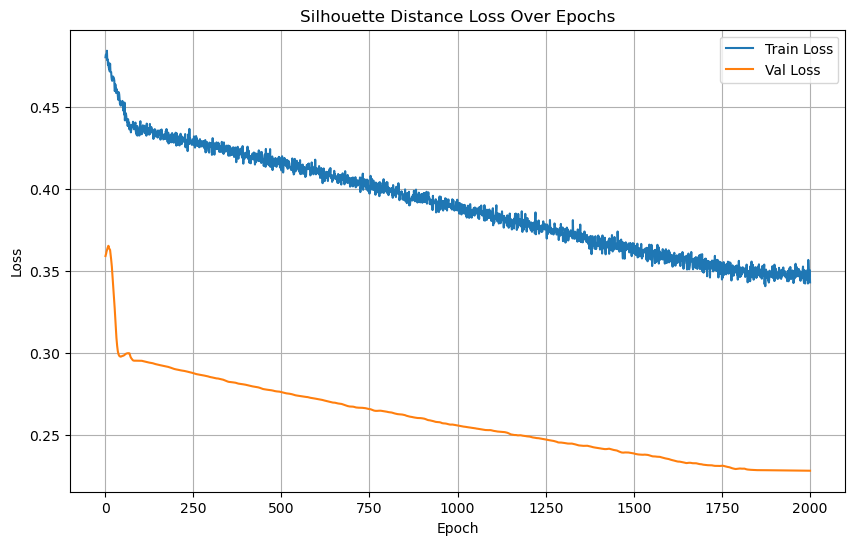

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/46], Loss: 0.2179


Test Batch [20/46], Loss: 0.2116
Test Batch [30/46], Loss: 0.3057
Test Batch [40/46], Loss: 0.2386

Test Loss: 0.2547


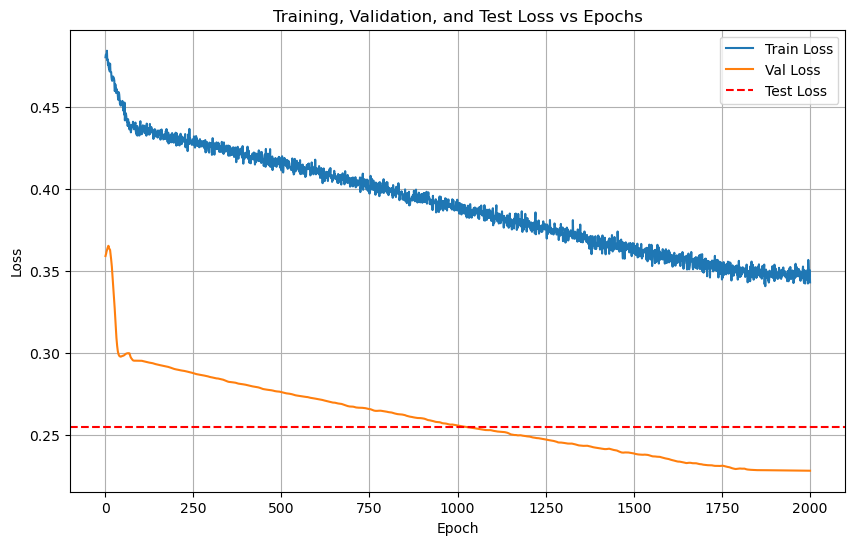

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/46 for test dataset.
  Processed batch 20/46 for test dataset.


  Processed batch 30/46 for test dataset.
  Processed batch 40/46 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (280, 128)
Train labels shape: (280,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2898, 128)
Test labels shape: (2898,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 87.14%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       0.80      0.80      0.80         5
           3       1.00      0.80      0.89         5
           4       0.75      0.60      0.67         5
           5       0.67      0.80      0.73         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       1.00      0.80      0.89         5
           9       0.62      1.00      0.77         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.60      0.60      0.60         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (280, 128)
Train labels shape: (280,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (2898, 128)
Test labels shape: (2898,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6535  |  Val Loss: 2.6180
Validation loss improved from inf to 2.6180.
[Epoch 2/1000] Train Loss: 2.6163  |  Val Loss: 2.5817
Validation loss improved from 2.6180 to 2.5817.
[Epoch 3/1000] Train Loss: 2.5789  |  Val Loss: 2.5470
Validation loss improved from 2.5817 to 2.5470.
[Epoch 4/1000] Train Loss: 2.5443  |  Val Loss: 2.5146
Validation loss improved from 2.5470 to 2.5146.
[Epoch 5/1000] Train Loss: 2.5098  |  Val Loss: 2.4836
Validation loss improved from 2.5146 to 2.4836.
[Epoch 6/1000] Train Loss: 2.4769  |  Val Loss: 2.4537
Validation loss improved from 2.4836 to 2.4537.
[Epoch 7/1000] Train Loss: 2.4463  |  Val Loss: 2.4260
Validation loss improved from 2.4537 to 2.4260.
[Epoch 8/1000] Train Loss: 2.4173  |  Val Loss: 2.4005
Validation loss improved from 2.4260 to 2.4005.
[Epoch 9/1000] Train Loss: 2.3919  |  Val Loss: 2.3757
Validation loss improved from 2.4005 to 2.3757.
[Epoch 10/1000] Train Loss: 2.3655  |  Val Loss: 2.3519
Validation loss impr

[Epoch 12/1000] Train Loss: 2.3169  |  Val Loss: 2.3071
Validation loss improved from 2.3289 to 2.3071.
[Epoch 13/1000] Train Loss: 2.2943  |  Val Loss: 2.2856
Validation loss improved from 2.3071 to 2.2856.
[Epoch 14/1000] Train Loss: 2.2713  |  Val Loss: 2.2641
Validation loss improved from 2.2856 to 2.2641.
[Epoch 15/1000] Train Loss: 2.2488  |  Val Loss: 2.2424
Validation loss improved from 2.2641 to 2.2424.
[Epoch 16/1000] Train Loss: 2.2267  |  Val Loss: 2.2204
Validation loss improved from 2.2424 to 2.2204.
[Epoch 17/1000] Train Loss: 2.2037  |  Val Loss: 2.1992
Validation loss improved from 2.2204 to 2.1992.


[Epoch 18/1000] Train Loss: 2.1822  |  Val Loss: 2.1780
Validation loss improved from 2.1992 to 2.1780.
[Epoch 19/1000] Train Loss: 2.1598  |  Val Loss: 2.1576
Validation loss improved from 2.1780 to 2.1576.
[Epoch 20/1000] Train Loss: 2.1385  |  Val Loss: 2.1370
Validation loss improved from 2.1576 to 2.1370.
[Epoch 21/1000] Train Loss: 2.1161  |  Val Loss: 2.1168
Validation loss improved from 2.1370 to 2.1168.
[Epoch 22/1000] Train Loss: 2.0952  |  Val Loss: 2.0962
Validation loss improved from 2.1168 to 2.0962.
[Epoch 23/1000] Train Loss: 2.0738  |  Val Loss: 2.0755
Validation loss improved from 2.0962 to 2.0755.
[Epoch 24/1000] Train Loss: 2.0517  |  Val Loss: 2.0551
Validation loss improved from 2.0755 to 2.0551.
[Epoch 25/1000] Train Loss: 2.0307  |  Val Loss: 2.0349
Validation loss improved from 2.0551 to 2.0349.
[Epoch 26/1000] Train Loss: 2.0091  |  Val Loss: 2.0161
Validation loss improved from 2.0349 to 2.0161.
[Epoch 27/1000] Train Loss: 1.9888  |  Val Loss: 1.9977
Validati

[Epoch 31/1000] Train Loss: 1.9112  |  Val Loss: 1.9264
Validation loss improved from 1.9440 to 1.9264.
[Epoch 32/1000] Train Loss: 1.8920  |  Val Loss: 1.9091
Validation loss improved from 1.9264 to 1.9091.
[Epoch 33/1000] Train Loss: 1.8731  |  Val Loss: 1.8922
Validation loss improved from 1.9091 to 1.8922.
[Epoch 34/1000] Train Loss: 1.8544  |  Val Loss: 1.8751
Validation loss improved from 1.8922 to 1.8751.
[Epoch 35/1000] Train Loss: 1.8361  |  Val Loss: 1.8579
Validation loss improved from 1.8751 to 1.8579.


[Epoch 36/1000] Train Loss: 1.8170  |  Val Loss: 1.8410
Validation loss improved from 1.8579 to 1.8410.
[Epoch 37/1000] Train Loss: 1.7983  |  Val Loss: 1.8243
Validation loss improved from 1.8410 to 1.8243.
[Epoch 38/1000] Train Loss: 1.7797  |  Val Loss: 1.8071
Validation loss improved from 1.8243 to 1.8071.
[Epoch 39/1000] Train Loss: 1.7609  |  Val Loss: 1.7900
Validation loss improved from 1.8071 to 1.7900.
[Epoch 40/1000] Train Loss: 1.7419  |  Val Loss: 1.7729
Validation loss improved from 1.7900 to 1.7729.
[Epoch 41/1000] Train Loss: 1.7231  |  Val Loss: 1.7558
Validation loss improved from 1.7729 to 1.7558.
[Epoch 42/1000] Train Loss: 1.7036  |  Val Loss: 1.7389
Validation loss improved from 1.7558 to 1.7389.
[Epoch 43/1000] Train Loss: 1.6846  |  Val Loss: 1.7219
Validation loss improved from 1.7389 to 1.7219.
[Epoch 44/1000] Train Loss: 1.6655  |  Val Loss: 1.7046
Validation loss improved from 1.7219 to 1.7046.
[Epoch 45/1000] Train Loss: 1.6461  |  Val Loss: 1.6873
Validati

[Epoch 49/1000] Train Loss: 1.5690  |  Val Loss: 1.6184
Validation loss improved from 1.6356 to 1.6184.
[Epoch 50/1000] Train Loss: 1.5502  |  Val Loss: 1.6012
Validation loss improved from 1.6184 to 1.6012.
[Epoch 51/1000] Train Loss: 1.5304  |  Val Loss: 1.5840
Validation loss improved from 1.6012 to 1.5840.
[Epoch 52/1000] Train Loss: 1.5111  |  Val Loss: 1.5666
Validation loss improved from 1.5840 to 1.5666.
[Epoch 53/1000] Train Loss: 1.4915  |  Val Loss: 1.5494
Validation loss improved from 1.5666 to 1.5494.


[Epoch 54/1000] Train Loss: 1.4720  |  Val Loss: 1.5323
Validation loss improved from 1.5494 to 1.5323.
[Epoch 55/1000] Train Loss: 1.4532  |  Val Loss: 1.5151
Validation loss improved from 1.5323 to 1.5151.
[Epoch 56/1000] Train Loss: 1.4334  |  Val Loss: 1.4979
Validation loss improved from 1.5151 to 1.4979.
[Epoch 57/1000] Train Loss: 1.4136  |  Val Loss: 1.4808
Validation loss improved from 1.4979 to 1.4808.
[Epoch 58/1000] Train Loss: 1.3946  |  Val Loss: 1.4633
Validation loss improved from 1.4808 to 1.4633.
[Epoch 59/1000] Train Loss: 1.3751  |  Val Loss: 1.4461
Validation loss improved from 1.4633 to 1.4461.
[Epoch 60/1000] Train Loss: 1.3555  |  Val Loss: 1.4289
Validation loss improved from 1.4461 to 1.4289.
[Epoch 61/1000] Train Loss: 1.3363  |  Val Loss: 1.4119
Validation loss improved from 1.4289 to 1.4119.
[Epoch 62/1000] Train Loss: 1.3166  |  Val Loss: 1.3949
Validation loss improved from 1.4119 to 1.3949.
[Epoch 63/1000] Train Loss: 1.2976  |  Val Loss: 1.3777
Validati

[Epoch 70/1000] Train Loss: 1.1655  |  Val Loss: 1.2629
Validation loss improved from 1.2789 to 1.2629.
[Epoch 71/1000] Train Loss: 1.1476  |  Val Loss: 1.2469
Validation loss improved from 1.2629 to 1.2469.
[Epoch 72/1000] Train Loss: 1.1298  |  Val Loss: 1.2310
Validation loss improved from 1.2469 to 1.2310.


[Epoch 73/1000] Train Loss: 1.1120  |  Val Loss: 1.2155
Validation loss improved from 1.2310 to 1.2155.
[Epoch 74/1000] Train Loss: 1.0945  |  Val Loss: 1.2003
Validation loss improved from 1.2155 to 1.2003.
[Epoch 75/1000] Train Loss: 1.0775  |  Val Loss: 1.1852
Validation loss improved from 1.2003 to 1.1852.
[Epoch 76/1000] Train Loss: 1.0605  |  Val Loss: 1.1706
Validation loss improved from 1.1852 to 1.1706.
[Epoch 77/1000] Train Loss: 1.0438  |  Val Loss: 1.1562
Validation loss improved from 1.1706 to 1.1562.
[Epoch 78/1000] Train Loss: 1.0269  |  Val Loss: 1.1424
Validation loss improved from 1.1562 to 1.1424.
[Epoch 79/1000] Train Loss: 1.0104  |  Val Loss: 1.1286
Validation loss improved from 1.1424 to 1.1286.
[Epoch 80/1000] Train Loss: 0.9944  |  Val Loss: 1.1148
Validation loss improved from 1.1286 to 1.1148.
[Epoch 81/1000] Train Loss: 0.9785  |  Val Loss: 1.1014
Validation loss improved from 1.1148 to 1.1014.
[Epoch 82/1000] Train Loss: 0.9624  |  Val Loss: 1.0882
Validati

[Epoch 87/1000] Train Loss: 0.8885  |  Val Loss: 1.0261
Validation loss improved from 1.0379 to 1.0261.
[Epoch 88/1000] Train Loss: 0.8747  |  Val Loss: 1.0150
Validation loss improved from 1.0261 to 1.0150.
[Epoch 89/1000] Train Loss: 0.8608  |  Val Loss: 1.0041
Validation loss improved from 1.0150 to 1.0041.
[Epoch 90/1000] Train Loss: 0.8473  |  Val Loss: 0.9933
Validation loss improved from 1.0041 to 0.9933.
[Epoch 91/1000] Train Loss: 0.8343  |  Val Loss: 0.9828
Validation loss improved from 0.9933 to 0.9828.


[Epoch 92/1000] Train Loss: 0.8210  |  Val Loss: 0.9727
Validation loss improved from 0.9828 to 0.9727.
[Epoch 93/1000] Train Loss: 0.8083  |  Val Loss: 0.9626
Validation loss improved from 0.9727 to 0.9626.
[Epoch 94/1000] Train Loss: 0.7959  |  Val Loss: 0.9527
Validation loss improved from 0.9626 to 0.9527.
[Epoch 95/1000] Train Loss: 0.7839  |  Val Loss: 0.9425
Validation loss improved from 0.9527 to 0.9425.
[Epoch 96/1000] Train Loss: 0.7713  |  Val Loss: 0.9327
Validation loss improved from 0.9425 to 0.9327.
[Epoch 97/1000] Train Loss: 0.7592  |  Val Loss: 0.9230
Validation loss improved from 0.9327 to 0.9230.
[Epoch 98/1000] Train Loss: 0.7474  |  Val Loss: 0.9136
Validation loss improved from 0.9230 to 0.9136.
[Epoch 99/1000] Train Loss: 0.7353  |  Val Loss: 0.9042
Validation loss improved from 0.9136 to 0.9042.
[Epoch 100/1000] Train Loss: 0.7236  |  Val Loss: 0.8948
Validation loss improved from 0.9042 to 0.8948.
[Epoch 101/1000] Train Loss: 0.7120  |  Val Loss: 0.8854
Valida

[Epoch 104/1000] Train Loss: 0.6779  |  Val Loss: 0.8589
Validation loss improved from 0.8674 to 0.8589.
[Epoch 105/1000] Train Loss: 0.6664  |  Val Loss: 0.8502
Validation loss improved from 0.8589 to 0.8502.
[Epoch 106/1000] Train Loss: 0.6554  |  Val Loss: 0.8415
Validation loss improved from 0.8502 to 0.8415.
[Epoch 107/1000] Train Loss: 0.6445  |  Val Loss: 0.8333
Validation loss improved from 0.8415 to 0.8333.
[Epoch 108/1000] Train Loss: 0.6341  |  Val Loss: 0.8249
Validation loss improved from 0.8333 to 0.8249.
[Epoch 109/1000] Train Loss: 0.6237  |  Val Loss: 0.8165
Validation loss improved from 0.8249 to 0.8165.
[Epoch 110/1000] Train Loss: 0.6138  |  Val Loss: 0.8084
Validation loss improved from 0.8165 to 0.8084.


[Epoch 111/1000] Train Loss: 0.6035  |  Val Loss: 0.8006
Validation loss improved from 0.8084 to 0.8006.
[Epoch 112/1000] Train Loss: 0.5938  |  Val Loss: 0.7927
Validation loss improved from 0.8006 to 0.7927.
[Epoch 113/1000] Train Loss: 0.5840  |  Val Loss: 0.7853
Validation loss improved from 0.7927 to 0.7853.
[Epoch 114/1000] Train Loss: 0.5747  |  Val Loss: 0.7780
Validation loss improved from 0.7853 to 0.7780.
[Epoch 115/1000] Train Loss: 0.5652  |  Val Loss: 0.7712
Validation loss improved from 0.7780 to 0.7712.
[Epoch 116/1000] Train Loss: 0.5557  |  Val Loss: 0.7642
Validation loss improved from 0.7712 to 0.7642.
[Epoch 117/1000] Train Loss: 0.5468  |  Val Loss: 0.7577
Validation loss improved from 0.7642 to 0.7577.
[Epoch 118/1000] Train Loss: 0.5374  |  Val Loss: 0.7506
Validation loss improved from 0.7577 to 0.7506.
[Epoch 119/1000] Train Loss: 0.5285  |  Val Loss: 0.7438
Validation loss improved from 0.7506 to 0.7438.
[Epoch 120/1000] Train Loss: 0.5198  |  Val Loss: 0.737

[Epoch 122/1000] Train Loss: 0.5025  |  Val Loss: 0.7241
Validation loss improved from 0.7303 to 0.7241.
[Epoch 123/1000] Train Loss: 0.4939  |  Val Loss: 0.7179
Validation loss improved from 0.7241 to 0.7179.
[Epoch 124/1000] Train Loss: 0.4856  |  Val Loss: 0.7114
Validation loss improved from 0.7179 to 0.7114.
[Epoch 125/1000] Train Loss: 0.4772  |  Val Loss: 0.7048
Validation loss improved from 0.7114 to 0.7048.
[Epoch 126/1000] Train Loss: 0.4685  |  Val Loss: 0.6988
Validation loss improved from 0.7048 to 0.6988.
[Epoch 127/1000] Train Loss: 0.4606  |  Val Loss: 0.6926
Validation loss improved from 0.6988 to 0.6926.
[Epoch 128/1000] Train Loss: 0.4525  |  Val Loss: 0.6865
Validation loss improved from 0.6926 to 0.6865.


[Epoch 129/1000] Train Loss: 0.4447  |  Val Loss: 0.6803
Validation loss improved from 0.6865 to 0.6803.
[Epoch 130/1000] Train Loss: 0.4373  |  Val Loss: 0.6743
Validation loss improved from 0.6803 to 0.6743.
[Epoch 131/1000] Train Loss: 0.4294  |  Val Loss: 0.6684
Validation loss improved from 0.6743 to 0.6684.
[Epoch 132/1000] Train Loss: 0.4223  |  Val Loss: 0.6629
Validation loss improved from 0.6684 to 0.6629.
[Epoch 133/1000] Train Loss: 0.4145  |  Val Loss: 0.6575
Validation loss improved from 0.6629 to 0.6575.
[Epoch 134/1000] Train Loss: 0.4072  |  Val Loss: 0.6518
Validation loss improved from 0.6575 to 0.6518.
[Epoch 135/1000] Train Loss: 0.4000  |  Val Loss: 0.6467
Validation loss improved from 0.6518 to 0.6467.
[Epoch 136/1000] Train Loss: 0.3933  |  Val Loss: 0.6418
Validation loss improved from 0.6467 to 0.6418.
[Epoch 137/1000] Train Loss: 0.3866  |  Val Loss: 0.6364
Validation loss improved from 0.6418 to 0.6364.
[Epoch 138/1000] Train Loss: 0.3799  |  Val Loss: 0.631

[Epoch 140/1000] Train Loss: 0.3677  |  Val Loss: 0.6229
Validation loss improved from 0.6270 to 0.6229.
[Epoch 141/1000] Train Loss: 0.3616  |  Val Loss: 0.6181
Validation loss improved from 0.6229 to 0.6181.
[Epoch 142/1000] Train Loss: 0.3555  |  Val Loss: 0.6138
Validation loss improved from 0.6181 to 0.6138.
[Epoch 143/1000] Train Loss: 0.3498  |  Val Loss: 0.6096
Validation loss improved from 0.6138 to 0.6096.
[Epoch 144/1000] Train Loss: 0.3442  |  Val Loss: 0.6056
Validation loss improved from 0.6096 to 0.6056.


[Epoch 145/1000] Train Loss: 0.3393  |  Val Loss: 0.6016
Validation loss improved from 0.6056 to 0.6016.
[Epoch 146/1000] Train Loss: 0.3340  |  Val Loss: 0.5982
Validation loss improved from 0.6016 to 0.5982.
[Epoch 147/1000] Train Loss: 0.3288  |  Val Loss: 0.5949
Validation loss improved from 0.5982 to 0.5949.
[Epoch 148/1000] Train Loss: 0.3237  |  Val Loss: 0.5913
Validation loss improved from 0.5949 to 0.5913.
[Epoch 149/1000] Train Loss: 0.3188  |  Val Loss: 0.5877
Validation loss improved from 0.5913 to 0.5877.
[Epoch 150/1000] Train Loss: 0.3140  |  Val Loss: 0.5842
Validation loss improved from 0.5877 to 0.5842.
[Epoch 151/1000] Train Loss: 0.3095  |  Val Loss: 0.5811
Validation loss improved from 0.5842 to 0.5811.
[Epoch 152/1000] Train Loss: 0.3050  |  Val Loss: 0.5785
Validation loss improved from 0.5811 to 0.5785.
[Epoch 153/1000] Train Loss: 0.3007  |  Val Loss: 0.5760
Validation loss improved from 0.5785 to 0.5760.
[Epoch 154/1000] Train Loss: 0.2964  |  Val Loss: 0.573

[Epoch 158/1000] Train Loss: 0.2799  |  Val Loss: 0.5616
Validation loss improved from 0.5642 to 0.5616.
[Epoch 159/1000] Train Loss: 0.2766  |  Val Loss: 0.5591
Validation loss improved from 0.5616 to 0.5591.
[Epoch 160/1000] Train Loss: 0.2729  |  Val Loss: 0.5564
Validation loss improved from 0.5591 to 0.5564.
[Epoch 161/1000] Train Loss: 0.2691  |  Val Loss: 0.5538
Validation loss improved from 0.5564 to 0.5538.
[Epoch 162/1000] Train Loss: 0.2655  |  Val Loss: 0.5517
Validation loss improved from 0.5538 to 0.5517.


[Epoch 163/1000] Train Loss: 0.2621  |  Val Loss: 0.5497
Validation loss improved from 0.5517 to 0.5497.
[Epoch 164/1000] Train Loss: 0.2591  |  Val Loss: 0.5476
Validation loss improved from 0.5497 to 0.5476.
[Epoch 165/1000] Train Loss: 0.2557  |  Val Loss: 0.5456
Validation loss improved from 0.5476 to 0.5456.
[Epoch 166/1000] Train Loss: 0.2523  |  Val Loss: 0.5440
Validation loss improved from 0.5456 to 0.5440.
[Epoch 167/1000] Train Loss: 0.2491  |  Val Loss: 0.5423
Validation loss improved from 0.5440 to 0.5423.
[Epoch 168/1000] Train Loss: 0.2461  |  Val Loss: 0.5408
Validation loss improved from 0.5423 to 0.5408.
[Epoch 169/1000] Train Loss: 0.2429  |  Val Loss: 0.5396
Validation loss improved from 0.5408 to 0.5396.
[Epoch 170/1000] Train Loss: 0.2402  |  Val Loss: 0.5385
Validation loss improved from 0.5396 to 0.5385.
[Epoch 171/1000] Train Loss: 0.2374  |  Val Loss: 0.5373
Validation loss improved from 0.5385 to 0.5373.
[Epoch 172/1000] Train Loss: 0.2346  |  Val Loss: 0.536

[Epoch 175/1000] Train Loss: 0.2263  |  Val Loss: 0.5306
Validation loss improved from 0.5323 to 0.5306.
[Epoch 176/1000] Train Loss: 0.2244  |  Val Loss: 0.5287
Validation loss improved from 0.5306 to 0.5287.
[Epoch 177/1000] Train Loss: 0.2215  |  Val Loss: 0.5276
Validation loss improved from 0.5287 to 0.5276.
[Epoch 178/1000] Train Loss: 0.2191  |  Val Loss: 0.5268
Validation loss improved from 0.5276 to 0.5268.
[Epoch 179/1000] Train Loss: 0.2165  |  Val Loss: 0.5257
Validation loss improved from 0.5268 to 0.5257.


[Epoch 180/1000] Train Loss: 0.2140  |  Val Loss: 0.5242
Validation loss improved from 0.5257 to 0.5242.
[Epoch 181/1000] Train Loss: 0.2114  |  Val Loss: 0.5228
Validation loss improved from 0.5242 to 0.5228.
[Epoch 182/1000] Train Loss: 0.2093  |  Val Loss: 0.5217
Validation loss improved from 0.5228 to 0.5217.
[Epoch 183/1000] Train Loss: 0.2070  |  Val Loss: 0.5206
Validation loss improved from 0.5217 to 0.5206.
[Epoch 184/1000] Train Loss: 0.2050  |  Val Loss: 0.5200
Validation loss improved from 0.5206 to 0.5200.
[Epoch 185/1000] Train Loss: 0.2026  |  Val Loss: 0.5195
Validation loss improved from 0.5200 to 0.5195.
[Epoch 186/1000] Train Loss: 0.2006  |  Val Loss: 0.5186
Validation loss improved from 0.5195 to 0.5186.
[Epoch 187/1000] Train Loss: 0.1985  |  Val Loss: 0.5180
Validation loss improved from 0.5186 to 0.5180.
[Epoch 188/1000] Train Loss: 0.1966  |  Val Loss: 0.5169
Validation loss improved from 0.5180 to 0.5169.
[Epoch 189/1000] Train Loss: 0.1945  |  Val Loss: 0.516

[Epoch 192/1000] Train Loss: 0.1893  |  Val Loss: 0.5151
Validation loss improved from 0.5156 to 0.5151.
[Epoch 193/1000] Train Loss: 0.1869  |  Val Loss: 0.5150
Validation loss improved from 0.5151 to 0.5150.
[Epoch 194/1000] Train Loss: 0.1854  |  Val Loss: 0.5148
Validation loss improved from 0.5150 to 0.5148.
[Epoch 195/1000] Train Loss: 0.1834  |  Val Loss: 0.5137
Validation loss improved from 0.5148 to 0.5137.
[Epoch 196/1000] Train Loss: 0.1817  |  Val Loss: 0.5130
Validation loss improved from 0.5137 to 0.5130.


[Epoch 197/1000] Train Loss: 0.1802  |  Val Loss: 0.5125
Validation loss improved from 0.5130 to 0.5125.
[Epoch 198/1000] Train Loss: 0.1785  |  Val Loss: 0.5118
Validation loss improved from 0.5125 to 0.5118.
[Epoch 199/1000] Train Loss: 0.1771  |  Val Loss: 0.5107
Validation loss improved from 0.5118 to 0.5107.
[Epoch 200/1000] Train Loss: 0.1754  |  Val Loss: 0.5099
Validation loss improved from 0.5107 to 0.5099.
[Epoch 201/1000] Train Loss: 0.1738  |  Val Loss: 0.5095
Validation loss improved from 0.5099 to 0.5095.
[Epoch 202/1000] Train Loss: 0.1723  |  Val Loss: 0.5093
Validation loss improved from 0.5095 to 0.5093.
[Epoch 203/1000] Train Loss: 0.1707  |  Val Loss: 0.5085
Validation loss improved from 0.5093 to 0.5085.
[Epoch 204/1000] Train Loss: 0.1692  |  Val Loss: 0.5081
Validation loss improved from 0.5085 to 0.5081.
[Epoch 205/1000] Train Loss: 0.1679  |  Val Loss: 0.5075
Validation loss improved from 0.5081 to 0.5075.
[Epoch 206/1000] Train Loss: 0.1665  |  Val Loss: 0.507

[Epoch 208/1000] Train Loss: 0.1632  |  Val Loss: 0.5088
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 209/1000] Train Loss: 0.1620  |  Val Loss: 0.5093
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 210/1000] Train Loss: 0.1606  |  Val Loss: 0.5098
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 211/1000] Train Loss: 0.1591  |  Val Loss: 0.5105
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 212/1000] Train Loss: 0.1579  |  Val Loss: 0.5107
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 213/1000] Train Loss: 0.1566  |  Val Loss: 0.5102
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 214/1000] Train Loss: 0.1554  |  Val Loss: 0.5103
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 215/1000] Train Loss: 0.1543  |  Val Loss: 0.5105
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 216/1000] Train Loss: 0.1529  |  Val Loss: 0.5110
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 217/1000] Train Loss: 0.1518  |  Val Loss: 0.5109
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 218/1000] Train Loss: 0.1505  |  Val Loss: 0.5104
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 219/1000] Train Loss: 0.1494  |  Val Loss: 0.5100
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 220/1000] Train Loss: 0.1482  |  Val Loss: 0.5104
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 221/1000] Train Loss: 0.1471  |  Val Loss: 0.5109
!! Validation loss did NOT improve !! Patience: 1

[Epoch 225/1000] Train Loss: 0.1428  |  Val Loss: 0.5087
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 226/1000] Train Loss: 0.1417  |  Val Loss: 0.5089
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 227/1000] Train Loss: 0.1406  |  Val Loss: 0.5101
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 228/1000] Train Loss: 0.1400  |  Val Loss: 0.5113
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 229/1000] Train Loss: 0.1387  |  Val Loss: 0.5114
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 230/1000] Train Loss: 0.1377  |  Val Loss: 0.5116
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 231/1000] Train Loss: 0.1367  |  Val Loss: 0.5113
!! Validation loss did NOT improve !! Patience: 26/100


[Epoch 232/1000] Train Loss: 0.1358  |  Val Loss: 0.5113
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 233/1000] Train Loss: 0.1347  |  Val Loss: 0.5111
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 234/1000] Train Loss: 0.1339  |  Val Loss: 0.5109
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 235/1000] Train Loss: 0.1329  |  Val Loss: 0.5113
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 236/1000] Train Loss: 0.1319  |  Val Loss: 0.5112
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 237/1000] Train Loss: 0.1311  |  Val Loss: 0.5112
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 238/1000] Train Loss: 0.1302  |  Val Loss: 0.5113
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 239/1000] Train Loss: 0.1293  |  Val Loss: 0.5121
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 240/1000] Train Loss: 0.1284  |  Val Loss: 0.5131
!! Validation loss did NOT improve !! Patience:

[Epoch 242/1000] Train Loss: 0.1266  |  Val Loss: 0.5151
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 243/1000] Train Loss: 0.1260  |  Val Loss: 0.5156
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 244/1000] Train Loss: 0.1254  |  Val Loss: 0.5146
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 245/1000] Train Loss: 0.1240  |  Val Loss: 0.5148
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 246/1000] Train Loss: 0.1232  |  Val Loss: 0.5149
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 247/1000] Train Loss: 0.1224  |  Val Loss: 0.5145
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 248/1000] Train Loss: 0.1216  |  Val Loss: 0.5146
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 249/1000] Train Loss: 0.1211  |  Val Loss: 0.5147
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 250/1000] Train Loss: 0.1200  |  Val Loss: 0.5152
!! Validation loss did NOT improve !! Patience:

[Epoch 252/1000] Train Loss: 0.1187  |  Val Loss: 0.5156
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 253/1000] Train Loss: 0.1179  |  Val Loss: 0.5163
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 254/1000] Train Loss: 0.1171  |  Val Loss: 0.5165
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 255/1000] Train Loss: 0.1162  |  Val Loss: 0.5175
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 256/1000] Train Loss: 0.1153  |  Val Loss: 0.5182
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 257/1000] Train Loss: 0.1146  |  Val Loss: 0.5185
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 258/1000] Train Loss: 0.1139  |  Val Loss: 0.5192
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 259/1000] Train Loss: 0.1132  |  Val Loss: 0.5196
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 260/1000] Train Loss: 0.1125  |  Val Loss: 0.5200
!! Validation loss did NOT improve !! Patience:

[Epoch 262/1000] Train Loss: 0.1112  |  Val Loss: 0.5208
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 263/1000] Train Loss: 0.1106  |  Val Loss: 0.5206
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 264/1000] Train Loss: 0.1098  |  Val Loss: 0.5202
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 265/1000] Train Loss: 0.1091  |  Val Loss: 0.5204
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 266/1000] Train Loss: 0.1085  |  Val Loss: 0.5198
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 267/1000] Train Loss: 0.1082  |  Val Loss: 0.5199
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 268/1000] Train Loss: 0.1072  |  Val Loss: 0.5202
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 269/1000] Train Loss: 0.1066  |  Val Loss: 0.5210
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 270/1000] Train Loss: 0.1060  |  Val Loss: 0.5212
!! Validation loss did NOT improve !! Patience:

[Epoch 272/1000] Train Loss: 0.1051  |  Val Loss: 0.5233
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 273/1000] Train Loss: 0.1042  |  Val Loss: 0.5234
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 274/1000] Train Loss: 0.1038  |  Val Loss: 0.5228
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 275/1000] Train Loss: 0.1029  |  Val Loss: 0.5233
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 276/1000] Train Loss: 0.1023  |  Val Loss: 0.5237
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 277/1000] Train Loss: 0.1017  |  Val Loss: 0.5238
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 278/1000] Train Loss: 0.1012  |  Val Loss: 0.5237
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 279/1000] Train Loss: 0.1005  |  Val Loss: 0.5240
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 280/1000] Train Loss: 0.0998  |  Val Loss: 0.5250
!! Validation loss did NOT improve !! Patience:

[Epoch 282/1000] Train Loss: 0.0987  |  Val Loss: 0.5251
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 283/1000] Train Loss: 0.0980  |  Val Loss: 0.5257
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 284/1000] Train Loss: 0.0975  |  Val Loss: 0.5259
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 285/1000] Train Loss: 0.0970  |  Val Loss: 0.5265
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 286/1000] Train Loss: 0.0969  |  Val Loss: 0.5269
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 287/1000] Train Loss: 0.0964  |  Val Loss: 0.5269
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 288/1000] Train Loss: 0.0957  |  Val Loss: 0.5272
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 289/1000] Train Loss: 0.0953  |  Val Loss: 0.5274
!! Validation loss did NOT improve !! Patience: 84/100


[Epoch 290/1000] Train Loss: 0.0944  |  Val Loss: 0.5282
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 291/1000] Train Loss: 0.0939  |  Val Loss: 0.5286
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 292/1000] Train Loss: 0.0933  |  Val Loss: 0.5282
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 293/1000] Train Loss: 0.0926  |  Val Loss: 0.5287
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 294/1000] Train Loss: 0.0922  |  Val Loss: 0.5292
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 295/1000] Train Loss: 0.0915  |  Val Loss: 0.5291
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 296/1000] Train Loss: 0.0911  |  Val Loss: 0.5294
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 297/1000] Train Loss: 0.0908  |  Val Loss: 0.5298
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 298/1000] Train Loss: 0.0902  |  Val Loss: 0.5305
!! Validation loss did NOT improve !! Patience:

[Epoch 300/1000] Train Loss: 0.0891  |  Val Loss: 0.5316
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 301/1000] Train Loss: 0.0887  |  Val Loss: 0.5320
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 302/1000] Train Loss: 0.0881  |  Val Loss: 0.5329
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 303/1000] Train Loss: 0.0879  |  Val Loss: 0.5344
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 304/1000] Train Loss: 0.0874  |  Val Loss: 0.5353
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 305/1000] Train Loss: 0.0869  |  Val Loss: 0.5355
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 305 !!
No improvement for 100 epochs.


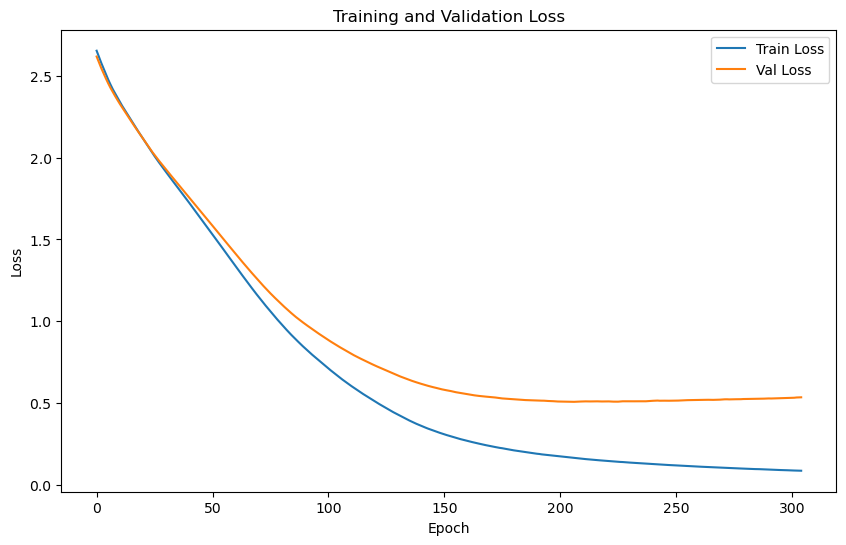

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.3939 | Test Accuracy: 87.44%


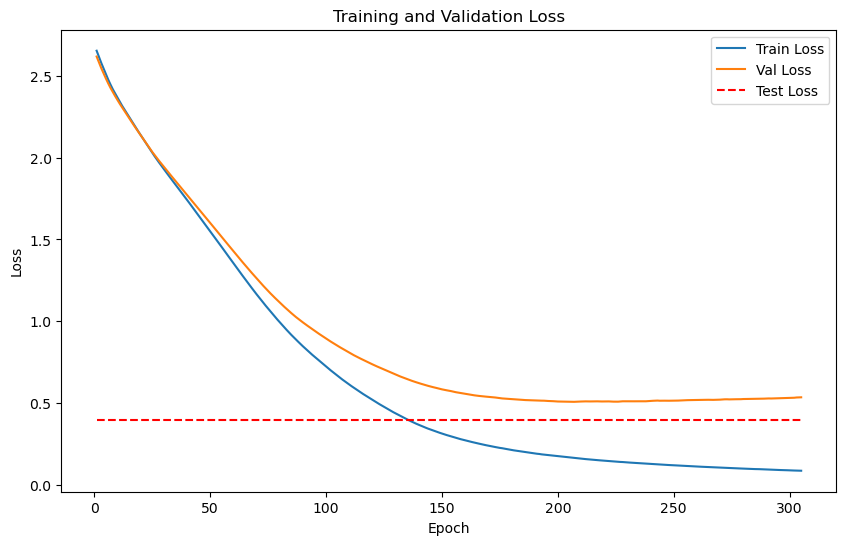

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


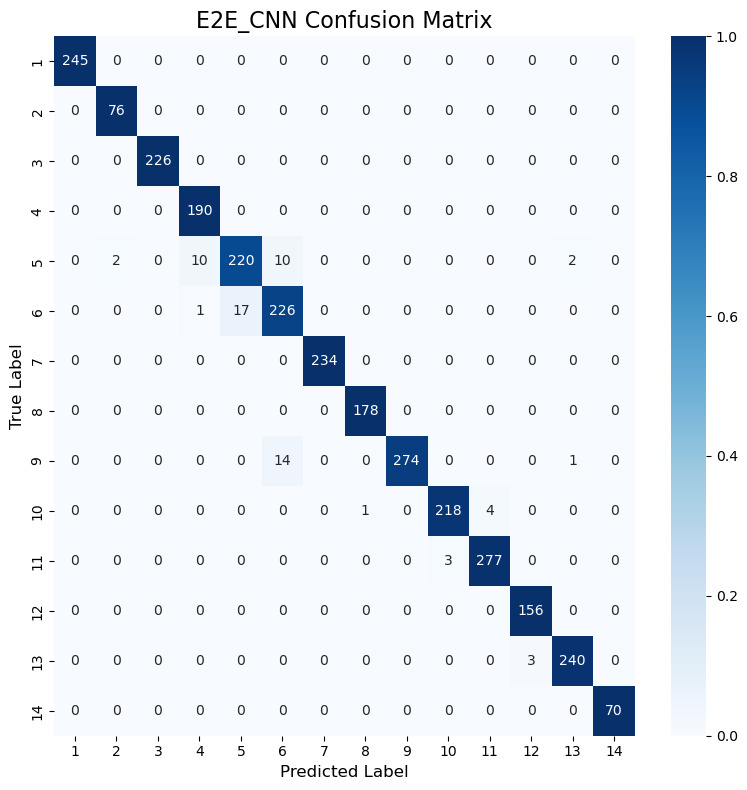

Classification Accuracy: 97.65%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


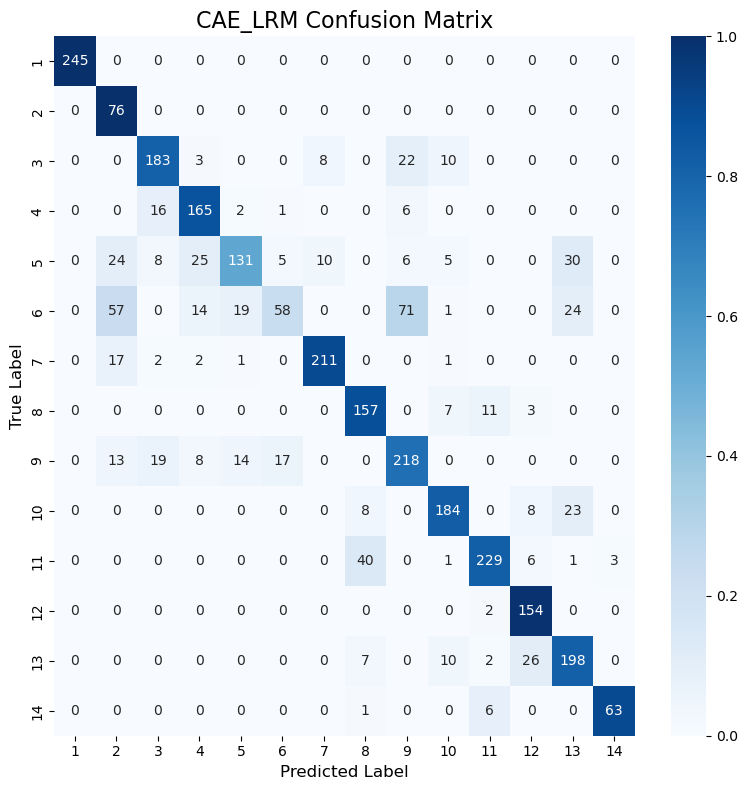

Classification Accuracy: 78.40%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


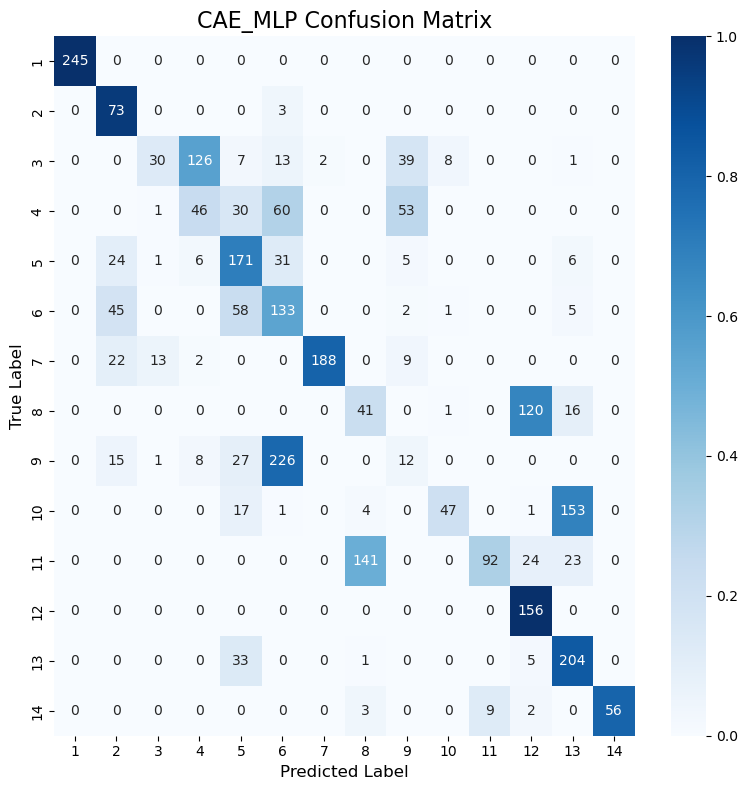

Classification Accuracy: 51.55%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


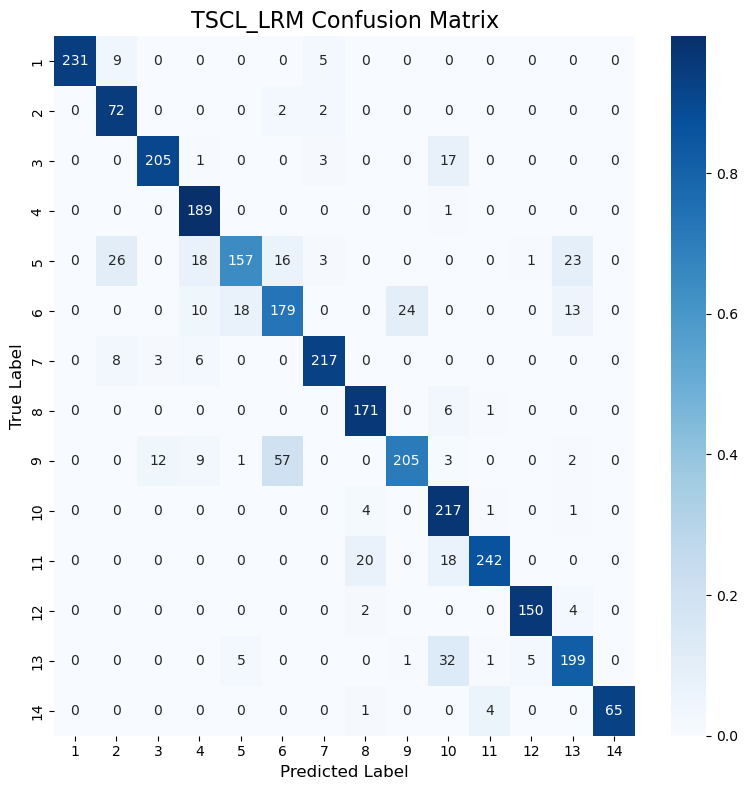

Classification Accuracy: 86.23%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


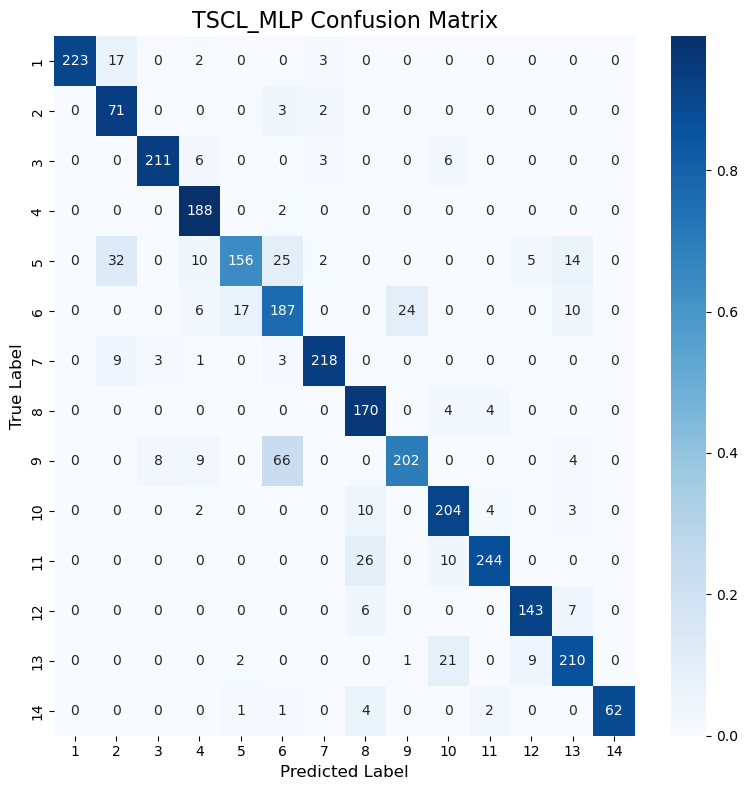

Classification Accuracy: 85.89%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


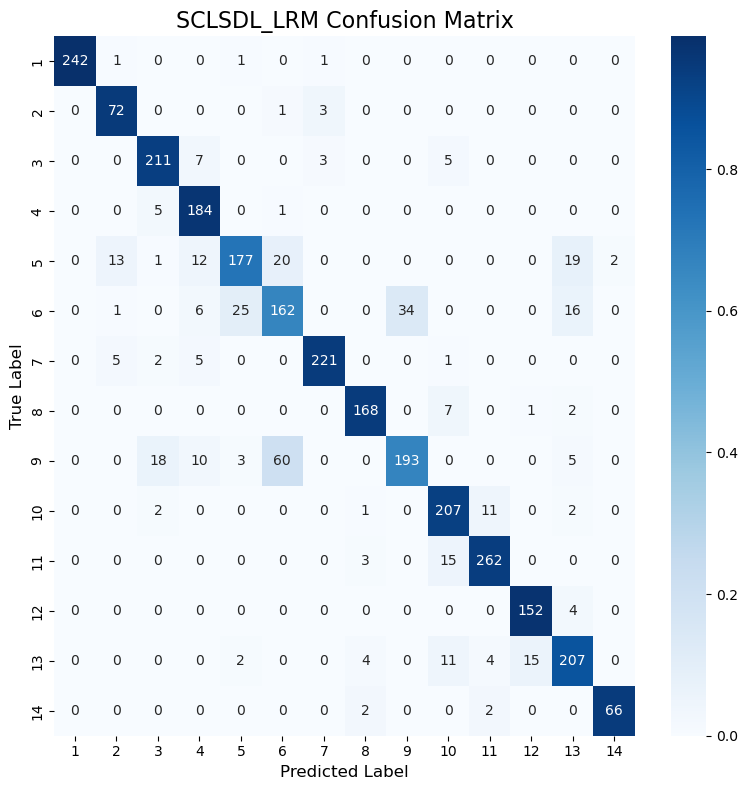

Classification Accuracy: 87.09%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


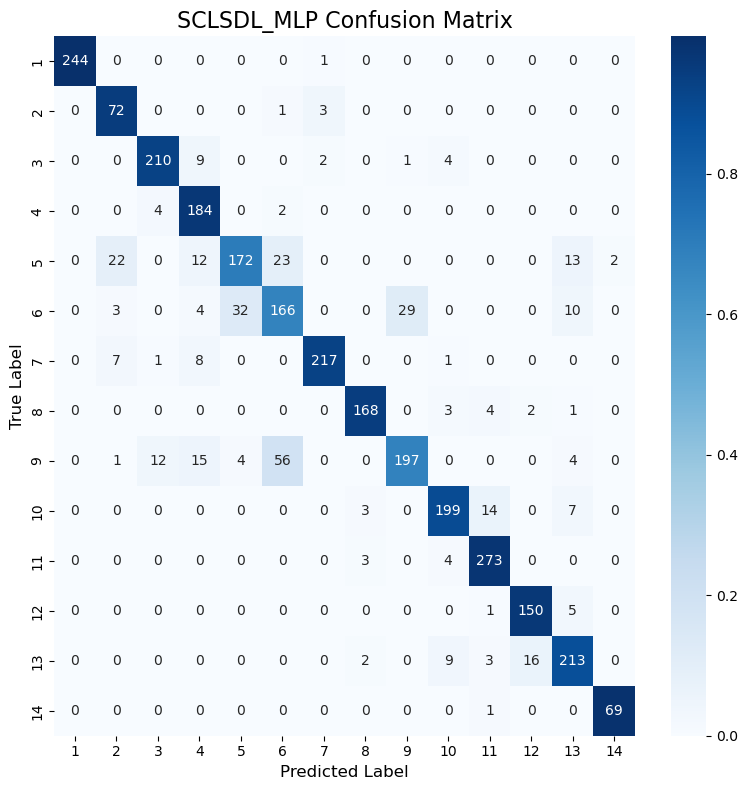

Classification Accuracy: 87.44%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          97.65
1    LRM (CAE)          78.40
2    MLP (CAE)          51.55
3     TSCL LRM          86.23
4     TSCL MLP          85.89
5  SCL_SDL LRM          87.09
6  SCL_SDL MLP          87.44

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          97.65
6  SCL_SDL MLP          87.44
5  SCL_SDL LRM          87.09
3     TSCL LRM          86.23
4     TSCL MLP          85.89
1    LRM (CAE)          78.40
2    MLP (CAE)          51.55
